In [1]:
%pip install pandas
%pip install jamo

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import gc
import math
import copy
import functools
import random
from glob import glob

import jamo
import pandas as pd
import numpy as np
import librosa.display, librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
train = pd.read_csv('train.csv')
submission = pd.read_csv('sample_submission.csv')

In [4]:
train.head()

for i, text in enumerate(train.text):
    print(f'[{i+1}] {text}')
    graphme = jamo.j2hcj(jamo.h2j(text))
    print(f'-> {graphme} ({len(graphme)})')
    train.text[i] = graphme

[1] 요샌 당신만 생각납니다. 나는 당신을 사랑하는 것 같습니다. 나와 결혼해 주십시오. 정말 사랑합니다.
-> ㅇㅛㅅㅐㄴ ㄷㅏㅇㅅㅣㄴㅁㅏㄴ ㅅㅐㅇㄱㅏㄱㄴㅏㅂㄴㅣㄷㅏ. ㄴㅏㄴㅡㄴ ㄷㅏㅇㅅㅣㄴㅇㅡㄹ ㅅㅏㄹㅏㅇㅎㅏㄴㅡㄴ ㄱㅓㅅ ㄱㅏㅌㅅㅡㅂㄴㅣㄷㅏ. ㄴㅏㅇㅘ ㄱㅕㄹㅎㅗㄴㅎㅐ ㅈㅜㅅㅣㅂㅅㅣㅇㅗ. ㅈㅓㅇㅁㅏㄹ ㅅㅏㄹㅏㅇㅎㅏㅂㄴㅣㄷㅏ. (119)
[2] 안녕하세요. 고객님. 저는 상담사 이지혜입니다. 제가 좋은 보험 하나 소개시켜주고 싶은데 시간 되시죠?
-> ㅇㅏㄴㄴㅕㅇㅎㅏㅅㅔㅇㅛ. ㄱㅗㄱㅐㄱㄴㅣㅁ. ㅈㅓㄴㅡㄴ ㅅㅏㅇㄷㅏㅁㅅㅏ ㅇㅣㅈㅣㅎㅖㅇㅣㅂㄴㅣㄷㅏ. ㅈㅔㄱㅏ ㅈㅗㅎㅇㅡㄴ ㅂㅗㅎㅓㅁ ㅎㅏㄴㅏ ㅅㅗㄱㅐㅅㅣㅋㅕㅈㅜㄱㅗ ㅅㅣㅍㅇㅡㄴㄷㅔ ㅅㅣㄱㅏㄴ ㄷㅚㅅㅣㅈㅛ? (112)
[3] 오늘 점심으로 칼국수 끓이려고 하는데 괜찮아요?
-> ㅇㅗㄴㅡㄹ ㅈㅓㅁㅅㅣㅁㅇㅡㄹㅗ ㅋㅏㄹㄱㅜㄱㅅㅜ ㄲㅡㅀㅇㅣㄹㅕㄱㅗ ㅎㅏㄴㅡㄴㄷㅔ ㄱㅙㄴㅊㅏㄶㅇㅏㅇㅛ? (55)
[4] 우리 토요일 날 노는 날이니까 요번에 엄마 산소 한 번 갔다 오는 게 어딨겠어 여보?
-> ㅇㅜㄹㅣ ㅌㅗㅇㅛㅇㅣㄹ ㄴㅏㄹ ㄴㅗㄴㅡㄴ ㄴㅏㄹㅇㅣㄴㅣㄲㅏ ㅇㅛㅂㅓㄴㅇㅔ ㅇㅓㅁㅁㅏ ㅅㅏㄴㅅㅗ ㅎㅏㄴ ㅂㅓㄴ ㄱㅏㅆㄷㅏ ㅇㅗㄴㅡㄴ ㄱㅔ ㅇㅓㄷㅣㅆㄱㅔㅆㅇㅓ ㅇㅕㅂㅗ? (92)
[5] 강원도는 하루 종일 비가 왔는데 서울은 어땠어?
-> ㄱㅏㅇㅇㅝㄴㄷㅗㄴㅡㄴ ㅎㅏㄹㅜ ㅈㅗㅇㅇㅣㄹ ㅂㅣㄱㅏ ㅇㅘㅆㄴㅡㄴㄷㅔ ㅅㅓㅇㅜㄹㅇㅡㄴ ㅇㅓㄸㅐㅆㅇㅓ? (55)
[6] 오늘 저녁은 뭐 먹을까? 피자 먹을까? 치킨 먹을까?
-> ㅇㅗㄴㅡㄹ ㅈㅓㄴㅕㄱㅇㅡㄴ ㅁㅝ ㅁㅓㄱㅇㅡㄹㄲㅏ? ㅍㅣㅈㅏ ㅁㅓㄱㅇㅡㄹㄲㅏ? ㅊㅣㅋㅣㄴ ㅁㅓㄱㅇㅡㄹㄲㅏ? (58)
[7] 제가 가장 잘 하고 좋아하는 운동은 골프입니다.
-> ㅈㅔㄱㅏ ㄱㅏㅈㅏㅇ ㅈㅏㄹ ㅎㅏㄱㅗ ㅈㅗㅎㅇㅏㅎㅏㄴㅡㄴ ㅇㅜㄴㄷㅗㅇㅇㅡㄴ ㄱㅗㄹㅍㅡㅇㅣㅂㄴㅣㄷㅏ. (54)
[8] 어디 아파? 안색이 너무 안 좋은데 병원에 한번 가보는 게 어때?
-> ㅇㅓㄷㅣ ㅇㅏㅍㅏ? ㅇㅏㄴㅅㅐㄱㅇㅣ ㄴㅓㅁㅜ ㅇㅏㄴ ㅈㅗㅎㅇㅡㄴㄷㅔ ㅂㅕㅇㅇㅝㄴ

[347] 우제 우연히 무단횡단 사고 현장을 목격했어. 너무 위함 하더라.
-> ㅇㅜㅈㅔ ㅇㅜㅇㅕㄴㅎㅣ ㅁㅜㄷㅏㄴㅎㅚㅇㄷㅏㄴ ㅅㅏㄱㅗ ㅎㅕㄴㅈㅏㅇㅇㅡㄹ ㅁㅗㄱㄱㅕㄱㅎㅐㅆㅇㅓ. ㄴㅓㅁㅜ ㅇㅟㅎㅏㅁ ㅎㅏㄷㅓㄹㅏ. (71)
[348] 새로운 일자리를 구하고 있는데 생각처럼 쉽지 않네?
-> ㅅㅐㄹㅗㅇㅜㄴ ㅇㅣㄹㅈㅏㄹㅣㄹㅡㄹ ㄱㅜㅎㅏㄱㅗ ㅇㅣㅆㄴㅡㄴㄷㅔ ㅅㅐㅇㄱㅏㄱㅊㅓㄹㅓㅁ ㅅㅟㅂㅈㅣ ㅇㅏㄶㄴㅔ? (59)
[349] 혹시 어제 제가 부탁드렸던 일은 다 끝내셨나요? 지금 넘겨야 하는데.
-> ㅎㅗㄱㅅㅣ ㅇㅓㅈㅔ ㅈㅔㄱㅏ ㅂㅜㅌㅏㄱㄷㅡㄹㅕㅆㄷㅓㄴ ㅇㅣㄹㅇㅡㄴ ㄷㅏ ㄲㅡㅌㄴㅐㅅㅕㅆㄴㅏㅇㅛ? ㅈㅣㄱㅡㅁ ㄴㅓㅁㄱㅕㅇㅑ ㅎㅏㄴㅡㄴㄷㅔ. (76)
[350] 따로 답장 안 해도 되겠지? 이제 와서 답장하기도 민망한데.
-> ㄸㅏㄹㅗ ㄷㅏㅂㅈㅏㅇ ㅇㅏㄴ ㅎㅐㄷㅗ ㄷㅚㄱㅔㅆㅈㅣ? ㅇㅣㅈㅔ ㅇㅘㅅㅓ ㄷㅏㅂㅈㅏㅇㅎㅏㄱㅣㄷㅗ ㅁㅣㄴㅁㅏㅇㅎㅏㄴㄷㅔ. (65)
[351] 수업시간에 선생님 질문에 대답하는 것 외엔 말을 안 해.
-> ㅅㅜㅇㅓㅂㅅㅣㄱㅏㄴㅇㅔ ㅅㅓㄴㅅㅐㅇㄴㅣㅁ ㅈㅣㄹㅁㅜㄴㅇㅔ ㄷㅐㄷㅏㅂㅎㅏㄴㅡㄴ ㄱㅓㅅ ㅇㅚㅇㅔㄴ ㅁㅏㄹㅇㅡㄹ ㅇㅏㄴ ㅎㅐ. (67)
[352] 우리는 살면서 얼마나 많은 기억을 가지고 있을까?
-> ㅇㅜㄹㅣㄴㅡㄴ ㅅㅏㄹㅁㅕㄴㅅㅓ ㅇㅓㄹㅁㅏㄴㅏ ㅁㅏㄶㅇㅡㄴ ㄱㅣㅇㅓㄱㅇㅡㄹ ㄱㅏㅈㅣㄱㅗ ㅇㅣㅆㅇㅡㄹㄲㅏ? (57)
[353] 진짜 남자들이 예의도 없고 개념도 없어.
-> ㅈㅣㄴㅉㅏ ㄴㅏㅁㅈㅏㄷㅡㄹㅇㅣ ㅇㅖㅇㅢㄷㅗ ㅇㅓㅄㄱㅗ ㄱㅐㄴㅕㅁㄷㅗ ㅇㅓㅄㅇㅓ. (44)
[354] 그러게 평소에 조금씩이라도 돌려 두면 좋잖아.
-> ㄱㅡㄹㅓㄱㅔ ㅍㅕㅇㅅㅗㅇㅔ ㅈㅗㄱㅡㅁㅆㅣㄱㅇㅣㄹㅏㄷㅗ ㄷㅗㄹㄹㅕ ㄷㅜㅁㅕㄴ ㅈㅗㅎㅈㅏㄶㅇㅏ. (51)
[355] 아니/ 펜션 말고 양평에 되기 분위기 좋은 온천이 있데. 거기 가자.
-> ㅇㅏㄴㅣ/ ㅍㅔㄴㅅㅕㄴ ㅁㅏㄹㄱㅗ ㅇㅑㅇㅍㅕㅇㅇㅔ ㄷㅚㄱㅣ ㅂㅜㄴㅇㅟㄱㅣ ㅈㅗㅎㅇㅡㄴ ㅇㅗㄴㅊㅓㄴㅇㅣ ㅇㅣㅆㄷㅔ. ㄱㅓㄱㅣ ㄱㅏㅈㅏ. (74)
[356] 내가 알아보니까 

[654] 저는 지금 일반 사무직 업무를 하고 있어요.
-> ㅈㅓㄴㅡㄴ ㅈㅣㄱㅡㅁ ㅇㅣㄹㅂㅏㄴ ㅅㅏㅁㅜㅈㅣㄱ ㅇㅓㅂㅁㅜㄹㅡㄹ ㅎㅏㄱㅗ ㅇㅣㅆㅇㅓㅇㅛ. (49)
[655] 예전엔 은행에 맡겨도 이자가 괜찮았는데 요즘은 진짜 아무것도 안 주는구나.
-> ㅇㅖㅈㅓㄴㅇㅔㄴ ㅇㅡㄴㅎㅐㅇㅇㅔ ㅁㅏㅌㄱㅕㄷㅗ ㅇㅣㅈㅏㄱㅏ ㄱㅙㄴㅊㅏㄶㅇㅏㅆㄴㅡㄴㄷㅔ ㅇㅛㅈㅡㅁㅇㅡㄴ ㅈㅣㄴㅉㅏ ㅇㅏㅁㅜㄱㅓㅅㄷㅗ ㅇㅏㄴ ㅈㅜㄴㅡㄴㄱㅜㄴㅏ. (87)
[656] 시험공부하고 있어? 잘 되어가고 있는 중?
-> ㅅㅣㅎㅓㅁㄱㅗㅇㅂㅜㅎㅏㄱㅗ ㅇㅣㅆㅇㅓ? ㅈㅏㄹ ㄷㅚㅇㅓㄱㅏㄱㅗ ㅇㅣㅆㄴㅡㄴ ㅈㅜㅇ? (46)
[657] 얼굴에 열이 많이 나네 언제부터 아팠는데?
-> ㅇㅓㄹㄱㅜㄹㅇㅔ ㅇㅕㄹㅇㅣ ㅁㅏㄶㅇㅣ ㄴㅏㄴㅔ ㅇㅓㄴㅈㅔㅂㅜㅌㅓ ㅇㅏㅍㅏㅆㄴㅡㄴㄷㅔ? (47)
[658] 몸이 안 좋아요? 마지막으로 건강검진 언제 받았어요?
-> ㅁㅗㅁㅇㅣ ㅇㅏㄴ ㅈㅗㅎㅇㅏㅇㅛ? ㅁㅏㅈㅣㅁㅏㄱㅇㅡㄹㅗ ㄱㅓㄴㄱㅏㅇㄱㅓㅁㅈㅣㄴ ㅇㅓㄴㅈㅔ ㅂㅏㄷㅇㅏㅆㅇㅓㅇㅛ? (61)
[659] 근데 처음에는 걱정해주는 게 맞는 거잖아.
-> ㄱㅡㄴㄷㅔ ㅊㅓㅇㅡㅁㅇㅔㄴㅡㄴ ㄱㅓㄱㅈㅓㅇㅎㅐㅈㅜㄴㅡㄴ ㄱㅔ ㅁㅏㅈㄴㅡㄴ ㄱㅓㅈㅏㄶㅇㅏ. (49)
[660] 해준 반찬 버리는 거 없이 잘 먹고 있어?
-> ㅎㅐㅈㅜㄴ ㅂㅏㄴㅊㅏㄴ ㅂㅓㄹㅣㄴㅡㄴ ㄱㅓ ㅇㅓㅄㅇㅣ ㅈㅏㄹ ㅁㅓㄱㄱㅗ ㅇㅣㅆㅇㅓ? (46)
[661] 지민이는 지금 자가 격리 중이라서 집 밖으로 못 나온다.
-> ㅈㅣㅁㅣㄴㅇㅣㄴㅡㄴ ㅈㅣㄱㅡㅁ ㅈㅏㄱㅏ ㄱㅕㄱㄹㅣ ㅈㅜㅇㅇㅣㄹㅏㅅㅓ ㅈㅣㅂ ㅂㅏㄲㅇㅡㄹㅗ ㅁㅗㅅ ㄴㅏㅇㅗㄴㄷㅏ. (62)
[662] 어서 오세요 예약하고 오셨나요? 그냥 오셨나요? 성함이 어떻게 되세요?
-> ㅇㅓㅅㅓ ㅇㅗㅅㅔㅇㅛ ㅇㅖㅇㅑㄱㅎㅏㄱㅗ ㅇㅗㅅㅕㅆㄴㅏㅇㅛ? ㄱㅡㄴㅑㅇ ㅇㅗㅅㅕㅆㄴㅏㅇㅛ? ㅅㅓㅇㅎㅏㅁㅇㅣ ㅇㅓㄸㅓㅎㄱㅔ ㄷㅚㅅㅔㅇㅛ? (74)
[663] 바지 찢어져서 단골 수선집 있는데 거기 가야겠다.
-> ㅂㅏㅈㅣ ㅉㅣㅈㅇㅓㅈㅕㅅㅓ ㄷㅏㄴㄱㅗㄹ ㅅㅜㅅㅓㄴㅈㅣㅂ ㅇㅣㅆㄴㅡㄴㄷㅔ ㄱㅓ

-> ㅇㅓㅁㅁㅏ ㅇㅛㅈㅡㅁ ㅁㅗㅇㅣㅁㄷㅗ ㅁㅗㅅ ㄱㅏㄱㅗ ㅁㅏㄶㅇㅣ ㅅㅣㅁㅅㅣㅁㅎㅏㄱㅔㅆㄴㅔ. (49)
[984] 지금 진짜 뱃가죽이 등 가죽에 붙을 것 같아.
-> ㅈㅣㄱㅡㅁ ㅈㅣㄴㅉㅏ ㅂㅐㅅㄱㅏㅈㅜㄱㅇㅣ ㄷㅡㅇ ㄱㅏㅈㅜㄱㅇㅔ ㅂㅜㅌㅇㅡㄹ ㄱㅓㅅ ㄱㅏㅌㅇㅏ. (52)
[985] 팀장님 내일 회식 메뉴 어떤 게 좋을지 추천 좀 해주세요.
-> ㅌㅣㅁㅈㅏㅇㄴㅣㅁ ㄴㅐㅇㅣㄹ ㅎㅚㅅㅣㄱ ㅁㅔㄴㅠ ㅇㅓㄸㅓㄴ ㄱㅔ ㅈㅗㅎㅇㅡㄹㅈㅣ ㅊㅜㅊㅓㄴ ㅈㅗㅁ ㅎㅐㅈㅜㅅㅔㅇㅛ. (64)
[986] 그/ 사람은 야구에 푹 빠져 있어서 야구 말곤 눈에 들어오지도 않아.
-> ㄱㅡ/ ㅅㅏㄹㅏㅁㅇㅡㄴ ㅇㅑㄱㅜㅇㅔ ㅍㅜㄱ ㅃㅏㅈㅕ ㅇㅣㅆㅇㅓㅅㅓ ㅇㅑㄱㅜ ㅁㅏㄹㄱㅗㄴ ㄴㅜㄴㅇㅔ ㄷㅡㄹㅇㅓㅇㅗㅈㅣㄷㅗ ㅇㅏㄶㅇㅏ. (73)
[987] 흰 식빵보다는 흡수율이 낮은 통밀 식빵이 좋아.
-> ㅎㅢㄴ ㅅㅣㄱㅃㅏㅇㅂㅗㄷㅏㄴㅡㄴ ㅎㅡㅂㅅㅜㅇㅠㄹㅇㅣ ㄴㅏㅈㅇㅡㄴ ㅌㅗㅇㅁㅣㄹ ㅅㅣㄱㅃㅏㅇㅇㅣ ㅈㅗㅎㅇㅏ. (58)
[988] 이번 주는 한가해서 아무 때나 약속 잡아도 괜찮아요.
-> ㅇㅣㅂㅓㄴ ㅈㅜㄴㅡㄴ ㅎㅏㄴㄱㅏㅎㅐㅅㅓ ㅇㅏㅁㅜ ㄸㅐㄴㅏ ㅇㅑㄱㅅㅗㄱ ㅈㅏㅂㅇㅏㄷㅗ ㄱㅙㄴㅊㅏㄶㅇㅏㅇㅛ. (58)
[989] 친구들이 부모님의 건강을 걱정해줘서 기분이 좋았어.
-> ㅊㅣㄴㄱㅜㄷㅡㄹㅇㅣ ㅂㅜㅁㅗㄴㅣㅁㅇㅢ ㄱㅓㄴㄱㅏㅇㅇㅡㄹ ㄱㅓㄱㅈㅓㅇㅎㅐㅈㅝㅅㅓ ㄱㅣㅂㅜㄴㅇㅣ ㅈㅗㅎㅇㅏㅆㅇㅓ. (61)
[990] 내일 태풍 온다는데 베란다에 물 새는 거 아니야?
-> ㄴㅐㅇㅣㄹ ㅌㅐㅍㅜㅇ ㅇㅗㄴㄷㅏㄴㅡㄴㄷㅔ ㅂㅔㄹㅏㄴㄷㅏㅇㅔ ㅁㅜㄹ ㅅㅐㄴㅡㄴ ㄱㅓ ㅇㅏㄴㅣㅇㅑ? (53)
[991] 콜라는 한 박스 정도 남아 있을 거야. 아직 다 못 먹었어.
-> ㅋㅗㄹㄹㅏㄴㅡㄴ ㅎㅏㄴ ㅂㅏㄱㅅㅡ ㅈㅓㅇㄷㅗ ㄴㅏㅁㅇㅏ ㅇㅣㅆㅇㅡㄹ ㄱㅓㅇㅑ. ㅇㅏㅈㅣㄱ ㄷㅏ ㅁㅗㅅ ㅁㅓㄱㅇㅓㅆㅇㅓ. (66)
[992] 내 꿈이 뭔지 알아? 가만히 있어도 초조하지 않은 삶이야.
-> ㄴㅐ ㄲㅜㅁㅇㅣ ㅁㅝㄴㅈㅣ ㅇㅏㄹㅇㅏ? ㄱㅏㅁㅏㄴㅎㅣ ㅇㅣㅆㅇㅓㄷㅗ ㅊㅗㅈㅗㅎㅏㅈㅣ ㅇㅏ

[1331] 코로나 때문에 학교마다 사람이 너무 몰리니까 기준이 점점 높아지는 것 같아.
-> ㅋㅗㄹㅗㄴㅏ ㄸㅐㅁㅜㄴㅇㅔ ㅎㅏㄱㄱㅛㅁㅏㄷㅏ ㅅㅏㄹㅏㅁㅇㅣ ㄴㅓㅁㅜ ㅁㅗㄹㄹㅣㄴㅣㄲㅏ ㄱㅣㅈㅜㄴㅇㅣ ㅈㅓㅁㅈㅓㅁ ㄴㅗㅍㅇㅏㅈㅣㄴㅡㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅏ. (84)
[1332] 왜? 너 거기 들어간지 얼마 안 되지 않았어?
-> ㅇㅙ? ㄴㅓ ㄱㅓㄱㅣ ㄷㅡㄹㅇㅓㄱㅏㄴㅈㅣ ㅇㅓㄹㅁㅏ ㅇㅏㄴ ㄷㅚㅈㅣ ㅇㅏㄶㅇㅏㅆㅇㅓ? (47)
[1333] 할아버지 장례식 때 일 때문에 여기에 한 학기도 더 있기 싫거든.
-> ㅎㅏㄹㅇㅏㅂㅓㅈㅣ ㅈㅏㅇㄹㅖㅅㅣㄱ ㄸㅐ ㅇㅣㄹ ㄸㅐㅁㅜㄴㅇㅔ ㅇㅕㄱㅣㅇㅔ ㅎㅏㄴ ㅎㅏㄱㄱㅣㄷㅗ ㄷㅓ ㅇㅣㅆㄱㅣ ㅅㅣㅀㄱㅓㄷㅡㄴ. (71)
[1334] 남자 친구는 공대 대학원에서 박사 과정 밟으면서 연구하고 있어.
-> ㄴㅏㅁㅈㅏ ㅊㅣㄴㄱㅜㄴㅡㄴ ㄱㅗㅇㄷㅐ ㄷㅐㅎㅏㄱㅇㅝㄴㅇㅔㅅㅓ ㅂㅏㄱㅅㅏ ㄱㅘㅈㅓㅇ ㅂㅏㄼㅇㅡㅁㅕㄴㅅㅓ ㅇㅕㄴㄱㅜㅎㅏㄱㅗ ㅇㅣㅆㅇㅓ. (73)
[1335] 아니야. 그런 거 상관없이 고양이는 쪼끔 무서워.
-> ㅇㅏㄴㅣㅇㅑ. ㄱㅡㄹㅓㄴ ㄱㅓ ㅅㅏㅇㄱㅘㄴㅇㅓㅄㅇㅣ ㄱㅗㅇㅑㅇㅇㅣㄴㅡㄴ ㅉㅗㄲㅡㅁ ㅁㅜㅅㅓㅇㅝ. (53)
[1336] 차곡차곡 모으면 큰돈을 마련할 수 있어.
-> ㅊㅏㄱㅗㄱㅊㅏㄱㅗㄱ ㅁㅗㅇㅡㅁㅕㄴ ㅋㅡㄴㄷㅗㄴㅇㅡㄹ ㅁㅏㄹㅕㄴㅎㅏㄹ ㅅㅜ ㅇㅣㅆㅇㅓ. (47)
[1337] 또 그래요? 껐다가 다시 켜보면 될 수도 있는데 해보셨어요?
-> ㄸㅗ ㄱㅡㄹㅐㅇㅛ? ㄲㅓㅆㄷㅏㄱㅏ ㄷㅏㅅㅣ ㅋㅕㅂㅗㅁㅕㄴ ㄷㅚㄹ ㅅㅜㄷㅗ ㅇㅣㅆㄴㅡㄴㄷㅔ ㅎㅐㅂㅗㅅㅕㅆㅇㅓㅇㅛ? (62)
[1338] 친척들의 잔소리가 싫지만 그래도 명절에는 역시 할머니 댁에 가는 게 더 좋은 것 같아.
-> ㅊㅣㄴㅊㅓㄱㄷㅡㄹㅇㅢ ㅈㅏㄴㅅㅗㄹㅣㄱㅏ ㅅㅣㅀㅈㅣㅁㅏㄴ ㄱㅡㄹㅐㄷㅗ ㅁㅕㅇㅈㅓㄹㅇㅔㄴㅡㄴ ㅇㅕㄱㅅㅣ ㅎㅏㄹㅁㅓㄴㅣ ㄷㅐㄱㅇㅔ ㄱㅏㄴㅡㄴ ㄱㅔ ㄷㅓ ㅈㅗㅎㅇㅡㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅏ. (99)
[1339] 나는 맛집 이런 데에서 줄 서서 먹는 거 이해가 안 돼.
-> ㄴㅏㄴㅡㄴ ㅁㅏㅅㅈㅣㅂ ㅇㅣㄹㅓㄴ

[1649] 요즘 같은 때는 주식에 투자하는 것으로 돈을 버는 사람이 많은 것 같다.
-> ㅇㅛㅈㅡㅁ ㄱㅏㅌㅇㅡㄴ ㄸㅐㄴㅡㄴ ㅈㅜㅅㅣㄱㅇㅔ ㅌㅜㅈㅏㅎㅏㄴㅡㄴ ㄱㅓㅅㅇㅡㄹㅗ ㄷㅗㄴㅇㅡㄹ ㅂㅓㄴㅡㄴ ㅅㅏㄹㅏㅁㅇㅣ ㅁㅏㄶㅇㅡㄴ ㄱㅓㅅ ㄱㅏㅌㄷㅏ. (83)
[1650] 나는 돈을 저축해야 해 나는 꼭 소원을 이루어야 해.
-> ㄴㅏㄴㅡㄴ ㄷㅗㄴㅇㅡㄹ ㅈㅓㅊㅜㄱㅎㅐㅇㅑ ㅎㅐ ㄴㅏㄴㅡㄴ ㄲㅗㄱ ㅅㅗㅇㅝㄴㅇㅡㄹ ㅇㅣㄹㅜㅇㅓㅇㅑ ㅎㅐ. (57)
[1651] 응 요즘 같은 철에는 이 부근의 대기가 불안정해지는 일이 많거든.
-> ㅇㅡㅇ ㅇㅛㅈㅡㅁ ㄱㅏㅌㅇㅡㄴ ㅊㅓㄹㅇㅔㄴㅡㄴ ㅇㅣ ㅂㅜㄱㅡㄴㅇㅢ ㄷㅐㄱㅣㄱㅏ ㅂㅜㄹㅇㅏㄴㅈㅓㅇㅎㅐㅈㅣㄴㅡㄴ ㅇㅣㄹㅇㅣ ㅁㅏㄶㄱㅓㄷㅡㄴ. (76)
[1652] 아직까진 괜찮아. 몇몇 사소한 일만 빼면.
-> ㅇㅏㅈㅣㄱㄲㅏㅈㅣㄴ ㄱㅙㄴㅊㅏㄶㅇㅏ. ㅁㅕㅊㅁㅕㅊ ㅅㅏㅅㅗㅎㅏㄴ ㅇㅣㄹㅁㅏㄴ ㅃㅐㅁㅕㄴ. (49)
[1653] 오빠 오늘 소연이랑 보성이랑 같이 보면 어때?
-> ㅇㅗㅃㅏ ㅇㅗㄴㅡㄹ ㅅㅗㅇㅕㄴㅇㅣㄹㅏㅇ ㅂㅗㅅㅓㅇㅇㅣㄹㅏㅇ ㄱㅏㅌㅇㅣ ㅂㅗㅁㅕㄴ ㅇㅓㄸㅐ? (50)
[1654] 민호 씨가 건축 자재들을 주문할 건가요?
-> ㅁㅣㄴㅎㅗ ㅆㅣㄱㅏ ㄱㅓㄴㅊㅜㄱ ㅈㅏㅈㅐㄷㅡㄹㅇㅡㄹ ㅈㅜㅁㅜㄴㅎㅏㄹ ㄱㅓㄴㄱㅏㅇㅛ? (46)
[1655] 그래도 너희들이라도 이렇게 와줬으니 됐다.
-> ㄱㅡㄹㅐㄷㅗ ㄴㅓㅎㅢㄷㅡㄹㅇㅣㄹㅏㄷㅗ ㅇㅣㄹㅓㅎㄱㅔ ㅇㅘㅈㅝㅆㅇㅡㄴㅣ ㄷㅙㅆㄷㅏ. (45)
[1656] 걔는 원래 성격이 저런 거야 아니면 오늘만 그러는 거야? 보기 좀 불편하네.
-> ㄱㅒㄴㅡㄴ ㅇㅝㄴㄹㅐ ㅅㅓㅇㄱㅕㄱㅇㅣ ㅈㅓㄹㅓㄴ ㄱㅓㅇㅑ ㅇㅏㄴㅣㅁㅕㄴ ㅇㅗㄴㅡㄹㅁㅏㄴ ㄱㅡㄹㅓㄴㅡㄴ ㄱㅓㅇㅑ? ㅂㅗㄱㅣ ㅈㅗㅁ ㅂㅜㄹㅍㅕㄴㅎㅏㄴㅔ. (83)
[1657] 요즘 내 주변에 노량진까지 가서 공무원 시험을 준비하고 있는 친구들이 너무 많아.
-> ㅇㅛㅈㅡㅁ ㄴㅐ ㅈㅜㅂㅕㄴㅇㅔ ㄴㅗㄹㅑㅇㅈㅣㄴㄲㅏㅈㅣ ㄱㅏㅅㅓ ㄱㅗㅇㅁㅜㅇㅝㄴ ㅅㅣㅎㅓㅁㅇㅡㄹ ㅈㅜㄴㅂㅣㅎㅏㄱㅗ ㅇㅣㅆㄴㅡㄴ ㅊㅣㄴㄱㅜㄷㅡㄹㅇ

[2002] 일단 소고기 당근 양파 버섯 같은 재료가 필요해요.
-> ㅇㅣㄹㄷㅏㄴ ㅅㅗㄱㅗㄱㅣ ㄷㅏㅇㄱㅡㄴ ㅇㅑㅇㅍㅏ ㅂㅓㅅㅓㅅ ㄱㅏㅌㅇㅡㄴ ㅈㅐㄹㅛㄱㅏ ㅍㅣㄹㅇㅛㅎㅐㅇㅛ. (57)
[2003] 너는 어떤 음식을 제일 좋아해? 나는 양식이 좋더라고.
-> ㄴㅓㄴㅡㄴ ㅇㅓㄸㅓㄴ ㅇㅡㅁㅅㅣㄱㅇㅡㄹ ㅈㅔㅇㅣㄹ ㅈㅗㅎㅇㅏㅎㅐ? ㄴㅏㄴㅡㄴ ㅇㅑㅇㅅㅣㄱㅇㅣ ㅈㅗㅎㄷㅓㄹㅏㄱㅗ. (62)
[2004] 나는 친분이 없었던 사람들과 프로젝트를 협업하기도 했었어.
-> ㄴㅏㄴㅡㄴ ㅊㅣㄴㅂㅜㄴㅇㅣ ㅇㅓㅄㅇㅓㅆㄷㅓㄴ ㅅㅏㄹㅏㅁㄷㅡㄹㄱㅘ ㅍㅡㄹㅗㅈㅔㄱㅌㅡㄹㅡㄹ ㅎㅕㅂㅇㅓㅂㅎㅏㄱㅣㄷㅗ ㅎㅐㅆㅇㅓㅆㅇㅓ. (71)
[2005] 생활이 딱 그래 행복했다가 힘들었다가.
-> ㅅㅐㅇㅎㅘㄹㅇㅣ ㄸㅏㄱ ㄱㅡㄹㅐ ㅎㅐㅇㅂㅗㄱㅎㅐㅆㄷㅏㄱㅏ ㅎㅣㅁㄷㅡㄹㅇㅓㅆㄷㅏㄱㅏ. (46)
[2006] 업무에 관한 의사소통이 빈번하다는 사실을 알고 있어.
-> ㅇㅓㅂㅁㅜㅇㅔ ㄱㅘㄴㅎㅏㄴ ㅇㅢㅅㅏㅅㅗㅌㅗㅇㅇㅣ ㅂㅣㄴㅂㅓㄴㅎㅏㄷㅏㄴㅡㄴ ㅅㅏㅅㅣㄹㅇㅡㄹ ㅇㅏㄹㄱㅗ ㅇㅣㅆㅇㅓ. (62)
[2007] 저기/ 벽에 못질을 하다가 손에 상처가 났어.
-> ㅈㅓㄱㅣ/ ㅂㅕㄱㅇㅔ ㅁㅗㅅㅈㅣㄹㅇㅡㄹ ㅎㅏㄷㅏㄱㅏ ㅅㅗㄴㅇㅔ ㅅㅏㅇㅊㅓㄱㅏ ㄴㅏㅆㅇㅓ. (49)
[2008] 내가 학기 첫날용 점심을 근사하게 만들어 줬어.
-> ㄴㅐㄱㅏ ㅎㅏㄱㄱㅣ ㅊㅓㅅㄴㅏㄹㅇㅛㅇ ㅈㅓㅁㅅㅣㅁㅇㅡㄹ ㄱㅡㄴㅅㅏㅎㅏㄱㅔ ㅁㅏㄴㄷㅡㄹㅇㅓ ㅈㅝㅆㅇㅓ. (56)
[2009] 아무리 노력해도 떡볶이가 사는 떡볶이 맛이 안 나는 거예요.
-> ㅇㅏㅁㅜㄹㅣ ㄴㅗㄹㅕㄱㅎㅐㄷㅗ ㄸㅓㄱㅂㅗㄲㅇㅣㄱㅏ ㅅㅏㄴㅡㄴ ㄸㅓㄱㅂㅗㄲㅇㅣ ㅁㅏㅅㅇㅣ ㅇㅏㄴ ㄴㅏㄴㅡㄴ ㄱㅓㅇㅖㅇㅛ. (66)
[2010] 누군가와 뭔가를 나누고 싶다는 생각이 자연스럽게 들 때 그게 사랑이야.
-> ㄴㅜㄱㅜㄴㄱㅏㅇㅘ ㅁㅝㄴㄱㅏㄹㅡㄹ ㄴㅏㄴㅜㄱㅗ ㅅㅣㅍㄷㅏㄴㅡㄴ ㅅㅐㅇㄱㅏㄱㅇㅣ ㅈㅏㅇㅕㄴㅅㅡㄹㅓㅂㄱㅔ ㄷㅡㄹ ㄸㅐ ㄱㅡㄱㅔ ㅅㅏㄹㅏㅇㅇㅣㅇㅑ. (79)
[2011] 현대백화점 커피 무료 쿠폰 까먹지 말고 꼭 사용해보자

[2339] 매우 무섭습니다. 그래서 문을 꼭 잠그고 잡니다.
-> ㅁㅐㅇㅜ ㅁㅜㅅㅓㅂㅅㅡㅂㄴㅣㄷㅏ. ㄱㅡㄹㅐㅅㅓ ㅁㅜㄴㅇㅡㄹ ㄲㅗㄱ ㅈㅏㅁㄱㅡㄱㅗ ㅈㅏㅂㄴㅣㄷㅏ. (53)
[2340] 차에 기름을 어떻게 넣는지 모르겠어요. 좀 도와주시겠어요.
-> ㅊㅏㅇㅔ ㄱㅣㄹㅡㅁㅇㅡㄹ ㅇㅓㄸㅓㅎㄱㅔ ㄴㅓㅎㄴㅡㄴㅈㅣ ㅁㅗㄹㅡㄱㅔㅆㅇㅓㅇㅛ. ㅈㅗㅁ ㄷㅗㅇㅘㅈㅜㅅㅣㄱㅔㅆㅇㅓㅇㅛ. (64)
[2341] 우리 중간고사 끝난 기념으로 놀러 가자. 어디를 갈까?
-> ㅇㅜㄹㅣ ㅈㅜㅇㄱㅏㄴㄱㅗㅅㅏ ㄲㅡㅌㄴㅏㄴ ㄱㅣㄴㅕㅁㅇㅡㄹㅗ ㄴㅗㄹㄹㅓ ㄱㅏㅈㅏ. ㅇㅓㄷㅣㄹㅡㄹ ㄱㅏㄹㄲㅏ? (59)
[2342] 아빠가 시험을 잘 봤다고 하얀색 곰인형을 사줬어.
-> ㅇㅏㅃㅏㄱㅏ ㅅㅣㅎㅓㅁㅇㅡㄹ ㅈㅏㄹ ㅂㅘㅆㄷㅏㄱㅗ ㅎㅏㅇㅑㄴㅅㅐㄱ ㄱㅗㅁㅇㅣㄴㅎㅕㅇㅇㅡㄹ ㅅㅏㅈㅝㅆㅇㅓ. (58)
[2343] 서로 할 말은 많은데 듣질 않으니까 대화가 안되지.
-> ㅅㅓㄹㅗ ㅎㅏㄹ ㅁㅏㄹㅇㅡㄴ ㅁㅏㄶㅇㅡㄴㄷㅔ ㄷㅡㄷㅈㅣㄹ ㅇㅏㄶㅇㅡㄴㅣㄲㅏ ㄷㅐㅎㅘㄱㅏ ㅇㅏㄴㄷㅚㅈㅣ. (57)
[2344] 그/ 애의 대답을 확실하게 들을 수 있어야지.
-> ㄱㅡ/ ㅇㅐㅇㅢ ㄷㅐㄷㅏㅂㅇㅡㄹ ㅎㅘㄱㅅㅣㄹㅎㅏㄱㅔ ㄷㅡㄹㅇㅡㄹ ㅅㅜ ㅇㅣㅆㅇㅓㅇㅑㅈㅣ. (49)
[2345] 그가 이렇게 애걸복걸하는데 너도 좀 봐 줘라.
-> ㄱㅡㄱㅏ ㅇㅣㄹㅓㅎㄱㅔ ㅇㅐㄱㅓㄹㅂㅗㄱㄱㅓㄹㅎㅏㄴㅡㄴㄷㅔ ㄴㅓㄷㅗ ㅈㅗㅁ ㅂㅘ ㅈㅝㄹㅏ. (49)
[2346] 내 생각엔 그 남자한테 더 이상 전화하지 않는 게 좋을 것 같아.
-> ㄴㅐ ㅅㅐㅇㄱㅏㄱㅇㅔㄴ ㄱㅡ ㄴㅏㅁㅈㅏㅎㅏㄴㅌㅔ ㄷㅓ ㅇㅣㅅㅏㅇ ㅈㅓㄴㅎㅘㅎㅏㅈㅣ ㅇㅏㄶㄴㅡㄴ ㄱㅔ ㅈㅗㅎㅇㅡㄹ ㄱㅓㅅ ㄱㅏㅌㅇㅏ. (73)
[2347] 모든 사람을 만족시킬 수 없다면 다수의 만족을 택하는 게 더 합리적인 거 아니겠어요?
-> ㅁㅗㄷㅡㄴ ㅅㅏㄹㅏㅁㅇㅡㄹ ㅁㅏㄴㅈㅗㄱㅅㅣㅋㅣㄹ ㅅㅜ ㅇㅓㅄㄷㅏㅁㅕㄴ ㄷㅏㅅㅜㅇㅢ ㅁㅏㄴㅈㅗㄱㅇㅡㄹ ㅌㅐㄱㅎㅏㄴㅡㄴ ㄱㅔ ㄷㅓ ㅎㅏㅂㄹㅣㅈㅓㄱㅇㅣㄴ ㄱㅓ ㅇㅏㄴㅣㄱㅔㅆㅇㅓㅇㅛ? (98)
[2348] 초코케

[2679] 저기/ 그릇을 놓고 갔거든 누구? 안녕.
-> ㅈㅓㄱㅣ/ ㄱㅡㄹㅡㅅㅇㅡㄹ ㄴㅗㅎㄱㅗ ㄱㅏㅆㄱㅓㄷㅡㄴ ㄴㅜㄱㅜ? ㅇㅏㄴㄴㅕㅇ. (43)
[2680] 내 사무실은 지금 없도 공유 오피스를 사용하고 있어.
-> ㄴㅐ ㅅㅏㅁㅜㅅㅣㄹㅇㅡㄴ ㅈㅣㄱㅡㅁ ㅇㅓㅄㄷㅗ ㄱㅗㅇㅇㅠ ㅇㅗㅍㅣㅅㅡㄹㅡㄹ ㅅㅏㅇㅛㅇㅎㅏㄱㅗ ㅇㅣㅆㅇㅓ. (58)
[2681] 밤에는 집기 세팅하고 낮에는 옥상 정리하고 어쩌려고 그래?
-> ㅂㅏㅁㅇㅔㄴㅡㄴ ㅈㅣㅂㄱㅣ ㅅㅔㅌㅣㅇㅎㅏㄱㅗ ㄴㅏㅈㅇㅔㄴㅡㄴ ㅇㅗㄱㅅㅏㅇ ㅈㅓㅇㄹㅣㅎㅏㄱㅗ ㅇㅓㅉㅓㄹㅕㄱㅗ ㄱㅡㄹㅐ? (65)
[2682] 좋아 내가 운전할 테니 넌 길을 안내해.
-> ㅈㅗㅎㅇㅏ ㄴㅐㄱㅏ ㅇㅜㄴㅈㅓㄴㅎㅏㄹ ㅌㅔㄴㅣ ㄴㅓㄴ ㄱㅣㄹㅇㅡㄹ ㅇㅏㄴㄴㅐㅎㅐ. (45)
[2683] 야. 너만 잘났냐? 나도 잘났어. 나는 이것도 있고 저것도 있어. 넌 없잖아.
-> ㅇㅑ. ㄴㅓㅁㅏㄴ ㅈㅏㄹㄴㅏㅆㄴㅑ? ㄴㅏㄷㅗ ㅈㅏㄹㄴㅏㅆㅇㅓ. ㄴㅏㄴㅡㄴ ㅇㅣㄱㅓㅅㄷㅗ ㅇㅣㅆㄱㅗ ㅈㅓㄱㅓㅅㄷㅗ ㅇㅣㅆㅇㅓ. ㄴㅓㄴ ㅇㅓㅄㅈㅏㄶㅇㅏ. (83)
[2684] 너는 대중교통 중에서 버스랑 지하철 중에 어떤 게 더 편해?
-> ㄴㅓㄴㅡㄴ ㄷㅐㅈㅜㅇㄱㅛㅌㅗㅇ ㅈㅜㅇㅇㅔㅅㅓ ㅂㅓㅅㅡㄹㅏㅇ ㅈㅣㅎㅏㅊㅓㄹ ㅈㅜㅇㅇㅔ ㅇㅓㄸㅓㄴ ㄱㅔ ㄷㅓ ㅍㅕㄴㅎㅐ? (65)
[2685] 요즘은 웹 소설을 많이 봐서 리디북스 결제하는 편이야.
-> ㅇㅛㅈㅡㅁㅇㅡㄴ ㅇㅞㅂ ㅅㅗㅅㅓㄹㅇㅡㄹ ㅁㅏㄶㅇㅣ ㅂㅘㅅㅓ ㄹㅣㄷㅣㅂㅜㄱㅅㅡ ㄱㅕㄹㅈㅔㅎㅏㄴㅡㄴ ㅍㅕㄴㅇㅣㅇㅑ. (62)
[2686] 다 아는 것 같은데 막상 대화할 땐 너무 떨려서 어려운 것 같아요.
-> ㄷㅏ ㅇㅏㄴㅡㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅡㄴㄷㅔ ㅁㅏㄱㅅㅏㅇ ㄷㅐㅎㅘㅎㅏㄹ ㄸㅐㄴ ㄴㅓㅁㅜ ㄸㅓㄹㄹㅕㅅㅓ ㅇㅓㄹㅕㅇㅜㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅏㅇㅛ. (74)
[2687] 사실 새로운 일을 시작하려고 최근에 퇴사했어요.
-> ㅅㅏㅅㅣㄹ ㅅㅐㄹㅗㅇㅜㄴ ㅇㅣㄹㅇㅡㄹ ㅅㅣㅈㅏㄱㅎㅏㄹㅕㄱㅗ ㅊㅚㄱㅡㄴㅇㅔ ㅌㅚㅅㅏㅎㅐㅆㅇㅓㅇㅛ. (53)
[2688] 여기 이 업무 흐름도가 제가 의미

[3021] 표현을 잘 못하는 건지 안 하는 건지 답답한 면이 있어.
-> ㅍㅛㅎㅕㄴㅇㅡㄹ ㅈㅏㄹ ㅁㅗㅅㅎㅏㄴㅡㄴ ㄱㅓㄴㅈㅣ ㅇㅏㄴ ㅎㅏㄴㅡㄴ ㄱㅓㄴㅈㅣ ㄷㅏㅂㄷㅏㅂㅎㅏㄴ ㅁㅕㄴㅇㅣ ㅇㅣㅆㅇㅓ. (66)
[3022] 요즘에는 무릎에도 털이 나서 걱정이라니까.
-> ㅇㅛㅈㅡㅁㅇㅔㄴㅡㄴ ㅁㅜㄹㅡㅍㅇㅔㄷㅗ ㅌㅓㄹㅇㅣ ㄴㅏㅅㅓ ㄱㅓㄱㅈㅓㅇㅇㅣㄹㅏㄴㅣㄲㅏ. (47)
[3023] 가끔 혼자 있고 싶고 아무 걱정 없이 쉬고 싶을 때 있지.
-> ㄱㅏㄲㅡㅁ ㅎㅗㄴㅈㅏ ㅇㅣㅆㄱㅗ ㅅㅣㅍㄱㅗ ㅇㅏㅁㅜ ㄱㅓㄱㅈㅓㅇ ㅇㅓㅄㅇㅣ ㅅㅟㄱㅗ ㅅㅣㅍㅇㅡㄹ ㄸㅐ ㅇㅣㅆㅈㅣ. (63)
[3024] 이 편지에 적힌 내용은 어머니를 화나게 했습니다.
-> ㅇㅣ ㅍㅕㄴㅈㅣㅇㅔ ㅈㅓㄱㅎㅣㄴ ㄴㅐㅇㅛㅇㅇㅡㄴ ㅇㅓㅁㅓㄴㅣㄹㅡㄹ ㅎㅘㄴㅏㄱㅔ ㅎㅐㅆㅅㅡㅂㄴㅣㄷㅏ. (55)
[3025] 내 인형을 담보로 걸게. 그럼 내 말 믿어줄 거냐고.
-> ㄴㅐ ㅇㅣㄴㅎㅕㅇㅇㅡㄹ ㄷㅏㅁㅂㅗㄹㅗ ㄱㅓㄹㄱㅔ. ㄱㅡㄹㅓㅁ ㄴㅐ ㅁㅏㄹ ㅁㅣㄷㅇㅓㅈㅜㄹ ㄱㅓㄴㅑㄱㅗ. (57)
[3026] 음식은 조심하시고 집에서 휴식을 취하세요.
-> ㅇㅡㅁㅅㅣㄱㅇㅡㄴ ㅈㅗㅅㅣㅁㅎㅏㅅㅣㄱㅗ ㅈㅣㅂㅇㅔㅅㅓ ㅎㅠㅅㅣㄱㅇㅡㄹ ㅊㅟㅎㅏㅅㅔㅇㅛ. (48)
[3027] 원래 나쁜 일은 몰아서 오는 법이라고 하잖아.
-> ㅇㅝㄴㄹㅐ ㄴㅏㅃㅡㄴ ㅇㅣㄹㅇㅡㄴ ㅁㅗㄹㅇㅏㅅㅓ ㅇㅗㄴㅡㄴ ㅂㅓㅂㅇㅣㄹㅏㄱㅗ ㅎㅏㅈㅏㄶㅇㅏ. (51)
[3028] 취미로 어디 다니고 있니? 나는 천연 화장품 공방을 다니고 있어.
-> ㅊㅟㅁㅣㄹㅗ ㅇㅓㄷㅣ ㄷㅏㄴㅣㄱㅗ ㅇㅣㅆㄴㅣ? ㄴㅏㄴㅡㄴ ㅊㅓㄴㅇㅕㄴ ㅎㅘㅈㅏㅇㅍㅜㅁ ㄱㅗㅇㅂㅏㅇㅇㅡㄹ ㄷㅏㄴㅣㄱㅗ ㅇㅣㅆㅇㅓ. (71)
[3029] 다음 주에 출국인 걸로 알고 있는데 혹시 일정이 바뀌었니?
-> ㄷㅏㅇㅡㅁ ㅈㅜㅇㅔ ㅊㅜㄹㄱㅜㄱㅇㅣㄴ ㄱㅓㄹㄹㅗ ㅇㅏㄹㄱㅗ ㅇㅣㅆㄴㅡㄴㄷㅔ ㅎㅗㄱㅅㅣ ㅇㅣㄹㅈㅓㅇㅇㅣ ㅂㅏㄲㅟㅇㅓㅆㄴㅣ? (67)
[3030] 무슨 할 말들이 그렇게 많은지 만나기만 하면 수다가 멈추지 않아요.
-> ㅁㅜㅅㅡㄴ ㅎㅏㄹ ㅁㅏㄹㄷㅡㄹ

[3350] 노래방 갔을 때 노래 못한다고 놀린 것도 미안해.
-> ㄴㅗㄹㅐㅂㅏㅇ ㄱㅏㅆㅇㅡㄹ ㄸㅐ ㄴㅗㄹㅐ ㅁㅗㅅㅎㅏㄴㄷㅏㄱㅗ ㄴㅗㄹㄹㅣㄴ ㄱㅓㅅㄷㅗ ㅁㅣㅇㅏㄴㅎㅐ. (55)
[3351] 작가님의 따뜻한 시선이 느껴지는 글이어서 참 좋았습니다.
-> ㅈㅏㄱㄱㅏㄴㅣㅁㅇㅢ ㄸㅏㄸㅡㅅㅎㅏㄴ ㅅㅣㅅㅓㄴㅇㅣ ㄴㅡㄲㅕㅈㅣㄴㅡㄴ ㄱㅡㄹㅇㅣㅇㅓㅅㅓ ㅊㅏㅁ ㅈㅗㅎㅇㅏㅆㅅㅡㅂㄴㅣㄷㅏ. (66)
[3352] 오늘 나를 제외하고는 아무도 늦지 않았어. 그래서 나는 너무 속상해.
-> ㅇㅗㄴㅡㄹ ㄴㅏㄹㅡㄹ ㅈㅔㅇㅚㅎㅏㄱㅗㄴㅡㄴ ㅇㅏㅁㅜㄷㅗ ㄴㅡㅈㅈㅣ ㅇㅏㄶㅇㅏㅆㅇㅓ. ㄱㅡㄹㅐㅅㅓ ㄴㅏㄴㅡㄴ ㄴㅓㅁㅜ ㅅㅗㄱㅅㅏㅇㅎㅐ. (74)
[3353] 미용실에서 머리 잘 못 파마해서 머리카락이 녹았데.
-> ㅁㅣㅇㅛㅇㅅㅣㄹㅇㅔㅅㅓ ㅁㅓㄹㅣ ㅈㅏㄹ ㅁㅗㅅ ㅍㅏㅁㅏㅎㅐㅅㅓ ㅁㅓㄹㅣㅋㅏㄹㅏㄱㅇㅣ ㄴㅗㄱㅇㅏㅆㄷㅔ. (56)
[3354] 끼어들지 말아요. 이 요점은 이게 문제에요.
-> ㄲㅣㅇㅓㄷㅡㄹㅈㅣ ㅁㅏㄹㅇㅏㅇㅛ. ㅇㅣ ㅇㅛㅈㅓㅁㅇㅡㄴ ㅇㅣㄱㅔ ㅁㅜㄴㅈㅔㅇㅔㅇㅛ. (46)
[3355] 여기는 다들 자고 있어서 조금만 조용히 해주세요.
-> ㅇㅕㄱㅣㄴㅡㄴ ㄷㅏㄷㅡㄹ ㅈㅏㄱㅗ ㅇㅣㅆㅇㅓㅅㅓ ㅈㅗㄱㅡㅁㅁㅏㄴ ㅈㅗㅇㅛㅇㅎㅣ ㅎㅐㅈㅜㅅㅔㅇㅛ. (53)
[3356] 저는 밀가루 다이어트하고 있어서 등심 스테이크 먹고 싶어요.
-> ㅈㅓㄴㅡㄴ ㅁㅣㄹㄱㅏㄹㅜ ㄷㅏㅇㅣㅇㅓㅌㅡㅎㅏㄱㅗ ㅇㅣㅆㅇㅓㅅㅓ ㄷㅡㅇㅅㅣㅁ ㅅㅡㅌㅔㅇㅣㅋㅡ ㅁㅓㄱㄱㅗ ㅅㅣㅍㅇㅓㅇㅛ. (65)
[3357] 다이어트 때문에 샐러드 먹는 건 줄 알았는데 맛있어서 먹는 건가 봐.
-> ㄷㅏㅇㅣㅇㅓㅌㅡ ㄸㅐㅁㅜㄴㅇㅔ ㅅㅐㄹㄹㅓㄷㅡ ㅁㅓㄱㄴㅡㄴ ㄱㅓㄴ ㅈㅜㄹ ㅇㅏㄹㅇㅏㅆㄴㅡㄴㄷㅔ ㅁㅏㅅㅇㅣㅆㅇㅓㅅㅓ ㅁㅓㄱㄴㅡㄴ ㄱㅓㄴㄱㅏ ㅂㅘ. (79)
[3358] 땡땡이치다가 담벼락에서 넘어지는 바람에 치마가 찢어졌어.
-> ㄸㅐㅇㄸㅐㅇㅇㅣㅊㅣㄷㅏㄱㅏ ㄷㅏㅁㅂㅕㄹㅏㄱㅇㅔㅅㅓ ㄴㅓㅁㅇㅓㅈㅣㄴㅡㄴ ㅂㅏㄹㅏㅁㅇㅔ ㅊㅣㅁㅏㄱㅏ ㅉㅣㅈㅇㅓㅈㅕㅆㅇㅓ. (65)
[3359] 그것도 

-> ㅅㅐㄹㄹㅓㄷㅡㅇㅛㅇ ㅊㅐㅅㅗㄹㅡㄹ ㅅㅏㅆㅈㅏㄶㅇㅏ. ㅃㅏㄹㄹㅣ ㅁㅓㄱㅇㅓㅇㅑ ㅎㅐ. (46)
[3778] 걔가 이 시간에 일어났다는 거는 분명 무슨 동기가 있는 걸 거야.
-> ㄱㅒㄱㅏ ㅇㅣ ㅅㅣㄱㅏㄴㅇㅔ ㅇㅣㄹㅇㅓㄴㅏㅆㄷㅏㄴㅡㄴ ㄱㅓㄴㅡㄴ ㅂㅜㄴㅁㅕㅇ ㅁㅜㅅㅡㄴ ㄷㅗㅇㄱㅣㄱㅏ ㅇㅣㅆㄴㅡㄴ ㄱㅓㄹ ㄱㅓㅇㅑ. (73)
[3779] 오늘은 빨래를 돌려야 돼서 야근은 못할 것 같아요.
-> ㅇㅗㄴㅡㄹㅇㅡㄴ ㅃㅏㄹㄹㅐㄹㅡㄹ ㄷㅗㄹㄹㅕㅇㅑ ㄷㅙㅅㅓ ㅇㅑㄱㅡㄴㅇㅡㄴ ㅁㅗㅅㅎㅏㄹ ㄱㅓㅅ ㄱㅏㅌㅇㅏㅇㅛ. (59)
[3780] 나는 너 믿어. 걱정하지 마. 진짜야.
-> ㄴㅏㄴㅡㄴ ㄴㅓ ㅁㅣㄷㅇㅓ. ㄱㅓㄱㅈㅓㅇㅎㅏㅈㅣ ㅁㅏ. ㅈㅣㄴㅉㅏㅇㅑ. (39)
[3781] 왜 이렇게 늦었어? 배고프잖아 웬 인형이냐?
-> ㅇㅙ ㅇㅣㄹㅓㅎㄱㅔ ㄴㅡㅈㅇㅓㅆㅇㅓ? ㅂㅐㄱㅗㅍㅡㅈㅏㄶㅇㅏ ㅇㅞㄴ ㅇㅣㄴㅎㅕㅇㅇㅣㄴㅑ? (48)
[3782] 삼촌이 왜 아들인 형보다 날 더 높이 평가했는지 알아?
-> ㅅㅏㅁㅊㅗㄴㅇㅣ ㅇㅙ ㅇㅏㄷㅡㄹㅇㅣㄴ ㅎㅕㅇㅂㅗㄷㅏ ㄴㅏㄹ ㄷㅓ ㄴㅗㅍㅇㅣ ㅍㅕㅇㄱㅏㅎㅐㅆㄴㅡㄴㅈㅣ ㅇㅏㄹㅇㅏ? (62)
[3783] 그러므로 저희는 모든 직원에게 출산휴가를 제공하고 있습니다.
-> ㄱㅡㄹㅓㅁㅡㄹㅗ ㅈㅓㅎㅢㄴㅡㄴ ㅁㅗㄷㅡㄴ ㅈㅣㄱㅇㅝㄴㅇㅔㄱㅔ ㅊㅜㄹㅅㅏㄴㅎㅠㄱㅏㄹㅡㄹ ㅈㅔㄱㅗㅇㅎㅏㄱㅗ ㅇㅣㅆㅅㅡㅂㄴㅣㄷㅏ. (69)
[3784] 프로그램을 완료하면 이수증을 받게 될 거야.
-> ㅍㅡㄹㅗㄱㅡㄹㅐㅁㅇㅡㄹ ㅇㅘㄴㄹㅛㅎㅏㅁㅕㄴ ㅇㅣㅅㅜㅈㅡㅇㅇㅡㄹ ㅂㅏㄷㄱㅔ ㄷㅚㄹ ㄱㅓㅇㅑ. (50)
[3785] 심지어 옆집 저녁 메뉴가 뭔지 알 때도 있으니 말 다 했지.
-> ㅅㅣㅁㅈㅣㅇㅓ ㅇㅕㅍㅈㅣㅂ ㅈㅓㄴㅕㄱ ㅁㅔㄴㅠㄱㅏ ㅁㅝㄴㅈㅣ ㅇㅏㄹ ㄸㅐㄷㅗ ㅇㅣㅆㅇㅡㄴㅣ ㅁㅏㄹ ㄷㅏ ㅎㅐㅆㅈㅣ. (64)
[3786] 나 맨날 걔한테 져서 너무 좌절감 들어.
-> ㄴㅏ ㅁㅐㄴㄴㅏㄹ ㄱㅒㅎㅏㄴㅌㅔ ㅈㅕㅅㅓ ㄴㅓㅁㅜ ㅈㅘㅈㅓㄹㄱㅏㅁ ㄷㅡㄹㅇㅓ. (43)
[3787] 어쨌든 매우 인기 있는 건물이니 원하시는 바를 알

[4139] 다음 이야기할 주제는 관광지에 대해서입니다.
-> ㄷㅏㅇㅡㅁ ㅇㅣㅇㅑㄱㅣㅎㅏㄹ ㅈㅜㅈㅔㄴㅡㄴ ㄱㅘㄴㄱㅘㅇㅈㅣㅇㅔ ㄷㅐㅎㅐㅅㅓㅇㅣㅂㄴㅣㄷㅏ. (49)
[4140] 코로나 심각단계가 격상했어. 왜 마스크를 안 써?
-> ㅋㅗㄹㅗㄴㅏ ㅅㅣㅁㄱㅏㄱㄷㅏㄴㄱㅖㄱㅏ ㄱㅕㄱㅅㅏㅇㅎㅐㅆㅇㅓ. ㅇㅙ ㅁㅏㅅㅡㅋㅡㄹㅡㄹ ㅇㅏㄴ ㅆㅓ? (54)
[4141] 날씨가 이리 비정상적인 이유도 오존층이 파괴되어서야.
-> ㄴㅏㄹㅆㅣㄱㅏ ㅇㅣㄹㅣ ㅂㅣㅈㅓㅇㅅㅏㅇㅈㅓㄱㅇㅣㄴ ㅇㅣㅇㅠㄷㅗ ㅇㅗㅈㅗㄴㅊㅡㅇㅇㅣ ㅍㅏㄱㅚㄷㅚㅇㅓㅅㅓㅇㅑ. (59)
[4142] 어떤 음악 스타일을 좋아하시나요? 저는 팝송이 좋아요.
-> ㅇㅓㄸㅓㄴ ㅇㅡㅁㅇㅏㄱ ㅅㅡㅌㅏㅇㅣㄹㅇㅡㄹ ㅈㅗㅎㅇㅏㅎㅏㅅㅣㄴㅏㅇㅛ? ㅈㅓㄴㅡㄴ ㅍㅏㅂㅅㅗㅇㅇㅣ ㅈㅗㅎㅇㅏㅇㅛ. (62)
[4143] 학교에서 오늘 어떤 친구한테 맞았어. 그 친구를 신고할 거야.
-> ㅎㅏㄱㄱㅛㅇㅔㅅㅓ ㅇㅗㄴㅡㄹ ㅇㅓㄸㅓㄴ ㅊㅣㄴㄱㅜㅎㅏㄴㅌㅔ ㅁㅏㅈㅇㅏㅆㅇㅓ. ㄱㅡ ㅊㅣㄴㄱㅜㄹㅡㄹ ㅅㅣㄴㄱㅗㅎㅏㄹ ㄱㅓㅇㅑ. (69)
[4144] 방소에서 보는 모습과 그렇지 않은 모습은 차이가 있다.
-> ㅂㅏㅇㅅㅗㅇㅔㅅㅓ ㅂㅗㄴㅡㄴ ㅁㅗㅅㅡㅂㄱㅘ ㄱㅡㄹㅓㅎㅈㅣ ㅇㅏㄶㅇㅡㄴ ㅁㅗㅅㅡㅂㅇㅡㄴ ㅊㅏㅇㅣㄱㅏ ㅇㅣㅆㄷㅏ. (61)
[4145] 졸업식도 했는데 선생님 뵈러 학교에 갑니다.
-> ㅈㅗㄹㅇㅓㅂㅅㅣㄱㄷㅗ ㅎㅐㅆㄴㅡㄴㄷㅔ ㅅㅓㄴㅅㅐㅇㄴㅣㅁ ㅂㅚㄹㅓ ㅎㅏㄱㄱㅛㅇㅔ ㄱㅏㅂㄴㅣㄷㅏ. (52)
[4146] 사이판은 정말 완벽한 휴양지라고 생각합니다.
-> ㅅㅏㅇㅣㅍㅏㄴㅇㅡㄴ ㅈㅓㅇㅁㅏㄹ ㅇㅘㄴㅂㅕㄱㅎㅏㄴ ㅎㅠㅇㅑㅇㅈㅣㄹㅏㄱㅗ ㅅㅐㅇㄱㅏㄱㅎㅏㅂㄴㅣㄷㅏ. (54)
[4147] 금리가 높은데 조금 낮춰주실 수 있나요?
-> ㄱㅡㅁㄹㅣㄱㅏ ㄴㅗㅍㅇㅡㄴㄷㅔ ㅈㅗㄱㅡㅁ ㄴㅏㅈㅊㅝㅈㅜㅅㅣㄹ ㅅㅜ ㅇㅣㅆㄴㅏㅇㅛ? (45)
[4148] 이번에 다쳐서 보험금 청구하려고 하는데 어떤 서류가 필요한가요?
-> ㅇㅣㅂㅓㄴㅇㅔ ㄷㅏㅊㅕㅅㅓ ㅂㅗㅎㅓㅁㄱㅡㅁ ㅊㅓㅇㄱㅜㅎㅏㄹㅕㄱㅗ ㅎㅏㄴㅡㄴㄷㅔ ㅇㅓㄸㅓㄴ ㅅㅓ

[4538] 흙이 거칠어. 꼭 엉켜있는 내 마음 같아.
-> ㅎㅡㄺㅇㅣ ㄱㅓㅊㅣㄹㅇㅓ. ㄲㅗㄱ ㅇㅓㅇㅋㅕㅇㅣㅆㄴㅡㄴ ㄴㅐ ㅁㅏㅇㅡㅁ ㄱㅏㅌㅇㅏ. (46)
[4539] 태풍 피해 없도록 미리 준비해두는 게 좋을듯해요.
-> ㅌㅐㅍㅜㅇ ㅍㅣㅎㅐ ㅇㅓㅄㄷㅗㄹㅗㄱ ㅁㅣㄹㅣ ㅈㅜㄴㅂㅣㅎㅐㄷㅜㄴㅡㄴ ㄱㅔ ㅈㅗㅎㅇㅡㄹㄷㅡㅅㅎㅐㅇㅛ. (55)
[4540] 어릴 때 동전 모은 것도 적금이라고 할 수 있나?
-> ㅇㅓㄹㅣㄹ ㄸㅐ ㄷㅗㅇㅈㅓㄴ ㅁㅗㅇㅡㄴ ㄱㅓㅅㄷㅗ ㅈㅓㄱㄱㅡㅁㅇㅣㄹㅏㄱㅗ ㅎㅏㄹ ㅅㅜ ㅇㅣㅆㄴㅏ? (54)
[4541] 엑소에 백현에 대해서 좋은 이미지가 많아요.
-> ㅇㅔㄱㅅㅗㅇㅔ ㅂㅐㄱㅎㅕㄴㅇㅔ ㄷㅐㅎㅐㅅㅓ ㅈㅗㅎㅇㅡㄴ ㅇㅣㅁㅣㅈㅣㄱㅏ ㅁㅏㄶㅇㅏㅇㅛ. (48)
[4542] 관광지 개발을 위해서는 시도단체가 나서야 해요.
-> ㄱㅘㄴㄱㅘㅇㅈㅣ ㄱㅐㅂㅏㄹㅇㅡㄹ ㅇㅟㅎㅐㅅㅓㄴㅡㄴ ㅅㅣㄷㅗㄷㅏㄴㅊㅔㄱㅏ ㄴㅏㅅㅓㅇㅑ ㅎㅐㅇㅛ. (52)
[4543] 내 건강은 내가 알아서 챙길 테니까 당신도 당신 건강 좀 챙겨.
-> ㄴㅐ ㄱㅓㄴㄱㅏㅇㅇㅡㄴ ㄴㅐㄱㅏ ㅇㅏㄹㅇㅏㅅㅓ ㅊㅐㅇㄱㅣㄹ ㅌㅔㄴㅣㄲㅏ ㄷㅏㅇㅅㅣㄴㄷㅗ ㄷㅏㅇㅅㅣㄴ ㄱㅓㄴㄱㅏㅇ ㅈㅗㅁ ㅊㅐㅇㄱㅕ. (73)
[4544] 이번 명절에는 고향 안 내려가고 그냥 집에 있을 거야.
-> ㅇㅣㅂㅓㄴ ㅁㅕㅇㅈㅓㄹㅇㅔㄴㅡㄴ ㄱㅗㅎㅑㅇ ㅇㅏㄴ ㄴㅐㄹㅕㄱㅏㄱㅗ ㄱㅡㄴㅑㅇ ㅈㅣㅂㅇㅔ ㅇㅣㅆㅇㅡㄹ ㄱㅓㅇㅑ. (61)
[4545] 나이가 들을수록 시간이 빨리 가는 게 느껴져.
-> ㄴㅏㅇㅣㄱㅏ ㄷㅡㄹㅇㅡㄹㅅㅜㄹㅗㄱ ㅅㅣㄱㅏㄴㅇㅣ ㅃㅏㄹㄹㅣ ㄱㅏㄴㅡㄴ ㄱㅔ ㄴㅡㄲㅕㅈㅕ. (49)
[4546] 나중을 위해서 암 보험에 가입해야 할까?
-> ㄴㅏㅈㅜㅇㅇㅡㄹ ㅇㅟㅎㅐㅅㅓ ㅇㅏㅁ ㅂㅗㅎㅓㅁㅇㅔ ㄱㅏㅇㅣㅂㅎㅐㅇㅑ ㅎㅏㄹㄲㅏ? (44)
[4547] 우리 가족은 항상 서로에게 다정합니다.
-> ㅇㅜㄹㅣ ㄱㅏㅈㅗㄱㅇㅡㄴ ㅎㅏㅇㅅㅏㅇ ㅅㅓㄹㅗㅇㅔㄱㅔ ㄷㅏㅈㅓㅇㅎㅏㅂㄴㅣㄷㅏ. (43)
[4548] 학교 내에서는 예의 바르게 행동하세요.
-> ㅎㅏㄱㄱㅛ ㄴㅐㅇㅔㅅㅓㄴ

[4937] 아파트 청약하려 하는데 관련 설명서 좀 주실 수 있을까요?
-> ㅇㅏㅍㅏㅌㅡ ㅊㅓㅇㅇㅑㄱㅎㅏㄹㅕ ㅎㅏㄴㅡㄴㄷㅔ ㄱㅘㄴㄹㅕㄴ ㅅㅓㄹㅁㅕㅇㅅㅓ ㅈㅗㅁ ㅈㅜㅅㅣㄹ ㅅㅜ ㅇㅣㅆㅇㅡㄹㄲㅏㅇㅛ? (66)
[4938] 필리핀의 세부는 가족들과 가기 좋은 휴양지입니다.
-> ㅍㅣㄹㄹㅣㅍㅣㄴㅇㅢ ㅅㅔㅂㅜㄴㅡㄴ ㄱㅏㅈㅗㄱㄷㅡㄹㄱㅘ ㄱㅏㄱㅣ ㅈㅗㅎㅇㅡㄴ ㅎㅠㅇㅑㅇㅈㅣㅇㅣㅂㄴㅣㄷㅏ. (57)
[4939] 여름보다 가을 태풍이 더 많이 오는 요즘입니다. 올해는 무사히 지나갔으면 좋겠습니다.
-> ㅇㅕㄹㅡㅁㅂㅗㄷㅏ ㄱㅏㅇㅡㄹ ㅌㅐㅍㅜㅇㅇㅣ ㄷㅓ ㅁㅏㄶㅇㅣ ㅇㅗㄴㅡㄴ ㅇㅛㅈㅡㅁㅇㅣㅂㄴㅣㄷㅏ. ㅇㅗㄹㅎㅐㄴㅡㄴ ㅁㅜㅅㅏㅎㅣ ㅈㅣㄴㅏㄱㅏㅆㅇㅡㅁㅕㄴ ㅈㅗㅎㄱㅔㅆㅅㅡㅂㄴㅣㄷㅏ. (96)
[4940] 오늘 저녁식사는 외식하는 게 어떨까요?
-> ㅇㅗㄴㅡㄹ ㅈㅓㄴㅕㄱㅅㅣㄱㅅㅏㄴㅡㄴ ㅇㅚㅅㅣㄱㅎㅏㄴㅡㄴ ㄱㅔ ㅇㅓㄸㅓㄹㄲㅏㅇㅛ? (44)
[4941] 온난화를 위한 연구가 활발히 진행되고 있어.
-> ㅇㅗㄴㄴㅏㄴㅎㅘㄹㅡㄹ ㅇㅟㅎㅏㄴ ㅇㅕㄴㄱㅜㄱㅏ ㅎㅘㄹㅂㅏㄹㅎㅣ ㅈㅣㄴㅎㅐㅇㄷㅚㄱㅗ ㅇㅣㅆㅇㅓ. (52)
[4942] 굶는 다이어트는 위험해요. 적당히 먹으면서 다이어트하세요.
-> ㄱㅜㄻㄴㅡㄴ ㄷㅏㅇㅣㅇㅓㅌㅡㄴㅡㄴ ㅇㅟㅎㅓㅁㅎㅐㅇㅛ. ㅈㅓㄱㄷㅏㅇㅎㅣ ㅁㅓㄱㅇㅡㅁㅕㄴㅅㅓ ㄷㅏㅇㅣㅇㅓㅌㅡㅎㅏㅅㅔㅇㅛ. (65)
[4943] 어젯밤 여덟시 넘어 공원에 갔는데 운동하는 사람들이 아주 많았어요.
-> ㅇㅓㅈㅔㅅㅂㅏㅁ ㅇㅕㄷㅓㄼㅅㅣ ㄴㅓㅁㅇㅓ ㄱㅗㅇㅇㅝㄴㅇㅔ ㄱㅏㅆㄴㅡㄴㄷㅔ ㅇㅜㄴㄷㅗㅇㅎㅏㄴㅡㄴ ㅅㅏㄹㅏㅁㄷㅡㄹㅇㅣ ㅇㅏㅈㅜ ㅁㅏㄶㅇㅏㅆㅇㅓㅇㅛ. (80)
[4944] 이젠 특산물이라고 그만 사 왔으면 좋겠다 집에 너무 많다.
-> ㅇㅣㅈㅔㄴ ㅌㅡㄱㅅㅏㄴㅁㅜㄹㅇㅣㄹㅏㄱㅗ ㄱㅡㅁㅏㄴ ㅅㅏ ㅇㅘㅆㅇㅡㅁㅕㄴ ㅈㅗㅎㄱㅔㅆㄷㅏ ㅈㅣㅂㅇㅔ ㄴㅓㅁㅜ ㅁㅏㄶㄷㅏ. (66)
[4945] 정신건강이 얼마나 중요한데. 얼른 병원에 가봐.
-> ㅈㅓㅇㅅㅣㄴㄱㅓㄴㄱㅏㅇㅇㅣ ㅇㅓㄹㅁㅏㄴㅏ ㅈㅜㅇㅇㅛㅎㅏㄴㄷㅔ. ㅇㅓㄹㄹㅡㄴ ㅂㅕㅇㅇㅝㄴㅇ

[5306] 청년 주택청약은 일을 안 하는 사람들은 가입하지 못하는 거야?
-> ㅊㅓㅇㄴㅕㄴ ㅈㅜㅌㅐㄱㅊㅓㅇㅇㅑㄱㅇㅡㄴ ㅇㅣㄹㅇㅡㄹ ㅇㅏㄴ ㅎㅏㄴㅡㄴ ㅅㅏㄹㅏㅁㄷㅡㄹㅇㅡㄴ ㄱㅏㅇㅣㅂㅎㅏㅈㅣ ㅁㅗㅅㅎㅏㄴㅡㄴ ㄱㅓㅇㅑ? (75)
[5307] 오늘까지 먹고 내일부터 다이어트 다시 시작하려고요.
-> ㅇㅗㄴㅡㄹㄲㅏㅈㅣ ㅁㅓㄱㄱㅗ ㄴㅐㅇㅣㄹㅂㅜㅌㅓ ㄷㅏㅇㅣㅇㅓㅌㅡ ㄷㅏㅅㅣ ㅅㅣㅈㅏㄱㅎㅏㄹㅕㄱㅗㅇㅛ. (54)
[5308] 서울 시내 모든 학교는 등교가 중단되었습니다.
-> ㅅㅓㅇㅜㄹ ㅅㅣㄴㅐ ㅁㅗㄷㅡㄴ ㅎㅏㄱㄱㅛㄴㅡㄴ ㄷㅡㅇㄱㅛㄱㅏ ㅈㅜㅇㄷㅏㄴㄷㅚㅇㅓㅆㅅㅡㅂㄴㅣㄷㅏ. (53)
[5309] 그래도 올여름은 장마 때문에 폭염은 별로 없었네요.
-> ㄱㅡㄹㅐㄷㅗ ㅇㅗㄹㅇㅕㄹㅡㅁㅇㅡㄴ ㅈㅏㅇㅁㅏ ㄸㅐㅁㅜㄴㅇㅔ ㅍㅗㄱㅇㅕㅁㅇㅡㄴ ㅂㅕㄹㄹㅗ ㅇㅓㅄㅇㅓㅆㄴㅔㅇㅛ. (60)
[5310] 운동을 하니까 체력이 생기는 것 같아.
-> ㅇㅜㄴㄷㅗㅇㅇㅡㄹ ㅎㅏㄴㅣㄲㅏ ㅊㅔㄹㅕㄱㅇㅣ ㅅㅐㅇㄱㅣㄴㅡㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅏ. (44)
[5311] 평생을 모은 적금 통장에는 내 눈물과 땀이 담겨 있어.
-> ㅍㅕㅇㅅㅐㅇㅇㅡㄹ ㅁㅗㅇㅡㄴ ㅈㅓㄱㄱㅡㅁ ㅌㅗㅇㅈㅏㅇㅇㅔㄴㅡㄴ ㄴㅐ ㄴㅜㄴㅁㅜㄹㄱㅘ ㄸㅏㅁㅇㅣ ㄷㅏㅁㄱㅕ ㅇㅣㅆㅇㅓ. (65)
[5312] 보험 종류가 너무 많아서 무엇을 가입해야 될지 모르겠어.
-> ㅂㅗㅎㅓㅁ ㅈㅗㅇㄹㅠㄱㅏ ㄴㅓㅁㅜ ㅁㅏㄶㅇㅏㅅㅓ ㅁㅜㅇㅓㅅㅇㅡㄹ ㄱㅏㅇㅣㅂㅎㅐㅇㅑ ㄷㅚㄹㅈㅣ ㅁㅗㄹㅡㄱㅔㅆㅇㅓ. (62)
[5313] 군대에서 휴가 나와서는 집 안에만 있다 갔어요.
-> ㄱㅜㄴㄷㅐㅇㅔㅅㅓ ㅎㅠㄱㅏ ㄴㅏㅇㅘㅅㅓㄴㅡㄴ ㅈㅣㅂ ㅇㅏㄴㅇㅔㅁㅏㄴ ㅇㅣㅆㄷㅏ ㄱㅏㅆㅇㅓㅇㅛ. (52)
[5314] 온난화 때문에 태풍도 자주 오는 거잖아.
-> ㅇㅗㄴㄴㅏㄴㅎㅘ ㄸㅐㅁㅜㄴㅇㅔ ㅌㅐㅍㅜㅇㄷㅗ ㅈㅏㅈㅜ ㅇㅗㄴㅡㄴ ㄱㅓㅈㅏㄶㅇㅏ. (44)
[5315] 그/ 아이는 나이를 먹어도 철이 없네요.
-> ㄱㅡ/ ㅇㅏㅇㅣㄴㅡㄴ ㄴㅏㅇㅣㄹㅡㄹ ㅁㅓㄱㅇㅓㄷㅗ ㅊㅓㄹㅇㅣ ㅇㅓㅄㄴㅔㅇㅛ. (42)
[5316] 우리 집 

[5626] 폭염과 태풍이 올해 유난히 많은 거 같아.
-> ㅍㅗㄱㅇㅕㅁㄱㅘ ㅌㅐㅍㅜㅇㅇㅣ ㅇㅗㄹㅎㅐ ㅇㅠㄴㅏㄴㅎㅣ ㅁㅏㄶㅇㅡㄴ ㄱㅓ ㄱㅏㅌㅇㅏ. (47)
[5627] 부동산은 다녀왔는데 집 구하기가 힘들 것 같아.
-> ㅂㅜㄷㅗㅇㅅㅏㄴㅇㅡㄴ ㄷㅏㄴㅕㅇㅘㅆㄴㅡㄴㄷㅔ ㅈㅣㅂ ㄱㅜㅎㅏㄱㅣㄱㅏ ㅎㅣㅁㄷㅡㄹ ㄱㅓㅅ ㄱㅏㅌㅇㅏ. (55)
[5628] 주말에 근무여서 영화를 볼 시간이 없네요.
-> ㅈㅜㅁㅏㄹㅇㅔ ㄱㅡㄴㅁㅜㅇㅕㅅㅓ ㅇㅕㅇㅎㅘㄹㅡㄹ ㅂㅗㄹ ㅅㅣㄱㅏㄴㅇㅣ ㅇㅓㅄㄴㅔㅇㅛ. (47)
[5629] 건강검진의 혜택을 보지 못하는 사각지대 계층이 있어요.
-> ㄱㅓㄴㄱㅏㅇㄱㅓㅁㅈㅣㄴㅇㅢ ㅎㅖㅌㅐㄱㅇㅡㄹ ㅂㅗㅈㅣ ㅁㅗㅅㅎㅏㄴㅡㄴ ㅅㅏㄱㅏㄱㅈㅣㄷㅐ ㄱㅖㅊㅡㅇㅇㅣ ㅇㅣㅆㅇㅓㅇㅛ. (64)
[5630] 해외여행 몇 천만 시대라고 하는데 일본 가본 게 다네요.
-> ㅎㅐㅇㅚㅇㅕㅎㅐㅇ ㅁㅕㅊ ㅊㅓㄴㅁㅏㄴ ㅅㅣㄷㅐㄹㅏㄱㅗ ㅎㅏㄴㅡㄴㄷㅔ ㅇㅣㄹㅂㅗㄴ ㄱㅏㅂㅗㄴ ㄱㅔ ㄷㅏㄴㅔㅇㅛ. (61)
[5631] 저기/ 소고기국밥 할인 행사하더라. 같이 가보자.
-> ㅈㅓㄱㅣ/ ㅅㅗㄱㅗㄱㅣㄱㅜㄱㅂㅏㅂ ㅎㅏㄹㅇㅣㄴ ㅎㅐㅇㅅㅏㅎㅏㄷㅓㄹㅏ. ㄱㅏㅌㅇㅣ ㄱㅏㅂㅗㅈㅏ. (52)
[5632] 대출 받아쓰면 이자가 감당 안 되겠죠?
-> ㄷㅐㅊㅜㄹ ㅂㅏㄷㅇㅏㅆㅡㅁㅕㄴ ㅇㅣㅈㅏㄱㅏ ㄱㅏㅁㄷㅏㅇ ㅇㅏㄴ ㄷㅚㄱㅔㅆㅈㅛ? (43)
[5633] 직업에 귀천은 없어도 연봉에 차이는 있어요.
-> ㅈㅣㄱㅇㅓㅂㅇㅔ ㄱㅟㅊㅓㄴㅇㅡㄴ ㅇㅓㅄㅇㅓㄷㅗ ㅇㅕㄴㅂㅗㅇㅇㅔ ㅊㅏㅇㅣㄴㅡㄴ ㅇㅣㅆㅇㅓㅇㅛ. (51)
[5634] 코로나로 인해 경제적인 문제가 심화되고 있습니다.
-> ㅋㅗㄹㅗㄴㅏㄹㅗ ㅇㅣㄴㅎㅐ ㄱㅕㅇㅈㅔㅈㅓㄱㅇㅣㄴ ㅁㅜㄴㅈㅔㄱㅏ ㅅㅣㅁㅎㅘㄷㅚㄱㅗ ㅇㅣㅆㅅㅡㅂㄴㅣㄷㅏ. (56)
[5635] 부동산에 갈 때는 혼자 가지 말고 부모님과 동행하세요.
-> ㅂㅜㄷㅗㅇㅅㅏㄴㅇㅔ ㄱㅏㄹ ㄸㅐㄴㅡㄴ ㅎㅗㄴㅈㅏ ㄱㅏㅈㅣ ㅁㅏㄹㄱㅗ ㅂㅜㅁㅗㄴㅣㅁㄱㅘ ㄷㅗㅇㅎㅐㅇㅎㅏㅅㅔㅇㅛ. (61)
[5636] 특산물만 모아서 판매하는 대형몰이 있습니다.

[5954] 기후는 너무 빠르게 변해서 정확한 예측이 불가능하단다.
-> ㄱㅣㅎㅜㄴㅡㄴ ㄴㅓㅁㅜ ㅃㅏㄹㅡㄱㅔ ㅂㅕㄴㅎㅐㅅㅓ ㅈㅓㅇㅎㅘㄱㅎㅏㄴ ㅇㅖㅊㅡㄱㅇㅣ ㅂㅜㄹㄱㅏㄴㅡㅇㅎㅏㄷㅏㄴㄷㅏ. (62)
[5955] 영양제는 액상 형태보다 가루 형태가 좋은 것 같더라.
-> ㅇㅕㅇㅇㅑㅇㅈㅔㄴㅡㄴ ㅇㅐㄱㅅㅏㅇ ㅎㅕㅇㅌㅐㅂㅗㄷㅏ ㄱㅏㄹㅜ ㅎㅕㅇㅌㅐㄱㅏ ㅈㅗㅎㅇㅡㄴ ㄱㅓㅅ ㄱㅏㅌㄷㅓㄹㅏ. (61)
[5956] 태풍이 또 온다고 하니까 대책위가 분주하게 움직이네.
-> ㅌㅐㅍㅜㅇㅇㅣ ㄸㅗ ㅇㅗㄴㄷㅏㄱㅗ ㅎㅏㄴㅣㄲㅏ ㄷㅐㅊㅐㄱㅇㅟㄱㅏ ㅂㅜㄴㅈㅜㅎㅏㄱㅔ ㅇㅜㅁㅈㅣㄱㅇㅣㄴㅔ. (57)
[5957] 요즘 코로나 때문에 경기가 안 좋은 것 같아.
-> ㅇㅛㅈㅡㅁ ㅋㅗㄹㅗㄴㅏ ㄸㅐㅁㅜㄴㅇㅔ ㄱㅕㅇㄱㅣㄱㅏ ㅇㅏㄴ ㅈㅗㅎㅇㅡㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅏ. (50)
[5958] 적금의 금리를 미끼로 신용카드를 만들라고 하던데요?
-> ㅈㅓㄱㄱㅡㅁㅇㅢ ㄱㅡㅁㄹㅣㄹㅡㄹ ㅁㅣㄲㅣㄹㅗ ㅅㅣㄴㅇㅛㅇㅋㅏㄷㅡㄹㅡㄹ ㅁㅏㄴㄷㅡㄹㄹㅏㄱㅗ ㅎㅏㄷㅓㄴㄷㅔㅇㅛ? (60)
[5959] 저는 지금 가서 자야 하는데 형님은 드라마 보세요.
-> ㅈㅓㄴㅡㄴ ㅈㅣㄱㅡㅁ ㄱㅏㅅㅓ ㅈㅏㅇㅑ ㅎㅏㄴㅡㄴㄷㅔ ㅎㅕㅇㄴㅣㅁㅇㅡㄴ ㄷㅡㄹㅏㅁㅏ ㅂㅗㅅㅔㅇㅛ. (54)
[5960] 아이돌이 비행기를 타고 해외여행에 갔어요.
-> ㅇㅏㅇㅣㄷㅗㄹㅇㅣ ㅂㅣㅎㅐㅇㄱㅣㄹㅡㄹ ㅌㅏㄱㅗ ㅎㅐㅇㅚㅇㅕㅎㅐㅇㅇㅔ ㄱㅏㅆㅇㅓㅇㅛ. (46)
[5961] 선생님이 사 오라고 한 제품이 뭐였지.
-> ㅅㅓㄴㅅㅐㅇㄴㅣㅁㅇㅣ ㅅㅏ ㅇㅗㄹㅏㄱㅗ ㅎㅏㄴ ㅈㅔㅍㅜㅁㅇㅣ ㅁㅝㅇㅕㅆㅈㅣ. (42)
[5962] 시베리아에 이상 기온으로 진딧물이 비처럼 내리는 거 뉴스에 나오더라.
-> ㅅㅣㅂㅔㄹㅣㅇㅏㅇㅔ ㅇㅣㅅㅏㅇ ㄱㅣㅇㅗㄴㅇㅡㄹㅗ ㅈㅣㄴㄷㅣㅅㅁㅜㄹㅇㅣ ㅂㅣㅊㅓㄹㅓㅁ ㄴㅐㄹㅣㄴㅡㄴ ㄱㅓ ㄴㅠㅅㅡㅇㅔ ㄴㅏㅇㅗㄷㅓㄹㅏ. (74)
[5963] 추석 특선 방송 편성표는 언제 볼 수 있나요?
-> ㅊㅜㅅㅓㄱ ㅌㅡㄱㅅㅓㄴ ㅂㅏㅇㅅㅗㅇ ㅍㅕㄴㅅㅓㅇㅍㅛㄴㅡㄴ ㅇㅓㄴㅈㅔ ㅂㅗㄹ ㅅㅜ ㅇㅣㅆㄴㅏㅇㅛ? 

[6283] 온난화 현상이 장마에도 영향을 미친 것 같습니다.
-> ㅇㅗㄴㄴㅏㄴㅎㅘ ㅎㅕㄴㅅㅏㅇㅇㅣ ㅈㅏㅇㅁㅏㅇㅔㄷㅗ ㅇㅕㅇㅎㅑㅇㅇㅡㄹ ㅁㅣㅊㅣㄴ ㄱㅓㅅ ㄱㅏㅌㅅㅡㅂㄴㅣㄷㅏ. (59)
[6284] 대장 내시경 해야 되니 대 장약 드십시오.
-> ㄷㅐㅈㅏㅇ ㄴㅐㅅㅣㄱㅕㅇ ㅎㅐㅇㅑ ㄷㅚㄴㅣ ㄷㅐ ㅈㅏㅇㅇㅑㄱ ㄷㅡㅅㅣㅂㅅㅣㅇㅗ. (44)
[6285] 운동을 시작해야 되는데 추천해 줄래요?
-> ㅇㅜㄴㄷㅗㅇㅇㅡㄹ ㅅㅣㅈㅏㄱㅎㅐㅇㅑ ㄷㅚㄴㅡㄴㄷㅔ ㅊㅜㅊㅓㄴㅎㅐ ㅈㅜㄹㄹㅐㅇㅛ? (44)
[6286] 많이 움직이고 잘 먹는 것이 건강에 중요해.
-> ㅁㅏㄶㅇㅣ ㅇㅜㅁㅈㅣㄱㅇㅣㄱㅗ ㅈㅏㄹ ㅁㅓㄱㄴㅡㄴ ㄱㅓㅅㅇㅣ ㄱㅓㄴㄱㅏㅇㅇㅔ ㅈㅜㅇㅇㅛㅎㅐ. (51)
[6287] 제가 학교에 가면 저희 강아지는 혼자 집에 있습니다.
-> ㅈㅔㄱㅏ ㅎㅏㄱㄱㅛㅇㅔ ㄱㅏㅁㅕㄴ ㅈㅓㅎㅢ ㄱㅏㅇㅇㅏㅈㅣㄴㅡㄴ ㅎㅗㄴㅈㅏ ㅈㅣㅂㅇㅔ ㅇㅣㅆㅅㅡㅂㄴㅣㄷㅏ. (58)
[6288] 성적은 언제나 안 좋지만 그건 내가 안 해서 그런 거야.
-> ㅅㅓㅇㅈㅓㄱㅇㅡㄴ ㅇㅓㄴㅈㅔㄴㅏ ㅇㅏㄴ ㅈㅗㅎㅈㅣㅁㅏㄴ ㄱㅡㄱㅓㄴ ㄴㅐㄱㅏ ㅇㅏㄴ ㅎㅐㅅㅓ ㄱㅡㄹㅓㄴ ㄱㅓㅇㅑ. (62)
[6289] 생일선물로 받고 싶은 거 있으면 얘기해 줘.
-> ㅅㅐㅇㅇㅣㄹㅅㅓㄴㅁㅜㄹㄹㅗ ㅂㅏㄷㄱㅗ ㅅㅣㅍㅇㅡㄴ ㄱㅓ ㅇㅣㅆㅇㅡㅁㅕㄴ ㅇㅒㄱㅣㅎㅐ ㅈㅝ. (50)
[6290] 보험은 꼭 지인에게 추천받아 가입해요.
-> ㅂㅗㅎㅓㅁㅇㅡㄴ ㄲㅗㄱ ㅈㅣㅇㅣㄴㅇㅔㄱㅔ ㅊㅜㅊㅓㄴㅂㅏㄷㅇㅏ ㄱㅏㅇㅣㅂㅎㅐㅇㅛ. (44)
[6291] 이번 가을에 바닷가에 꼭 가보고 싶어.
-> ㅇㅣㅂㅓㄴ ㄱㅏㅇㅡㄹㅇㅔ ㅂㅏㄷㅏㅅㄱㅏㅇㅔ ㄲㅗㄱ ㄱㅏㅂㅗㄱㅗ ㅅㅣㅍㅇㅓ. (41)
[6292] 태풍까지 이어지니 농가가 많이 힘들 것 같아.
-> ㅌㅐㅍㅜㅇㄲㅏㅈㅣ ㅇㅣㅇㅓㅈㅣㄴㅣ ㄴㅗㅇㄱㅏㄱㅏ ㅁㅏㄶㅇㅣ ㅎㅣㅁㄷㅡㄹ ㄱㅓㅅ ㄱㅏㅌㅇㅏ. (50)
[6293] 금리와 선물시장의 등락은 어떤 관련이 있나요?
-> ㄱㅡㅁㄹㅣㅇㅘ ㅅㅓㄴㅁㅜㄹㅅㅣㅈㅏㅇㅇㅢ ㄷㅡㅇㄹㅏㄱㅇㅡㄴ ㅇㅓㄸㅓㄴ ㄱㅘㄴㄹㅕㄴㅇ

[6587] 세계 도시로 여행을 가보면 어떤 기분일지 궁금해요.
-> ㅅㅔㄱㅖ ㄷㅗㅅㅣㄹㅗ ㅇㅕㅎㅐㅇㅇㅡㄹ ㄱㅏㅂㅗㅁㅕㄴ ㅇㅓㄸㅓㄴ ㄱㅣㅂㅜㄴㅇㅣㄹㅈㅣ ㄱㅜㅇㄱㅡㅁㅎㅐㅇㅛ. (57)
[6588] 페어팩스 도시를 여행 갔던 작년이 그리워.
-> ㅍㅔㅇㅓㅍㅐㄱㅅㅡ ㄷㅗㅅㅣㄹㅡㄹ ㅇㅕㅎㅐㅇ ㄱㅏㅆㄷㅓㄴ ㅈㅏㄱㄴㅕㄴㅇㅣ ㄱㅡㄹㅣㅇㅝ. (47)
[6589] 경제신문에 나오는 말들을 전부 다 믿어서는 안 된다고 들었어요.
-> ㄱㅕㅇㅈㅔㅅㅣㄴㅁㅜㄴㅇㅔ ㄴㅏㅇㅗㄴㅡㄴ ㅁㅏㄹㄷㅡㄹㅇㅡㄹ ㅈㅓㄴㅂㅜ ㄷㅏ ㅁㅣㄷㅇㅓㅅㅓㄴㅡㄴ ㅇㅏㄴ ㄷㅚㄴㄷㅏㄱㅗ ㄷㅡㄹㅇㅓㅆㅇㅓㅇㅛ. (75)
[6590] 지구 온난화 때문에 많은 것들이 변해가고 있는 것 같아.
-> ㅈㅣㄱㅜ ㅇㅗㄴㄴㅏㄴㅎㅘ ㄸㅐㅁㅜㄴㅇㅔ ㅁㅏㄶㅇㅡㄴ ㄱㅓㅅㄷㅡㄹㅇㅣ ㅂㅕㄴㅎㅐㄱㅏㄱㅗ ㅇㅣㅆㄴㅡㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅏ. (65)
[6591] 남해에 있는 섬 관광지 좀 추천해주세요.
-> ㄴㅏㅁㅎㅐㅇㅔ ㅇㅣㅆㄴㅡㄴ ㅅㅓㅁ ㄱㅘㄴㄱㅘㅇㅈㅣ ㅈㅗㅁ ㅊㅜㅊㅓㄴㅎㅐㅈㅜㅅㅔㅇㅛ. (46)
[6592] 기상청에서 오늘 날씨가 좋지 않다고 말했어요.
-> ㄱㅣㅅㅏㅇㅊㅓㅇㅇㅔㅅㅓ ㅇㅗㄴㅡㄹ ㄴㅏㄹㅆㅣㄱㅏ ㅈㅗㅎㅈㅣ ㅇㅏㄶㄷㅏㄱㅗ ㅁㅏㄹㅎㅐㅆㅇㅓㅇㅛ. (52)
[6593] 어머 무슨 소리야? 건강관리는 원래 젊을 때부터 하는 거야.
-> ㅇㅓㅁㅓ ㅁㅜㅅㅡㄴ ㅅㅗㄹㅣㅇㅑ? ㄱㅓㄴㄱㅏㅇㄱㅘㄴㄹㅣㄴㅡㄴ ㅇㅝㄴㄹㅐ ㅈㅓㄻㅇㅡㄹ ㄸㅐㅂㅜㅌㅓ ㅎㅏㄴㅡㄴ ㄱㅓㅇㅑ. (65)
[6594] 너는 나이가 어떻게 되니? 동갑이면 좋겠다.
-> ㄴㅓㄴㅡㄴ ㄴㅏㅇㅣㄱㅏ ㅇㅓㄸㅓㅎㄱㅔ ㄷㅚㄴㅣ? ㄷㅗㅇㄱㅏㅂㅇㅣㅁㅕㄴ ㅈㅗㅎㄱㅔㅆㄷㅏ. (48)
[6595] 세계 도시로 여행 가면 기분이 어떨지 궁금해요.
-> ㅅㅔㄱㅖ ㄷㅗㅅㅣㄹㅗ ㅇㅕㅎㅐㅇ ㄱㅏㅁㅕㄴ ㄱㅣㅂㅜㄴㅇㅣ ㅇㅓㄸㅓㄹㅈㅣ ㄱㅜㅇㄱㅡㅁㅎㅐㅇㅛ. (51)
[6596] 저는 음악 듣는 거 굉장히 좋아합니다.
-> ㅈㅓㄴㅡㄴ ㅇㅡㅁㅇㅏㄱ ㄷㅡㄷㄴㅡㄴ ㄱㅓ ㄱㅚㅇㅈㅏㅇㅎㅣ ㅈㅗㅎㅇㅏㅎㅏㅂㄴㅣㄷㅏ. (45)
[6597] 고향 가

[6902] 매트릭스의 스토리가 너무 인상 깊더라.
-> ㅁㅐㅌㅡㄹㅣㄱㅅㅡㅇㅢ ㅅㅡㅌㅗㄹㅣㄱㅏ ㄴㅓㅁㅜ ㅇㅣㄴㅅㅏㅇ ㄱㅣㅍㄷㅓㄹㅏ. (41)
[6903] 다음 주 월요일에 서울에서 소나기가 내린대.
-> ㄷㅏㅇㅡㅁ ㅈㅜ ㅇㅝㄹㅇㅛㅇㅣㄹㅇㅔ ㅅㅓㅇㅜㄹㅇㅔㅅㅓ ㅅㅗㄴㅏㄱㅣㄱㅏ ㄴㅐㄹㅣㄴㄷㅐ. (47)
[6904] 저런 걸 통해서 어떤 결과가 있을까요?
-> ㅈㅓㄹㅓㄴ ㄱㅓㄹ ㅌㅗㅇㅎㅐㅅㅓ ㅇㅓㄸㅓㄴ ㄱㅕㄹㄱㅘㄱㅏ ㅇㅣㅆㅇㅡㄹㄲㅏㅇㅛ? (43)
[6905] 거기 짬뽕집에는 음료수를 무료로 줘요.
-> ㄱㅓㄱㅣ ㅉㅏㅁㅃㅗㅇㅈㅣㅂㅇㅔㄴㅡㄴ ㅇㅡㅁㄹㅛㅅㅜㄹㅡㄹ ㅁㅜㄹㅛㄹㅗ ㅈㅝㅇㅛ. (43)
[6906] 공원에서 오늘 행사가 열린다고 뉴스에서 그러더라.
-> ㄱㅗㅇㅇㅝㄴㅇㅔㅅㅓ ㅇㅗㄴㅡㄹ ㅎㅐㅇㅅㅏㄱㅏ ㅇㅕㄹㄹㅣㄴㄷㅏㄱㅗ ㄴㅠㅅㅡㅇㅔㅅㅓ ㄱㅡㄹㅓㄷㅓㄹㅏ. (54)
[6907] 거기 중국집에서는 군만두가 서비스로 나와요.
-> ㄱㅓㄱㅣ ㅈㅜㅇㄱㅜㄱㅈㅣㅂㅇㅔㅅㅓㄴㅡㄴ ㄱㅜㄴㅁㅏㄴㄷㅜㄱㅏ ㅅㅓㅂㅣㅅㅡㄹㅗ ㄴㅏㅇㅘㅇㅛ. (49)
[6908] 동호회 사람들에게서 에너지를 얻을 수 있어요.
-> ㄷㅗㅇㅎㅗㅎㅚ ㅅㅏㄹㅏㅁㄷㅡㄹㅇㅔㄱㅔㅅㅓ ㅇㅔㄴㅓㅈㅣㄹㅡㄹ ㅇㅓㄷㅇㅡㄹ ㅅㅜ ㅇㅣㅆㅇㅓㅇㅛ. (51)
[6909] 특히 이런 평판이 이제 좋게 쌓이기 위해.
-> ㅌㅡㄱㅎㅣ ㅇㅣㄹㅓㄴ ㅍㅕㅇㅍㅏㄴㅇㅣ ㅇㅣㅈㅔ ㅈㅗㅎㄱㅔ ㅆㅏㅎㅇㅣㄱㅣ ㅇㅟㅎㅐ. (45)
[6910] 혹시 만약에 아침에 일찍 일어났다면요?
-> ㅎㅗㄱㅅㅣ ㅁㅏㄴㅇㅑㄱㅇㅔ ㅇㅏㅊㅣㅁㅇㅔ ㅇㅣㄹㅉㅣㄱ ㅇㅣㄹㅇㅓㄴㅏㅆㄷㅏㅁㅕㄴㅇㅛ? (46)
[6911] 세계 어딜 가든 개인용 마스크는 필수야.
-> ㅅㅔㄱㅖ ㅇㅓㄷㅣㄹ ㄱㅏㄷㅡㄴ ㄱㅐㅇㅣㄴㅇㅛㅇ ㅁㅏㅅㅡㅋㅡㄴㅡㄴ ㅍㅣㄹㅅㅜㅇㅑ. (44)
[6912] 지하철에서 코로나 증상이 있는 사람이 있었어.
-> ㅈㅣㅎㅏㅊㅓㄹㅇㅔㅅㅓ ㅋㅗㄹㅗㄴㅏ ㅈㅡㅇㅅㅏㅇㅇㅣ ㅇㅣㅆㄴㅡㄴ ㅅㅏㄹㅏㅁㅇㅣ ㅇㅣㅆㅇㅓㅆㅇㅓ. (52)
[6913] 특히 이런 거 이제는 게임으로 시작해야 해.
-> ㅌㅡㄱㅎㅣ ㅇㅣㄹ

[7210] 아/ 올여름에 리조트 예약했는데 취소했어요.
-> ㅇㅏ/ ㅇㅗㄹㅇㅕㄹㅡㅁㅇㅔ ㄹㅣㅈㅗㅌㅡ ㅇㅖㅇㅑㄱㅎㅐㅆㄴㅡㄴㄷㅔ ㅊㅟㅅㅗㅎㅐㅆㅇㅓㅇㅛ. (48)
[7211] 아/ 하늘은 맑은데 비바람이 엄청나네. 태풍이 오긴 오나 보다.
-> ㅇㅏ/ ㅎㅏㄴㅡㄹㅇㅡㄴ ㅁㅏㄺㅇㅡㄴㄷㅔ ㅂㅣㅂㅏㄹㅏㅁㅇㅣ ㅇㅓㅁㅊㅓㅇㄴㅏㄴㅔ. ㅌㅐㅍㅜㅇㅇㅣ ㅇㅗㄱㅣㄴ ㅇㅗㄴㅏ ㅂㅗㄷㅏ. (68)
[7212] 아/ 집 앞에 생긴 컴퓨터 학원 가봤어? 꽤 크더라.
-> ㅇㅏ/ ㅈㅣㅂ ㅇㅏㅍㅇㅔ ㅅㅐㅇㄱㅣㄴ ㅋㅓㅁㅍㅠㅌㅓ ㅎㅏㄱㅇㅝㄴ ㄱㅏㅂㅘㅆㅇㅓ? ㄲㅙ ㅋㅡㄷㅓㄹㅏ. (55)
[7213] 아/ 박정현 노래 진짜 잘 부르네 에바야.
-> ㅇㅏ/ ㅂㅏㄱㅈㅓㅇㅎㅕㄴ ㄴㅗㄹㅐ ㅈㅣㄴㅉㅏ ㅈㅏㄹ ㅂㅜㄹㅡㄴㅔ ㅇㅔㅂㅏㅇㅑ. (43)
[7214] 아/ 내일은 태풍으로 인해 많은 비와 바람이 예상된대. 문단속을 단단히 해야겠어.
-> ㅇㅏ/ ㄴㅐㅇㅣㄹㅇㅡㄴ ㅌㅐㅍㅜㅇㅇㅡㄹㅗ ㅇㅣㄴㅎㅐ ㅁㅏㄶㅇㅡㄴ ㅂㅣㅇㅘ ㅂㅏㄹㅏㅁㅇㅣ ㅇㅖㅅㅏㅇㄷㅚㄴㄷㅐ. ㅁㅜㄴㄷㅏㄴㅅㅗㄱㅇㅡㄹ ㄷㅏㄴㄷㅏㄴㅎㅣ ㅎㅐㅇㅑㄱㅔㅆㅇㅓ. (93)
[7215] 아/ 나이 차이가 많이 나서 동생이라기보다는 아들 같아.
-> ㅇㅏ/ ㄴㅏㅇㅣ ㅊㅏㅇㅣㄱㅏ ㅁㅏㄶㅇㅣ ㄴㅏㅅㅓ ㄷㅗㅇㅅㅐㅇㅇㅣㄹㅏㄱㅣㅂㅗㄷㅏㄴㅡㄴ ㅇㅏㄷㅡㄹ ㄱㅏㅌㅇㅏ. (59)
[7216] 아/ 슬슬 졸려서 눈이 감기기 시작했어 너는 안 졸려?
-> ㅇㅏ/ ㅅㅡㄹㅅㅡㄹ ㅈㅗㄹㄹㅕㅅㅓ ㄴㅜㄴㅇㅣ ㄱㅏㅁㄱㅣㄱㅣ ㅅㅣㅈㅏㄱㅎㅐㅆㅇㅓ ㄴㅓㄴㅡㄴ ㅇㅏㄴ ㅈㅗㄹㄹㅕ? (60)
[7217] 아/ 구성주의로 수업하라고 하면서 막상 우리 수업은 주입식이잖아요.
-> ㅇㅏ/ ㄱㅜㅅㅓㅇㅈㅜㅇㅢㄹㅗ ㅅㅜㅇㅓㅂㅎㅏㄹㅏㄱㅗ ㅎㅏㅁㅕㄴㅅㅓ ㅁㅏㄱㅅㅏㅇ ㅇㅜㄹㅣ ㅅㅜㅇㅓㅂㅇㅡㄴ ㅈㅜㅇㅣㅂㅅㅣㄱㅇㅣㅈㅏㄶㅇㅏㅇㅛ. (75)
[7218] 아/ 저기 소방차 지나가는데? 근처에 불이 났나 봐.
-> ㅇㅏ/ ㅈㅓㄱㅣ ㅅㅗㅂㅏㅇㅊㅏ ㅈㅣㄴㅏㄱㅏㄴㅡㄴㄷㅔ? ㄱㅡㄴㅊㅓㅇㅔ ㅂㅜㄹㅇㅣ ㄴㅏㅆㄴㅏ ㅂㅘ. (53)
[7219] 아/ 

[7535] 저/ 주인공은 복수 끝내고 죽어야 된다는 법이 있냐? 꼭?
-> ㅈㅓ/ ㅈㅜㅇㅣㄴㄱㅗㅇㅇㅡㄴ ㅂㅗㄱㅅㅜ ㄲㅡㅌㄴㅐㄱㅗ ㅈㅜㄱㅇㅓㅇㅑ ㄷㅚㄴㄷㅏㄴㅡㄴ ㅂㅓㅂㅇㅣ ㅇㅣㅆㄴㅑ? ㄲㅗㄱ? (64)
[7536] 저/ 내 이메일엔 왜 스팸 메일만 오는 걸까?
-> ㅈㅓ/ ㄴㅐ ㅇㅣㅁㅔㅇㅣㄹㅇㅔㄴ ㅇㅙ ㅅㅡㅍㅐㅁ ㅁㅔㅇㅣㄹㅁㅏㄴ ㅇㅗㄴㅡㄴ ㄱㅓㄹㄲㅏ? (48)
[7537] 그/ 원래 나랑 가자 하고 나한테 나 월차 쓴다?
-> ㄱㅡ/ ㅇㅝㄴㄹㅐ ㄴㅏㄹㅏㅇ ㄱㅏㅈㅏ ㅎㅏㄱㅗ ㄴㅏㅎㅏㄴㅌㅔ ㄴㅏ ㅇㅝㄹㅊㅏ ㅆㅡㄴㄷㅏ? (49)
[7538] 저/ 지금 현존하는 건물 중에 가장 오래된 목조건물이라고 하더라. 다음 주 세미나 발표 준비는 다 끝났니?
-> ㅈㅓ/ ㅈㅣㄱㅡㅁ ㅎㅕㄴㅈㅗㄴㅎㅏㄴㅡㄴ ㄱㅓㄴㅁㅜㄹ ㅈㅜㅇㅇㅔ ㄱㅏㅈㅏㅇ ㅇㅗㄹㅐㄷㅚㄴ ㅁㅗㄱㅈㅗㄱㅓㄴㅁㅜㄹㅇㅣㄹㅏㄱㅗ ㅎㅏㄷㅓㄹㅏ. ㄷㅏㅇㅡㅁ ㅈㅜ ㅅㅔㅁㅣㄴㅏ ㅂㅏㄹㅍㅛ ㅈㅜㄴㅂㅣㄴㅡㄴ ㄷㅏ ㄲㅡㅌㄴㅏㅆㄴㅣ? (118)
[7539] 그런데 그렇지. 예전에는 경리장교들까지 다 동원이 됐었으니까.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄱㅡㄹㅓㅎㅈㅣ. ㅇㅖㅈㅓㄴㅇㅔㄴㅡㄴ ㄱㅕㅇㄹㅣㅈㅏㅇㄱㅛㄷㅡㄹㄲㅏㅈㅣ ㄷㅏ ㄷㅗㅇㅇㅝㄴㅇㅣ ㄷㅙㅆㅇㅓㅆㅇㅡㄴㅣㄲㅏ. (71)
[7540] 그/ 저렇게 사람 부려먹고 월급은 코딱지만큼 주잖아요.
-> ㄱㅡ/ ㅈㅓㄹㅓㅎㄱㅔ ㅅㅏㄹㅏㅁ ㅂㅜㄹㅕㅁㅓㄱㄱㅗ ㅇㅝㄹㄱㅡㅂㅇㅡㄴ ㅋㅗㄸㅏㄱㅈㅣㅁㅏㄴㅋㅡㅁ ㅈㅜㅈㅏㄶㅇㅏㅇㅛ. (62)
[7541] 저/ 이과 출신들이 금융으로 진출하는 경우가 늘고 있어.
-> ㅈㅓ/ ㅇㅣㄱㅘ ㅊㅜㄹㅅㅣㄴㄷㅡㄹㅇㅣ ㄱㅡㅁㅇㅠㅇㅇㅡㄹㅗ ㅈㅣㄴㅊㅜㄹㅎㅏㄴㅡㄴ ㄱㅕㅇㅇㅜㄱㅏ ㄴㅡㄹㄱㅗ ㅇㅣㅆㅇㅓ. (64)
[7542] 그/ 네가 못 온다니 안타깝다. 왔으면 너도 좋았을 텐데.
-> ㄱㅡ/ ㄴㅔㄱㅏ ㅁㅗㅅ ㅇㅗㄴㄷㅏㄴㅣ ㅇㅏㄴㅌㅏㄲㅏㅂㄷㅏ. ㅇㅘㅆㅇㅡㅁㅕㄴ ㄴㅓㄷㅗ ㅈㅗㅎㅇㅏㅆㅇㅡㄹ ㅌㅔㄴㄷㅔ. (63)
[7543] 저/ 화장실에서 뭐 해 빨리 나와 나 배 아파.
-> ㅈㅓ/ ㅎㅘㅈㅏㅇㅅㅣㄹㅇㅔㅅㅓ 

[7844] 그런데 원래 마음은 가볍게 손은 무겁게 오는 거랬어요. 정말 깜짝 놀랐잖아. 다음부터는 그런 짓 하지 마.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅇㅝㄴㄹㅐ ㅁㅏㅇㅡㅁㅇㅡㄴ ㄱㅏㅂㅕㅂㄱㅔ ㅅㅗㄴㅇㅡㄴ ㅁㅜㄱㅓㅂㄱㅔ ㅇㅗㄴㅡㄴ ㄱㅓㄹㅐㅆㅇㅓㅇㅛ. ㅈㅓㅇㅁㅏㄹ ㄲㅏㅁㅉㅏㄱ ㄴㅗㄹㄹㅏㅆㅈㅏㄶㅇㅏ. ㄷㅏㅇㅡㅁㅂㅜㅌㅓㄴㅡㄴ ㄱㅡㄹㅓㄴ ㅈㅣㅅ ㅎㅏㅈㅣ ㅁㅏ. (121)
[7845] 그런데 조금 전에 엘리너가 당신한테 판매 수치와 함께 이메일을 보냈어요.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅈㅗㄱㅡㅁ ㅈㅓㄴㅇㅔ ㅇㅔㄹㄹㅣㄴㅓㄱㅏ ㄷㅏㅇㅅㅣㄴㅎㅏㄴㅌㅔ ㅍㅏㄴㅁㅐ ㅅㅜㅊㅣㅇㅘ ㅎㅏㅁㄲㅔ ㅇㅣㅁㅔㅇㅣㄹㅇㅡㄹ ㅂㅗㄴㅐㅆㅇㅓㅇㅛ. (82)
[7846] 그런데 솔직히 나는 그 곡이 왜 타이틀이 아닌지 모르겠어. 그 곡이 훨씬 더 신나고 좋은데.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅅㅗㄹㅈㅣㄱㅎㅣ ㄴㅏㄴㅡㄴ ㄱㅡ ㄱㅗㄱㅇㅣ ㅇㅙ ㅌㅏㅇㅣㅌㅡㄹㅇㅣ ㅇㅏㄴㅣㄴㅈㅣ ㅁㅗㄹㅡㄱㅔㅆㅇㅓ. ㄱㅡ ㄱㅗㄱㅇㅣ ㅎㅝㄹㅆㅣㄴ ㄷㅓ ㅅㅣㄴㄴㅏㄱㅗ ㅈㅗㅎㅇㅡㄴㄷㅔ. (100)
[7847] 그런데 너 이 웹툰 본 적 있어? 진짜 재밌는데.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄴㅓ ㅇㅣ ㅇㅞㅂㅌㅜㄴ ㅂㅗㄴ ㅈㅓㄱ ㅇㅣㅆㅇㅓ? ㅈㅣㄴㅉㅏ ㅈㅐㅁㅣㅆㄴㅡㄴㄷㅔ. (53)
[7848] 그런데 최대한 일정 조율해 보도록 하겠습니다.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅊㅚㄷㅐㅎㅏㄴ ㅇㅣㄹㅈㅓㅇ ㅈㅗㅇㅠㄹㅎㅐ ㅂㅗㄷㅗㄹㅗㄱ ㅎㅏㄱㅔㅆㅅㅡㅂㄴㅣㄷㅏ. (52)
[7849] 그런데 집 앞에 생긴 컴퓨터 학원 가봤어? 꽤 크더라.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅈㅣㅂ ㅇㅏㅍㅇㅔ ㅅㅐㅇㄱㅣㄴ ㅋㅓㅁㅍㅠㅌㅓ ㅎㅏㄱㅇㅝㄴ ㄱㅏㅂㅘㅆㅇㅓ? ㄲㅙ ㅋㅡㄷㅓㄹㅏ. (59)
[7850] 그런데 수강신청을 하는데 필수 강의가 이미 꽉 차 있어요.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅅㅜㄱㅏㅇㅅㅣㄴㅊㅓㅇㅇㅡㄹ ㅎㅏㄴㅡㄴㄷㅔ ㅍㅣㄹㅅㅜ ㄱㅏㅇㅇㅢㄱㅏ ㅇㅣㅁㅣ ㄲㅘㄱ ㅊㅏ ㅇㅣㅆㅇㅓㅇㅛ. (65)
[7851] 그런데 아휴 또 잔소리 아후 지겨워죽겠네.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅇㅏㅎㅠ ㄸㅗ ㅈㅏㄴㅅㅗㄹㅣ ㅇㅏㅎㅜ ㅈㅣㄱㅕㅇㅝㅈㅜㄱㄱㅔㅆㄴㅔ. (44)

[8163] 저기/ 그게 아직도 몸에 맞긴 맞아요?
-> ㅈㅓㄱㅣ/ ㄱㅡㄱㅔ ㅇㅏㅈㅣㄱㄷㅗ ㅁㅗㅁㅇㅔ ㅁㅏㅈㄱㅣㄴ ㅁㅏㅈㅇㅏㅇㅛ? (40)
[8164] 그런데 난 결혼 안 할 건데? 비혼으로 살 거야 요즘 누가 결혼해.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄴㅏㄴ ㄱㅕㄹㅎㅗㄴ ㅇㅏㄴ ㅎㅏㄹ ㄱㅓㄴㄷㅔ? ㅂㅣㅎㅗㄴㅇㅡㄹㅗ ㅅㅏㄹ ㄱㅓㅇㅑ ㅇㅛㅈㅡㅁ ㄴㅜㄱㅏ ㄱㅕㄹㅎㅗㄴㅎㅐ. (73)
[8165] 그런데 내 친구가 사온 케이크도 먹고 과자도 같이 먹었어.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄴㅐ ㅊㅣㄴㄱㅜㄱㅏ ㅅㅏㅇㅗㄴ ㅋㅔㅇㅣㅋㅡㄷㅗ ㅁㅓㄱㄱㅗ ㄱㅘㅈㅏㄷㅗ ㄱㅏㅌㅇㅣ ㅁㅓㄱㅇㅓㅆㅇㅓ. (62)
[8166] 저기/ 이태원은 빅 사이즈 옷 같은 것만 사는 느낌이라서 그런가?
-> ㅈㅓㄱㅣ/ ㅇㅣㅌㅐㅇㅝㄴㅇㅡㄴ ㅂㅣㄱ ㅅㅏㅇㅣㅈㅡ ㅇㅗㅅ ㄱㅏㅌㅇㅡㄴ ㄱㅓㅅㅁㅏㄴ ㅅㅏㄴㅡㄴ ㄴㅡㄲㅣㅁㅇㅣㄹㅏㅅㅓ ㄱㅡㄹㅓㄴㄱㅏ? (72)
[8167] 그런데 다른 거 다 필요 없고 피시방에 가고 싶다.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄷㅏㄹㅡㄴ ㄱㅓ ㄷㅏ ㅍㅣㄹㅇㅛ ㅇㅓㅄㄱㅗ ㅍㅣㅅㅣㅂㅏㅇㅇㅔ ㄱㅏㄱㅗ ㅅㅣㅍㄷㅏ. (53)
[8168] 그런데 그래 고마워. 나 비 때문에 입구 말고 안에 들어와 있어.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄱㅡㄹㅐ ㄱㅗㅁㅏㅇㅝ. ㄴㅏ ㅂㅣ ㄸㅐㅁㅜㄴㅇㅔ ㅇㅣㅂㄱㅜ ㅁㅏㄹㄱㅗ ㅇㅏㄴㅇㅔ ㄷㅡㄹㅇㅓㅇㅘ ㅇㅣㅆㅇㅓ. (67)
[8169] 저기/ 누구나 살다 보면 훌쩍 벗어나 멀리 도망치고 싶을 때 있지.
-> ㅈㅓㄱㅣ/ ㄴㅜㄱㅜㄴㅏ ㅅㅏㄹㄷㅏ ㅂㅗㅁㅕㄴ ㅎㅜㄹㅉㅓㄱ ㅂㅓㅅㅇㅓㄴㅏ ㅁㅓㄹㄹㅣ ㄷㅗㅁㅏㅇㅊㅣㄱㅗ ㅅㅣㅍㅇㅡㄹ ㄸㅐ ㅇㅣㅆㅈㅣ. (72)
[8170] 저기/ 그 빵 좀 상한 것 같아. 먹으려고 하니까 이상한 냄새가 났어.
-> ㅈㅓㄱㅣ/ ㄱㅡ ㅃㅏㅇ ㅈㅗㅁ ㅅㅏㅇㅎㅏㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅏ. ㅁㅓㄱㅇㅡㄹㅕㄱㅗ ㅎㅏㄴㅣㄲㅏ ㅇㅣㅅㅏㅇㅎㅏㄴ ㄴㅐㅁㅅㅐㄱㅏ ㄴㅏㅆㅇㅓ. (75)
[8171] 그런데 미국 휴대 전화 시장을 연구해서 보고서를 작성하세요.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅁㅣㄱㅜㄱ ㅎㅠㄷㅐ ㅈㅓㄴㅎㅘ ㅅㅣㅈㅏㅇㅇㅡㄹ ㅇㅕㄴㄱㅜㅎ

[8477] 지금 핸드폰 배터리가 거의 없는데 심지어 보조배터리도 놓고 왔어.
-> ㅈㅣㄱㅡㅁ ㅎㅐㄴㄷㅡㅍㅗㄴ ㅂㅐㅌㅓㄹㅣㄱㅏ ㄱㅓㅇㅢ ㅇㅓㅄㄴㅡㄴㄷㅔ ㅅㅣㅁㅈㅣㅇㅓ ㅂㅗㅈㅗㅂㅐㅌㅓㄹㅣㄷㅗ ㄴㅗㅎㄱㅗ ㅇㅘㅆㅇㅓ. (71)
[8478] 저기/ 학교를 졸업한 뒤에도 두 사람은 자주 연락하고 만났다.
-> ㅈㅓㄱㅣ/ ㅎㅏㄱㄱㅛㄹㅡㄹ ㅈㅗㄹㅇㅓㅂㅎㅏㄴ ㄷㅟㅇㅔㄷㅗ ㄷㅜ ㅅㅏㄹㅏㅁㅇㅡㄴ ㅈㅏㅈㅜ ㅇㅕㄴㄹㅏㄱㅎㅏㄱㅗ ㅁㅏㄴㄴㅏㅆㄷㅏ. (69)
[8479] 그런데 가끔씩은 그렇게 지냈던 옛날이 그립다.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄱㅏㄲㅡㅁㅆㅣㄱㅇㅡㄴ ㄱㅡㄹㅓㅎㄱㅔ ㅈㅣㄴㅐㅆㄷㅓㄴ ㅇㅖㅅㄴㅏㄹㅇㅣ ㄱㅡㄹㅣㅂㄷㅏ. (54)
[8480] 그런데 저희는 자원봉사 활동 프로젝트에 참여하고자 하는 사람을 찾고 있습니다.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅈㅓㅎㅢㄴㅡㄴ ㅈㅏㅇㅝㄴㅂㅗㅇㅅㅏ ㅎㅘㄹㄷㅗㅇ ㅍㅡㄹㅗㅈㅔㄱㅌㅡㅇㅔ ㅊㅏㅁㅇㅕㅎㅏㄱㅗㅈㅏ ㅎㅏㄴㅡㄴ ㅅㅏㄹㅏㅁㅇㅡㄹ ㅊㅏㅈㄱㅗ ㅇㅣㅆㅅㅡㅂㄴㅣㄷㅏ. (90)
[8481] 저기/ 요리하는 사람이 애써서 만들었는데 너무 많이 남기면 좀 그렇잖아.
-> ㅈㅓㄱㅣ/ ㅇㅛㄹㅣㅎㅏㄴㅡㄴ ㅅㅏㄹㅏㅁㅇㅣ ㅇㅐㅆㅓㅅㅓ ㅁㅏㄴㄷㅡㄹㅇㅓㅆㄴㅡㄴㄷㅔ ㄴㅓㅁㅜ ㅁㅏㄶㅇㅣ ㄴㅏㅁㄱㅣㅁㅕㄴ ㅈㅗㅁ ㄱㅡㄹㅓㅎㅈㅏㄶㅇㅏ. (81)
[8482] 저기/ 미안하지만 버스랑 지하철을 둘 다 놓쳐서 많이 늦을 것 같아.
-> ㅈㅓㄱㅣ/ ㅁㅣㅇㅏㄴㅎㅏㅈㅣㅁㅏㄴ ㅂㅓㅅㅡㄹㅏㅇ ㅈㅣㅎㅏㅊㅓㄹㅇㅡㄹ ㄷㅜㄹ ㄷㅏ ㄴㅗㅎㅊㅕㅅㅓ ㅁㅏㄶㅇㅣ ㄴㅡㅈㅇㅡㄹ ㄱㅓㅅ ㄱㅏㅌㅇㅏ. (76)
[8483] 시어머니와 함께 추석 음식 재료들을 사러 시장에 다녀왔다.
-> ㅅㅣㅇㅓㅁㅓㄴㅣㅇㅘ ㅎㅏㅁㄲㅔ ㅊㅜㅅㅓㄱ ㅇㅡㅁㅅㅣㄱ ㅈㅐㄹㅛㄷㅡㄹㅇㅡㄹ ㅅㅏㄹㅓ ㅅㅣㅈㅏㅇㅇㅔ ㄷㅏㄴㅕㅇㅘㅆㄷㅏ. (64)
[8484] 그런데 실내에서는 뛰어다니거나 너무 크게 떠들면 안 돼.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅅㅣㄹㄴㅐㅇㅔㅅㅓㄴㅡㄴ ㄸㅟㅇㅓㄷㅏㄴㅣㄱㅓㄴㅏ ㄴㅓㅁㅜ ㅋㅡㄱㅔ ㄸㅓㄷㅡㄹㅁㅕㄴ ㅇㅏㄴ ㄷㅙ. (60)
[8485] 그런데 전공 책에 노트북

[8774] 그런데 소설이 가끔 영화로 나오기도 해.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅅㅗㅅㅓㄹㅇㅣ ㄱㅏㄲㅡㅁ ㅇㅕㅇㅎㅘㄹㅗ ㄴㅏㅇㅗㄱㅣㄷㅗ ㅎㅐ. (42)
[8775] 그런데 당신이 가장 빨리 과제를 끝낼 수 있는 시기는 언제입니까?
-> ㄱㅡㄹㅓㄴㄷㅔ ㄷㅏㅇㅅㅣㄴㅇㅣ ㄱㅏㅈㅏㅇ ㅃㅏㄹㄹㅣ ㄱㅘㅈㅔㄹㅡㄹ ㄲㅡㅌㄴㅐㄹ ㅅㅜ ㅇㅣㅆㄴㅡㄴ ㅅㅣㄱㅣㄴㅡㄴ ㅇㅓㄴㅈㅔㅇㅣㅂㄴㅣㄲㅏ? (75)
[8776] 저기/ 그는 조각상의 얼굴을 어루만지다가 조각상의 이마에 입술을 댔어. 내일은 뭘 먹을지 고민해 봐야 되겠어.
-> ㅈㅓㄱㅣ/ ㄱㅡㄴㅡㄴ ㅈㅗㄱㅏㄱㅅㅏㅇㅇㅢ ㅇㅓㄹㄱㅜㄹㅇㅡㄹ ㅇㅓㄹㅜㅁㅏㄴㅈㅣㄷㅏㄱㅏ ㅈㅗㄱㅏㄱㅅㅏㅇㅇㅢ ㅇㅣㅁㅏㅇㅔ ㅇㅣㅂㅅㅜㄹㅇㅡㄹ ㄷㅐㅆㅇㅓ. ㄴㅐㅇㅣㄹㅇㅡㄴ ㅁㅝㄹ ㅁㅓㄱㅇㅡㄹㅈㅣ ㄱㅗㅁㅣㄴㅎㅐ ㅂㅘㅇㅑ ㄷㅚㄱㅔㅆㅇㅓ. (125)
[8777] 그런데 나 지금 점점 피곤해지고 있는데 어떡하지? 그렇게 어렵지는 않을 것이라고 생각합니다.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄴㅏ ㅈㅣㄱㅡㅁ ㅈㅓㅁㅈㅓㅁ ㅍㅣㄱㅗㄴㅎㅐㅈㅣㄱㅗ ㅇㅣㅆㄴㅡㄴㄷㅔ ㅇㅓㄸㅓㄱㅎㅏㅈㅣ? ㄱㅡㄹㅓㅎㄱㅔ ㅇㅓㄹㅕㅂㅈㅣㄴㅡㄴ ㅇㅏㄶㅇㅡㄹ ㄱㅓㅅㅇㅣㄹㅏㄱㅗ ㅅㅐㅇㄱㅏㄱㅎㅏㅂㄴㅣㄷㅏ. (106)
[8778] 저기/ 그래. 그런데 영화 예약은 어떻게 해야 돼?
-> ㅈㅓㄱㅣ/ ㄱㅡㄹㅐ. ㄱㅡㄹㅓㄴㄷㅔ ㅇㅕㅇㅎㅘ ㅇㅖㅇㅑㄱㅇㅡㄴ ㅇㅓㄸㅓㅎㄱㅔ ㅎㅐㅇㅑ ㄷㅙ? (51)
[8779] 저기/ 여러 가지 가능성을 생각했지만 기분이 나아지지는 않았다.
-> ㅈㅓㄱㅣ/ ㅇㅕㄹㅓ ㄱㅏㅈㅣ ㄱㅏㄴㅡㅇㅅㅓㅇㅇㅡㄹ ㅅㅐㅇㄱㅏㄱㅎㅐㅆㅈㅣㅁㅏㄴ ㄱㅣㅂㅜㄴㅇㅣ ㄴㅏㅇㅏㅈㅣㅈㅣㄴㅡㄴ ㅇㅏㄶㅇㅏㅆㄷㅏ. (72)
[8780] 그런데 아뇨 길 건너편에 가구점이 있어요.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅇㅏㄴㅛ ㄱㅣㄹ ㄱㅓㄴㄴㅓㅍㅕㄴㅇㅔ ㄱㅏㄱㅜㅈㅓㅁㅇㅣ ㅇㅣㅆㅇㅓㅇㅛ. (46)
[8781] 그런데니 마음대로 해. 신경 안 쓸게.
-> ㄱㅡㄹㅓㄴㄷㅔㄴㅣ ㅁㅏㅇㅡㅁㄷㅐㄹㅗ ㅎㅐ. ㅅㅣㄴㄱㅕㅇ ㅇㅏㄴ ㅆㅡㄹㄱㅔ. (41)
[8782] 그런데네가 다양한 사람들을 만난다면 

[9101] 추석 연휴 이후로 또다시 코로나 확진자가 급증할 수도 있습니다.
-> ㅊㅜㅅㅓㄱ ㅇㅕㄴㅎㅠ ㅇㅣㅎㅜㄹㅗ ㄸㅗㄷㅏㅅㅣ ㅋㅗㄹㅗㄴㅏ ㅎㅘㄱㅈㅣㄴㅈㅏㄱㅏ ㄱㅡㅂㅈㅡㅇㅎㅏㄹ ㅅㅜㄷㅗ ㅇㅣㅆㅅㅡㅂㄴㅣㄷㅏ. (70)
[9102] 이번 휴가는 어디가 좋을까? 조용하고 좀 깨끗한 곳 추천해봐.
-> ㅇㅣㅂㅓㄴ ㅎㅠㄱㅏㄴㅡㄴ ㅇㅓㄷㅣㄱㅏ ㅈㅗㅎㅇㅡㄹㄲㅏ? ㅈㅗㅇㅛㅇㅎㅏㄱㅗ ㅈㅗㅁ ㄲㅐㄲㅡㅅㅎㅏㄴ ㄱㅗㅅ ㅊㅜㅊㅓㄴㅎㅐㅂㅘ. (68)
[9103] 추석 때 너무 먹어서 운동이 시급해요.
-> ㅊㅜㅅㅓㄱ ㄸㅐ ㄴㅓㅁㅜ ㅁㅓㄱㅇㅓㅅㅓ ㅇㅜㄴㄷㅗㅇㅇㅣ ㅅㅣㄱㅡㅂㅎㅐㅇㅛ. (41)
[9104] 지역별로 특산물을 표기해놓은 특산물 지도가 있어요.
-> ㅈㅣㅇㅕㄱㅂㅕㄹㄹㅗ ㅌㅡㄱㅅㅏㄴㅁㅜㄹㅇㅡㄹ ㅍㅛㄱㅣㅎㅐㄴㅗㅎㅇㅡㄴ ㅌㅡㄱㅅㅏㄴㅁㅜㄹ ㅈㅣㄷㅗㄱㅏ ㅇㅣㅆㅇㅓㅇㅛ. (62)
[9105] 건강관리 잘하려면 술이랑 담배부터 끊어야 해요.
-> ㄱㅓㄴㄱㅏㅇㄱㅘㄴㄹㅣ ㅈㅏㄹㅎㅏㄹㅕㅁㅕㄴ ㅅㅜㄹㅇㅣㄹㅏㅇ ㄷㅏㅁㅂㅐㅂㅜㅌㅓ ㄲㅡㄶㅇㅓㅇㅑ ㅎㅐㅇㅛ. (55)
[9106] 난 영화 보는 것을 별로 좋아하지 않아요.
-> ㄴㅏㄴ ㅇㅕㅇㅎㅘ ㅂㅗㄴㅡㄴ ㄱㅓㅅㅇㅡㄹ ㅂㅕㄹㄹㅗ ㅈㅗㅎㅇㅏㅎㅏㅈㅣ ㅇㅏㄶㅇㅏㅇㅛ. (47)
[9107] 옛날에 알았던 부동산 주인아주머니 이름이 신기했어.
-> ㅇㅖㅅㄴㅏㄹㅇㅔ ㅇㅏㄹㅇㅏㅆㄷㅓㄴ ㅂㅜㄷㅗㅇㅅㅏㄴ ㅈㅜㅇㅣㄴㅇㅏㅈㅜㅁㅓㄴㅣ ㅇㅣㄹㅡㅁㅇㅣ ㅅㅣㄴㄱㅣㅎㅐㅆㅇㅓ. (61)
[9108] 웬만해서는 받지 말아야 하는데 어렵네요.
-> ㅇㅞㄴㅁㅏㄴㅎㅐㅅㅓㄴㅡㄴ ㅂㅏㄷㅈㅣ ㅁㅏㄹㅇㅏㅇㅑ ㅎㅏㄴㅡㄴㄷㅔ ㅇㅓㄹㅕㅂㄴㅔㅇㅛ. (46)
[9109] 코로나로 인해 경제가 위축되었다고 해.
-> ㅋㅗㄹㅗㄴㅏㄹㅗ ㅇㅣㄴㅎㅐ ㄱㅕㅇㅈㅔㄱㅏ ㅇㅟㅊㅜㄱㄷㅚㅇㅓㅆㄷㅏㄱㅗ ㅎㅐ. (41)
[9110] 난 너를 학교에서 한 시간 정도 기다렸어.
-> ㄴㅏㄴ ㄴㅓㄹㅡㄹ ㅎㅏㄱㄱㅛㅇㅔㅅㅓ ㅎㅏㄴ ㅅㅣㄱㅏㄴ ㅈㅓㅇㄷㅗ ㄱㅣㄷㅏㄹㅕㅆㅇㅓ. (46)
[9111] 짜장면은 흰옷에 묻을 거 같은데 괜찮으세요?


-> ㅈㅓㄱㅣ/ ㅇㅕㄹㅡㅁㅇㅛㅇㅍㅜㅁㅇㅡㄴ ㅂㅔㄹㅏㄴㄷㅏ ㅁㅐㄴ ㅇㅟ ㅅㅓㄴㅂㅏㄴㅇㅔ ㅇㅣㅆㅇㅓ. (51)
[9449] 저기/ 나도 아쉬울 거 없어. 그만하자.
-> ㅈㅓㄱㅣ/ ㄴㅏㄷㅗ ㅇㅏㅅㅟㅇㅜㄹ ㄱㅓ ㅇㅓㅄㅇㅓ. ㄱㅡㅁㅏㄴㅎㅏㅈㅏ. (39)
[9450] 저기/ 저희는 곧 다양한 전시와 볼거리가 있는 코엑스몰에 도착할 예정입니다.
-> ㅈㅓㄱㅣ/ ㅈㅓㅎㅢㄴㅡㄴ ㄱㅗㄷ ㄷㅏㅇㅑㅇㅎㅏㄴ ㅈㅓㄴㅅㅣㅇㅘ ㅂㅗㄹㄱㅓㄹㅣㄱㅏ ㅇㅣㅆㄴㅡㄴ ㅋㅗㅇㅔㄱㅅㅡㅁㅗㄹㅇㅔ ㄷㅗㅊㅏㄱㅎㅏㄹ ㅇㅖㅈㅓㅇㅇㅣㅂㄴㅣㄷㅏ. (87)
[9451] 저기/ 네. 주유소가 어디 있는지 자세히 알려주셔서 감사해요. 좋은 하루 보내세요.
-> ㅈㅓㄱㅣ/ ㄴㅔ. ㅈㅜㅇㅠㅅㅗㄱㅏ ㅇㅓㄷㅣ ㅇㅣㅆㄴㅡㄴㅈㅣ ㅈㅏㅅㅔㅎㅣ ㅇㅏㄹㄹㅕㅈㅜㅅㅕㅅㅓ ㄱㅏㅁㅅㅏㅎㅐㅇㅛ. ㅈㅗㅎㅇㅡㄴ ㅎㅏㄹㅜ ㅂㅗㄴㅐㅅㅔㅇㅛ. (84)
[9452] 저기/ 당황하지 말고 처음부터 다시 해보자. 오늘 비도 오는데 파전에 막걸리 먹으러 갈까?
-> ㅈㅓㄱㅣ/ ㄷㅏㅇㅎㅘㅇㅎㅏㅈㅣ ㅁㅏㄹㄱㅗ ㅊㅓㅇㅡㅁㅂㅜㅌㅓ ㄷㅏㅅㅣ ㅎㅐㅂㅗㅈㅏ. ㅇㅗㄴㅡㄹ ㅂㅣㄷㅗ ㅇㅗㄴㅡㄴㄷㅔ ㅍㅏㅈㅓㄴㅇㅔ ㅁㅏㄱㄱㅓㄹㄹㅣ ㅁㅓㄱㅇㅡㄹㅓ ㄱㅏㄹㄲㅏ? (96)
[9453] 저기/ 그 일 해결 좀 잘 됐으면 좋겠다 정말.
-> ㅈㅓㄱㅣ/ ㄱㅡ ㅇㅣㄹ ㅎㅐㄱㅕㄹ ㅈㅗㅁ ㅈㅏㄹ ㄷㅙㅆㅇㅡㅁㅕㄴ ㅈㅗㅎㄱㅔㅆㄷㅏ ㅈㅓㅇㅁㅏㄹ. (52)
[9454] 저기/ 그 먼 거리를 면접을 보러 가느니 집에 있겠다.
-> ㅈㅓㄱㅣ/ ㄱㅡ ㅁㅓㄴ ㄱㅓㄹㅣㄹㅡㄹ ㅁㅕㄴㅈㅓㅂㅇㅡㄹ ㅂㅗㄹㅓ ㄱㅏㄴㅡㄴㅣ ㅈㅣㅂㅇㅔ ㅇㅣㅆㄱㅔㅆㄷㅏ. (58)
[9455] 저기/ 오늘 간식은 토스트에 애플 잼 생크림이야. 같이 일하는 사람이 말해줬는데 서울에 집값은 더 오를 거라고 하더라?
-> ㅈㅓㄱㅣ/ ㅇㅗㄴㅡㄹ ㄱㅏㄴㅅㅣㄱㅇㅡㄴ ㅌㅗㅅㅡㅌㅡㅇㅔ ㅇㅐㅍㅡㄹ ㅈㅐㅁ ㅅㅐㅇㅋㅡㄹㅣㅁㅇㅣㅇㅑ. ㄱㅏㅌㅇㅣ ㅇㅣㄹㅎㅏㄴㅡㄴ ㅅㅏㄹㅏㅁㅇㅣ ㅁㅏㄹㅎㅐㅈㅝㅆㄴㅡㄴㄷㅔ ㅅㅓㅇㅜㄹㅇㅔ ㅈㅣㅂㄱㅏㅄㅇㅡㄴ ㄷㅓ ㅇㅗㄹㅡㄹ ㄱㅓㄹㅏㄱㅗ ㅎㅏㄷ

[9773] 아/ 오늘 왠지 폭염주의보 뜰 거 같다. 엄청 더워.
-> ㅇㅏ/ ㅇㅗㄴㅡㄹ ㅇㅙㄴㅈㅣ ㅍㅗㄱㅇㅕㅁㅈㅜㅇㅢㅂㅗ ㄸㅡㄹ ㄱㅓ ㄱㅏㅌㄷㅏ. ㅇㅓㅁㅊㅓㅇ ㄷㅓㅇㅝ. (55)
[9774] 아니/ 내일 아침에 면접 보러 간다고 하지 않았어?
-> ㅇㅏㄴㅣ/ ㄴㅐㅇㅣㄹ ㅇㅏㅊㅣㅁㅇㅔ ㅁㅕㄴㅈㅓㅂ ㅂㅗㄹㅓ ㄱㅏㄴㄷㅏㄱㅗ ㅎㅏㅈㅣ ㅇㅏㄶㅇㅏㅆㅇㅓ? (54)
[9775] 아니/ 나는 요즘 새로운 아르바이트를 구하고 있어.
-> ㅇㅏㄴㅣ/ ㄴㅏㄴㅡㄴ ㅇㅛㅈㅡㅁ ㅅㅐㄹㅗㅇㅜㄴ ㅇㅏㄹㅡㅂㅏㅇㅣㅌㅡㄹㅡㄹ ㄱㅜㅎㅏㄱㅗ ㅇㅣㅆㅇㅓ. (53)
[9776] 그/ 저 사람이 바로 당신이 말하던 그 사람입니까?
-> ㄱㅡ/ ㅈㅓ ㅅㅏㄹㅏㅁㅇㅣ ㅂㅏㄹㅗ ㄷㅏㅇㅅㅣㄴㅇㅣ ㅁㅏㄹㅎㅏㄷㅓㄴ ㄱㅡ ㅅㅏㄹㅏㅁㅇㅣㅂㄴㅣㄲㅏ? (54)
[9777] 그/ 의사록의 작성과 발간에는 시간이 걸리는 것이 보통이다.
-> ㄱㅡ/ ㅇㅢㅅㅏㄹㅗㄱㅇㅢ ㅈㅏㄱㅅㅓㅇㄱㅘ ㅂㅏㄹㄱㅏㄴㅇㅔㄴㅡㄴ ㅅㅣㄱㅏㄴㅇㅣ ㄱㅓㄹㄹㅣㄴㅡㄴ ㄱㅓㅅㅇㅣ ㅂㅗㅌㅗㅇㅇㅣㄷㅏ. (68)
[9778] 아/ 올여름에는 비가 많이 오는 것 같아 그치? 빨리 코로나가 잠잠해졌으면 좋겠어.
-> ㅇㅏ/ ㅇㅗㄹㅇㅕㄹㅡㅁㅇㅔㄴㅡㄴ ㅂㅣㄱㅏ ㅁㅏㄶㅇㅣ ㅇㅗㄴㅡㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅏ ㄱㅡㅊㅣ? ㅃㅏㄹㄹㅣ ㅋㅗㄹㅗㄴㅏㄱㅏ ㅈㅏㅁㅈㅏㅁㅎㅐㅈㅕㅆㅇㅡㅁㅕㄴ ㅈㅗㅎㄱㅔㅆㅇㅓ. (92)
[9779] 아니/ 만약 지구와 같은 행성을 발견했다면 어떻게 될까?
-> ㅇㅏㄴㅣ/ ㅁㅏㄴㅇㅑㄱ ㅈㅣㄱㅜㅇㅘ ㄱㅏㅌㅇㅡㄴ ㅎㅐㅇㅅㅓㅇㅇㅡㄹ ㅂㅏㄹㄱㅕㄴㅎㅐㅆㄷㅏㅁㅕㄴ ㅇㅓㄸㅓㅎㄱㅔ ㄷㅚㄹㄲㅏ? (66)
[9780] 아니/ 그거 듣던 중 참 반가운 소식이네요.
-> ㅇㅏㄴㅣ/ ㄱㅡㄱㅓ ㄷㅡㄷㄷㅓㄴ ㅈㅜㅇ ㅊㅏㅁ ㅂㅏㄴㄱㅏㅇㅜㄴ ㅅㅗㅅㅣㄱㅇㅣㄴㅔㅇㅛ. (47)
[9781] 아니/ 우리 아버지가 며칠 전에 뇌출혈로 쓰러지셨어. 정말? 이제는 괜찮으셔?
-> ㅇㅏㄴㅣ/ ㅇㅜㄹㅣ ㅇㅏㅂㅓㅈㅣㄱㅏ ㅁㅕㅊㅣㄹ ㅈㅓㄴㅇㅔ ㄴㅚㅊㅜㄹㅎㅕㄹㄹㅗ ㅆㅡㄹㅓㅈㅣㅅㅕㅆㅇㅓ. ㅈㅓㅇㅁㅏㄹ? ㅇㅣㅈㅔㄴㅡㄴ ㄱㅙ

[10101] 아니/ 김광석 씨는 한국에서 유명한 가수입니다.
-> ㅇㅏㄴㅣ/ ㄱㅣㅁㄱㅘㅇㅅㅓㄱ ㅆㅣㄴㅡㄴ ㅎㅏㄴㄱㅜㄱㅇㅔㅅㅓ ㅇㅠㅁㅕㅇㅎㅏㄴ ㄱㅏㅅㅜㅇㅣㅂㄴㅣㄷㅏ. (54)
[10102] 음/ 사실 슬프기도 해. 너희 모두를 많이 그리워할 거야.
-> ㅇㅡㅁ/ ㅅㅏㅅㅣㄹ ㅅㅡㄹㅍㅡㄱㅣㄷㅗ ㅎㅐ. ㄴㅓㅎㅢ ㅁㅗㄷㅜㄹㅡㄹ ㅁㅏㄶㅇㅣ ㄱㅡㄹㅣㅇㅝㅎㅏㄹ ㄱㅓㅇㅑ. (59)
[10103] 아니/ 지구에서 가장 많은 산소를 만들어내는 아마존이 사라지면 큰일 나는데.
-> ㅇㅏㄴㅣ/ ㅈㅣㄱㅜㅇㅔㅅㅓ ㄱㅏㅈㅏㅇ ㅁㅏㄶㅇㅡㄴ ㅅㅏㄴㅅㅗㄹㅡㄹ ㅁㅏㄴㄷㅡㄹㅇㅓㄴㅐㄴㅡㄴ ㅇㅏㅁㅏㅈㅗㄴㅇㅣ ㅅㅏㄹㅏㅈㅣㅁㅕㄴ ㅋㅡㄴㅇㅣㄹ ㄴㅏㄴㅡㄴㄷㅔ. (86)
[10104] 음/ 차들이 구불구불한 길을 따라 달리고 있어.
-> ㅇㅡㅁ/ ㅊㅏㄷㅡㄹㅇㅣ ㄱㅜㅂㅜㄹㄱㅜㅂㅜㄹㅎㅏㄴ ㄱㅣㄹㅇㅡㄹ ㄸㅏㄹㅏ ㄷㅏㄹㄹㅣㄱㅗ ㅇㅣㅆㅇㅓ. (53)
[10105] 음/ 이제는 쉬운 단어로 간단하게 말하도록 노력하고 있어요.
-> ㅇㅡㅁ/ ㅇㅣㅈㅔㄴㅡㄴ ㅅㅟㅇㅜㄴ ㄷㅏㄴㅇㅓㄹㅗ ㄱㅏㄴㄷㅏㄴㅎㅏㄱㅔ ㅁㅏㄹㅎㅏㄷㅗㄹㅗㄱ ㄴㅗㄹㅕㄱㅎㅏㄱㅗ ㅇㅣㅆㅇㅓㅇㅛ. (67)
[10106] 아니/ 곧 제일 친한 친구 생일인데 뭘 선물하면 좋을까?
-> ㅇㅏㄴㅣ/ ㄱㅗㄷ ㅈㅔㅇㅣㄹ ㅊㅣㄴㅎㅏㄴ ㅊㅣㄴㄱㅜ ㅅㅐㅇㅇㅣㄹㅇㅣㄴㄷㅔ ㅁㅝㄹ ㅅㅓㄴㅁㅜㄹㅎㅏㅁㅕㄴ ㅈㅗㅎㅇㅡㄹㄲㅏ? (66)
[10107] 아니/ 제가 다른 특별한 일이 있으면 며칠 전에 연락을 드리겠습니다.
-> ㅇㅏㄴㅣ/ ㅈㅔㄱㅏ ㄷㅏㄹㅡㄴ ㅌㅡㄱㅂㅕㄹㅎㅏㄴ ㅇㅣㄹㅇㅣ ㅇㅣㅆㅇㅡㅁㅕㄴ ㅁㅕㅊㅣㄹ ㅈㅓㄴㅇㅔ ㅇㅕㄴㄹㅏㄱㅇㅡㄹ ㄷㅡㄹㅣㄱㅔㅆㅅㅡㅂㄴㅣㄷㅏ. (79)
[10108] 아니/ 마스크 안쪽이 오염되었을 시에는 사용하지 말 것을 주의하세요.
-> ㅇㅏㄴㅣ/ ㅁㅏㅅㅡㅋㅡ ㅇㅏㄴㅉㅗㄱㅇㅣ ㅇㅗㅇㅕㅁㄷㅚㅇㅓㅆㅇㅡㄹ ㅅㅣㅇㅔㄴㅡㄴ ㅅㅏㅇㅛㅇㅎㅏㅈㅣ ㅁㅏㄹ ㄱㅓㅅㅇㅡㄹ ㅈㅜㅇㅢㅎㅏㅅㅔㅇㅛ. (76)
[10109] 음/ 날이 더워서 선풍기 바람도 따뜻하네.
-> ㅇㅡㅁ/ ㄴㅏㄹㅇㅣ ㄷㅓㅇㅝ

[10427] 저기/ 아니 엄마가 갑자기 큰 소리를 내는 거야.
-> ㅈㅓㄱㅣ/ ㅇㅏㄴㅣ ㅇㅓㅁㅁㅏㄱㅏ ㄱㅏㅂㅈㅏㄱㅣ ㅋㅡㄴ ㅅㅗㄹㅣㄹㅡㄹ ㄴㅐㄴㅡㄴ ㄱㅓㅇㅑ. (50)
[10428] 아니/ 수업이 있어서 우리는 이만 가봐야 할 것 같아. 다음에 보자.
-> ㅇㅏㄴㅣ/ ㅅㅜㅇㅓㅂㅇㅣ ㅇㅣㅆㅇㅓㅅㅓ ㅇㅜㄹㅣㄴㅡㄴ ㅇㅣㅁㅏㄴ ㄱㅏㅂㅘㅇㅑ ㅎㅏㄹ ㄱㅓㅅ ㄱㅏㅌㅇㅏ. ㄷㅏㅇㅡㅁㅇㅔ ㅂㅗㅈㅏ. (71)
[10429] 저기/ 햇빛이 너무 강해서 눈을 뜰 수가 없어.
-> ㅈㅓㄱㅣ/ ㅎㅐㅅㅂㅣㅊㅇㅣ ㄴㅓㅁㅜ ㄱㅏㅇㅎㅐㅅㅓ ㄴㅜㄴㅇㅡㄹ ㄸㅡㄹ ㅅㅜㄱㅏ ㅇㅓㅄㅇㅓ. (50)
[10430] 저기/ 그냥 무난하게 블랙에 포인트 컬러 하나 넣는 거 어때?
-> ㅈㅓㄱㅣ/ ㄱㅡㄴㅑㅇ ㅁㅜㄴㅏㄴㅎㅏㄱㅔ ㅂㅡㄹㄹㅐㄱㅇㅔ ㅍㅗㅇㅣㄴㅌㅡ ㅋㅓㄹㄹㅓ ㅎㅏㄴㅏ ㄴㅓㅎㄴㅡㄴ ㄱㅓ ㅇㅓㄸㅐ? (65)
[10431] 저기/ 후방 카메라가 잘 안 보일 때는 투명 매니큐어를 쓰면 돼.
-> ㅈㅓㄱㅣ/ ㅎㅜㅂㅏㅇ ㅋㅏㅁㅔㄹㅏㄱㅏ ㅈㅏㄹ ㅇㅏㄴ ㅂㅗㅇㅣㄹ ㄸㅐㄴㅡㄴ ㅌㅜㅁㅕㅇ ㅁㅐㄴㅣㅋㅠㅇㅓㄹㅡㄹ ㅆㅡㅁㅕㄴ ㄷㅙ. (68)
[10432] 아니/ 작은 할머니. 저녁 너무 맛있게 잘 먹었습니다. 그런 난폭한 운전을 하면 언젠가 사고를 낼지도 몰라.
-> ㅇㅏㄴㅣ/ ㅈㅏㄱㅇㅡㄴ ㅎㅏㄹㅁㅓㄴㅣ. ㅈㅓㄴㅕㄱ ㄴㅓㅁㅜ ㅁㅏㅅㅇㅣㅆㄱㅔ ㅈㅏㄹ ㅁㅓㄱㅇㅓㅆㅅㅡㅂㄴㅣㄷㅏ. ㄱㅡㄹㅓㄴ ㄴㅏㄴㅍㅗㄱㅎㅏㄴ ㅇㅜㄴㅈㅓㄴㅇㅡㄹ ㅎㅏㅁㅕㄴ ㅇㅓㄴㅈㅔㄴㄱㅏ ㅅㅏㄱㅗㄹㅡㄹ ㄴㅐㄹㅈㅣㄷㅗ ㅁㅗㄹㄹㅏ. (124)
[10433] 아니/ 저 간단한 영상 편집은 할 수 있어요.
-> ㅇㅏㄴㅣ/ ㅈㅓ ㄱㅏㄴㄷㅏㄴㅎㅏㄴ ㅇㅕㅇㅅㅏㅇ ㅍㅕㄴㅈㅣㅂㅇㅡㄴ ㅎㅏㄹ ㅅㅜ ㅇㅣㅆㅇㅓㅇㅛ. (51)
[10434] 아니/ 나는 아침잠이 많아서 아침에 일찍 일어나는 게 힘들더라.
-> ㅇㅏㄴㅣ/ ㄴㅏㄴㅡㄴ ㅇㅏㅊㅣㅁㅈㅏㅁㅇㅣ ㅁㅏㄶㅇㅏㅅㅓ ㅇㅏㅊㅣㅁㅇㅔ ㅇㅣㄹㅉㅣㄱ ㅇㅣㄹㅇㅓㄴㅏㄴㅡㄴ ㄱㅔ ㅎㅣㅁㄷㅡㄹㄷㅓㄹㅏ. (71)
[10435] 저기/ 미트볼도 있고 차돌박이

-> ㄱㅡㄹㅓㄴㄷㅔ ㅇㅛㄱㅎㅏㄹ ㅌㅡㅁㅇㅣ ㅇㅓㄷㅣㅆㅇㅓ? ㄷㅏㅇㅈㅏㅇ ㅂㅜㄴㅇㅠㅌㅗㅇㄷㅗ ㅂㅣㅇㅓㅆㄴㅡㄴㄷㅔ. (59)
[10753] 그런데 영화관에 들어가면 휴대폰을 진동으로 바꿔놓아야 한다는 것쯤은 상식 아닌가요?
-> ㄱㅡㄹㅓㄴㄷㅔ ㅇㅕㅇㅎㅘㄱㅘㄴㅇㅔ ㄷㅡㄹㅇㅓㄱㅏㅁㅕㄴ ㅎㅠㄷㅐㅍㅗㄴㅇㅡㄹ ㅈㅣㄴㄷㅗㅇㅇㅡㄹㅗ ㅂㅏㄲㅝㄴㅗㅎㅇㅏㅇㅑ ㅎㅏㄴㄷㅏㄴㅡㄴ ㄱㅓㅅㅉㅡㅁㅇㅡㄴ ㅅㅏㅇㅅㅣㄱ ㅇㅏㄴㅣㄴㄱㅏㅇㅛ? (100)
[10754] 그런데 당신과 재계약하지 않은 이유를 그쪽 회사에서는 알려주지 않았어요.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄷㅏㅇㅅㅣㄴㄱㅘ ㅈㅐㄱㅖㅇㅑㄱㅎㅏㅈㅣ ㅇㅏㄶㅇㅡㄴ ㅇㅣㅇㅠㄹㅡㄹ ㄱㅡㅉㅗㄱ ㅎㅚㅅㅏㅇㅔㅅㅓㄴㅡㄴ ㅇㅏㄹㄹㅕㅈㅜㅈㅣ ㅇㅏㄶㅇㅏㅆㅇㅓㅇㅛ. (83)
[10755] 아니/ 우리의 시작이 그렇게 고지식하지 않았어도 될 뻔했어요.
-> ㅇㅏㄴㅣ/ ㅇㅜㄹㅣㅇㅢ ㅅㅣㅈㅏㄱㅇㅣ ㄱㅡㄹㅓㅎㄱㅔ ㄱㅗㅈㅣㅅㅣㄱㅎㅏㅈㅣ ㅇㅏㄶㅇㅏㅆㅇㅓㄷㅗ ㄷㅚㄹ ㅃㅓㄴㅎㅐㅆㅇㅓㅇㅛ. (67)
[10756] 그런데 지금은 재료가 다 떨어져서 딸기 스무디는 어렵습니다.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅈㅣㄱㅡㅁㅇㅡㄴ ㅈㅐㄹㅛㄱㅏ ㄷㅏ ㄸㅓㄹㅇㅓㅈㅕㅅㅓ ㄸㅏㄹㄱㅣ ㅅㅡㅁㅜㄷㅣㄴㅡㄴ ㅇㅓㄹㅕㅂㅅㅡㅂㄴㅣㄷㅏ. (66)
[10757] 아니/ 이렇게 높은 산에 올라와보니 정말 뿌듯해.
-> ㅇㅏㄴㅣ/ ㅇㅣㄹㅓㅎㄱㅔ ㄴㅗㅍㅇㅡㄴ ㅅㅏㄴㅇㅔ ㅇㅗㄹㄹㅏㅇㅘㅂㅗㄴㅣ ㅈㅓㅇㅁㅏㄹ ㅃㅜㄷㅡㅅㅎㅐ. (54)
[10758] 그런데네 대리님 종이가 걸렸다고 해서 빼려고 하는데 아무리 해도 안 빠지네요.
-> ㄱㅡㄹㅓㄴㄷㅔㄴㅔ ㄷㅐㄹㅣㄴㅣㅁ ㅈㅗㅇㅇㅣㄱㅏ ㄱㅓㄹㄹㅕㅆㄷㅏㄱㅗ ㅎㅐㅅㅓ ㅃㅐㄹㅕㄱㅗ ㅎㅏㄴㅡㄴㄷㅔ ㅇㅏㅁㅜㄹㅣ ㅎㅐㄷㅗ ㅇㅏㄴ ㅃㅏㅈㅣㄴㅔㅇㅛ. (82)
[10759] 아니/ 당신이 타준 커피가 너무 맛이 있네요.
-> ㅇㅏㄴㅣ/ ㄷㅏㅇㅅㅣㄴㅇㅣ ㅌㅏㅈㅜㄴ ㅋㅓㅍㅣㄱㅏ ㄴㅓㅁㅜ ㅁㅏㅅㅇㅣ ㅇㅣㅆㄴㅔㅇㅛ. (47)
[10760] 아니/ 휴대폰을 택시에 두고 내렸어요.
-> ㅇㅏㄴㅣ/ ㅎㅠㄷㅐㅍㅗㄴㅇㅡㄹ ㅌㅐㄱㅅㅣㅇㅔ 

[11079] 아니/ 도장 이미 다 채우셔서 이번 음료 무료로 가능하신데 결제 취소하고 무료로 드릴까요?
-> ㅇㅏㄴㅣ/ ㄷㅗㅈㅏㅇ ㅇㅣㅁㅣ ㄷㅏ ㅊㅐㅇㅜㅅㅕㅅㅓ ㅇㅣㅂㅓㄴ ㅇㅡㅁㄹㅛ ㅁㅜㄹㅛㄹㅗ ㄱㅏㄴㅡㅇㅎㅏㅅㅣㄴㄷㅔ ㄱㅕㄹㅈㅔ ㅊㅟㅅㅗㅎㅏㄱㅗ ㅁㅜㄹㅛㄹㅗ ㄷㅡㄹㅣㄹㄲㅏㅇㅛ? (93)
[11080] 아니/ 언제 도착할지 알고 싶으면 배달업체에 전화를 해봐.
-> ㅇㅏㄴㅣ/ ㅇㅓㄴㅈㅔ ㄷㅗㅊㅏㄱㅎㅏㄹㅈㅣ ㅇㅏㄹㄱㅗ ㅅㅣㅍㅇㅡㅁㅕㄴ ㅂㅐㄷㅏㄹㅇㅓㅂㅊㅔㅇㅔ ㅈㅓㄴㅎㅘㄹㅡㄹ ㅎㅐㅂㅘ. (65)
[11081] 아니/ 거실이랑 동생방은 여름엔 시원하고 겨울엔 따뜻한 좋은 방이다.
-> ㅇㅏㄴㅣ/ ㄱㅓㅅㅣㄹㅇㅣㄹㅏㅇ ㄷㅗㅇㅅㅐㅇㅂㅏㅇㅇㅡㄴ ㅇㅕㄹㅡㅁㅇㅔㄴ ㅅㅣㅇㅝㄴㅎㅏㄱㅗ ㄱㅕㅇㅜㄹㅇㅔㄴ ㄸㅏㄸㅡㅅㅎㅏㄴ ㅈㅗㅎㅇㅡㄴ ㅂㅏㅇㅇㅣㄷㅏ. (82)
[11082] 아니/ 어렸을 때 축구 경기 직접 보러 가서 응원도 하고 그랬어.
-> ㅇㅏㄴㅣ/ ㅇㅓㄹㅕㅆㅇㅡㄹ ㄸㅐ ㅊㅜㄱㄱㅜ ㄱㅕㅇㄱㅣ ㅈㅣㄱㅈㅓㅂ ㅂㅗㄹㅓ ㄱㅏㅅㅓ ㅇㅡㅇㅇㅝㄴㄷㅗ ㅎㅏㄱㅗ ㄱㅡㄹㅐㅆㅇㅓ. (69)
[11083] 아니/ 저는 도저히 간식을 피할 수 없을 것 같아요.
-> ㅇㅏㄴㅣ/ ㅈㅓㄴㅡㄴ ㄷㅗㅈㅓㅎㅣ ㄱㅏㄴㅅㅣㄱㅇㅡㄹ ㅍㅣㅎㅏㄹ ㅅㅜ ㅇㅓㅄㅇㅡㄹ ㄱㅓㅅ ㄱㅏㅌㅇㅏㅇㅛ. (57)
[11084] 아니/ 축구 선수 중에는 손흥민인데 요즘 기량 장난 아냐.
-> ㅇㅏㄴㅣ/ ㅊㅜㄱㄱㅜ ㅅㅓㄴㅅㅜ ㅈㅜㅇㅇㅔㄴㅡㄴ ㅅㅗㄴㅎㅡㅇㅁㅣㄴㅇㅣㄴㄷㅔ ㅇㅛㅈㅡㅁ ㄱㅣㄹㅑㅇ ㅈㅏㅇㄴㅏㄴ ㅇㅏㄴㅑ. (66)
[11085] 아니/ 신맛과 고소한 맛 원두 중에 어떤 걸로 하시겠어요?
-> ㅇㅏㄴㅣ/ ㅅㅣㄴㅁㅏㅅㄱㅘ ㄱㅗㅅㅗㅎㅏㄴ ㅁㅏㅅ ㅇㅝㄴㄷㅜ ㅈㅜㅇㅇㅔ ㅇㅓㄸㅓㄴ ㄱㅓㄹㄹㅗ ㅎㅏㅅㅣㄱㅔㅆㅇㅓㅇㅛ? (63)
[11086] 아니/ 바이올린 수업 들으면은 어깨가 빠질 것처럼 아파.
-> ㅇㅏㄴㅣ/ ㅂㅏㅇㅣㅇㅗㄹㄹㅣㄴ ㅅㅜㅇㅓㅂ ㄷㅡㄹㅇㅡㅁㅕㄴㅇㅡㄴ ㅇㅓㄲㅐㄱㅏ ㅃㅏㅈㅣㄹ ㄱㅓㅅㅊㅓㄹㅓㅁ ㅇㅏㅍㅏ. (62)
[11087] 아니/ 집에 온 어떤

[11408] 아니/ 말 안 해주면 저 궁금해서 잠도 못 자요.
-> ㅇㅏㄴㅣ/ ㅁㅏㄹ ㅇㅏㄴ ㅎㅐㅈㅜㅁㅕㄴ ㅈㅓ ㄱㅜㅇㄱㅡㅁㅎㅐㅅㅓ ㅈㅏㅁㄷㅗ ㅁㅗㅅ ㅈㅏㅇㅛ. (51)
[11409] 아니/ 안녕하세요. 울릉도 여행을 예약하려고 하는데요.
-> ㅇㅏㄴㅣ/ ㅇㅏㄴㄴㅕㅇㅎㅏㅅㅔㅇㅛ. ㅇㅜㄹㄹㅡㅇㄷㅗ ㅇㅕㅎㅐㅇㅇㅡㄹ ㅇㅖㅇㅑㄱㅎㅏㄹㅕㄱㅗ ㅎㅏㄴㅡㄴㄷㅔㅇㅛ. (60)
[11410] 아니/ 성함이 어떻게 되십니까? 제 이름은 존 로버트입니다.
-> ㅇㅏㄴㅣ/ ㅅㅓㅇㅎㅏㅁㅇㅣ ㅇㅓㄸㅓㅎㄱㅔ ㄷㅚㅅㅣㅂㄴㅣㄲㅏ? ㅈㅔ ㅇㅣㄹㅡㅁㅇㅡㄴ ㅈㅗㄴ ㄹㅗㅂㅓㅌㅡㅇㅣㅂㄴㅣㄷㅏ. (64)
[11411] 아니/ 옆 동네에 새로 생긴 옷 가게는 엄청 크고 옷이 아주 많았어.
-> ㅇㅏㄴㅣ/ ㅇㅕㅍ ㄷㅗㅇㄴㅔㅇㅔ ㅅㅐㄹㅗ ㅅㅐㅇㄱㅣㄴ ㅇㅗㅅ ㄱㅏㄱㅔㄴㅡㄴ ㅇㅓㅁㅊㅓㅇ ㅋㅡㄱㅗ ㅇㅗㅅㅇㅣ ㅇㅏㅈㅜ ㅁㅏㄶㅇㅏㅆㅇㅓ. (74)
[11412] 아니/ 얘들아 우리 좀 이따 시험 끝나면 제발 학식 말고 맛있는 거 나가서 먹자.
-> ㅇㅏㄴㅣ/ ㅇㅒㄷㅡㄹㅇㅏ ㅇㅜㄹㅣ ㅈㅗㅁ ㅇㅣㄸㅏ ㅅㅣㅎㅓㅁ ㄲㅡㅌㄴㅏㅁㅕㄴ ㅈㅔㅂㅏㄹ ㅎㅏㄱㅅㅣㄱ ㅁㅏㄹㄱㅗ ㅁㅏㅅㅇㅣㅆㄴㅡㄴ ㄱㅓ ㄴㅏㄱㅏㅅㅓ ㅁㅓㄱㅈㅏ. (88)
[11413] 아니/ 상담이 꼭 문제아들을 위해 있는 건 아니야.
-> ㅇㅏㄴㅣ/ ㅅㅏㅇㄷㅏㅁㅇㅣ ㄲㅗㄱ ㅁㅜㄴㅈㅔㅇㅏㄷㅡㄹㅇㅡㄹ ㅇㅟㅎㅐ ㅇㅣㅆㄴㅡㄴ ㄱㅓㄴ ㅇㅏㄴㅣㅇㅑ. (56)
[11414] 아니/ 네 자동차 에어백 진짜 작동 잘 되더라.
-> ㅇㅏㄴㅣ/ ㄴㅔ ㅈㅏㄷㅗㅇㅊㅏ ㅇㅔㅇㅓㅂㅐㄱ ㅈㅣㄴㅉㅏ ㅈㅏㄱㄷㅗㅇ ㅈㅏㄹ ㄷㅚㄷㅓㄹㅏ. (49)
[11415] 아니/ 혹시 그럼 월요일은 시간 괜찮으세요?
-> ㅇㅏㄴㅣ/ ㅎㅗㄱㅅㅣ ㄱㅡㄹㅓㅁ ㅇㅝㄹㅇㅛㅇㅣㄹㅇㅡㄴ ㅅㅣㄱㅏㄴ ㄱㅙㄴㅊㅏㄶㅇㅡㅅㅔㅇㅛ? (49)
[11416] 아니/ 마음만으로 받았어요 가지고 돌아가세요. 이 옷은 내가 정말 아끼는 옷이란 말이야. 어떡할 거야.
-> ㅇㅏㄴㅣ/ ㅁㅏㅇㅡㅁㅁㅏㄴㅇㅡㄹㅗ ㅂㅏㄷㅇㅏㅆㅇㅓㅇㅛ ㄱㅏㅈㅣㄱㅗ ㄷㅗㄹㅇㅏㄱㅏㅅ

[11738] 그런데 나는 저녁으로 목살을 먹을 거야. 너는?
-> ㄱㅡㄹㅓㄴㄷㅔ ㄴㅏㄴㅡㄴ ㅈㅓㄴㅕㄱㅇㅡㄹㅗ ㅁㅗㄱㅅㅏㄹㅇㅡㄹ ㅁㅓㄱㅇㅡㄹ ㄱㅓㅇㅑ. ㄴㅓㄴㅡㄴ? (53)
[11739] 그런데 그래서 꼭 한번 만나고 싶었어.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄱㅡㄹㅐㅅㅓ ㄲㅗㄱ ㅎㅏㄴㅂㅓㄴ ㅁㅏㄴㄴㅏㄱㅗ ㅅㅣㅍㅇㅓㅆㅇㅓ. (43)
[11740] 그런데 우체국 옆에 있는 박물관은 언제 지어졌나요?
-> ㄱㅡㄹㅓㄴㄷㅔ ㅇㅜㅊㅔㄱㅜㄱ ㅇㅕㅍㅇㅔ ㅇㅣㅆㄴㅡㄴ ㅂㅏㄱㅁㅜㄹㄱㅘㄴㅇㅡㄴ ㅇㅓㄴㅈㅔ ㅈㅣㅇㅓㅈㅕㅆㄴㅏㅇㅛ? (60)
[11741] 그런데 강아지보다는 나는 조금 고양이 쪽이 정이 많이 가더라.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄱㅏㅇㅇㅏㅈㅣㅂㅗㄷㅏㄴㅡㄴ ㄴㅏㄴㅡㄴ ㅈㅗㄱㅡㅁ ㄱㅗㅇㅑㅇㅇㅣ ㅉㅗㄱㅇㅣ ㅈㅓㅇㅇㅣ ㅁㅏㄶㅇㅣ ㄱㅏㄷㅓㄹㅏ. (68)
[11742] 그런데 검색창에 가방이라 검색하고 대충 둘러보면 나올 거야.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄱㅓㅁㅅㅐㄱㅊㅏㅇㅇㅔ ㄱㅏㅂㅏㅇㅇㅣㄹㅏ ㄱㅓㅁㅅㅐㄱㅎㅏㄱㅗ ㄷㅐㅊㅜㅇ ㄷㅜㄹㄹㅓㅂㅗㅁㅕㄴ ㄴㅏㅇㅗㄹ ㄱㅓㅇㅑ. (69)
[11743] 그런데 특별하지 않은 한 사람의 이야기를 다른 사람들을 위해 썼어.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅌㅡㄱㅂㅕㄹㅎㅏㅈㅣ ㅇㅏㄶㅇㅡㄴ ㅎㅏㄴ ㅅㅏㄹㅏㅁㅇㅢ ㅇㅣㅇㅑㄱㅣㄹㅡㄹ ㄷㅏㄹㅡㄴ ㅅㅏㄹㅏㅁㄷㅡㄹㅇㅡㄹ ㅇㅟㅎㅐ ㅆㅓㅆㅇㅓ. (77)
[11744] 그런데 저는 종종 청바지를 입고 출근해요.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅈㅓㄴㅡㄴ ㅈㅗㅇㅈㅗㅇ ㅊㅓㅇㅂㅏㅈㅣㄹㅡㄹ ㅇㅣㅂㄱㅗ ㅊㅜㄹㄱㅡㄴㅎㅐㅇㅛ. (49)
[11745] 그런데 새로운 고속도로가 지금쯤 개통되기로 하지 않았나요?
-> ㄱㅡㄹㅓㄴㄷㅔ ㅅㅐㄹㅗㅇㅜㄴ ㄱㅗㅅㅗㄱㄷㅗㄹㅗㄱㅏ ㅈㅣㄱㅡㅁㅉㅡㅁ ㄱㅐㅌㅗㅇㄷㅚㄱㅣㄹㅗ ㅎㅏㅈㅣ ㅇㅏㄶㅇㅏㅆㄴㅏㅇㅛ? (65)
[11746] 그런데 무슨 소리니? 어제부터 계속 말했었어.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅁㅜㅅㅡㄴ ㅅㅗㄹㅣㄴㅣ? ㅇㅓㅈㅔㅂㅜㅌㅓ ㄱㅖㅅㅗㄱ ㅁㅏㄹㅎㅐㅆㅇㅓㅆㅇㅓ. (49)
[11747] 그런데 사회적 거리두기 단계가 더 높아질 것 같아요.
-> ㄱㅡㄹㅓㄴ

[12063] 저/ 나도 음악 듣는 거 좋아해. 너는 무슨 종류의 음악 좋아하는데?
-> ㅈㅓ/ ㄴㅏㄷㅗ ㅇㅡㅁㅇㅏㄱ ㄷㅡㄷㄴㅡㄴ ㄱㅓ ㅈㅗㅎㅇㅏㅎㅐ. ㄴㅓㄴㅡㄴ ㅁㅜㅅㅡㄴ ㅈㅗㅇㄹㅠㅇㅢ ㅇㅡㅁㅇㅏㄱ ㅈㅗㅎㅇㅏㅎㅏㄴㅡㄴㄷㅔ? (75)
[12064] 저/ 좋지도 나쁘지도 않아요. 서로 무관심한 사이에요.
-> ㅈㅓ/ ㅈㅗㅎㅈㅣㄷㅗ ㄴㅏㅃㅡㅈㅣㄷㅗ ㅇㅏㄶㅇㅏㅇㅛ. ㅅㅓㄹㅗ ㅁㅜㄱㅘㄴㅅㅣㅁㅎㅏㄴ ㅅㅏㅇㅣㅇㅔㅇㅛ. (56)
[12065] 저/ 한참이 지나고 나면 다 웃어넘길 수 있는 일들뿐이다.
-> ㅈㅓ/ ㅎㅏㄴㅊㅏㅁㅇㅣ ㅈㅣㄴㅏㄱㅗ ㄴㅏㅁㅕㄴ ㄷㅏ ㅇㅜㅅㅇㅓㄴㅓㅁㄱㅣㄹ ㅅㅜ ㅇㅣㅆㄴㅡㄴ ㅇㅣㄹㄷㅡㄹㅃㅜㄴㅇㅣㄷㅏ. (65)
[12066] 저/ 최근에 읽었던 소설 중에는 그 작가 작품이 제일 참신하고 좋았던 것 같아.
-> ㅈㅓ/ ㅊㅚㄱㅡㄴㅇㅔ ㅇㅣㄺㅇㅓㅆㄷㅓㄴ ㅅㅗㅅㅓㄹ ㅈㅜㅇㅇㅔㄴㅡㄴ ㄱㅡ ㅈㅏㄱㄱㅏ ㅈㅏㄱㅍㅜㅁㅇㅣ ㅈㅔㅇㅣㄹ ㅊㅏㅁㅅㅣㄴㅎㅏㄱㅗ ㅈㅗㅎㅇㅏㅆㄷㅓㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅏ. (92)
[12067] 저/ 나 역시 꼭 멋진 한의사가 되어 병든 사람들을 꼭 치료해 줄 거야.
-> ㅈㅓ/ ㄴㅏ ㅇㅕㄱㅅㅣ ㄲㅗㄱ ㅁㅓㅅㅈㅣㄴ ㅎㅏㄴㅇㅢㅅㅏㄱㅏ ㄷㅚㅇㅓ ㅂㅕㅇㄷㅡㄴ ㅅㅏㄹㅏㅁㄷㅡㄹㅇㅡㄹ ㄲㅗㄱ ㅊㅣㄹㅛㅎㅐ ㅈㅜㄹ ㄱㅓㅇㅑ. (78)
[12068] 저/ 아프지 마세요. 아프면 힘들잖아요. 서럽고.
-> ㅈㅓ/ ㅇㅏㅍㅡㅈㅣ ㅁㅏㅅㅔㅇㅛ. ㅇㅏㅍㅡㅁㅕㄴ ㅎㅣㅁㄷㅡㄹㅈㅏㄶㅇㅏㅇㅛ. ㅅㅓㄹㅓㅂㄱㅗ. (50)
[12069] 저/ 나는 여름이 되면 땀을 너무 많이 흘리고 더위를 너무 타서 큰일이야.
-> ㅈㅓ/ ㄴㅏㄴㅡㄴ ㅇㅕㄹㅡㅁㅇㅣ ㄷㅚㅁㅕㄴ ㄸㅏㅁㅇㅡㄹ ㄴㅓㅁㅜ ㅁㅏㄶㅇㅣ ㅎㅡㄹㄹㅣㄱㅗ ㄷㅓㅇㅟㄹㅡㄹ ㄴㅓㅁㅜ ㅌㅏㅅㅓ ㅋㅡㄴㅇㅣㄹㅇㅣㅇㅑ. (79)
[12070] 저/ 논문 쓰는데 필요해서 그런데 설문조사 하나만 부탁해도 될까?
-> ㅈㅓ/ ㄴㅗㄴㅁㅜㄴ ㅆㅡㄴㅡㄴㄷㅔ ㅍㅣㄹㅇㅛㅎㅐㅅㅓ ㄱㅡㄹㅓㄴㄷㅔ ㅅㅓㄹㅁㅜㄴㅈㅗㅅㅏ ㅎㅏㄴㅏㅁㅏㄴ ㅂㅜㅌㅏㄱㅎㅐㄷㅗ ㄷㅚㄹㄲㅏ? (72)
[

[12388] 아/ 우리 가서 산책 좀 하는 게 어때?
-> ㅇㅏ/ ㅇㅜㄹㅣ ㄱㅏㅅㅓ ㅅㅏㄴㅊㅐㄱ ㅈㅗㅁ ㅎㅏㄴㅡㄴ ㄱㅔ ㅇㅓㄸㅐ? (39)
[12389] 아/ 철수야 너의 삼촌은 어떤 분이시니?
-> ㅇㅏ/ ㅊㅓㄹㅅㅜㅇㅑ ㄴㅓㅇㅢ ㅅㅏㅁㅊㅗㄴㅇㅡㄴ ㅇㅓㄸㅓㄴ ㅂㅜㄴㅇㅣㅅㅣㄴㅣ? (43)
[12390] 음/ 그래서 나한테 일이 전부 몰렸던 것 같아.
-> ㅇㅡㅁ/ ㄱㅡㄹㅐㅅㅓ ㄴㅏㅎㅏㄴㅌㅔ ㅇㅣㄹㅇㅣ ㅈㅓㄴㅂㅜ ㅁㅗㄹㄹㅕㅆㄷㅓㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅏ. (52)
[12391] 아/ 유선을 사용하다 무선을 사용하면 편리함에 안 살 수가 없어.
-> ㅇㅏ/ ㅇㅠㅅㅓㄴㅇㅡㄹ ㅅㅏㅇㅛㅇㅎㅏㄷㅏ ㅁㅜㅅㅓㄴㅇㅡㄹ ㅅㅏㅇㅛㅇㅎㅏㅁㅕㄴ ㅍㅕㄴㄹㅣㅎㅏㅁㅇㅔ ㅇㅏㄴ ㅅㅏㄹ ㅅㅜㄱㅏ ㅇㅓㅄㅇㅓ. (73)
[12392] 음/ 오늘 밤에 태풍이 올 거라고 뉴스에서 하던 가요?
-> ㅇㅡㅁ/ ㅇㅗㄴㅡㄹ ㅂㅏㅁㅇㅔ ㅌㅐㅍㅜㅇㅇㅣ ㅇㅗㄹ ㄱㅓㄹㅏㄱㅗ ㄴㅠㅅㅡㅇㅔㅅㅓ ㅎㅏㄷㅓㄴ ㄱㅏㅇㅛ? (56)
[12393] 음/ 내일 부산으로 가는 기차표는 몇 시로 예약하는 게 가장 저렴할까요?
-> ㅇㅡㅁ/ ㄴㅐㅇㅣㄹ ㅂㅜㅅㅏㄴㅇㅡㄹㅗ ㄱㅏㄴㅡㄴ ㄱㅣㅊㅏㅍㅛㄴㅡㄴ ㅁㅕㅊ ㅅㅣㄹㅗ ㅇㅖㅇㅑㄱㅎㅏㄴㅡㄴ ㄱㅔ ㄱㅏㅈㅏㅇ ㅈㅓㄹㅕㅁㅎㅏㄹㄲㅏㅇㅛ? (79)
[12394] 그/ 넌 소주 파야? 맥주 파야? 나는 내 인생처럼 쓴 소주 파야.
-> ㄱㅡ/ ㄴㅓㄴ ㅅㅗㅈㅜ ㅍㅏㅇㅑ? ㅁㅐㄱㅈㅜ ㅍㅏㅇㅑ? ㄴㅏㄴㅡㄴ ㄴㅐ ㅇㅣㄴㅅㅐㅇㅊㅓㄹㅓㅁ ㅆㅡㄴ ㅅㅗㅈㅜ ㅍㅏㅇㅑ. (66)
[12395] 그/ 이렇게 들면 그냥 친구 만나러 나가는 것 같죠?
-> ㄱㅡ/ ㅇㅣㄹㅓㅎㄱㅔ ㄷㅡㄹㅁㅕㄴ ㄱㅡㄴㅑㅇ ㅊㅣㄴㄱㅜ ㅁㅏㄴㄴㅏㄹㅓ ㄴㅏㄱㅏㄴㅡㄴ ㄱㅓㅅ ㄱㅏㅌㅈㅛ? (57)
[12396] 그/ 레스토랑에는 부가세가 포함돼서 가격이 나와.
-> ㄱㅡ/ ㄹㅔㅅㅡㅌㅗㄹㅏㅇㅇㅔㄴㅡㄴ ㅂㅜㄱㅏㅅㅔㄱㅏ ㅍㅗㅎㅏㅁㄷㅙㅅㅓ ㄱㅏㄱㅕㄱㅇㅣ ㄴㅏㅇㅘ. (51)
[12397] 아/ 전혀 미안해하지 않아도 돼. 이게 문자라서 내 진심이 어떻게 전해 질지 모르

[12717] 그/ 너 머리는 정말 좋아. 진지하게 공부를 안 해서 그렇지.
-> ㄱㅡ/ ㄴㅓ ㅁㅓㄹㅣㄴㅡㄴ ㅈㅓㅇㅁㅏㄹ ㅈㅗㅎㅇㅏ. ㅈㅣㄴㅈㅣㅎㅏㄱㅔ ㄱㅗㅇㅂㅜㄹㅡㄹ ㅇㅏㄴ ㅎㅐㅅㅓ ㄱㅡㄹㅓㅎㅈㅣ. (65)
[12718] 음/ 저는 그것에 찬성입니다. 그 이유를 말하겠습니다.
-> ㅇㅡㅁ/ ㅈㅓㄴㅡㄴ ㄱㅡㄱㅓㅅㅇㅔ ㅊㅏㄴㅅㅓㅇㅇㅣㅂㄴㅣㄷㅏ. ㄱㅡ ㅇㅣㅇㅠㄹㅡㄹ ㅁㅏㄹㅎㅏㄱㅔㅆㅅㅡㅂㄴㅣㄷㅏ. (61)
[12719] 그/ 미역국에 미역은 어느 정도를 넣어야지 적당한가요?
-> ㄱㅡ/ ㅁㅣㅇㅕㄱㄱㅜㄱㅇㅔ ㅁㅣㅇㅕㄱㅇㅡㄴ ㅇㅓㄴㅡ ㅈㅓㅇㄷㅗㄹㅡㄹ ㄴㅓㅎㅇㅓㅇㅑㅈㅣ ㅈㅓㄱㄷㅏㅇㅎㅏㄴㄱㅏㅇㅛ? (62)
[12720] 그/ 요즘 시대는 비대면적인 서비스가 극대화되고 있어.
-> ㄱㅡ/ ㅇㅛㅈㅡㅁ ㅅㅣㄷㅐㄴㅡㄴ ㅂㅣㄷㅐㅁㅕㄴㅈㅓㄱㅇㅣㄴ ㅅㅓㅂㅣㅅㅡㄱㅏ ㄱㅡㄱㄷㅐㅎㅘㄷㅚㄱㅗ ㅇㅣㅆㅇㅓ. (59)
[12721] 그/ 너 어제 밥 어디서 먹었어? 나 맛집 좀 추천해줘.
-> ㄱㅡ/ ㄴㅓ ㅇㅓㅈㅔ ㅂㅏㅂ ㅇㅓㄷㅣㅅㅓ ㅁㅓㄱㅇㅓㅆㅇㅓ? ㄴㅏ ㅁㅏㅅㅈㅣㅂ ㅈㅗㅁ ㅊㅜㅊㅓㄴㅎㅐㅈㅝ. (57)
[12722] 저기/ 그래서 급하게 다른 일을 알아보고 바로 가게 되었어요.
-> ㅈㅓㄱㅣ/ ㄱㅡㄹㅐㅅㅓ ㄱㅡㅂㅎㅏㄱㅔ ㄷㅏㄹㅡㄴ ㅇㅣㄹㅇㅡㄹ ㅇㅏㄹㅇㅏㅂㅗㄱㅗ ㅂㅏㄹㅗ ㄱㅏㄱㅔ ㄷㅚㅇㅓㅆㅇㅓㅇㅛ. (64)
[12723] 그/ 나는 나중에 꼭 미국에 가볼 거야. 하고 싶은 게 너무 많아.
-> ㄱㅡ/ ㄴㅏㄴㅡㄴ ㄴㅏㅈㅜㅇㅇㅔ ㄲㅗㄱ ㅁㅣㄱㅜㄱㅇㅔ ㄱㅏㅂㅗㄹ ㄱㅓㅇㅑ. ㅎㅏㄱㅗ ㅅㅣㅍㅇㅡㄴ ㄱㅔ ㄴㅓㅁㅜ ㅁㅏㄶㅇㅏ. (68)
[12724] 저기/ 졸업 전 마지막 시험이어서 잘 봐야 할 것 같았어.
-> ㅈㅓㄱㅣ/ ㅈㅗㄹㅇㅓㅂ ㅈㅓㄴ ㅁㅏㅈㅣㅁㅏㄱ ㅅㅣㅎㅓㅁㅇㅣㅇㅓㅅㅓ ㅈㅏㄹ ㅂㅘㅇㅑ ㅎㅏㄹ ㄱㅓㅅ ㄱㅏㅌㅇㅏㅆㅇㅓ. (63)
[12725] 그/ 코로나 초기에 마스크를 사는 것이 정말 어려웠어요.
-> ㄱㅡ/ ㅋㅗㄹㅗㄴㅏ ㅊㅗㄱㅣㅇㅔ ㅁㅏㅅㅡㅋㅡㄹㅡㄹ ㅅㅏㄴㅡㄴ ㄱㅓㅅㅇㅣ ㅈㅓㅇㅁㅏㄹ ㅇㅓㄹㅕㅇㅝㅆㅇㅓ

[13047] 그런데 날씨가 아주 화창한데 내일은 비가 온대.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄴㅏㄹㅆㅣㄱㅏ ㅇㅏㅈㅜ ㅎㅘㅊㅏㅇㅎㅏㄴㄷㅔ ㄴㅐㅇㅣㄹㅇㅡㄴ ㅂㅣㄱㅏ ㅇㅗㄴㄷㅐ. (52)
[13048] 저기/ 어제 중부지방에 지진이 발생했대요.
-> ㅈㅓㄱㅣ/ ㅇㅓㅈㅔ ㅈㅜㅇㅂㅜㅈㅣㅂㅏㅇㅇㅔ ㅈㅣㅈㅣㄴㅇㅣ ㅂㅏㄹㅅㅐㅇㅎㅐㅆㄷㅐㅇㅛ. (46)
[13049] 저기/ 임대료만 내려가도 살 만해. 건물주가 최고야.
-> ㅈㅓㄱㅣ/ ㅇㅣㅁㄷㅐㄹㅛㅁㅏㄴ ㄴㅐㄹㅕㄱㅏㄷㅗ ㅅㅏㄹ ㅁㅏㄴㅎㅐ. ㄱㅓㄴㅁㅜㄹㅈㅜㄱㅏ ㅊㅚㄱㅗㅇㅑ. (55)
[13050] 그런데 이 영양제 먹어도 되는 건가요?
-> ㄱㅡㄹㅓㄴㄷㅔ ㅇㅣ ㅇㅕㅇㅇㅑㅇㅈㅔ ㅁㅓㄱㅇㅓㄷㅗ ㄷㅚㄴㅡㄴ ㄱㅓㄴㄱㅏㅇㅛ? (42)
[13051] 그런데 날이 지나면 지날수록 경제가 어떻게 바뀔지 도무지 모르겠어.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄴㅏㄹㅇㅣ ㅈㅣㄴㅏㅁㅕㄴ ㅈㅣㄴㅏㄹㅅㅜㄹㅗㄱ ㄱㅕㅇㅈㅔㄱㅏ ㅇㅓㄸㅓㅎㄱㅔ ㅂㅏㄲㅟㄹㅈㅣ ㄷㅗㅁㅜㅈㅣ ㅁㅗㄹㅡㄱㅔㅆㅇㅓ. (74)
[13052] 그런데 국내 갈 만한 휴양지 어디 없을까.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄱㅜㄱㄴㅐ ㄱㅏㄹ ㅁㅏㄴㅎㅏㄴ ㅎㅠㅇㅑㅇㅈㅣ ㅇㅓㄷㅣ ㅇㅓㅄㅇㅡㄹㄲㅏ. (47)
[13053] 그런데 정기적금 이자가 높은 은행은 어디예요.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅈㅓㅇㄱㅣㅈㅓㄱㄱㅡㅁ ㅇㅣㅈㅏㄱㅏ ㄴㅗㅍㅇㅡㄴ ㅇㅡㄴㅎㅐㅇㅇㅡㄴ ㅇㅓㄷㅣㅇㅖㅇㅛ. (53)
[13054] 저기/ 경찰 말고 그런 거를 누가 보냐.
-> ㅈㅓㄱㅣ/ ㄱㅕㅇㅊㅏㄹ ㅁㅏㄹㄱㅗ ㄱㅡㄹㅓㄴ ㄱㅓㄹㅡㄹ ㄴㅜㄱㅏ ㅂㅗㄴㅑ. (41)
[13055] 그런데 확진자 수가 점점 줄어들고 있어.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅎㅘㄱㅈㅣㄴㅈㅏ ㅅㅜㄱㅏ ㅈㅓㅁㅈㅓㅁ ㅈㅜㄹㅇㅓㄷㅡㄹㄱㅗ ㅇㅣㅆㅇㅓ. (46)
[13056] 저기/ 해외여행 가기 전에 여권 잘 챙겨.
-> ㅈㅓㄱㅣ/ ㅎㅐㅇㅚㅇㅕㅎㅐㅇ ㄱㅏㄱㅣ ㅈㅓㄴㅇㅔ ㅇㅕㄱㅝㄴ ㅈㅏㄹ ㅊㅐㅇㄱㅕ. (43)
[13057] 그런데 건강관리를 어떻게 하고 있나요.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄱㅓㄴㄱㅏㅇㄱㅘㄴㄹㅣㄹㅡㄹ ㅇㅓㄸㅓㅎㄱㅔ ㅎㅏㄱㅗ ㅇ

[13379] 아니/ 적금은 이율이 형편없지만 그래도 내 원금은 지키니까.
-> ㅇㅏㄴㅣ/ ㅈㅓㄱㄱㅡㅁㅇㅡㄴ ㅇㅣㅇㅠㄹㅇㅣ ㅎㅕㅇㅍㅕㄴㅇㅓㅄㅈㅣㅁㅏㄴ ㄱㅡㄹㅐㄷㅗ ㄴㅐ ㅇㅝㄴㄱㅡㅁㅇㅡㄴ ㅈㅣㅋㅣㄴㅣㄲㅏ. (68)
[13380] 저기/ 질병으로 고통받는 이들에게는 희소식입니다.
-> ㅈㅓㄱㅣ/ ㅈㅣㄹㅂㅕㅇㅇㅡㄹㅗ ㄱㅗㅌㅗㅇㅂㅏㄷㄴㅡㄴ ㅇㅣㄷㅡㄹㅇㅔㄱㅔㄴㅡㄴ ㅎㅢㅅㅗㅅㅣㄱㅇㅣㅂㄴㅣㄷㅏ. (57)
[13381] 저기/ 아버님 이 식당은 돼지갈비가 가장 맛있다고 합니다.
-> ㅈㅓㄱㅣ/ ㅇㅏㅂㅓㄴㅣㅁ ㅇㅣ ㅅㅣㄱㄷㅏㅇㅇㅡㄴ ㄷㅙㅈㅣㄱㅏㄹㅂㅣㄱㅏ ㄱㅏㅈㅏㅇ ㅁㅏㅅㅇㅣㅆㄷㅏㄱㅗ ㅎㅏㅂㄴㅣㄷㅏ. (64)
[13382] 그런데 성적이 이번에도 잘 나와서 엄마가 기뻐했어.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅅㅓㅇㅈㅓㄱㅇㅣ ㅇㅣㅂㅓㄴㅇㅔㄷㅗ ㅈㅏㄹ ㄴㅏㅇㅘㅅㅓ ㅇㅓㅁㅁㅏㄱㅏ ㄱㅣㅃㅓㅎㅐㅆㅇㅓ. (56)
[13383] 저기/ 지구 온난화로 인해 계절변화에 이상이 생기고 있어요.
-> ㅈㅓㄱㅣ/ ㅈㅣㄱㅜ ㅇㅗㄴㄴㅏㄴㅎㅘㄹㅗ ㅇㅣㄴㅎㅐ ㄱㅖㅈㅓㄹㅂㅕㄴㅎㅘㅇㅔ ㅇㅣㅅㅏㅇㅇㅣ ㅅㅐㅇㄱㅣㄱㅗ ㅇㅣㅆㅇㅓㅇㅛ. (65)
[13384] 아니/ 친구야 우리 오늘 수영장 갈까?
-> ㅇㅏㄴㅣ/ ㅊㅣㄴㄱㅜㅇㅑ ㅇㅜㄹㅣ ㅇㅗㄴㅡㄹ ㅅㅜㅇㅕㅇㅈㅏㅇ ㄱㅏㄹㄲㅏ? (40)
[13385] 그런데 그의 나이도 화제가 되고 있다.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄱㅡㅇㅢ ㄴㅏㅇㅣㄷㅗ ㅎㅘㅈㅔㄱㅏ ㄷㅚㄱㅗ ㅇㅣㅆㄷㅏ. (38)
[13386] 저기/ 명절 특선 영화들 다 재미없지 않아요?
-> ㅈㅓㄱㅣ/ ㅁㅕㅇㅈㅓㄹ ㅌㅡㄱㅅㅓㄴ ㅇㅕㅇㅎㅘㄷㅡㄹ ㄷㅏ ㅈㅐㅁㅣㅇㅓㅄㅈㅣ ㅇㅏㄶㅇㅏㅇㅛ? (50)
[13387] 아니/ 오늘 날씨 좋은 데 드라이브 갈까.
-> ㅇㅏㄴㅣ/ ㅇㅗㄴㅡㄹ ㄴㅏㄹㅆㅣ ㅈㅗㅎㅇㅡㄴ ㄷㅔ ㄷㅡㄹㅏㅇㅣㅂㅡ ㄱㅏㄹㄲㅏ. (43)
[13388] 저기/ 많은 대출 상담을 해왔지만 이런 손님은 처음이네요.
-> ㅈㅓㄱㅣ/ ㅁㅏㄶㅇㅡㄴ ㄷㅐㅊㅜㄹ ㅅㅏㅇㄷㅏㅁㅇㅡㄹ ㅎㅐㅇㅘㅆㅈㅣㅁㅏㄴ ㅇㅣㄹㅓㄴ ㅅㅗㄴㄴㅣㅁㅇㅡㄴ ㅊㅓㅇㅡㅁㅇㅣㄴㅔㅇㅛ. (

-> ㅈㅓㄱㅣ/ ㅋㅗㄹㅗㄴㅏㄹㅗ ㅇㅣㄴㅎㅐㅅㅓ ㄱㅏㅈㅓㅇㄱㅕㅇㅈㅔㄱㅏ ㅎㅣㅁㄷㅡㅂㄴㅣㄷㅏ. (47)
[13711] 저기/ 나는 적금은 엄마랑 같이 은행 가서 들게 되었어.
-> ㅈㅓㄱㅣ/ ㄴㅏㄴㅡㄴ ㅈㅓㄱㄱㅡㅁㅇㅡㄴ ㅇㅓㅁㅁㅏㄹㅏㅇ ㄱㅏㅌㅇㅣ ㅇㅡㄴㅎㅐㅇ ㄱㅏㅅㅓ ㄷㅡㄹㄱㅔ ㄷㅚㅇㅓㅆㅇㅓ. (63)
[13712] 아니/ 경제 지식을 쌓아두면 좋을 것 같아요.
-> ㅇㅏㄴㅣ/ ㄱㅕㅇㅈㅔ ㅈㅣㅅㅣㄱㅇㅡㄹ ㅆㅏㅎㅇㅏㄷㅜㅁㅕㄴ ㅈㅗㅎㅇㅡㄹ ㄱㅓㅅ ㄱㅏㅌㅇㅏㅇㅛ. (51)
[13713] 아니/ 나는 고향이 없어요. 그래서 세계 시민이 된 거죠?
-> ㅇㅏㄴㅣ/ ㄴㅏㄴㅡㄴ ㄱㅗㅎㅑㅇㅇㅣ ㅇㅓㅄㅇㅓㅇㅛ. ㄱㅡㄹㅐㅅㅓ ㅅㅔㄱㅖ ㅅㅣㅁㅣㄴㅇㅣ ㄷㅚㄴ ㄱㅓㅈㅛ? (58)
[13714] 아니/ 사람이 성장하면서 주변 환경이 얼마나 중요한데요.
-> ㅇㅏㄴㅣ/ ㅅㅏㄹㅏㅁㅇㅣ ㅅㅓㅇㅈㅏㅇㅎㅏㅁㅕㄴㅅㅓ ㅈㅜㅂㅕㄴ ㅎㅘㄴㄱㅕㅇㅇㅣ ㅇㅓㄹㅁㅏㄴㅏ ㅈㅜㅇㅇㅛㅎㅏㄴㄷㅔㅇㅛ. (64)
[13715] 아니/ 학교 다녀온다고 나가더니 어디로 샌 거야.
-> ㅇㅏㄴㅣ/ ㅎㅏㄱㄱㅛ ㄷㅏㄴㅕㅇㅗㄴㄷㅏㄱㅗ ㄴㅏㄱㅏㄷㅓㄴㅣ ㅇㅓㄷㅣㄹㅗ ㅅㅐㄴ ㄱㅓㅇㅑ. (49)
[13716] 저기/ 친구에 대해서는 긍정적으로 생각해요.
-> ㅈㅓㄱㅣ/ ㅊㅣㄴㄱㅜㅇㅔ ㄷㅐㅎㅐㅅㅓㄴㅡㄴ ㄱㅡㅇㅈㅓㅇㅈㅓㄱㅇㅡㄹㅗ ㅅㅐㅇㄱㅏㄱㅎㅐㅇㅛ. (49)
[13717] 아니/ 아이들이 뛰어놀 수 있는 환경이 중요해.
-> ㅇㅏㄴㅣ/ ㅇㅏㅇㅣㄷㅡㄹㅇㅣ ㄸㅟㅇㅓㄴㅗㄹ ㅅㅜ ㅇㅣㅆㄴㅡㄴ ㅎㅘㄴㄱㅕㅇㅇㅣ ㅈㅜㅇㅇㅛㅎㅐ. (51)
[13718] 저기/ 영화를 보러 자동차 극장으로 갔어요.
-> ㅈㅓㄱㅣ/ ㅇㅕㅇㅎㅘㄹㅡㄹ ㅂㅗㄹㅓ ㅈㅏㄷㅗㅇㅊㅏ ㄱㅡㄱㅈㅏㅇㅇㅡㄹㅗ ㄱㅏㅆㅇㅓㅇㅛ. (47)
[13719] 저기/ 성적에 대해서는 긍정적으로 생각해.
-> ㅈㅓㄱㅣ/ ㅅㅓㅇㅈㅓㄱㅇㅔ ㄷㅐㅎㅐㅅㅓㄴㅡㄴ ㄱㅡㅇㅈㅓㅇㅈㅓㄱㅇㅡㄹㅗ ㅅㅐㅇㄱㅏㄱㅎㅐ. (48)
[13720] 아니/ 댄스 음악보다는 발라드 음악을 더 좋아하고 트로트를 좋아한다.
-> ㅇㅏㄴㅣ/ ㄷㅐㄴ

-> ㅋㅗㄹㅗㄴㅏㄱㅏ ㅂㅏㄹㅅㅐㅇㅎㅏㄱㅣ ㅈㅓㄴㅇㅔㄴㅡㄴ ㅁㅏㄶㅇㅣ ㄴㅗㄹㄹㅓ ㄷㅏㄴㅕㅆㅅㅡㅂㄴㅣㄷㅏ. (54)
[14049] 이제 진짜 다이어트해야지 간헐적 단식 시작한다.
-> ㅇㅣㅈㅔ ㅈㅣㄴㅉㅏ ㄷㅏㅇㅣㅇㅓㅌㅡㅎㅐㅇㅑㅈㅣ ㄱㅏㄴㅎㅓㄹㅈㅓㄱ ㄷㅏㄴㅅㅣㄱ ㅅㅣㅈㅏㄱㅎㅏㄴㄷㅏ. (54)
[14050] 이번 학기엔 성적을 잘 받아서 꼭 장학금을 받고 싶어.
-> ㅇㅣㅂㅓㄴ ㅎㅏㄱㄱㅣㅇㅔㄴ ㅅㅓㅇㅈㅓㄱㅇㅡㄹ ㅈㅏㄹ ㅂㅏㄷㅇㅏㅅㅓ ㄲㅗㄱ ㅈㅏㅇㅎㅏㄱㄱㅡㅁㅇㅡㄹ ㅂㅏㄷㄱㅗ ㅅㅣㅍㅇㅓ. (66)
[14051] 부동산에 관련해서는 찾아볼 필요가 있다고 생각해요.
-> ㅂㅜㄷㅗㅇㅅㅏㄴㅇㅔ ㄱㅘㄴㄹㅕㄴㅎㅐㅅㅓㄴㅡㄴ ㅊㅏㅈㅇㅏㅂㅗㄹ ㅍㅣㄹㅇㅛㄱㅏ ㅇㅣㅆㄷㅏㄱㅗ ㅅㅐㅇㄱㅏㄱㅎㅐㅇㅛ. (61)
[14052] 선생님에 관련해서는 찾아볼 필요가 있다고 생각해요.
-> ㅅㅓㄴㅅㅐㅇㄴㅣㅁㅇㅔ ㄱㅘㄴㄹㅕㄴㅎㅐㅅㅓㄴㅡㄴ ㅊㅏㅈㅇㅏㅂㅗㄹ ㅍㅣㄹㅇㅛㄱㅏ ㅇㅣㅆㄷㅏㄱㅗ ㅅㅐㅇㄱㅏㄱㅎㅐㅇㅛ. (62)
[14053] 어떻게 하면 선생님처럼 될 수 있을까요?
-> ㅇㅓㄸㅓㅎㄱㅔ ㅎㅏㅁㅕㄴ ㅅㅓㄴㅅㅐㅇㄴㅣㅁㅊㅓㄹㅓㅁ ㄷㅚㄹ ㅅㅜ ㅇㅣㅆㅇㅡㄹㄲㅏㅇㅛ? (47)
[14054] 질병보다 무서운 게 노화인 것 같아요.
-> ㅈㅣㄹㅂㅕㅇㅂㅗㄷㅏ ㅁㅜㅅㅓㅇㅜㄴ ㄱㅔ ㄴㅗㅎㅘㅇㅣㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅏㅇㅛ. (42)
[14055] 전 노래 부르는 건 좋은데 음악에 대해선 알지 못해요.
-> ㅈㅓㄴ ㄴㅗㄹㅐ ㅂㅜㄹㅡㄴㅡㄴ ㄱㅓㄴ ㅈㅗㅎㅇㅡㄴㄷㅔ ㅇㅡㅁㅇㅏㄱㅇㅔ ㄷㅐㅎㅐㅅㅓㄴ ㅇㅏㄹㅈㅣ ㅁㅗㅅㅎㅐㅇㅛ. (61)
[14056] 질병에 걸리면 가까운 병원에 가 주세요.
-> ㅈㅣㄹㅂㅕㅇㅇㅔ ㄱㅓㄹㄹㅣㅁㅕㄴ ㄱㅏㄲㅏㅇㅜㄴ ㅂㅕㅇㅇㅝㄴㅇㅔ ㄱㅏ ㅈㅜㅅㅔㅇㅛ. (45)
[14057] 저는 박찬욱 감독의 영화를 좋아합니다.
-> ㅈㅓㄴㅡㄴ ㅂㅏㄱㅊㅏㄴㅇㅜㄱ ㄱㅏㅁㄷㅗㄱㅇㅢ ㅇㅕㅇㅎㅘㄹㅡㄹ ㅈㅗㅎㅇㅏㅎㅏㅂㄴㅣㄷㅏ. (47)
[14058] 미국에서 토네이도로 많은 사람이 죽었습니다.
-> ㅁㅣㄱㅜㄱㅇㅔㅅㅓ ㅌㅗㄴㅔㅇㅣㄷㅗㄹㅗ ㅁㅏㄶㅇㅡ

[14377] 그런데 칼슘 영양제를 꾸준히 한번 챙겨 먹어보자.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅋㅏㄹㅅㅠㅁ ㅇㅕㅇㅇㅑㅇㅈㅔㄹㅡㄹ ㄲㅜㅈㅜㄴㅎㅣ ㅎㅏㄴㅂㅓㄴ ㅊㅐㅇㄱㅕ ㅁㅓㄱㅇㅓㅂㅗㅈㅏ. (58)
[14378] 아니/ 집을 팔려고 부동산에 다녀오는 길입니다.
-> ㅇㅏㄴㅣ/ ㅈㅣㅂㅇㅡㄹ ㅍㅏㄹㄹㅕㄱㅗ ㅂㅜㄷㅗㅇㅅㅏㄴㅇㅔ ㄷㅏㄴㅕㅇㅗㄴㅡㄴ ㄱㅣㄹㅇㅣㅂㄴㅣㄷㅏ. (53)
[14379] 저기/ 태풍이 언제 오는지 알고 있나요?
-> ㅈㅓㄱㅣ/ ㅌㅐㅍㅜㅇㅇㅣ ㅇㅓㄴㅈㅔ ㅇㅗㄴㅡㄴㅈㅣ ㅇㅏㄹㄱㅗ ㅇㅣㅆㄴㅏㅇㅛ? (42)
[14380] 아니/ 올해는 못 갔지만 내년엔 휴양 갈 거야.
-> ㅇㅏㄴㅣ/ ㅇㅗㄹㅎㅐㄴㅡㄴ ㅁㅗㅅ ㄱㅏㅆㅈㅣㅁㅏㄴ ㄴㅐㄴㅕㄴㅇㅔㄴ ㅎㅠㅇㅑㅇ ㄱㅏㄹ ㄱㅓㅇㅑ. (52)
[14381] 저기/ 우리 떡잎마을 공원에서 배드민턴 하러 가자.
-> ㅈㅓㄱㅣ/ ㅇㅜㄹㅣ ㄸㅓㄱㅇㅣㅍㅁㅏㅇㅡㄹ ㄱㅗㅇㅇㅝㄴㅇㅔㅅㅓ ㅂㅐㄷㅡㅁㅣㄴㅌㅓㄴ ㅎㅏㄹㅓ ㄱㅏㅈㅏ. (55)
[14382] 저기/ 자산관리 제대로 하는 방법 없을까요?
-> ㅈㅓㄱㅣ/ ㅈㅏㅅㅏㄴㄱㅘㄴㄹㅣ ㅈㅔㄷㅐㄹㅗ ㅎㅏㄴㅡㄴ ㅂㅏㅇㅂㅓㅂ ㅇㅓㅄㅇㅡㄹㄲㅏㅇㅛ? (48)
[14383] 아니/ 떡 맛있어. 떡볶이도 맛있어. 쫄깃한 게 너무 좋지 않니.
-> ㅇㅏㄴㅣ/ ㄸㅓㄱ ㅁㅏㅅㅇㅣㅆㅇㅓ. ㄸㅓㄱㅂㅗㄲㅇㅣㄷㅗ ㅁㅏㅅㅇㅣㅆㅇㅓ. ㅉㅗㄹㄱㅣㅅㅎㅏㄴ ㄱㅔ ㄴㅓㅁㅜ ㅈㅗㅎㅈㅣ ㅇㅏㄶㄴㅣ. (71)
[14384] 그런데 아/ 비 좀 그만 내려라. 지겨워 죽겠네.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅇㅏ/ ㅂㅣ ㅈㅗㅁ ㄱㅡㅁㅏㄴ ㄴㅐㄹㅕㄹㅏ. ㅈㅣㄱㅕㅇㅝ ㅈㅜㄱㄱㅔㅆㄴㅔ. (49)
[14385] 저기/ 보험 설계사분께 연락해봐야겠네요.
-> ㅈㅓㄱㅣ/ ㅂㅗㅎㅓㅁ ㅅㅓㄹㄱㅖㅅㅏㅂㅜㄴㄲㅔ ㅇㅕㄴㄹㅏㄱㅎㅐㅂㅘㅇㅑㄱㅔㅆㄴㅔㅇㅛ. (45)
[14386] 저기/ 건강검진 결과는 우편으로 보내주신대.
-> ㅈㅓㄱㅣ/ ㄱㅓㄴㄱㅏㅇㄱㅓㅁㅈㅣㄴ ㄱㅕㄹㄱㅘㄴㅡㄴ ㅇㅜㅍㅕㄴㅇㅡㄹㅗ ㅂㅗㄴㅐㅈㅜㅅㅣㄴㄷㅐ. (50)
[14387] 아니/ 삼성 같은 큰 기업은 신용도가 높아서 대출

[14711] 그런데 해산물 라면이 유명하다고? 참나 그거 나도 할 줄 아는데.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅎㅐㅅㅏㄴㅁㅜㄹ ㄹㅏㅁㅕㄴㅇㅣ ㅇㅠㅁㅕㅇㅎㅏㄷㅏㄱㅗ? ㅊㅏㅁㄴㅏ ㄱㅡㄱㅓ ㄴㅏㄷㅗ ㅎㅏㄹ ㅈㅜㄹ ㅇㅏㄴㅡㄴㄷㅔ. (70)
[14712] 그런데 벌써 밥 먹을 시간이야 어서 밥 먹어.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅂㅓㄹㅆㅓ ㅂㅏㅂ ㅁㅓㄱㅇㅡㄹ ㅅㅣㄱㅏㄴㅇㅣㅇㅑ ㅇㅓㅅㅓ ㅂㅏㅂ ㅁㅓㄱㅇㅓ. (50)
[14713] 아니/ 태풍 때문에 과수원 사과가 다 떨어졌어.
-> ㅇㅏㄴㅣ/ ㅌㅐㅍㅜㅇ ㄸㅐㅁㅜㄴㅇㅔ ㄱㅘㅅㅜㅇㅝㄴ ㅅㅏㄱㅘㄱㅏ ㄷㅏ ㄸㅓㄹㅇㅓㅈㅕㅆㅇㅓ. (49)
[14714] 저기/ 관광지에서 무얼 하고 오셨나요?
-> ㅈㅓㄱㅣ/ ㄱㅘㄴㄱㅘㅇㅈㅣㅇㅔㅅㅓ ㅁㅜㅇㅓㄹ ㅎㅏㄱㅗ ㅇㅗㅅㅕㅆㄴㅏㅇㅛ? (40)
[14715] 아니/ 방송에 대해서 어떻게 생각하냐?
-> ㅇㅏㄴㅣ/ ㅂㅏㅇㅅㅗㅇㅇㅔ ㄷㅐㅎㅐㅅㅓ ㅇㅓㄸㅓㅎㄱㅔ ㅅㅐㅇㄱㅏㄱㅎㅏㄴㅑ? (41)
[14716] 저기/ 아침식사 대용으로 아주 괜찮아.
-> ㅈㅓㄱㅣ/ ㅇㅏㅊㅣㅁㅅㅣㄱㅅㅏ ㄷㅐㅇㅛㅇㅇㅡㄹㅗ ㅇㅏㅈㅜ ㄱㅙㄴㅊㅏㄶㅇㅏ. (41)
[14717] 저기/ 생일을 이렇게 다 같이 모여서 보내니까 좋네요.
-> ㅈㅓㄱㅣ/ ㅅㅐㅇㅇㅣㄹㅇㅡㄹ ㅇㅣㄹㅓㅎㄱㅔ ㄷㅏ ㄱㅏㅌㅇㅣ ㅁㅗㅇㅕㅅㅓ ㅂㅗㄴㅐㄴㅣㄲㅏ ㅈㅗㅎㄴㅔㅇㅛ. (57)
[14718] 그런데 청약에 대해서 슬슬 알아가 보려고 해요.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅊㅓㅇㅇㅑㄱㅇㅔ ㄷㅐㅎㅐㅅㅓ ㅅㅡㄹㅅㅡㄹ ㅇㅏㄹㅇㅏㄱㅏ ㅂㅗㄹㅕㄱㅗ ㅎㅐㅇㅛ. (51)
[14719] 아니/ 어제는 즐거운 생일 보내셨어요?
-> ㅇㅏㄴㅣ/ ㅇㅓㅈㅔㄴㅡㄴ ㅈㅡㄹㄱㅓㅇㅜㄴ ㅅㅐㅇㅇㅣㄹ ㅂㅗㄴㅐㅅㅕㅆㅇㅓㅇㅛ? (42)
[14720] 그런데 제 고향에는 콜라가 정말 많아요.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅈㅔ ㄱㅗㅎㅑㅇㅇㅔㄴㅡㄴ ㅋㅗㄹㄹㅏㄱㅏ ㅈㅓㅇㅁㅏㄹ ㅁㅏㄶㅇㅏㅇㅛ. (45)
[14721] 저기/ 방송에서는 존댓말을 써야 합니다.
-> ㅈㅓㄱㅣ/ ㅂㅏㅇㅅㅗㅇㅇㅔㅅㅓㄴㅡㄴ ㅈㅗㄴㄷㅐㅅㅁㅏㄹㅇㅡㄹ ㅆㅓㅇㅑ ㅎㅏㅂㄴㅣㄷㅏ. (46)

[15042] 그런데 아이가 아파서 정기적으로 병원에서 검사를 받고 있어요.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅇㅏㅇㅣㄱㅏ ㅇㅏㅍㅏㅅㅓ ㅈㅓㅇㄱㅣㅈㅓㄱㅇㅡㄹㅗ ㅂㅕㅇㅇㅝㄴㅇㅔㅅㅓ ㄱㅓㅁㅅㅏㄹㅡㄹ ㅂㅏㄷㄱㅗ ㅇㅣㅆㅇㅓㅇㅛ. (69)
[15043] 아니/ 아파트 청약은 청약 홈이라는 앱에서 해야 합니다.
-> ㅇㅏㄴㅣ/ ㅇㅏㅍㅏㅌㅡ ㅊㅓㅇㅇㅑㄱㅇㅡㄴ ㅊㅓㅇㅇㅑㄱ ㅎㅗㅁㅇㅣㄹㅏㄴㅡㄴ ㅇㅐㅂㅇㅔㅅㅓ ㅎㅐㅇㅑ ㅎㅏㅂㄴㅣㄷㅏ. (62)
[15044] 그런데 관광지에서는 다른 사람을 잘 배려해야 해.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄱㅘㄴㄱㅘㅇㅈㅣㅇㅔㅅㅓㄴㅡㄴ ㄷㅏㄹㅡㄴ ㅅㅏㄹㅏㅁㅇㅡㄹ ㅈㅏㄹ ㅂㅐㄹㅕㅎㅐㅇㅑ ㅎㅐ. (55)
[15045] 그런데 음식을 먹기 전에 약과를 먹어봐.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅇㅡㅁㅅㅣㄱㅇㅡㄹ ㅁㅓㄱㄱㅣ ㅈㅓㄴㅇㅔ ㅇㅑㄱㄱㅘㄹㅡㄹ ㅁㅓㄱㅇㅓㅂㅘ. (47)
[15046] 그런데 청약도 들었으니 짜장면 먹으러 가자.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅊㅓㅇㅇㅑㄱㄷㅗ ㄷㅡㄹㅇㅓㅆㅇㅡㄴㅣ ㅉㅏㅈㅏㅇㅁㅕㄴ ㅁㅓㄱㅇㅡㄹㅓ ㄱㅏㅈㅏ. (50)
[15047] 그런데 자산관리하러 가기 전에 어묵 먹고 가요.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅈㅏㅅㅏㄴㄱㅘㄴㄹㅣㅎㅏㄹㅓ ㄱㅏㄱㅣ ㅈㅓㄴㅇㅔ ㅇㅓㅁㅜㄱ ㅁㅓㄱㄱㅗ ㄱㅏㅇㅛ. (51)
[15048] 아니/ 파리 가보니 정말 낭만적이던가요?
-> ㅇㅏㄴㅣ/ ㅍㅏㄹㅣ ㄱㅏㅂㅗㄴㅣ ㅈㅓㅇㅁㅏㄹ ㄴㅏㅇㅁㅏㄴㅈㅓㄱㅇㅣㄷㅓㄴㄱㅏㅇㅛ? (44)
[15049] 저기/ 너네 둘이 동갑이니까 친구하면 되겠다.
-> ㅈㅓㄱㅣ/ ㄴㅓㄴㅔ ㄷㅜㄹㅇㅣ ㄷㅗㅇㄱㅏㅂㅇㅣㄴㅣㄲㅏ ㅊㅣㄴㄱㅜㅎㅏㅁㅕㄴ ㄷㅚㄱㅔㅆㄷㅏ. (49)
[15050] 저기/ 적금을 하나보단 여러 개 드는 게 낫겠지?
-> ㅈㅓㄱㅣ/ ㅈㅓㄱㄱㅡㅁㅇㅡㄹ ㅎㅏㄴㅏㅂㅗㄷㅏㄴ ㅇㅕㄹㅓ ㄱㅐ ㄷㅡㄴㅡㄴ ㄱㅔ ㄴㅏㅅㄱㅔㅆㅈㅣ? (52)
[15051] 그런데 생일 때는 잔소리 좀 그만해줘.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅅㅐㅇㅇㅣㄹ ㄸㅐㄴㅡㄴ ㅈㅏㄴㅅㅗㄹㅣ ㅈㅗㅁ ㄱㅡㅁㅏㄴㅎㅐㅈㅝ. (43)
[15052] 저기/ 이제는 부모님 건강관리를 해 드려야겠어요.
-> 

[15374] 그/ 내 생일날에 원래 친구들 만나기로 했는데 어떻게 될지 모르겠어.
-> ㄱㅡ/ ㄴㅐ ㅅㅐㅇㅇㅣㄹㄴㅏㄹㅇㅔ ㅇㅝㄴㄹㅐ ㅊㅣㄴㄱㅜㄷㅡㄹ ㅁㅏㄴㄴㅏㄱㅣㄹㅗ ㅎㅐㅆㄴㅡㄴㄷㅔ ㅇㅓㄸㅓㅎㄱㅔ ㄷㅚㄹㅈㅣ ㅁㅗㄹㅡㄱㅔㅆㅇㅓ. (77)
[15375] 그/ 나는 가끔 오토바이 소리가 나한테 너무 크게 들리면 무서워.
-> ㄱㅡ/ ㄴㅏㄴㅡㄴ ㄱㅏㄲㅡㅁ ㅇㅗㅌㅗㅂㅏㅇㅣ ㅅㅗㄹㅣㄱㅏ ㄴㅏㅎㅏㄴㅌㅔ ㄴㅓㅁㅜ ㅋㅡㄱㅔ ㄷㅡㄹㄹㅣㅁㅕㄴ ㅁㅜㅅㅓㅇㅝ. (66)
[15376] 저기/ 제가 수정본이 아니라 원래 대본으로 찍으려고 한데는 이유가 있어요.
-> ㅈㅓㄱㅣ/ ㅈㅔㄱㅏ ㅅㅜㅈㅓㅇㅂㅗㄴㅇㅣ ㅇㅏㄴㅣㄹㅏ ㅇㅝㄴㄹㅐ ㄷㅐㅂㅗㄴㅇㅡㄹㅗ ㅉㅣㄱㅇㅡㄹㅕㄱㅗ ㅎㅏㄴㄷㅔㄴㅡㄴ ㅇㅣㅇㅠㄱㅏ ㅇㅣㅆㅇㅓㅇㅛ. (79)
[15377] 음/ 강한 동기가 없다면 참여를 유도하기 어렵습니다.
-> ㅇㅡㅁ/ ㄱㅏㅇㅎㅏㄴ ㄷㅗㅇㄱㅣㄱㅏ ㅇㅓㅄㄷㅏㅁㅕㄴ ㅊㅏㅁㅇㅕㄹㅡㄹ ㅇㅠㄷㅗㅎㅏㄱㅣ ㅇㅓㄹㅕㅂㅅㅡㅂㄴㅣㄷㅏ. (60)
[15378] 저기/ 로리에게 배울 기회를 주고 싶은 것뿐이야.
-> ㅈㅓㄱㅣ/ ㄹㅗㄹㅣㅇㅔㄱㅔ ㅂㅐㅇㅜㄹ ㄱㅣㅎㅚㄹㅡㄹ ㅈㅜㄱㅗ ㅅㅣㅍㅇㅡㄴ ㄱㅓㅅㅃㅜㄴㅇㅣㅇㅑ. (52)
[15379] 저기/ 무례 한 거하고 친근한 거는 전혀 달라.
-> ㅈㅓㄱㅣ/ ㅁㅜㄹㅖ ㅎㅏㄴ ㄱㅓㅎㅏㄱㅗ ㅊㅣㄴㄱㅡㄴㅎㅏㄴ ㄱㅓㄴㅡㄴ ㅈㅓㄴㅎㅕ ㄷㅏㄹㄹㅏ. (50)
[15380] 저기/ 베이징은 저번에 올림픽 하지 않았어?
-> ㅈㅓㄱㅣ/ ㅂㅔㅇㅣㅈㅣㅇㅇㅡㄴ ㅈㅓㅂㅓㄴㅇㅔ ㅇㅗㄹㄹㅣㅁㅍㅣㄱ ㅎㅏㅈㅣ ㅇㅏㄶㅇㅏㅆㅇㅓ? (49)
[15381] 저기/ 너의 생일이 돼도 내가 꼭 축하해줄게.
-> ㅈㅓㄱㅣ/ ㄴㅓㅇㅢ ㅅㅐㅇㅇㅣㄹㅇㅣ ㄷㅙㄷㅗ ㄴㅐㄱㅏ ㄲㅗㄱ ㅊㅜㄱㅎㅏㅎㅐㅈㅜㄹㄱㅔ. (47)
[15382] 저기/ 요즘 금리가 너무 낮은 것 같아요.
-> ㅈㅓㄱㅣ/ ㅇㅛㅈㅡㅁ ㄱㅡㅁㄹㅣㄱㅏ ㄴㅓㅁㅜ ㄴㅏㅈㅇㅡㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅏㅇㅛ. (44)
[15383] 저기/ 이 관광지 사람들은 영어를 써요.
-> ㅈㅓㄱㅣ/ ㅇㅣ ㄱㅘ

[15711] 그/ 세계에서 가장 넓은 갈대밭을 가지고 있습니다.
-> ㄱㅡ/ ㅅㅔㄱㅖㅇㅔㅅㅓ ㄱㅏㅈㅏㅇ ㄴㅓㄼㅇㅡㄴ ㄱㅏㄹㄷㅐㅂㅏㅌㅇㅡㄹ ㄱㅏㅈㅣㄱㅗ ㅇㅣㅆㅅㅡㅂㄴㅣㄷㅏ. (56)
[15712] 저기/ 오늘 체육을 못한다는 것 빼고는 다 괜찮은 것 같아.
-> ㅈㅓㄱㅣ/ ㅇㅗㄴㅡㄹ ㅊㅔㅇㅠㄱㅇㅡㄹ ㅁㅗㅅㅎㅏㄴㄷㅏㄴㅡㄴ ㄱㅓㅅ ㅃㅐㄱㅗㄴㅡㄴ ㄷㅏ ㄱㅙㄴㅊㅏㄶㅇㅡㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅏ. (68)
[15713] 저기/ 요즘 교회나 학교에 가본 지가 너무 오래됐어요.
-> ㅈㅓㄱㅣ/ ㅇㅛㅈㅡㅁ ㄱㅛㅎㅚㄴㅏ ㅎㅏㄱㄱㅛㅇㅔ ㄱㅏㅂㅗㄴ ㅈㅣㄱㅏ ㄴㅓㅁㅜ ㅇㅗㄹㅐㄷㅙㅆㅇㅓㅇㅛ. (55)
[15714] 저기/ 청약을 들 때는 특별 공급이란 게 있어.
-> ㅈㅓㄱㅣ/ ㅊㅓㅇㅇㅑㄱㅇㅡㄹ ㄷㅡㄹ ㄸㅐㄴㅡㄴ ㅌㅡㄱㅂㅕㄹ ㄱㅗㅇㄱㅡㅂㅇㅣㄹㅏㄴ ㄱㅔ ㅇㅣㅆㅇㅓ. (54)
[15715] 음/ 길거리에서 전도하는 거 말고도 알바로도 데려와. 나는 그래서 영업부장에게 따졌다.
-> ㅇㅡㅁ/ ㄱㅣㄹㄱㅓㄹㅣㅇㅔㅅㅓ ㅈㅓㄴㄷㅗㅎㅏㄴㅡㄴ ㄱㅓ ㅁㅏㄹㄱㅗㄷㅗ ㅇㅏㄹㅂㅏㄹㅗㄷㅗ ㄷㅔㄹㅕㅇㅘ. ㄴㅏㄴㅡㄴ ㄱㅡㄹㅐㅅㅓ ㅇㅕㅇㅇㅓㅂㅂㅜㅈㅏㅇㅇㅔㄱㅔ ㄸㅏㅈㅕㅆㄷㅏ. (94)
[15716] 그/ 대신 고기 안이 다 익지 않은 상태로 나와.
-> ㄱㅡ/ ㄷㅐㅅㅣㄴ ㄱㅗㄱㅣ ㅇㅏㄴㅇㅣ ㄷㅏ ㅇㅣㄱㅈㅣ ㅇㅏㄶㅇㅡㄴ ㅅㅏㅇㅌㅐㄹㅗ ㄴㅏㅇㅘ. (50)
[15717] 음/ 의자 옮겨야 하는데 같이 들어줘라. 무거워서 혼자는 힘들어. 요즘 날씨가 엄청 더워서 물을 많이 마시게 되는 것 같아.
-> ㅇㅡㅁ/ ㅇㅢㅈㅏ ㅇㅗㄻㄱㅕㅇㅑ ㅎㅏㄴㅡㄴㄷㅔ ㄱㅏㅌㅇㅣ ㄷㅡㄹㅇㅓㅈㅝㄹㅏ. ㅁㅜㄱㅓㅇㅝㅅㅓ ㅎㅗㄴㅈㅏㄴㅡㄴ ㅎㅣㅁㄷㅡㄹㅇㅓ. ㅇㅛㅈㅡㅁ ㄴㅏㄹㅆㅣㄱㅏ ㅇㅓㅁㅊㅓㅇ ㄷㅓㅇㅝㅅㅓ ㅁㅜㄹㅇㅡㄹ ㅁㅏㄶㅇㅣ ㅁㅏㅅㅣㄱㅔ ㄷㅚㄴㅡㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅏ. (135)
[15718] 저기/ 현명한 자산 관리 비법이 무엇일까요?
-> ㅈㅓㄱㅣ/ ㅎㅕㄴㅁㅕㅇㅎㅏㄴ ㅈㅏㅅㅏㄴ ㄱㅘㄴㄹㅣ ㅂㅣㅂㅓㅂㅇㅣ ㅁㅜㅇㅓㅅㅇㅣㄹㄲㅏㅇㅛ? (49)
[15719] 음

[16041] 저기/ 자산관리 시작 전에 먼저 부채를 좀 알아봅시다.
-> ㅈㅓㄱㅣ/ ㅈㅏㅅㅏㄴㄱㅘㄴㄹㅣ ㅅㅣㅈㅏㄱ ㅈㅓㄴㅇㅔ ㅁㅓㄴㅈㅓ ㅂㅜㅊㅐㄹㅡㄹ ㅈㅗㅁ ㅇㅏㄹㅇㅏㅂㅗㅂㅅㅣㄷㅏ. (60)
[16042] 그/ 문장을 계속해서 생각해야 하는 건 힘든 일이야.
-> ㄱㅡ/ ㅁㅜㄴㅈㅏㅇㅇㅡㄹ ㄱㅖㅅㅗㄱㅎㅐㅅㅓ ㅅㅐㅇㄱㅏㄱㅎㅐㅇㅑ ㅎㅏㄴㅡㄴ ㄱㅓㄴ ㅎㅣㅁㄷㅡㄴ ㅇㅣㄹㅇㅣㅇㅑ. (60)
[16043] 저기/ 대출 무서운 줄 모르고 함부로 대출 내면 안돼요.
-> ㅈㅓㄱㅣ/ ㄷㅐㅊㅜㄹ ㅁㅜㅅㅓㅇㅜㄴ ㅈㅜㄹ ㅁㅗㄹㅡㄱㅗ ㅎㅏㅁㅂㅜㄹㅗ ㄷㅐㅊㅜㄹ ㄴㅐㅁㅕㄴ ㅇㅏㄴㄷㅙㅇㅛ. (59)
[16044] 저기/ 친구는 많이 사귀는 게 좋은 거야.
-> ㅈㅓㄱㅣ/ ㅊㅣㄴㄱㅜㄴㅡㄴ ㅁㅏㄶㅇㅣ ㅅㅏㄱㅟㄴㅡㄴ ㄱㅔ ㅈㅗㅎㅇㅡㄴ ㄱㅓㅇㅑ. (44)
[16045] 음/ 요즘 장마철이 길어서 아무리 밖에다 빨래 말려도 잘 마르지가 않아.
-> ㅇㅡㅁ/ ㅇㅛㅈㅡㅁ ㅈㅏㅇㅁㅏㅊㅓㄹㅇㅣ ㄱㅣㄹㅇㅓㅅㅓ ㅇㅏㅁㅜㄹㅣ ㅂㅏㄲㅇㅔㄷㅏ ㅃㅏㄹㄹㅐ ㅁㅏㄹㄹㅕㄷㅗ ㅈㅏㄹ ㅁㅏㄹㅡㅈㅣㄱㅏ ㅇㅏㄶㅇㅏ. (78)
[16046] 음/ 가위를 사용할 때에는 항상 손을 조심하도록 해.
-> ㅇㅡㅁ/ ㄱㅏㅇㅟㄹㅡㄹ ㅅㅏㅇㅛㅇㅎㅏㄹ ㄸㅐㅇㅔㄴㅡㄴ ㅎㅏㅇㅅㅏㅇ ㅅㅗㄴㅇㅡㄹ ㅈㅗㅅㅣㅁㅎㅏㄷㅗㄹㅗㄱ ㅎㅐ. (60)
[16047] 저기/ 너 휴가 때 강원도 갔다 왔다면서?
-> ㅈㅓㄱㅣ/ ㄴㅓ ㅎㅠㄱㅏ ㄸㅐ ㄱㅏㅇㅇㅝㄴㄷㅗ ㄱㅏㅆㄷㅏ ㅇㅘㅆㄷㅏㅁㅕㄴㅅㅓ? (43)
[16048] 저기/ 집안 청소하는 건 너무 귀찮아.
-> ㅈㅓㄱㅣ/ ㅈㅣㅂㅇㅏㄴ ㅊㅓㅇㅅㅗㅎㅏㄴㅡㄴ ㄱㅓㄴ ㄴㅓㅁㅜ ㄱㅟㅊㅏㄶㅇㅏ. (41)
[16049] 음/ 제가 수정본이 아니라 원래 대본으로 찍으려고 한데는 이유가 있어요.
-> ㅇㅡㅁ/ ㅈㅔㄱㅏ ㅅㅜㅈㅓㅇㅂㅗㄴㅇㅣ ㅇㅏㄴㅣㄹㅏ ㅇㅝㄴㄹㅐ ㄷㅐㅂㅗㄴㅇㅡㄹㅗ ㅉㅣㄱㅇㅡㄹㅕㄱㅗ ㅎㅏㄴㄷㅔㄴㅡㄴ ㅇㅣㅇㅠㄱㅏ ㅇㅣㅆㅇㅓㅇㅛ. (78)
[16050] 음/ 근데 이거 나만 그런 거 아니지? 너희들도 다 그러는 거지?
-> ㅇ

[16376] 아/ 고맙다. 그 말 위로로 알아들을게. 퇴근하자.
-> ㅇㅏ/ ㄱㅗㅁㅏㅂㄷㅏ. ㄱㅡ ㅁㅏㄹ ㅇㅟㄹㅗㄹㅗ ㅇㅏㄹㅇㅏㄷㅡㄹㅇㅡㄹㄱㅔ. ㅌㅚㄱㅡㄴㅎㅏㅈㅏ. (52)
[16377] 아/ 운동 후 단백질을 따로 보충해주는 게 훨씬 낫다고 생각했어요.
-> ㅇㅏ/ ㅇㅜㄴㄷㅗㅇ ㅎㅜ ㄷㅏㄴㅂㅐㄱㅈㅣㄹㅇㅡㄹ ㄸㅏㄹㅗ ㅂㅗㅊㅜㅇㅎㅐㅈㅜㄴㅡㄴ ㄱㅔ ㅎㅝㄹㅆㅣㄴ ㄴㅏㅅㄷㅏㄱㅗ ㅅㅐㅇㄱㅏㄱㅎㅐㅆㅇㅓㅇㅛ. (77)
[16378] 아/ 나 일본 여행 갔을 때 아주 약한 지진 겪어봤는데 그것도 무섭더라.
-> ㅇㅏ/ ㄴㅏ ㅇㅣㄹㅂㅗㄴ ㅇㅕㅎㅐㅇ ㄱㅏㅆㅇㅡㄹ ㄸㅐ ㅇㅏㅈㅜ ㅇㅑㄱㅎㅏㄴ ㅈㅣㅈㅣㄴ ㄱㅕㄲㅇㅓㅂㅘㅆㄴㅡㄴㄷㅔ ㄱㅡㄱㅓㅅㄷㅗ ㅁㅜㅅㅓㅂㄷㅓㄹㅏ. (80)
[16379] 그/ 점심 먹었으니까 양치질해야 해요.
-> ㄱㅡ/ ㅈㅓㅁㅅㅣㅁ ㅁㅓㄱㅇㅓㅆㅇㅡㄴㅣㄲㅏ ㅇㅑㅇㅊㅣㅈㅣㄹㅎㅐㅇㅑ ㅎㅐㅇㅛ. (42)
[16380] 그/ 왜 이렇게 사람들을 신경 써? 나는 관심이 하나도 없는데.
-> ㄱㅡ/ ㅇㅙ ㅇㅣㄹㅓㅎㄱㅔ ㅅㅏㄹㅏㅁㄷㅡㄹㅇㅡㄹ ㅅㅣㄴㄱㅕㅇ ㅆㅓ? ㄴㅏㄴㅡㄴ ㄱㅘㄴㅅㅣㅁㅇㅣ ㅎㅏㄴㅏㄷㅗ ㅇㅓㅄㄴㅡㄴㄷㅔ. (69)
[16381] 그/ 베이비라는 말은 사랑하는 사람을 향한 은어로 쓰인다.
-> ㄱㅡ/ ㅂㅔㅇㅣㅂㅣㄹㅏㄴㅡㄴ ㅁㅏㄹㅇㅡㄴ ㅅㅏㄹㅏㅇㅎㅏㄴㅡㄴ ㅅㅏㄹㅏㅁㅇㅡㄹ ㅎㅑㅇㅎㅏㄴ ㅇㅡㄴㅇㅓㄹㅗ ㅆㅡㅇㅣㄴㄷㅏ. (66)
[16382] 그/ 발성 연습을 하는 사람이 정말 많다고 들었어.
-> ㄱㅡ/ ㅂㅏㄹㅅㅓㅇ ㅇㅕㄴㅅㅡㅂㅇㅡㄹ ㅎㅏㄴㅡㄴ ㅅㅏㄹㅏㅁㅇㅣ ㅈㅓㅇㅁㅏㄹ ㅁㅏㄶㄷㅏㄱㅗ ㄷㅡㄹㅇㅓㅆㅇㅓ. (59)
[16383] 그/ 보고 싶다고 생각한 만큼 만나면 더 기쁘기도 하니까.
-> ㄱㅡ/ ㅂㅗㄱㅗ ㅅㅣㅍㄷㅏㄱㅗ ㅅㅐㅇㄱㅏㄱㅎㅏㄴ ㅁㅏㄴㅋㅡㅁ ㅁㅏㄴㄴㅏㅁㅕㄴ ㄷㅓ ㄱㅣㅃㅡㄱㅣㄷㅗ ㅎㅏㄴㅣㄲㅏ. (62)
[16384] 음/ 여기 관광지라 그런지 사람들이 참 많이 북적북적거리네.
-> ㅇㅡㅁ/ ㅇㅕㄱㅣ ㄱㅘㄴㄱㅘㅇㅈㅣㄹㅏ ㄱㅡㄹㅓㄴㅈㅣ ㅅㅏㄹㅏㅁㄷㅡㄹㅇㅣ ㅊㅏㅁ ㅁㅏㄶㅇㅣ ㅂ

[16708] 저기/ 여기 광양은 매실이 특산물이에요.
-> ㅈㅓㄱㅣ/ ㅇㅕㄱㅣ ㄱㅘㅇㅇㅑㅇㅇㅡㄴ ㅁㅐㅅㅣㄹㅇㅣ ㅌㅡㄱㅅㅏㄴㅁㅜㄹㅇㅣㅇㅔㅇㅛ. (45)
[16709] 아니/ 성적이 우수하다고 할 때는 지배하려는 성향이나 독단주의적이고 권위주의적인 면이 있는지 주의해야 돼요.
-> ㅇㅏㄴㅣ/ ㅅㅓㅇㅈㅓㄱㅇㅣ ㅇㅜㅅㅜㅎㅏㄷㅏㄱㅗ ㅎㅏㄹ ㄸㅐㄴㅡㄴ ㅈㅣㅂㅐㅎㅏㄹㅕㄴㅡㄴ ㅅㅓㅇㅎㅑㅇㅇㅣㄴㅏ ㄷㅗㄱㄷㅏㄴㅈㅜㅇㅢㅈㅓㄱㅇㅣㄱㅗ ㄱㅝㄴㅇㅟㅈㅜㅇㅢㅈㅓㄱㅇㅣㄴ ㅁㅕㄴㅇㅣ ㅇㅣㅆㄴㅡㄴㅈㅣ ㅈㅜㅇㅢㅎㅐㅇㅑ ㄷㅙㅇㅛ. (122)
[16710] 아니/ 적금하실 때는 은행도 잘 따져봐야 해요.
-> ㅇㅏㄴㅣ/ ㅈㅓㄱㄱㅡㅁㅎㅏㅅㅣㄹ ㄸㅐㄴㅡㄴ ㅇㅡㄴㅎㅐㅇㄷㅗ ㅈㅏㄹ ㄸㅏㅈㅕㅂㅘㅇㅑ ㅎㅐㅇㅛ. (51)
[16711] 그런데 기대하던 드라마인데 아이돌이 주인공이라니 짜증 나.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄱㅣㄷㅐㅎㅏㄷㅓㄴ ㄷㅡㄹㅏㅁㅏㅇㅣㄴㄷㅔ ㅇㅏㅇㅣㄷㅗㄹㅇㅣ ㅈㅜㅇㅣㄴㄱㅗㅇㅇㅣㄹㅏㄴㅣ ㅉㅏㅈㅡㅇ ㄴㅏ. (64)
[16712] 그런데 이번 휴가에는 음악을 많이 들을 거야.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅇㅣㅂㅓㄴ ㅎㅠㄱㅏㅇㅔㄴㅡㄴ ㅇㅡㅁㅇㅏㄱㅇㅡㄹ ㅁㅏㄶㅇㅣ ㄷㅡㄹㅇㅡㄹ ㄱㅓㅇㅑ. (52)
[16713] 저기/ 영양제를 얼마나 먹었는지 몰라요.
-> ㅈㅓㄱㅣ/ ㅇㅕㅇㅇㅑㅇㅈㅔㄹㅡㄹ ㅇㅓㄹㅁㅏㄴㅏ ㅁㅓㄱㅇㅓㅆㄴㅡㄴㅈㅣ ㅁㅗㄹㄹㅏㅇㅛ. (46)
[16714] 그런데 건강관리는 어떻게 하고 있는 거야.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄱㅓㄴㄱㅏㅇㄱㅘㄴㄹㅣㄴㅡㄴ ㅇㅓㄸㅓㅎㄱㅔ ㅎㅏㄱㅗ ㅇㅣㅆㄴㅡㄴ ㄱㅓㅇㅑ. (48)
[16715] 저기/ 어느 학교 원서 넣었는지 알려주세요.
-> ㅈㅓㄱㅣ/ ㅇㅓㄴㅡ ㅎㅏㄱㄱㅛ ㅇㅝㄴㅅㅓ ㄴㅓㅎㅇㅓㅆㄴㅡㄴㅈㅣ ㅇㅏㄹㄹㅕㅈㅜㅅㅔㅇㅛ. (47)
[16716] 아니/ 미래를 위해 자산관리를 해야 해요.
-> ㅇㅏㄴㅣ/ ㅁㅣㄹㅐㄹㅡㄹ ㅇㅟㅎㅐ ㅈㅏㅅㅏㄴㄱㅘㄴㄹㅣㄹㅡㄹ ㅎㅐㅇㅑ ㅎㅐㅇㅛ. (43)
[16717] 아니/ 해외여행 가는 게 쉽지는 않은 거 같아.
-> ㅇㅏㄴㅣ/ ㅎㅐㅇㅚㅇㅕㅎㅐㅇ ㄱㅏㄴㅡㄴ ㄱㅔ

[17047] 음/ 친구 엄마 간 이식받으셔서 이제 괜찮아지셨대.
-> ㅇㅡㅁ/ ㅊㅣㄴㄱㅜ ㅇㅓㅁㅁㅏ ㄱㅏㄴ ㅇㅣㅅㅣㄱㅂㅏㄷㅇㅡㅅㅕㅅㅓ ㅇㅣㅈㅔ ㄱㅙㄴㅊㅏㄶㅇㅏㅈㅣㅅㅕㅆㄷㅐ. (57)
[17048] 그/ 충전은 해드릴 수 있는데 충전기 있으세요?
-> ㄱㅡ/ ㅊㅜㅇㅈㅓㄴㅇㅡㄴ ㅎㅐㄷㅡㄹㅣㄹ ㅅㅜ ㅇㅣㅆㄴㅡㄴㄷㅔ ㅊㅜㅇㅈㅓㄴㄱㅣ ㅇㅣㅆㅇㅡㅅㅔㅇㅛ? (53)
[17049] 아/ 영화 시작하기 전에 잠깐 화장실 갔다 올게.
-> ㅇㅏ/ ㅇㅕㅇㅎㅘ ㅅㅣㅈㅏㄱㅎㅏㄱㅣ ㅈㅓㄴㅇㅔ ㅈㅏㅁㄲㅏㄴ ㅎㅘㅈㅏㅇㅅㅣㄹ ㄱㅏㅆㄷㅏ ㅇㅗㄹㄱㅔ. (54)
[17050] 아/ 어떨 땐 핸드폰을 들고 다니는 것조차 귀찮을 때가 있어.
-> ㅇㅏ/ ㅇㅓㄸㅓㄹ ㄸㅐㄴ ㅎㅐㄴㄷㅡㅍㅗㄴㅇㅡㄹ ㄷㅡㄹㄱㅗ ㄷㅏㄴㅣㄴㅡㄴ ㄱㅓㅅㅈㅗㅊㅏ ㄱㅟㅊㅏㄶㅇㅡㄹ ㄸㅐㄱㅏ ㅇㅣㅆㅇㅓ. (68)
[17051] 음/ 대리님 아침 회의 안 들어오세요? 어디 가셨어요? 출발 시간이 오전 다섯 시면 너무 이르지 않아요?
-> ㅇㅡㅁ/ ㄷㅐㄹㅣㄴㅣㅁ ㅇㅏㅊㅣㅁ ㅎㅚㅇㅢ ㅇㅏㄴ ㄷㅡㄹㅇㅓㅇㅗㅅㅔㅇㅛ? ㅇㅓㄷㅣ ㄱㅏㅅㅕㅆㅇㅓㅇㅛ? ㅊㅜㄹㅂㅏㄹ ㅅㅣㄱㅏㄴㅇㅣ ㅇㅗㅈㅓㄴ ㄷㅏㅅㅓㅅ ㅅㅣㅁㅕㄴ ㄴㅓㅁㅜ ㅇㅣㄹㅡㅈㅣ ㅇㅏㄶㅇㅏㅇㅛ? (110)
[17052] 음/ 오죽하면 에타에 반수해서 똑같은 학교 다시 입학하겠다는 사람이 나오냐.
-> ㅇㅡㅁ/ ㅇㅗㅈㅜㄱㅎㅏㅁㅕㄴ ㅇㅔㅌㅏㅇㅔ ㅂㅏㄴㅅㅜㅎㅐㅅㅓ ㄸㅗㄱㄱㅏㅌㅇㅡㄴ ㅎㅏㄱㄱㅛ ㄷㅏㅅㅣ ㅇㅣㅂㅎㅏㄱㅎㅏㄱㅔㅆㄷㅏㄴㅡㄴ ㅅㅏㄹㅏㅁㅇㅣ ㄴㅏㅇㅗㄴㅑ. (86)
[17053] 그/ 준비해온 서류라면 검역증명서 말씀이시죠?
-> ㄱㅡ/ ㅈㅜㄴㅂㅣㅎㅐㅇㅗㄴ ㅅㅓㄹㅠㄹㅏㅁㅕㄴ ㄱㅓㅁㅇㅕㄱㅈㅡㅇㅁㅕㅇㅅㅓ ㅁㅏㄹㅆㅡㅁㅇㅣㅅㅣㅈㅛ? (53)
[17054] 아/ 사실 음정을 잘 맞춰도 해도 박자가 불안해서 노래를 잘 못 부른다.
-> ㅇㅏ/ ㅅㅏㅅㅣㄹ ㅇㅡㅁㅈㅓㅇㅇㅡㄹ ㅈㅏㄹ ㅁㅏㅈㅊㅝㄷㅗ ㅎㅐㄷㅗ ㅂㅏㄱㅈㅏㄱㅏ ㅂㅜㄹㅇㅏㄴㅎㅐㅅㅓ ㄴㅗㄹㅐㄹㅡㄹ ㅈㅏㄹ ㅁㅗㅅ ㅂㅜㄹㅡㄴㄷㅏ. (80)
[17055] 아/ 쩝쩝거

[17360] 그런데 건강을 위해서 관리를 해야 돼.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄱㅓㄴㄱㅏㅇㅇㅡㄹ ㅇㅟㅎㅐㅅㅓ ㄱㅘㄴㄹㅣㄹㅡㄹ ㅎㅐㅇㅑ ㄷㅙ. (42)
[17361] 그런데 그 아이는 음악적 재능을 타고났어.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄱㅡ ㅇㅏㅇㅣㄴㅡㄴ ㅇㅡㅁㅇㅏㄱㅈㅓㄱ ㅈㅐㄴㅡㅇㅇㅡㄹ ㅌㅏㄱㅗㄴㅏㅆㅇㅓ. (48)
[17362] 저기/ 건강관리에 소홀하니까 그러는 거야.
-> ㅈㅓㄱㅣ/ ㄱㅓㄴㄱㅏㅇㄱㅘㄴㄹㅣㅇㅔ ㅅㅗㅎㅗㄹㅎㅏㄴㅣㄲㅏ ㄱㅡㄹㅓㄴㅡㄴ ㄱㅓㅇㅑ. (45)
[17363] 저기/ 요즘 방송을 너무 안 봐서 돌아가는 상황을 모르겠어.
-> ㅈㅓㄱㅣ/ ㅇㅛㅈㅡㅁ ㅂㅏㅇㅅㅗㅇㅇㅡㄹ ㄴㅓㅁㅜ ㅇㅏㄴ ㅂㅘㅅㅓ ㄷㅗㄹㅇㅏㄱㅏㄴㅡㄴ ㅅㅏㅇㅎㅘㅇㅇㅡㄹ ㅁㅗㄹㅡㄱㅔㅆㅇㅓ. (67)
[17364] 저기/ 휴가는 재미있게 보내고 온 거야?
-> ㅈㅓㄱㅣ/ ㅎㅠㄱㅏㄴㅡㄴ ㅈㅐㅁㅣㅇㅣㅆㄱㅔ ㅂㅗㄴㅐㄱㅗ ㅇㅗㄴ ㄱㅓㅇㅑ? (40)
[17365] 그런데 해외여행 갈 때는 숙소가 좋아야 해요.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅎㅐㅇㅚㅇㅕㅎㅐㅇ ㄱㅏㄹ ㄸㅐㄴㅡㄴ ㅅㅜㄱㅅㅗㄱㅏ ㅈㅗㅎㅇㅏㅇㅑ ㅎㅐㅇㅛ. (49)
[17366] 그런데 요즘 서울은 집값이 장난 아니라던데요 부산은 괜찮나요?
-> ㄱㅡㄹㅓㄴㄷㅔ ㅇㅛㅈㅡㅁ ㅅㅓㅇㅜㄹㅇㅡㄴ ㅈㅣㅂㄱㅏㅄㅇㅣ ㅈㅏㅇㄴㅏㄴ ㅇㅏㄴㅣㄹㅏㄷㅓㄴㄷㅔㅇㅛ ㅂㅜㅅㅏㄴㅇㅡㄴ ㄱㅙㄴㅊㅏㄶㄴㅏㅇㅛ? (73)
[17367] 그런데 너도 경제에 관심 좀 가져 봐.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄴㅓㄷㅗ ㄱㅕㅇㅈㅔㅇㅔ ㄱㅘㄴㅅㅣㅁ ㅈㅗㅁ ㄱㅏㅈㅕ ㅂㅘ. (40)
[17368] 저기/ 그래도 좋은 직업을 가지셨네요.
-> ㅈㅓㄱㅣ/ ㄱㅡㄹㅐㄷㅗ ㅈㅗㅎㅇㅡㄴ ㅈㅣㄱㅇㅓㅂㅇㅡㄹ ㄱㅏㅈㅣㅅㅕㅆㄴㅔㅇㅛ. (42)
[17369] 그런데 건강검진을 받으려면 그 전날에 금식해야 해.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄱㅓㄴㄱㅏㅇㄱㅓㅁㅈㅣㄴㅇㅡㄹ ㅂㅏㄷㅇㅡㄹㅕㅁㅕㄴ ㄱㅡ ㅈㅓㄴㄴㅏㄹㅇㅔ ㄱㅡㅁㅅㅣㄱㅎㅐㅇㅑ ㅎㅐ. (61)
[17370] 그런데 요즘 그냥 면에 대해 권태기가 왔어. 라면이 싫어지다니.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅇㅛㅈㅡㅁ ㄱ

[17691] 저기/ 넌 무슨 꽃을 선물 받고 싶어? 나는 장미꽃.
-> ㅈㅓㄱㅣ/ ㄴㅓㄴ ㅁㅜㅅㅡㄴ ㄲㅗㅊㅇㅡㄹ ㅅㅓㄴㅁㅜㄹ ㅂㅏㄷㄱㅗ ㅅㅣㅍㅇㅓ? ㄴㅏㄴㅡㄴ ㅈㅏㅇㅁㅣㄲㅗㅊ. (58)
[17692] 아니/ 얼마 전에 회사에 들어가서 조금 바빠졌어요.
-> ㅇㅏㄴㅣ/ ㅇㅓㄹㅁㅏ ㅈㅓㄴㅇㅔ ㅎㅚㅅㅏㅇㅔ ㄷㅡㄹㅇㅓㄱㅏㅅㅓ ㅈㅗㄱㅡㅁ ㅂㅏㅃㅏㅈㅕㅆㅇㅓㅇㅛ. (53)
[17693] 아니/ 인생을 낭비하고 있지는 않으십니까?
-> ㅇㅏㄴㅣ/ ㅇㅣㄴㅅㅐㅇㅇㅡㄹ ㄴㅏㅇㅂㅣㅎㅏㄱㅗ ㅇㅣㅆㅈㅣㄴㅡㄴ ㅇㅏㄶㅇㅡㅅㅣㅂㄴㅣㄲㅏ? (48)
[17694] 아니/ 모두 양지바른 곳에 편히 모셨으니까 너무 걱정하지 말고.
-> ㅇㅏㄴㅣ/ ㅁㅗㄷㅜ ㅇㅑㅇㅈㅣㅂㅏㄹㅡㄴ ㄱㅗㅅㅇㅔ ㅍㅕㄴㅎㅣ ㅁㅗㅅㅕㅆㅇㅡㄴㅣㄲㅏ ㄴㅓㅁㅜ ㄱㅓㄱㅈㅓㅇㅎㅏㅈㅣ ㅁㅏㄹㄱㅗ. (68)
[17695] 아니/ 전자책이 활성화되면서 성우의 활동 범위가 넓어졌지.
-> ㅇㅏㄴㅣ/ ㅈㅓㄴㅈㅏㅊㅐㄱㅇㅣ ㅎㅘㄹㅅㅓㅇㅎㅘㄷㅚㅁㅕㄴㅅㅓ ㅅㅓㅇㅇㅜㅇㅢ ㅎㅘㄹㄷㅗㅇ ㅂㅓㅁㅇㅟㄱㅏ ㄴㅓㄼㅇㅓㅈㅕㅆㅈㅣ. (67)
[17696] 아니/ 실수한 것 같은데 되돌릴 수 없더라.
-> ㅇㅏㄴㅣ/ ㅅㅣㄹㅅㅜㅎㅏㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅡㄴㄷㅔ ㄷㅚㄷㅗㄹㄹㅣㄹ ㅅㅜ ㅇㅓㅄㄷㅓㄹㅏ. (48)
[17697] 아니/ 조장하고 싶으신 분 계세요? 안 계시면 사다리 타요.
-> ㅇㅏㄴㅣ/ ㅈㅗㅈㅏㅇㅎㅏㄱㅗ ㅅㅣㅍㅇㅡㅅㅣㄴ ㅂㅜㄴ ㄱㅖㅅㅔㅇㅛ? ㅇㅏㄴ ㄱㅖㅅㅣㅁㅕㄴ ㅅㅏㄷㅏㄹㅣ ㅌㅏㅇㅛ. (61)
[17698] 아니/ 모기 안 물리는 사람 진짜 부러운 거 같아.
-> ㅇㅏㄴㅣ/ ㅁㅗㄱㅣ ㅇㅏㄴ ㅁㅜㄹㄹㅣㄴㅡㄴ ㅅㅏㄹㅏㅁ ㅈㅣㄴㅉㅏ ㅂㅜㄹㅓㅇㅜㄴ ㄱㅓ ㄱㅏㅌㅇㅏ. (53)
[17699] 그/ 남편이 오늘 회사에서 회식하고 늦게 들어온대요.
-> ㄱㅡ/ ㄴㅏㅁㅍㅕㄴㅇㅣ ㅇㅗㄴㅡㄹ ㅎㅚㅅㅏㅇㅔㅅㅓ ㅎㅚㅅㅣㄱㅎㅏㄱㅗ ㄴㅡㅈㄱㅔ ㄷㅡㄹㅇㅓㅇㅗㄴㄷㅐㅇㅛ. (57)
[17700] 아니/ 그는 피곤한 몸을 이끌고 집으로 돌아갔어.
-> ㅇㅏㄴㅣ/ ㄱㅡㄴㅡㄴ ㅍㅣㄱㅗㄴㅎㅏㄴ ㅁㅗㅁㅇ

[18023] 그런데 이번 성적을 잘 받으려면 좀 더 열심히 해야 해요.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅇㅣㅂㅓㄴ ㅅㅓㅇㅈㅓㄱㅇㅡㄹ ㅈㅏㄹ ㅂㅏㄷㅇㅡㄹㅕㅁㅕㄴ ㅈㅗㅁ ㄷㅓ ㅇㅕㄹㅅㅣㅁㅎㅣ ㅎㅐㅇㅑ ㅎㅐㅇㅛ. (65)
[18024] 아니/ 직업에 관계없이 사람은 재능이지.
-> ㅇㅏㄴㅣ/ ㅈㅣㄱㅇㅓㅂㅇㅔ ㄱㅘㄴㄱㅖㅇㅓㅄㅇㅣ ㅅㅏㄹㅏㅁㅇㅡㄴ ㅈㅐㄴㅡㅇㅇㅣㅈㅣ. (45)
[18025] 그런데 영화에 대해서는 부정적으로 생각을 해요.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅇㅕㅇㅎㅘㅇㅔ ㄷㅐㅎㅐㅅㅓㄴㅡㄴ ㅂㅜㅈㅓㅇㅈㅓㄱㅇㅡㄹㅗ ㅅㅐㅇㄱㅏㄱㅇㅡㄹ ㅎㅐㅇㅛ. (54)
[18026] 아니/ 건강해지려고 운동하는 게 아니라 먹으려고 운동하는 거야.
-> ㅇㅏㄴㅣ/ ㄱㅓㄴㄱㅏㅇㅎㅐㅈㅣㄹㅕㄱㅗ ㅇㅜㄴㄷㅗㅇㅎㅏㄴㅡㄴ ㄱㅔ ㅇㅏㄴㅣㄹㅏ ㅁㅓㄱㅇㅡㄹㅕㄱㅗ ㅇㅜㄴㄷㅗㅇㅎㅏㄴㅡㄴ ㄱㅓㅇㅑ. (70)
[18027] 그런데 건강검진받는 건 시간이 너무 오래 걸려.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄱㅓㄴㄱㅏㅇㄱㅓㅁㅈㅣㄴㅂㅏㄷㄴㅡㄴ ㄱㅓㄴ ㅅㅣㄱㅏㄴㅇㅣ ㄴㅓㅁㅜ ㅇㅗㄹㅐ ㄱㅓㄹㄹㅕ. (55)
[18028] 아니/ 개인 자산관리를 도와주는 자산관리사로 일하고 있어요.
-> ㅇㅏㄴㅣ/ ㄱㅐㅇㅣㄴ ㅈㅏㅅㅏㄴㄱㅘㄴㄹㅣㄹㅡㄹ ㄷㅗㅇㅘㅈㅜㄴㅡㄴ ㅈㅏㅅㅏㄴㄱㅘㄴㄹㅣㅅㅏㄹㅗ ㅇㅣㄹㅎㅏㄱㅗ ㅇㅣㅆㅇㅓㅇㅛ. (67)
[18029] 저기/ 포항 가서 구룡포 과메기 먹고 싶다.
-> ㅈㅓㄱㅣ/ ㅍㅗㅎㅏㅇ ㄱㅏㅅㅓ ㄱㅜㄹㅛㅇㅍㅗ ㄱㅘㅁㅔㄱㅣ ㅁㅓㄱㄱㅗ ㅅㅣㅍㄷㅏ. (44)
[18030] 아니/ 이사님은 해외여행의 꽃이 무엇이라고 생각하십니까?
-> ㅇㅏㄴㅣ/ ㅇㅣㅅㅏㄴㅣㅁㅇㅡㄴ ㅎㅐㅇㅚㅇㅕㅎㅐㅇㅇㅢ ㄲㅗㅊㅇㅣ ㅁㅜㅇㅓㅅㅇㅣㄹㅏㄱㅗ ㅅㅐㅇㄱㅏㄱㅎㅏㅅㅣㅂㄴㅣㄲㅏ? (63)
[18031] 저기/ 푸르지오 청약 넣었는데 떨어졌어.
-> ㅈㅓㄱㅣ/ ㅍㅜㄹㅡㅈㅣㅇㅗ ㅊㅓㅇㅇㅑㄱ ㄴㅓㅎㅇㅓㅆㄴㅡㄴㄷㅔ ㄸㅓㄹㅇㅓㅈㅕㅆㅇㅓ. (45)
[18032] 저기/ 학교 가서 특별히 할 것도 없는데.
-> ㅈㅓㄱㅣ/ ㅎㅏㄱㄱㅛ ㄱㅏㅅㅓ ㅌㅡㄱㅂㅕㄹㅎㅣ ㅎㅏㄹ ㄱㅓㅅㄷㅗ ㅇㅓㅄㄴㅡㄴㄷㅔ

[18379] 그/ 코로나 때문에 어디 가지도 못하고 집에만 있으니 너무 지겨운 것 같아.
-> ㄱㅡ/ ㅋㅗㄹㅗㄴㅏ ㄸㅐㅁㅜㄴㅇㅔ ㅇㅓㄷㅣ ㄱㅏㅈㅣㄷㅗ ㅁㅗㅅㅎㅏㄱㅗ ㅈㅣㅂㅇㅔㅁㅏㄴ ㅇㅣㅆㅇㅡㄴㅣ ㄴㅓㅁㅜ ㅈㅣㄱㅕㅇㅜㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅏ. (79)
[18380] 그/ 점심에 많이 먹으면 되지. 아직 배가 고프지 않아.
-> ㄱㅡ/ ㅈㅓㅁㅅㅣㅁㅇㅔ ㅁㅏㄶㅇㅣ ㅁㅓㄱㅇㅡㅁㅕㄴ ㄷㅚㅈㅣ. ㅇㅏㅈㅣㄱ ㅂㅐㄱㅏ ㄱㅗㅍㅡㅈㅣ ㅇㅏㄶㅇㅏ. (58)
[18381] 저/ 애인과 여자친구의 차이가 뭔지 알고 있어요?
-> ㅈㅓ/ ㅇㅐㅇㅣㄴㄱㅘ ㅇㅕㅈㅏㅊㅣㄴㄱㅜㅇㅢ ㅊㅏㅇㅣㄱㅏ ㅁㅝㄴㅈㅣ ㅇㅏㄹㄱㅗ ㅇㅣㅆㅇㅓㅇㅛ? (51)
[18382] 저/ 하루에 적당량의 견과류를 먹으면 좋대.
-> ㅈㅓ/ ㅎㅏㄹㅜㅇㅔ ㅈㅓㄱㄷㅏㅇㄹㅑㅇㅇㅢ ㄱㅕㄴㄱㅘㄹㅠㄹㅡㄹ ㅁㅓㄱㅇㅡㅁㅕㄴ ㅈㅗㅎㄷㅐ. (49)
[18383] 저/ 쿠폰을 가지고 계신 분에 한해서 할인 가능합니다.
-> ㅈㅓ/ ㅋㅜㅍㅗㄴㅇㅡㄹ ㄱㅏㅈㅣㄱㅗ ㄱㅖㅅㅣㄴ ㅂㅜㄴㅇㅔ ㅎㅏㄴㅎㅐㅅㅓ ㅎㅏㄹㅇㅣㄴ ㄱㅏㄴㅡㅇㅎㅏㅂㄴㅣㄷㅏ. (60)
[18384] 저/ 화병에 담겨 있는 카네이션이 너무 예뻐.
-> ㅈㅓ/ ㅎㅘㅂㅕㅇㅇㅔ ㄷㅏㅁㄱㅕ ㅇㅣㅆㄴㅡㄴ ㅋㅏㄴㅔㅇㅣㅅㅕㄴㅇㅣ ㄴㅓㅁㅜ ㅇㅖㅃㅓ. (47)
[18385] 아/ 어떤 사람이 다른 사람을 좋아하는 것은 자유입니다.
-> ㅇㅏ/ ㅇㅓㄸㅓㄴ ㅅㅏㄹㅏㅁㅇㅣ ㄷㅏㄹㅡㄴ ㅅㅏㄹㅏㅁㅇㅡㄹ ㅈㅗㅎㅇㅏㅎㅏㄴㅡㄴ ㄱㅓㅅㅇㅡㄴ ㅈㅏㅇㅠㅇㅣㅂㄴㅣㄷㅏ. (63)
[18386] 저/ 근데 이케아 배송 서비스는 왜 아직도 안 오는 거야?
-> ㅈㅓ/ ㄱㅡㄴㄷㅔ ㅇㅣㅋㅔㅇㅏ ㅂㅐㅅㅗㅇ ㅅㅓㅂㅣㅅㅡㄴㅡㄴ ㅇㅙ ㅇㅏㅈㅣㄱㄷㅗ ㅇㅏㄴ ㅇㅗㄴㅡㄴ ㄱㅓㅇㅑ? (59)
[18387] 아/ 햄버거 먹으러 갈래? 롯데리아 갈래?
-> ㅇㅏ/ ㅎㅐㅁㅂㅓㄱㅓ ㅁㅓㄱㅇㅡㄹㅓ ㄱㅏㄹㄹㅐ? ㄹㅗㅅㄷㅔㄹㅣㅇㅏ ㄱㅏㄹㄹㅐ? (43)
[18388] 저/ 공부 벌레들에게 잘 해주십시오. 나중에 그 사람 밑에서 일하게 될 수도 있습니다.
-> ㅈㅓ/ 

[18705] 아니/ 미국 도널드 트럼프 정권의 파리기후협약 탈퇴로 환경운동의 어려움을 겪으면서 온난화 대책을 내놓는데 곤란해지고 있어요.
-> ㅇㅏㄴㅣ/ ㅁㅣㄱㅜㄱ ㄷㅗㄴㅓㄹㄷㅡ ㅌㅡㄹㅓㅁㅍㅡ ㅈㅓㅇㄱㅝㄴㅇㅢ ㅍㅏㄹㅣㄱㅣㅎㅜㅎㅕㅂㅇㅑㄱ ㅌㅏㄹㅌㅚㄹㅗ ㅎㅘㄴㄱㅕㅇㅇㅜㄴㄷㅗㅇㅇㅢ ㅇㅓㄹㅕㅇㅜㅁㅇㅡㄹ ㄱㅕㄲㅇㅡㅁㅕㄴㅅㅓ ㅇㅗㄴㄴㅏㄴㅎㅘ ㄷㅐㅊㅐㄱㅇㅡㄹ ㄴㅐㄴㅗㅎㄴㅡㄴㄷㅔ ㄱㅗㄴㄹㅏㄴㅎㅐㅈㅣㄱㅗ ㅇㅣㅆㅇㅓㅇㅛ. (147)
[18706] 그런데 영양제 종류 너무 많죠? 어디까지 아세요? 혹시 브랜드만 다른 걸 드시고 있는 건 아닌가요? 남들이 좋다고 따라 사진 않으셨나요? 직접 꼭 확인해보세요.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅇㅕㅇㅇㅑㅇㅈㅔ ㅈㅗㅇㄹㅠ ㄴㅓㅁㅜ ㅁㅏㄶㅈㅛ? ㅇㅓㄷㅣㄲㅏㅈㅣ ㅇㅏㅅㅔㅇㅛ? ㅎㅗㄱㅅㅣ ㅂㅡㄹㅐㄴㄷㅡㅁㅏㄴ ㄷㅏㄹㅡㄴ ㄱㅓㄹ ㄷㅡㅅㅣㄱㅗ ㅇㅣㅆㄴㅡㄴ ㄱㅓㄴ ㅇㅏㄴㅣㄴㄱㅏㅇㅛ? ㄴㅏㅁㄷㅡㄹㅇㅣ ㅈㅗㅎㄷㅏㄱㅗ ㄸㅏㄹㅏ ㅅㅏㅈㅣㄴ ㅇㅏㄶㅇㅡㅅㅕㅆㄴㅏㅇㅛ? ㅈㅣㄱㅈㅓㅂ ㄲㅗㄱ ㅎㅘㄱㅇㅣㄴㅎㅐㅂㅗㅅㅔㅇㅛ. (176)
[18707] 그런데 금리가 낮으면 대출이 유리해요.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄱㅡㅁㄹㅣㄱㅏ ㄴㅏㅈㅇㅡㅁㅕㄴ ㄷㅐㅊㅜㄹㅇㅣ ㅇㅠㄹㅣㅎㅐㅇㅛ. (42)
[18708] 아니/ 나는 어제 친구와 직업에 대해서 이야기를 했습니다.
-> ㅇㅏㄴㅣ/ ㄴㅏㄴㅡㄴ ㅇㅓㅈㅔ ㅊㅣㄴㄱㅜㅇㅘ ㅈㅣㄱㅇㅓㅂㅇㅔ ㄷㅐㅎㅐㅅㅓ ㅇㅣㅇㅑㄱㅣㄹㅡㄹ ㅎㅐㅆㅅㅡㅂㄴㅣㄷㅏ. (62)
[18709] 그런데 저는 지금 다이어트 중이라 탄수화물은 안 먹을게요.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅈㅓㄴㅡㄴ ㅈㅣㄱㅡㅁ ㄷㅏㅇㅣㅇㅓㅌㅡ ㅈㅜㅇㅇㅣㄹㅏ ㅌㅏㄴㅅㅜㅎㅘㅁㅜㄹㅇㅡㄴ ㅇㅏㄴ ㅁㅓㄱㅇㅡㄹㄱㅔㅇㅛ. (66)
[18710] 아니/ 요즘 날씨가 왜 이렇게 더운지 모르겠어요.
-> ㅇㅏㄴㅣ/ ㅇㅛㅈㅡㅁ ㄴㅏㄹㅆㅣㄱㅏ ㅇㅙ ㅇㅣㄹㅓㅎㄱㅔ ㄷㅓㅇㅜㄴㅈㅣ ㅁㅗㄹㅡㄱㅔㅆㅇㅓㅇㅛ. (51)
[18711] 아니/ 집중이 잘 되는 음악을 들으면 정말 공부할 때 집중이 잘 돼요?
-> ㅇㅏㄴㅣ/ ㅈㅣㅂㅈㅜㅇㅇㅣ ㅈㅏㄹ ㄷㅚㄴㅡㄴ 

[19084] 저기/ 지역마다 자기네 소고기가 최고라고 하던데.
-> ㅈㅓㄱㅣ/ ㅈㅣㅇㅕㄱㅁㅏㄷㅏ ㅈㅏㄱㅣㄴㅔ ㅅㅗㄱㅗㄱㅣㄱㅏ ㅊㅚㄱㅗㄹㅏㄱㅗ ㅎㅏㄷㅓㄴㄷㅔ. (49)
[19085] 그/ 허리가 너무 아파서 그런데 보험 들 수 있을까.
-> ㄱㅡ/ ㅎㅓㄹㅣㄱㅏ ㄴㅓㅁㅜ ㅇㅏㅍㅏㅅㅓ ㄱㅡㄹㅓㄴㄷㅔ ㅂㅗㅎㅓㅁ ㄷㅡㄹ ㅅㅜ ㅇㅣㅆㅇㅡㄹㄲㅏ. (53)
[19086] 그/ 여름이 너무 더워서 밖에 나갈 수가 없다니까.
-> ㄱㅡ/ ㅇㅕㄹㅡㅁㅇㅣ ㄴㅓㅁㅜ ㄷㅓㅇㅝㅅㅓ ㅂㅏㄲㅇㅔ ㄴㅏㄱㅏㄹ ㅅㅜㄱㅏ ㅇㅓㅄㄷㅏㄴㅣㄲㅏ. (51)
[19087] 그/ 오늘 태풍이 왔습니다. 아직도 비와 바람이 불고 있습니다.
-> ㄱㅡ/ ㅇㅗㄴㅡㄹ ㅌㅐㅍㅜㅇㅇㅣ ㅇㅘㅆㅅㅡㅂㄴㅣㄷㅏ. ㅇㅏㅈㅣㄱㄷㅗ ㅂㅣㅇㅘ ㅂㅏㄹㅏㅁㅇㅣ ㅂㅜㄹㄱㅗ ㅇㅣㅆㅅㅡㅂㄴㅣㄷㅏ. (68)
[19088] 그/ 날파리 때문에 집에 청소 업체를 불렀어.
-> ㄱㅡ/ ㄴㅏㄹㅍㅏㄹㅣ ㄸㅐㅁㅜㄴㅇㅔ ㅈㅣㅂㅇㅔ ㅊㅓㅇㅅㅗ ㅇㅓㅂㅊㅔㄹㅡㄹ ㅂㅜㄹㄹㅓㅆㅇㅓ. (50)
[19089] 음/ 세계도시에 갈 시국이 아닌 것 같아.
-> ㅇㅡㅁ/ ㅅㅔㄱㅖㄷㅗㅅㅣㅇㅔ ㄱㅏㄹ ㅅㅣㄱㅜㄱㅇㅣ ㅇㅏㄴㅣㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅏ. (44)
[19090] 아/ 성적으로 학생들을 비교하진 말아주세요.
-> ㅇㅏ/ ㅅㅓㅇㅈㅓㄱㅇㅡㄹㅗ ㅎㅏㄱㅅㅐㅇㄷㅡㄹㅇㅡㄹ ㅂㅣㄱㅛㅎㅏㅈㅣㄴ ㅁㅏㄹㅇㅏㅈㅜㅅㅔㅇㅛ. (50)
[19091] 음/ 질병으로 고통받는 사람들의 마음을 어떻게 위로해줄까요?
-> ㅇㅡㅁ/ ㅈㅣㄹㅂㅕㅇㅇㅡㄹㅗ ㄱㅗㅌㅗㅇㅂㅏㄷㄴㅡㄴ ㅅㅏㄹㅏㅁㄷㅡㄹㅇㅢ ㅁㅏㅇㅡㅁㅇㅡㄹ ㅇㅓㄸㅓㅎㄱㅔ ㅇㅟㄹㅗㅎㅐㅈㅜㄹㄲㅏㅇㅛ? (70)
[19092] 아/ 저녁 먹었어? 안 먹었으면 같이 김밥 먹으러 가자.
-> ㅇㅏ/ ㅈㅓㄴㅕㄱ ㅁㅓㄱㅇㅓㅆㅇㅓ? ㅇㅏㄴ ㅁㅓㄱㅇㅓㅆㅇㅡㅁㅕㄴ ㄱㅏㅌㅇㅣ ㄱㅣㅁㅂㅏㅂ ㅁㅓㄱㅇㅡㄹㅓ ㄱㅏㅈㅏ. (62)
[19093] 그/ 앞으로 가보고 싶은 도시는 아르헨티나야.
-> ㄱㅡ/ ㅇㅏㅍㅇㅡㄹㅗ ㄱㅏㅂㅗㄱㅗ ㅅㅣㅍㅇㅡㄴ ㄷㅗㅅㅣㄴㅡㄴ ㅇㅏㄹㅡㅎㅔㄴㅌㅣㄴㅏㅇㅑ. 

[19418] 그/ 나하고 생각이 비슷한 사람이었으면 좋겠어.
-> ㄱㅡ/ ㄴㅏㅎㅏㄱㅗ ㅅㅐㅇㄱㅏㄱㅇㅣ ㅂㅣㅅㅡㅅㅎㅏㄴ ㅅㅏㄹㅏㅁㅇㅣㅇㅓㅆㅇㅡㅁㅕㄴ ㅈㅗㅎㄱㅔㅆㅇㅓ. (54)
[19419] 음/ 공부해야 하는데 집중은 안 되고 자꾸 딴짓만 해.
-> ㅇㅡㅁ/ ㄱㅗㅇㅂㅜㅎㅐㅇㅑ ㅎㅏㄴㅡㄴㄷㅔ ㅈㅣㅂㅈㅜㅇㅇㅡㄴ ㅇㅏㄴ ㄷㅚㄱㅗ ㅈㅏㄲㅜ ㄸㅏㄴㅈㅣㅅㅁㅏㄴ ㅎㅐ. (60)
[19420] 음/ 어머 언제 왔니? 진짜 오랜만이구나.
-> ㅇㅡㅁ/ ㅇㅓㅁㅓ ㅇㅓㄴㅈㅔ ㅇㅘㅆㄴㅣ? ㅈㅣㄴㅉㅏ ㅇㅗㄹㅐㄴㅁㅏㄴㅇㅣㄱㅜㄴㅏ. (44)
[19421] 아/ 그러니까 무고한 연수생에게 권력 남용하지 맙시다.
-> ㅇㅏ/ ㄱㅡㄹㅓㄴㅣㄲㅏ ㅁㅜㄱㅗㅎㅏㄴ ㅇㅕㄴㅅㅜㅅㅐㅇㅇㅔㄱㅔ ㄱㅝㄴㄹㅕㄱ ㄴㅏㅁㅇㅛㅇㅎㅏㅈㅣ ㅁㅏㅂㅅㅣㄷㅏ. (60)
[19422] 음/ 오늘 기분이 상당히 안 좋아 보이는구나. 엄마가 얘기를 들어줄게.
-> ㅇㅡㅁ/ ㅇㅗㄴㅡㄹ ㄱㅣㅂㅜㄴㅇㅣ ㅅㅏㅇㄷㅏㅇㅎㅣ ㅇㅏㄴ ㅈㅗㅎㅇㅏ ㅂㅗㅇㅣㄴㅡㄴㄱㅜㄴㅏ. ㅇㅓㅁㅁㅏㄱㅏ ㅇㅒㄱㅣㄹㅡㄹ ㄷㅡㄹㅇㅓㅈㅜㄹㄱㅔ. (78)
[19423] 그/ 시설은 좋은데 기숙사 경쟁이 치열해서 나는 배정을 못 받았어.
-> ㄱㅡ/ ㅅㅣㅅㅓㄹㅇㅡㄴ ㅈㅗㅎㅇㅡㄴㄷㅔ ㄱㅣㅅㅜㄱㅅㅏ ㄱㅕㅇㅈㅐㅇㅇㅣ ㅊㅣㅇㅕㄹㅎㅐㅅㅓ ㄴㅏㄴㅡㄴ ㅂㅐㅈㅓㅇㅇㅡㄹ ㅁㅗㅅ ㅂㅏㄷㅇㅏㅆㅇㅓ. (77)
[19424] 그/ 목이 아플 땐 뜨거운 물을 빨리 마셔주는 게 목에 이 부음을 가라앉는데 효과적인 것 같아.
-> ㄱㅡ/ ㅁㅗㄱㅇㅣ ㅇㅏㅍㅡㄹ ㄸㅐㄴ ㄸㅡㄱㅓㅇㅜㄴ ㅁㅜㄹㅇㅡㄹ ㅃㅏㄹㄹㅣ ㅁㅏㅅㅕㅈㅜㄴㅡㄴ ㄱㅔ ㅁㅗㄱㅇㅔ ㅇㅣ ㅂㅜㅇㅡㅁㅇㅡㄹ ㄱㅏㄹㅏㅇㅏㄵㄴㅡㄴㄷㅔ ㅎㅛㄱㅘㅈㅓㄱㅇㅣㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅏ. (106)
[19425] 아/ 나쁘지 않았어요 다행이네요 저녁 준비가 다 되었어요.
-> ㅇㅏ/ ㄴㅏㅃㅡㅈㅣ ㅇㅏㄶㅇㅏㅆㅇㅓㅇㅛ ㄷㅏㅎㅐㅇㅇㅣㄴㅔㅇㅛ ㅈㅓㄴㅕㄱ ㅈㅜㄴㅂㅣㄱㅏ ㄷㅏ ㄷㅚㅇㅓㅆㅇㅓㅇㅛ. (61)
[19426] 그/ 어른들은 생일을 음력으로 챙기는 거 알고 있어?
-> ㄱㅡ/ 

[19740] 저/ 영화에 나오는 장면이 가족을 떠올리게 해요.
-> ㅈㅓ/ ㅇㅕㅇㅎㅘㅇㅔ ㄴㅏㅇㅗㄴㅡㄴ ㅈㅏㅇㅁㅕㄴㅇㅣ ㄱㅏㅈㅗㄱㅇㅡㄹ ㄸㅓㅇㅗㄹㄹㅣㄱㅔ ㅎㅐㅇㅛ. (53)
[19741] 지금 보시는 부동산 물건은 현재 인기가 많습니다.
-> ㅈㅣㄱㅡㅁ ㅂㅗㅅㅣㄴㅡㄴ ㅂㅜㄷㅗㅇㅅㅏㄴ ㅁㅜㄹㄱㅓㄴㅇㅡㄴ ㅎㅕㄴㅈㅐ ㅇㅣㄴㄱㅣㄱㅏ ㅁㅏㄶㅅㅡㅂㄴㅣㄷㅏ. (58)
[19742] 오늘 학교에서 안 좋은 일이 있었어요.
-> ㅇㅗㄴㅡㄹ ㅎㅏㄱㄱㅛㅇㅔㅅㅓ ㅇㅏㄴ ㅈㅗㅎㅇㅡㄴ ㅇㅣㄹㅇㅣ ㅇㅣㅆㅇㅓㅆㅇㅓㅇㅛ. (44)
[19743] 태풍과 지진 어느 것이 더 무서우세요?
-> ㅌㅐㅍㅜㅇㄱㅘ ㅈㅣㅈㅣㄴ ㅇㅓㄴㅡ ㄱㅓㅅㅇㅣ ㄷㅓ ㅁㅜㅅㅓㅇㅜㅅㅔㅇㅛ? (39)
[19744] 지진이 나도 넌 아침밥 해달라고 할 놈이야.
-> ㅈㅣㅈㅣㄴㅇㅣ ㄴㅏㄷㅗ ㄴㅓㄴ ㅇㅏㅊㅣㅁㅂㅏㅂ ㅎㅐㄷㅏㄹㄹㅏㄱㅗ ㅎㅏㄹ ㄴㅗㅁㅇㅣㅇㅑ. (48)
[19745] 돈을 많이 버는 직업에는 무엇이 있을까요?
-> ㄷㅗㄴㅇㅡㄹ ㅁㅏㄶㅇㅣ ㅂㅓㄴㅡㄴ ㅈㅣㄱㅇㅓㅂㅇㅔㄴㅡㄴ ㅁㅜㅇㅓㅅㅇㅣ ㅇㅣㅆㅇㅡㄹㄲㅏㅇㅛ? (50)
[19746] 어르신. 나이가 어떻게 되시는지 여쭤봐도 될까요?
-> ㅇㅓㄹㅡㅅㅣㄴ. ㄴㅏㅇㅣㄱㅏ ㅇㅓㄸㅓㅎㄱㅔ ㄷㅚㅅㅣㄴㅡㄴㅈㅣ ㅇㅕㅉㅝㅂㅘㄷㅗ ㄷㅚㄹㄲㅏㅇㅛ? (51)
[19747] 진정한 친구는 말없이 옆에만 있어도 위로가 되는 그런 친구입니다.
-> ㅈㅣㄴㅈㅓㅇㅎㅏㄴ ㅊㅣㄴㄱㅜㄴㅡㄴ ㅁㅏㄹㅇㅓㅄㅇㅣ ㅇㅕㅍㅇㅔㅁㅏㄴ ㅇㅣㅆㅇㅓㄷㅗ ㅇㅟㄹㅗㄱㅏ ㄷㅚㄴㅡㄴ ㄱㅡㄹㅓㄴ ㅊㅣㄴㄱㅜㅇㅣㅂㄴㅣㄷㅏ. (77)
[19748] 한국 경제가 많이 어렵다 고 생각 한다.
-> ㅎㅏㄴㄱㅜㄱ ㄱㅕㅇㅈㅔㄱㅏ ㅁㅏㄶㅇㅣ ㅇㅓㄹㅕㅂㄷㅏ ㄱㅗ ㅅㅐㅇㄱㅏㄱ ㅎㅏㄴㄷㅏ. (45)
[19749] 미안하지만 그건 다이어트에 효과가 없어.
-> ㅁㅣㅇㅏㄴㅎㅏㅈㅣㅁㅏㄴ ㄱㅡㄱㅓㄴ ㄷㅏㅇㅣㅇㅓㅌㅡㅇㅔ ㅎㅛㄱㅘㄱㅏ ㅇㅓㅄㅇㅓ. (43)
[19750] 부동산 상가 임대주택 구해보기로 했어요.
-> ㅂㅜㄷㅗㅇㅅㅏㄴ ㅅㅏㅇㄱㅏ ㅇㅣㅁㄷㅐㅈㅜㅌㅐㄱ ㄱㅜ

[20062] 저기/ 나는 그래도 열린 마인드야. 우리 엄마도 많이 열려 계셔.
-> ㅈㅓㄱㅣ/ ㄴㅏㄴㅡㄴ ㄱㅡㄹㅐㄷㅗ ㅇㅕㄹㄹㅣㄴ ㅁㅏㅇㅣㄴㄷㅡㅇㅑ. ㅇㅜㄹㅣ ㅇㅓㅁㅁㅏㄷㅗ ㅁㅏㄶㅇㅣ ㅇㅕㄹㄹㅕ ㄱㅖㅅㅕ. (67)
[20063] 저기/ 세일 기간이라 가격도 싸고 잘 고르면 좋은 물건도 살 수 있을 것 같아요.
-> ㅈㅓㄱㅣ/ ㅅㅔㅇㅣㄹ ㄱㅣㄱㅏㄴㅇㅣㄹㅏ ㄱㅏㄱㅕㄱㄷㅗ ㅆㅏㄱㅗ ㅈㅏㄹ ㄱㅗㄹㅡㅁㅕㄴ ㅈㅗㅎㅇㅡㄴ ㅁㅜㄹㄱㅓㄴㄷㅗ ㅅㅏㄹ ㅅㅜ ㅇㅣㅆㅇㅡㄹ ㄱㅓㅅ ㄱㅏㅌㅇㅏㅇㅛ. (89)
[20064] 저기/ 수입이 안될 거라고 생각해서 아예 안 했어요.
-> ㅈㅓㄱㅣ/ ㅅㅜㅇㅣㅂㅇㅣ ㅇㅏㄴㄷㅚㄹ ㄱㅓㄹㅏㄱㅗ ㅅㅐㅇㄱㅏㄱㅎㅐㅅㅓ ㅇㅏㅇㅖ ㅇㅏㄴ ㅎㅐㅆㅇㅓㅇㅛ. (56)
[20065] 저기/ 딱히 그러지도 않은데 좋게 봐주셔서 감사해요.
-> ㅈㅓㄱㅣ/ ㄸㅏㄱㅎㅣ ㄱㅡㄹㅓㅈㅣㄷㅗ ㅇㅏㄶㅇㅡㄴㄷㅔ ㅈㅗㅎㄱㅔ ㅂㅘㅈㅜㅅㅕㅅㅓ ㄱㅏㅁㅅㅏㅎㅐㅇㅛ. (55)
[20066] 저기/ 엄마. 토마토 주스가 너무 짠 것 같아.
-> ㅈㅓㄱㅣ/ ㅇㅓㅁㅁㅏ. ㅌㅗㅁㅏㅌㅗ ㅈㅜㅅㅡㄱㅏ ㄴㅓㅁㅜ ㅉㅏㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅏ. (46)
[20067] 저기/ 직장인들은 대부분 그런 로봇을 갖고 싶다고 했습니다.
-> ㅈㅓㄱㅣ/ ㅈㅣㄱㅈㅏㅇㅇㅣㄴㄷㅡㄹㅇㅡㄴ ㄷㅐㅂㅜㅂㅜㄴ ㄱㅡㄹㅓㄴ ㄹㅗㅂㅗㅅㅇㅡㄹ ㄱㅏㅈㄱㅗ ㅅㅣㅍㄷㅏㄱㅗ ㅎㅐㅆㅅㅡㅂㄴㅣㄷㅏ. (70)
[20068] 음/ 선물과 메시지를 보냈습니다. 날이 더운데 고생이 많구나. 힘내.
-> ㅇㅡㅁ/ ㅅㅓㄴㅁㅜㄹㄱㅘ ㅁㅔㅅㅣㅈㅣㄹㅡㄹ ㅂㅗㄴㅐㅆㅅㅡㅂㄴㅣㄷㅏ. ㄴㅏㄹㅇㅣ ㄷㅓㅇㅜㄴㄷㅔ ㄱㅗㅅㅐㅇㅇㅣ ㅁㅏㄶㄱㅜㄴㅏ. ㅎㅣㅁㄴㅐ. (75)
[20069] 그/ 저는 평소에 요리하고 음식을 대접하는 것을 좋아합니다.
-> ㄱㅡ/ ㅈㅓㄴㅡㄴ ㅍㅕㅇㅅㅗㅇㅔ ㅇㅛㄹㅣㅎㅏㄱㅗ ㅇㅡㅁㅅㅣㄱㅇㅡㄹ ㄷㅐㅈㅓㅂㅎㅏㄴㅡㄴ ㄱㅓㅅㅇㅡㄹ ㅈㅗㅎㅇㅏㅎㅏㅂㄴㅣㄷㅏ. (68)
[20070] 저기/ 캔은 다른 봉지에 넣어줄래? 재활용이니까.
-> ㅈㅓㄱㅣ/ ㅋㅐㄴㅇㅡㄴ ㄷㅏㄹㅡㄴ ㅂㅗㅇ

[20420] 그/ 어디서 곁눈질로 본 걸 많이 따라 했어.
-> ㄱㅡ/ ㅇㅓㄷㅣㅅㅓ ㄱㅕㅌㄴㅜㄴㅈㅣㄹㄹㅗ ㅂㅗㄴ ㄱㅓㄹ ㅁㅏㄶㅇㅣ ㄸㅏㄹㅏ ㅎㅐㅆㅇㅓ. (48)
[20421] 아/ 친한 친구와 함께한 추억 중 가장 기억에 남는 것은 무엇이죠?
-> ㅇㅏ/ ㅊㅣㄴㅎㅏㄴ ㅊㅣㄴㄱㅜㅇㅘ ㅎㅏㅁㄲㅔㅎㅏㄴ ㅊㅜㅇㅓㄱ ㅈㅜㅇ ㄱㅏㅈㅏㅇ ㄱㅣㅇㅓㄱㅇㅔ ㄴㅏㅁㄴㅡㄴ ㄱㅓㅅㅇㅡㄴ ㅁㅜㅇㅓㅅㅇㅣㅈㅛ? (76)
[20422] 그/ 내일 저녁에 개화역에 가야 해요.
-> ㄱㅡ/ ㄴㅐㅇㅣㄹ ㅈㅓㄴㅕㄱㅇㅔ ㄱㅐㅎㅘㅇㅕㄱㅇㅔ ㄱㅏㅇㅑ ㅎㅐㅇㅛ. (38)
[20423] 아/ 모두가 곤히 잠든 밤이면. 치킨이. 먹고 싶어요.
-> ㅇㅏ/ ㅁㅗㄷㅜㄱㅏ ㄱㅗㄴㅎㅣ ㅈㅏㅁㄷㅡㄴ ㅂㅏㅁㅇㅣㅁㅕㄴ. ㅊㅣㅋㅣㄴㅇㅣ. ㅁㅓㄱㄱㅗ ㅅㅣㅍㅇㅓㅇㅛ. (57)
[20424] 그/ 오늘 학교에선 무슨 일 없었나요?
-> ㄱㅡ/ ㅇㅗㄴㅡㄹ ㅎㅏㄱㄱㅛㅇㅔㅅㅓㄴ ㅁㅜㅅㅡㄴ ㅇㅣㄹ ㅇㅓㅄㅇㅓㅆㄴㅏㅇㅛ? (42)
[20425] 음/ 벌써 졸업반이 코앞인데 아직도 뭘 해야 할지 갈피가 안 잡혀요.
-> ㅇㅡㅁ/ ㅂㅓㄹㅆㅓ ㅈㅗㄹㅇㅓㅂㅂㅏㄴㅇㅣ ㅋㅗㅇㅏㅍㅇㅣㄴㄷㅔ ㅇㅏㅈㅣㄱㄷㅗ ㅁㅝㄹ ㅎㅐㅇㅑ ㅎㅏㄹㅈㅣ ㄱㅏㄹㅍㅣㄱㅏ ㅇㅏㄴ ㅈㅏㅂㅎㅕㅇㅛ. (77)
[20426] 아/ 친구와 청약에 대해 이야기했어요.
-> ㅇㅏ/ ㅊㅣㄴㄱㅜㅇㅘ ㅊㅓㅇㅇㅑㄱㅇㅔ ㄷㅐㅎㅐ ㅇㅣㅇㅑㄱㅣㅎㅐㅆㅇㅓㅇㅛ. (40)
[20427] 그/ 베네치아 가면 축제에 가 본 적 있어?
-> ㄱㅡ/ ㅂㅔㄴㅔㅊㅣㅇㅏ ㄱㅏㅁㅕㄴ ㅊㅜㄱㅈㅔㅇㅔ ㄱㅏ ㅂㅗㄴ ㅈㅓㄱ ㅇㅣㅆㅇㅓ? (44)
[20428] 그/ 대기오염이랑 지구온난화로 인해 많은 생물들이 고통받고 있어.
-> ㄱㅡ/ ㄷㅐㄱㅣㅇㅗㅇㅕㅁㅇㅣㄹㅏㅇ ㅈㅣㄱㅜㅇㅗㄴㄴㅏㄴㅎㅘㄹㅗ ㅇㅣㄴㅎㅐ ㅁㅏㄶㅇㅡㄴ ㅅㅐㅇㅁㅜㄹㄷㅡㄹㅇㅣ ㄱㅗㅌㅗㅇㅂㅏㄷㄱㅗ ㅇㅣㅆㅇㅓ. (76)
[20429] 그/ 강아지가 좋아하는 음악을 찾았어요.
-> ㄱㅡ/ ㄱㅏㅇㅇㅏㅈㅣㄱㅏ ㅈㅗㅎㅇㅏㅎㅏㄴㅡㄴ ㅇㅡㅁㅇㅏㄱㅇㅡㄹ ㅊㅏㅈㅇㅏㅆㅇㅓㅇㅛ. (46)
[

[20753] 아/ 야구는 어떻게 하는지 아직도 감이 안 잡혀.
-> ㅇㅏ/ ㅇㅑㄱㅜㄴㅡㄴ ㅇㅓㄸㅓㅎㄱㅔ ㅎㅏㄴㅡㄴㅈㅣ ㅇㅏㅈㅣㄱㄷㅗ ㄱㅏㅁㅇㅣ ㅇㅏㄴ ㅈㅏㅂㅎㅕ. (52)
[20754] 그/ 오늘 숙제 정말 어려워. 우리 집에 가서 같이 할래?
-> ㄱㅡ/ ㅇㅗㄴㅡㄹ ㅅㅜㄱㅈㅔ ㅈㅓㅇㅁㅏㄹ ㅇㅓㄹㅕㅇㅝ. ㅇㅜㄹㅣ ㅈㅣㅂㅇㅔ ㄱㅏㅅㅓ ㄱㅏㅌㅇㅣ ㅎㅏㄹㄹㅐ? (59)
[20755] 그/ 얻어먹는 주제에 찾는 것도 많다. 우리도 김치 없잖아.
-> ㄱㅡ/ ㅇㅓㄷㅇㅓㅁㅓㄱㄴㅡㄴ ㅈㅜㅈㅔㅇㅔ ㅊㅏㅈㄴㅡㄴ ㄱㅓㅅㄷㅗ ㅁㅏㄶㄷㅏ. ㅇㅜㄹㅣㄷㅗ ㄱㅣㅁㅊㅣ ㅇㅓㅄㅈㅏㄶㅇㅏ. (65)
[20756] 그/ 병원 리뷰 찾아보고 있는데 네이버랑 구글이랑 정반대야.
-> ㄱㅡ/ ㅂㅕㅇㅇㅝㄴ ㄹㅣㅂㅠ ㅊㅏㅈㅇㅏㅂㅗㄱㅗ ㅇㅣㅆㄴㅡㄴㄷㅔ ㄴㅔㅇㅣㅂㅓㄹㅏㅇ ㄱㅜㄱㅡㄹㅇㅣㄹㅏㅇ ㅈㅓㅇㅂㅏㄴㄷㅐㅇㅑ. (67)
[20757] 저기/ 같은 말 또 하게 하는 사람이 제일 싫어.
-> ㅈㅓㄱㅣ/ ㄱㅏㅌㅇㅡㄴ ㅁㅏㄹ ㄸㅗ ㅎㅏㄱㅔ ㅎㅏㄴㅡㄴ ㅅㅏㄹㅏㅁㅇㅣ ㅈㅔㅇㅣㄹ ㅅㅣㅀㅇㅓ. (51)
[20758] 아/ 어제 여기 온 여자는 우에다 씨이다.
-> ㅇㅏ/ ㅇㅓㅈㅔ ㅇㅕㄱㅣ ㅇㅗㄴ ㅇㅕㅈㅏㄴㅡㄴ ㅇㅜㅇㅔㄷㅏ ㅆㅣㅇㅣㄷㅏ. (40)
[20759] 그/ 저쪽에 너 남자친구 온 것 같은데?
-> ㄱㅡ/ ㅈㅓㅉㅗㄱㅇㅔ ㄴㅓ ㄴㅏㅁㅈㅏㅊㅣㄴㄱㅜ ㅇㅗㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅡㄴㄷㅔ? (43)
[20760] 저기/ 너네 학교 기숙사에 살면 되지 않아? 거기 시설 좋다던데.
-> ㅈㅓㄱㅣ/ ㄴㅓㄴㅔ ㅎㅏㄱㄱㅛ ㄱㅣㅅㅜㄱㅅㅏㅇㅔ ㅅㅏㄹㅁㅕㄴ ㄷㅚㅈㅣ ㅇㅏㄶㅇㅏ? ㄱㅓㄱㅣ ㅅㅣㅅㅓㄹ ㅈㅗㅎㄷㅏㄷㅓㄴㄷㅔ. (68)
[20761] 저기/ 배가 아파서 병원에 갈까 하는데 어디가 좋아?
-> ㅈㅓㄱㅣ/ ㅂㅐㄱㅏ ㅇㅏㅍㅏㅅㅓ ㅂㅕㅇㅇㅝㄴㅇㅔ ㄱㅏㄹㄲㅏ ㅎㅏㄴㅡㄴㄷㅔ ㅇㅓㄷㅣㄱㅏ ㅈㅗㅎㅇㅏ? (54)
[20762] 그/ 사람을 대할 때 진심으로 대하는 게 중요합니다.
-> ㄱㅡ/ ㅅㅏㄹㅏㅁㅇㅡㄹ ㄷㅐㅎㅏㄹ ㄸㅐ ㅈㅣㄴㅅㅣㅁㅇㅡㄹㅗ ㄷㅐㅎ

[21088] 아/ 건강에 관련해서 많은 생각들이 들어요.
-> ㅇㅏ/ ㄱㅓㄴㄱㅏㅇㅇㅔ ㄱㅘㄴㄹㅕㄴㅎㅐㅅㅓ ㅁㅏㄶㅇㅡㄴ ㅅㅐㅇㄱㅏㄱㄷㅡㄹㅇㅣ ㄷㅡㄹㅇㅓㅇㅛ. (51)
[21089] 저기/ 가족도 때론 저를 힘들게 할 때가 있어요.
-> ㅈㅓㄱㅣ/ ㄱㅏㅈㅗㄱㄷㅗ ㄸㅐㄹㅗㄴ ㅈㅓㄹㅡㄹ ㅎㅣㅁㄷㅡㄹㄱㅔ ㅎㅏㄹ ㄸㅐㄱㅏ ㅇㅣㅆㅇㅓㅇㅛ. (52)
[21090] 저기/ 친환경 빨대 쓰고 환경보호하자.
-> ㅈㅓㄱㅣ/ ㅊㅣㄴㅎㅘㄴㄱㅕㅇ ㅃㅏㄹㄷㅐ ㅆㅡㄱㅗ ㅎㅘㄴㄱㅕㅇㅂㅗㅎㅗㅎㅏㅈㅏ. (42)
[21091] 저기/ 식사 쪽으로는 안 좋게 생각하고 있어요.
-> ㅈㅓㄱㅣ/ ㅅㅣㄱㅅㅏ ㅉㅗㄱㅇㅡㄹㅗㄴㅡㄴ ㅇㅏㄴ ㅈㅗㅎㄱㅔ ㅅㅐㅇㄱㅏㄱㅎㅏㄱㅗ ㅇㅣㅆㅇㅓㅇㅛ. (52)
[21092] 아/ 건강검진받고 괜히 받았다고 후회하는 사람은 없어.
-> ㅇㅏ/ ㄱㅓㄴㄱㅏㅇㄱㅓㅁㅈㅣㄴㅂㅏㄷㄱㅗ ㄱㅙㄴㅎㅣ ㅂㅏㄷㅇㅏㅆㄷㅏㄱㅗ ㅎㅜㅎㅚㅎㅏㄴㅡㄴ ㅅㅏㄹㅏㅁㅇㅡㄴ ㅇㅓㅄㅇㅓ. (64)
[21093] 아/ 영양제에 대해 아는 지식이 전무해요.
-> ㅇㅏ/ ㅇㅕㅇㅇㅑㅇㅈㅔㅇㅔ ㄷㅐㅎㅐ ㅇㅏㄴㅡㄴ ㅈㅣㅅㅣㄱㅇㅣ ㅈㅓㄴㅁㅜㅎㅐㅇㅛ. (44)
[21094] 저기/ 국가 암 검진받으라고 문자 또 왔던데 이번엔 꼭 가야겠어.
-> ㅈㅓㄱㅣ/ ㄱㅜㄱㄱㅏ ㅇㅏㅁ ㄱㅓㅁㅈㅣㄴㅂㅏㄷㅇㅡㄹㅏㄱㅗ ㅁㅜㄴㅈㅏ ㄸㅗ ㅇㅘㅆㄷㅓㄴㄷㅔ ㅇㅣㅂㅓㄴㅇㅔㄴ ㄲㅗㄱ ㄱㅏㅇㅑㄱㅔㅆㅇㅓ. (73)
[21095] 저기/ 나 지금 너무 배고파서 뭘 좀 먹을래.
-> ㅈㅓㄱㅣ/ ㄴㅏ ㅈㅣㄱㅡㅁ ㄴㅓㅁㅜ ㅂㅐㄱㅗㅍㅏㅅㅓ ㅁㅝㄹ ㅈㅗㅁ ㅁㅓㄱㅇㅡㄹㄹㅐ. (46)
[21096] 저기/ 가장 주력하는 건강관리법이 무엇이니?
-> ㅈㅓㄱㅣ/ ㄱㅏㅈㅏㅇ ㅈㅜㄹㅕㄱㅎㅏㄴㅡㄴ ㄱㅓㄴㄱㅏㅇㄱㅘㄴㄹㅣㅂㅓㅂㅇㅣ ㅁㅜㅇㅓㅅㅇㅣㄴㅣ? (50)
[21097] 그/ 이번 주에 건강검진 오실 때 금식하세요.
-> ㄱㅡ/ ㅇㅣㅂㅓㄴ ㅈㅜㅇㅔ ㄱㅓㄴㄱㅏㅇㄱㅓㅁㅈㅣㄴ ㅇㅗㅅㅣㄹ ㄸㅐ ㄱㅡㅁㅅㅣㄱㅎㅏㅅㅔㅇㅛ. (50)
[21098] 그/ 몸이 안 좋아 식사를 통 못하고 계셔요.
-

[21422] 아/ 사진 정말 잘 찍더라고 이쁘게 잘 나왔어.
-> ㅇㅏ/ ㅅㅏㅈㅣㄴ ㅈㅓㅇㅁㅏㄹ ㅈㅏㄹ ㅉㅣㄱㄷㅓㄹㅏㄱㅗ ㅇㅣㅃㅡㄱㅔ ㅈㅏㄹ ㄴㅏㅇㅘㅆㅇㅓ. (50)
[21423] 저/ 그들이 왜 인사도 안 하고 떠났는지 아세요?
-> ㅈㅓ/ ㄱㅡㄷㅡㄹㅇㅣ ㅇㅙ ㅇㅣㄴㅅㅏㄷㅗ ㅇㅏㄴ ㅎㅏㄱㅗ ㄸㅓㄴㅏㅆㄴㅡㄴㅈㅣ ㅇㅏㅅㅔㅇㅛ? (50)
[21424] 아/ 저는 영어공부가 더 재밌었으면 좋겠어요.
-> ㅇㅏ/ ㅈㅓㄴㅡㄴ ㅇㅕㅇㅇㅓㄱㅗㅇㅂㅜㄱㅏ ㄷㅓ ㅈㅐㅁㅣㅆㅇㅓㅆㅇㅡㅁㅕㄴ ㅈㅗㅎㄱㅔㅆㅇㅓㅇㅛ. (51)
[21425] 그/ 실례가 되지 않는다면 오늘 이곳에서 잠시 한 소절을 들릴 수 있을까요?
-> ㄱㅡ/ ㅅㅣㄹㄹㅖㄱㅏ ㄷㅚㅈㅣ ㅇㅏㄶㄴㅡㄴㄷㅏㅁㅕㄴ ㅇㅗㄴㅡㄹ ㅇㅣㄱㅗㅅㅇㅔㅅㅓ ㅈㅏㅁㅅㅣ ㅎㅏㄴ ㅅㅗㅈㅓㄹㅇㅡㄹ ㄷㅡㄹㄹㅣㄹ ㅅㅜ ㅇㅣㅆㅇㅡㄹㄲㅏㅇㅛ? (85)
[21426] 아/ 내 취미 중 일부는 음악 듣기와 연주예요.
-> ㅇㅏ/ ㄴㅐ ㅊㅟㅁㅣ ㅈㅜㅇ ㅇㅣㄹㅂㅜㄴㅡㄴ ㅇㅡㅁㅇㅏㄱ ㄷㅡㄷㄱㅣㅇㅘ ㅇㅕㄴㅈㅜㅇㅖㅇㅛ. (50)
[21427] 아/ 내가 중학생 때 좋아했던 걸그룹은 이미 오래전에 해체해 버렸어.
-> ㅇㅏ/ ㄴㅐㄱㅏ ㅈㅜㅇㅎㅏㄱㅅㅐㅇ ㄸㅐ ㅈㅗㅎㅇㅏㅎㅐㅆㄷㅓㄴ ㄱㅓㄹㄱㅡㄹㅜㅂㅇㅡㄴ ㅇㅣㅁㅣ ㅇㅗㄹㅐㅈㅓㄴㅇㅔ ㅎㅐㅊㅔㅎㅐ ㅂㅓㄹㅕㅆㅇㅓ. (76)
[21428] 저/ 진짜 괜찮아? 어디로 가면 되는데?
-> ㅈㅓ/ ㅈㅣㄴㅉㅏ ㄱㅙㄴㅊㅏㄶㅇㅏ? ㅇㅓㄷㅣㄹㅗ ㄱㅏㅁㅕㄴ ㄷㅚㄴㅡㄴㄷㅔ? (41)
[21429] 저/ 무기력을 없애기 위해서는 일단 자리에서 일어난다. 의자에 앉는다.
-> ㅈㅓ/ ㅁㅜㄱㅣㄹㅕㄱㅇㅡㄹ ㅇㅓㅄㅇㅐㄱㅣ ㅇㅟㅎㅐㅅㅓㄴㅡㄴ ㅇㅣㄹㄷㅏㄴ ㅈㅏㄹㅣㅇㅔㅅㅓ ㅇㅣㄹㅇㅓㄴㅏㄴㄷㅏ. ㅇㅢㅈㅏㅇㅔ ㅇㅏㄵㄴㅡㄴㄷㅏ. (77)
[21430] 그/ 근래 기립성 저혈압이 좀 심해져서 눈앞이 캄캄하네요.
-> ㄱㅡ/ ㄱㅡㄴㄹㅐ ㄱㅣㄹㅣㅂㅅㅓㅇ ㅈㅓㅎㅕㄹㅇㅏㅂㅇㅣ ㅈㅗㅁ ㅅㅣㅁㅎㅐㅈㅕㅅㅓ ㄴㅜㄴㅇㅏㅍㅇㅣ ㅋㅏㅁㅋㅏㅁㅎㅏㄴㅔㅇㅛ. (66)
[21431] 저/ 감기 증

-> ㅇㅏㄴㅣ/ ㅇㅣㄱㅓ ㄷㅏ ㄱㅛㅊㅔㅎㅏㄱㅗ ㅅㅣㅍㅇㅡㄴㄷㅔ ㅇㅓㄸㅓㄱㅎㅏㅈㅛ? (42)
[21752] 아니/ 비가 너무 많이 와서 하천이 범람한 탓에 통행로를 막았어 잘했어. 그런 사람은 앞으로 다시 만나지 마.
-> ㅇㅏㄴㅣ/ ㅂㅣㄱㅏ ㄴㅓㅁㅜ ㅁㅏㄶㅇㅣ ㅇㅘㅅㅓ ㅎㅏㅊㅓㄴㅇㅣ ㅂㅓㅁㄹㅏㅁㅎㅏㄴ ㅌㅏㅅㅇㅔ ㅌㅗㅇㅎㅐㅇㄹㅗㄹㅡㄹ ㅁㅏㄱㅇㅏㅆㅇㅓ ㅈㅏㄹㅎㅐㅆㅇㅓ. ㄱㅡㄹㅓㄴ ㅅㅏㄹㅏㅁㅇㅡㄴ ㅇㅏㅍㅇㅡㄹㅗ ㄷㅏㅅㅣ ㅁㅏㄴㄴㅏㅈㅣ ㅁㅏ. (121)
[21753] 아니/ 응. 그 영어도서관이 제일 유명해. 아이들도 많이 와.
-> ㅇㅏㄴㅣ/ ㅇㅡㅇ. ㄱㅡ ㅇㅕㅇㅇㅓㄷㅗㅅㅓㄱㅘㄴㅇㅣ ㅈㅔㅇㅣㄹ ㅇㅠㅁㅕㅇㅎㅐ. ㅇㅏㅇㅣㄷㅡㄹㄷㅗ ㅁㅏㄶㅇㅣ ㅇㅘ. (63)
[21754] 아니/ 밖에 나가서 노는 게 좋을 것 같다.
-> ㅇㅏㄴㅣ/ ㅂㅏㄲㅇㅔ ㄴㅏㄱㅏㅅㅓ ㄴㅗㄴㅡㄴ ㄱㅔ ㅈㅗㅎㅇㅡㄹ ㄱㅓㅅ ㄱㅏㅌㄷㅏ. (45)
[21755] 아니/ 오늘은 집 가는 길에 어디 안 들리고 바로 집으로 왔어요.
-> ㅇㅏㄴㅣ/ ㅇㅗㄴㅡㄹㅇㅡㄴ ㅈㅣㅂ ㄱㅏㄴㅡㄴ ㄱㅣㄹㅇㅔ ㅇㅓㄷㅣ ㅇㅏㄴ ㄷㅡㄹㄹㅣㄱㅗ ㅂㅏㄹㅗ ㅈㅣㅂㅇㅡㄹㅗ ㅇㅘㅆㅇㅓㅇㅛ. (69)
[21756] 아니/ 그 친구는 항상 셀카를 찍을 때 반쪽 하트를 하는 포즈를 취하더라.
-> ㅇㅏㄴㅣ/ ㄱㅡ ㅊㅣㄴㄱㅜㄴㅡㄴ ㅎㅏㅇㅅㅏㅇ ㅅㅔㄹㅋㅏㄹㅡㄹ ㅉㅣㄱㅇㅡㄹ ㄸㅐ ㅂㅏㄴㅉㅗㄱ ㅎㅏㅌㅡㄹㅡㄹ ㅎㅏㄴㅡㄴ ㅍㅗㅈㅡㄹㅡㄹ ㅊㅟㅎㅏㄷㅓㄹㅏ. (82)
[21757] 아니/ 걱정했는데 생각보다 키도 크고 괜찮던데요.
-> ㅇㅏㄴㅣ/ ㄱㅓㄱㅈㅓㅇㅎㅐㅆㄴㅡㄴㄷㅔ ㅅㅐㅇㄱㅏㄱㅂㅗㄷㅏ ㅋㅣㄷㅗ ㅋㅡㄱㅗ ㄱㅙㄴㅊㅏㄶㄷㅓㄴㄷㅔㅇㅛ. (56)
[21758] 그/ 이렇게 늦은 시간에 누가 밖에 불을 켜놓고 그냥 갔지?
-> ㄱㅡ/ ㅇㅣㄹㅓㅎㄱㅔ ㄴㅡㅈㅇㅡㄴ ㅅㅣㄱㅏㄴㅇㅔ ㄴㅜㄱㅏ ㅂㅏㄲㅇㅔ ㅂㅜㄹㅇㅡㄹ ㅋㅕㄴㅗㅎㄱㅗ ㄱㅡㄴㅑㅇ ㄱㅏㅆㅈㅣ? (65)
[21759] 아/ 삼성과 롯데의 코나미컵 경기였는데 정말 재밌었어. 이승엽 선수는 홈런도 쳤어.
-> ㅇㅏ/ ㅅㅏㅁ

[22077] 저/ 비디오 게임 같은 거 좋아하시나 봐요.
-> ㅈㅓ/ ㅂㅣㄷㅣㅇㅗ ㄱㅔㅇㅣㅁ ㄱㅏㅌㅇㅡㄴ ㄱㅓ ㅈㅗㅎㅇㅏㅎㅏㅅㅣㄴㅏ ㅂㅘㅇㅛ. (44)
[22078] 아/ 남은 노른자는 냉장고에 넣어두면 돼.
-> ㅇㅏ/ ㄴㅏㅁㅇㅡㄴ ㄴㅗㄹㅡㄴㅈㅏㄴㅡㄴ ㄴㅐㅇㅈㅏㅇㄱㅗㅇㅔ ㄴㅓㅎㅇㅓㄷㅜㅁㅕㄴ ㄷㅙ. (47)
[22079] 아/ 민증을 잃어버려서 새로 발급받아야겠어.
-> ㅇㅏ/ ㅁㅣㄴㅈㅡㅇㅇㅡㄹ ㅇㅣㅀㅇㅓㅂㅓㄹㅕㅅㅓ ㅅㅐㄹㅗ ㅂㅏㄹㄱㅡㅂㅂㅏㄷㅇㅏㅇㅑㄱㅔㅆㅇㅓ. (50)
[22080] 아/ 별일은 아니에요. 그냥 제가 곤란했을 때 좀 도와주셨어요.
-> ㅇㅏ/ ㅂㅕㄹㅇㅣㄹㅇㅡㄴ ㅇㅏㄴㅣㅇㅔㅇㅛ. ㄱㅡㄴㅑㅇ ㅈㅔㄱㅏ ㄱㅗㄴㄹㅏㄴㅎㅐㅆㅇㅡㄹ ㄸㅐ ㅈㅗㅁ ㄷㅗㅇㅘㅈㅜㅅㅕㅆㅇㅓㅇㅛ. (69)
[22081] 그/ 정말 미안하지만 내일도 출근을 하게 되어서 내일 약속을 다음 주로 미루는 게 어떨까?
-> ㄱㅡ/ ㅈㅓㅇㅁㅏㄹ ㅁㅣㅇㅏㄴㅎㅏㅈㅣㅁㅏㄴ ㄴㅐㅇㅣㄹㄷㅗ ㅊㅜㄹㄱㅡㄴㅇㅡㄹ ㅎㅏㄱㅔ ㄷㅚㅇㅓㅅㅓ ㄴㅐㅇㅣㄹ ㅇㅑㄱㅅㅗㄱㅇㅡㄹ ㄷㅏㅇㅡㅁ ㅈㅜㄹㅗ ㅁㅣㄹㅜㄴㅡㄴ ㄱㅔ ㅇㅓㄸㅓㄹㄲㅏ? (100)
[22082] 저/ 담배를 곧 끊어야죠. 건강에 안 좋잖아요.
-> ㅈㅓ/ ㄷㅏㅁㅂㅐㄹㅡㄹ ㄱㅗㄷ ㄲㅡㄶㅇㅓㅇㅑㅈㅛ. ㄱㅓㄴㄱㅏㅇㅇㅔ ㅇㅏㄴ ㅈㅗㅎㅈㅏㄶㅇㅏㅇㅛ. (52)
[22083] 저/ 맞아. 특히 아이들이 많은 스쿨존에서는 더더욱 조심해야 돼.
-> ㅈㅓ/ ㅁㅏㅈㅇㅏ. ㅌㅡㄱㅎㅣ ㅇㅏㅇㅣㄷㅡㄹㅇㅣ ㅁㅏㄶㅇㅡㄴ ㅅㅡㅋㅜㄹㅈㅗㄴㅇㅔㅅㅓㄴㅡㄴ ㄷㅓㄷㅓㅇㅜㄱ ㅈㅗㅅㅣㅁㅎㅐㅇㅑ ㄷㅙ. (71)
[22084] 그/ 네 이번에 사내 회의실에서 축하행사를 하는 게 좋을 것 같아요. 너 돈 좀 그만 좀 빌려.
-> ㄱㅡ/ ㄴㅔ ㅇㅣㅂㅓㄴㅇㅔ ㅅㅏㄴㅐ ㅎㅚㅇㅢㅅㅣㄹㅇㅔㅅㅓ ㅊㅜㄱㅎㅏㅎㅐㅇㅅㅏㄹㅡㄹ ㅎㅏㄴㅡㄴ ㄱㅔ ㅈㅗㅎㅇㅡㄹ ㄱㅓㅅ ㄱㅏㅌㅇㅏㅇㅛ. ㄴㅓ ㄷㅗㄴ ㅈㅗㅁ ㄱㅡㅁㅏㄴ ㅈㅗㅁ ㅂㅣㄹㄹㅕ. (102)
[22085] 그/ 우리 타야 되는 버스 놓친 거 아니야?
-> ㄱㅡ/ ㅇㅜㄹㅣ ㅌㅏㅇ

[22407] 그/ 처음 업무를 배워가는 과정에서는 힘들 거라고 생각해.
-> ㄱㅡ/ ㅊㅓㅇㅡㅁ ㅇㅓㅂㅁㅜㄹㅡㄹ ㅂㅐㅇㅝㄱㅏㄴㅡㄴ ㄱㅘㅈㅓㅇㅇㅔㅅㅓㄴㅡㄴ ㅎㅣㅁㄷㅡㄹ ㄱㅓㄹㅏㄱㅗ ㅅㅐㅇㄱㅏㄱㅎㅐ. (65)
[22408] 저기/ 이리 치이고 저리 치이는 삶이여.
-> ㅈㅓㄱㅣ/ ㅇㅣㄹㅣ ㅊㅣㅇㅣㄱㅗ ㅈㅓㄹㅣ ㅊㅣㅇㅣㄴㅡㄴ ㅅㅏㄻㅇㅣㅇㅕ. (39)
[22409] 그/ 오늘 날씨도 좋고 나 마침 로션이 떨어졌는데 쇼핑같이 갈래?
-> ㄱㅡ/ ㅇㅗㄴㅡㄹ ㄴㅏㄹㅆㅣㄷㅗ ㅈㅗㅎㄱㅗ ㄴㅏ ㅁㅏㅊㅣㅁ ㄹㅗㅅㅕㄴㅇㅣ ㄸㅓㄹㅇㅓㅈㅕㅆㄴㅡㄴㄷㅔ ㅅㅛㅍㅣㅇㄱㅏㅌㅇㅣ ㄱㅏㄹㄹㅐ? (72)
[22410] 저기/ 나 오늘 요가 가는 날이라서 요가 다녀올게.
-> ㅈㅓㄱㅣ/ ㄴㅏ ㅇㅗㄴㅡㄹ ㅇㅛㄱㅏ ㄱㅏㄴㅡㄴ ㄴㅏㄹㅇㅣㄹㅏㅅㅓ ㅇㅛㄱㅏ ㄷㅏㄴㅕㅇㅗㄹㄱㅔ. (51)
[22411] 저기/ 지금 쓰는 노트북이 너무 오래돼서 바꿔야 돼.
-> ㅈㅓㄱㅣ/ ㅈㅣㄱㅡㅁ ㅆㅡㄴㅡㄴ ㄴㅗㅌㅡㅂㅜㄱㅇㅣ ㄴㅓㅁㅜ ㅇㅗㄹㅐㄷㅙㅅㅓ ㅂㅏㄲㅝㅇㅑ ㄷㅙ. (52)
[22412] 저기/ 괜찮아. 요즘엔 생각보다 많이 나오지 않아.
-> ㅈㅓㄱㅣ/ ㄱㅙㄴㅊㅏㄶㅇㅏ. ㅇㅛㅈㅡㅁㅇㅔㄴ ㅅㅐㅇㄱㅏㄱㅂㅗㄷㅏ ㅁㅏㄶㅇㅣ ㄴㅏㅇㅗㅈㅣ ㅇㅏㄶㅇㅏ. (55)
[22413] 음/ 그럼 스테이크의 굽기는 어떻게 해 드릴까요? 커피랑 차 중에 아무거나 원하는 걸로 드세요.
-> ㅇㅡㅁ/ ㄱㅡㄹㅓㅁ ㅅㅡㅌㅔㅇㅣㅋㅡㅇㅢ ㄱㅜㅂㄱㅣㄴㅡㄴ ㅇㅓㄸㅓㅎㄱㅔ ㅎㅐ ㄷㅡㄹㅣㄹㄲㅏㅇㅛ? ㅋㅓㅍㅣㄹㅏㅇ ㅊㅏ ㅈㅜㅇㅇㅔ ㅇㅏㅁㅜㄱㅓㄴㅏ ㅇㅝㄴㅎㅏㄴㅡㄴ ㄱㅓㄹㄹㅗ ㄷㅡㅅㅔㅇㅛ. (101)
[22414] 그/ 방학 때 봉사활동 가면 나도 끼워줘.
-> ㄱㅡ/ ㅂㅏㅇㅎㅏㄱ ㄸㅐ ㅂㅗㅇㅅㅏㅎㅘㄹㄷㅗㅇ ㄱㅏㅁㅕㄴ ㄴㅏㄷㅗ ㄲㅣㅇㅝㅈㅝ. (44)
[22415] 저기/ 이건 어쩔 수 없이 패널티 발생해요.
-> ㅈㅓㄱㅣ/ ㅇㅣㄱㅓㄴ ㅇㅓㅉㅓㄹ ㅅㅜ ㅇㅓㅄㅇㅣ ㅍㅐㄴㅓㄹㅌㅣ ㅂㅏㄹㅅㅐㅇㅎㅐㅇㅛ. (46)
[22416] 저기/ 그래. 나는 암 호로 내 컴퓨터를 항상 잠가 

[22739] 저기/ 폭염 때문에 걷는 게 무섭다니까요.
-> ㅈㅓㄱㅣ/ ㅍㅗㄱㅇㅕㅁ ㄸㅐㅁㅜㄴㅇㅔ ㄱㅓㄷㄴㅡㄴ ㄱㅔ ㅁㅜㅅㅓㅂㄷㅏㄴㅣㄲㅏㅇㅛ. (45)
[22740] 그/ 빨리 오류 없는 버전을 만나보고 싶어.
-> ㄱㅡ/ ㅃㅏㄹㄹㅣ ㅇㅗㄹㅠ ㅇㅓㅄㄴㅡㄴ ㅂㅓㅈㅓㄴㅇㅡㄹ ㅁㅏㄴㄴㅏㅂㅗㄱㅗ ㅅㅣㅍㅇㅓ. (47)
[22741] 그/ 아침부터 조깅을 했더니 개운하네.
-> ㄱㅡ/ ㅇㅏㅊㅣㅁㅂㅜㅌㅓ ㅈㅗㄱㅣㅇㅇㅡㄹ ㅎㅐㅆㄷㅓㄴㅣ ㄱㅐㅇㅜㄴㅎㅏㄴㅔ. (41)
[22742] 저기/ 해외여행을 하게 되면 내 선물로 하나 사주라.
-> ㅈㅓㄱㅣ/ ㅎㅐㅇㅚㅇㅕㅎㅐㅇㅇㅡㄹ ㅎㅏㄱㅔ ㄷㅚㅁㅕㄴ ㄴㅐ ㅅㅓㄴㅁㅜㄹㄹㅗ ㅎㅏㄴㅏ ㅅㅏㅈㅜㄹㅏ. (54)
[22743] 저기/ 날씨 예보 어플을 확인해보세요.
-> ㅈㅓㄱㅣ/ ㄴㅏㄹㅆㅣ ㅇㅖㅂㅗ ㅇㅓㅍㅡㄹㅇㅡㄹ ㅎㅘㄱㅇㅣㄴㅎㅐㅂㅗㅅㅔㅇㅛ. (41)
[22744] 음/ 너에게 사실대로 말한 내가 잘못이지.
-> ㅇㅡㅁ/ ㄴㅓㅇㅔㄱㅔ ㅅㅏㅅㅣㄹㄷㅐㄹㅗ ㅁㅏㄹㅎㅏㄴ ㄴㅐㄱㅏ ㅈㅏㄹㅁㅗㅅㅇㅣㅈㅣ. (45)
[22745] 그/ 저 끝내주게 잘하고 있는 거 같아요.
-> ㄱㅡ/ ㅈㅓ ㄲㅡㅌㄴㅐㅈㅜㄱㅔ ㅈㅏㄹㅎㅏㄱㅗ ㅇㅣㅆㄴㅡㄴ ㄱㅓ ㄱㅏㅌㅇㅏㅇㅛ. (43)
[22746] 저기/ 코로나 영향으로ㅈ 우울증에 걸리는 사람이 많아지고 있습니다.
-> ㅈㅓㄱㅣ/ ㅋㅗㄹㅗㄴㅏ ㅇㅕㅇㅎㅑㅇㅇㅡㄹㅗㅈ ㅇㅜㅇㅜㄹㅈㅡㅇㅇㅔ ㄱㅓㄹㄹㅣㄴㅡㄴ ㅅㅏㄹㅏㅁㅇㅣ ㅁㅏㄶㅇㅏㅈㅣㄱㅗ ㅇㅣㅆㅅㅡㅂㄴㅣㄷㅏ. (74)
[22747] 음/ 딱히 문장으로 정해놓진 않았는데 그냥 나한테 떳떳한 사람이 되자?
-> ㅇㅡㅁ/ ㄸㅏㄱㅎㅣ ㅁㅜㄴㅈㅏㅇㅇㅡㄹㅗ ㅈㅓㅇㅎㅐㄴㅗㅎㅈㅣㄴ ㅇㅏㄶㅇㅏㅆㄴㅡㄴㄷㅔ ㄱㅡㄴㅑㅇ ㄴㅏㅎㅏㄴㅌㅔ ㄸㅓㅅㄸㅓㅅㅎㅏㄴ ㅅㅏㄹㅏㅁㅇㅣ ㄷㅚㅈㅏ? (83)
[22748] 그/ 요즘에는 또 괜찮아진 것 같아요. 전엔 걱정되게 많았는데.
-> ㄱㅡ/ ㅇㅛㅈㅡㅁㅇㅔㄴㅡㄴ ㄸㅗ ㄱㅙㄴㅊㅏㄶㅇㅏㅈㅣㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅏㅇㅛ. ㅈㅓㄴㅇㅔㄴ ㄱㅓㄱㅈㅓㅇㄷㅚㄱㅔ ㅁㅏㄶㅇㅏㅆㄴㅡㄴㄷㅔ. (73)

[23078] 그런데 가족들이 다 건강한 것만큼 행복한 건 없어.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄱㅏㅈㅗㄱㄷㅡㄹㅇㅣ ㄷㅏ ㄱㅓㄴㄱㅏㅇㅎㅏㄴ ㄱㅓㅅㅁㅏㄴㅋㅡㅁ ㅎㅐㅇㅂㅗㄱㅎㅏㄴ ㄱㅓㄴ ㅇㅓㅄㅇㅓ. (62)
[23079] 저기/ 우유를 마시는 사람보다 우유를 배달하는 사람이 더 건강하다는 말도 있잖아요.
-> ㅈㅓㄱㅣ/ ㅇㅜㅇㅠㄹㅡㄹ ㅁㅏㅅㅣㄴㅡㄴ ㅅㅏㄹㅏㅁㅂㅗㄷㅏ ㅇㅜㅇㅠㄹㅡㄹ ㅂㅐㄷㅏㄹㅎㅏㄴㅡㄴ ㅅㅏㄹㅏㅁㅇㅣ ㄷㅓ ㄱㅓㄴㄱㅏㅇㅎㅏㄷㅏㄴㅡㄴ ㅁㅏㄹㄷㅗ ㅇㅣㅆㅈㅏㄶㅇㅏㅇㅛ. (93)
[23080] 아니/ 펫샵에서 귀여운 고양이를 봤어요.
-> ㅇㅏㄴㅣ/ ㅍㅔㅅㅅㅑㅂㅇㅔㅅㅓ ㄱㅟㅇㅕㅇㅜㄴ ㄱㅗㅇㅑㅇㅇㅣㄹㅡㄹ ㅂㅘㅆㅇㅓㅇㅛ. (44)
[23081] 저기/ 이렇게 날씨 좋은 날 놀러 가야 하는데 말이에요.
-> ㅈㅓㄱㅣ/ ㅇㅣㄹㅓㅎㄱㅔ ㄴㅏㄹㅆㅣ ㅈㅗㅎㅇㅡㄴ ㄴㅏㄹ ㄴㅗㄹㄹㅓ ㄱㅏㅇㅑ ㅎㅏㄴㅡㄴㄷㅔ ㅁㅏㄹㅇㅣㅇㅔㅇㅛ. (60)
[23082] 아니/ 힘든 운동하면서 난 쾌감을 느껴.
-> ㅇㅏㄴㅣ/ ㅎㅣㅁㄷㅡㄴ ㅇㅜㄴㄷㅗㅇㅎㅏㅁㅕㄴㅅㅓ ㄴㅏㄴ ㅋㅙㄱㅏㅁㅇㅡㄹ ㄴㅡㄲㅕ. (45)
[23083] 아니/ 혹시 넌 지병 같은 건 따로 없어? 난 딱히 없어.
-> ㅇㅏㄴㅣ/ ㅎㅗㄱㅅㅣ ㄴㅓㄴ ㅈㅣㅂㅕㅇ ㄱㅏㅌㅇㅡㄴ ㄱㅓㄴ ㄸㅏㄹㅗ ㅇㅓㅄㅇㅓ? ㄴㅏㄴ ㄸㅏㄱㅎㅣ ㅇㅓㅄㅇㅓ. (61)
[23084] 그런데 사실 경제가 많이 회복되고 있어.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅅㅏㅅㅣㄹ ㄱㅕㅇㅈㅔㄱㅏ ㅁㅏㄶㅇㅣ ㅎㅚㅂㅗㄱㄷㅚㄱㅗ ㅇㅣㅆㅇㅓ. (44)
[23085] 저기/ 청소해야 되는데 귀찮아서 못 하겠다 진심.
-> ㅈㅓㄱㅣ/ ㅊㅓㅇㅅㅗㅎㅐㅇㅑ ㄷㅚㄴㅡㄴㄷㅔ ㄱㅟㅊㅏㄶㅇㅏㅅㅓ ㅁㅗㅅ ㅎㅏㄱㅔㅆㄷㅏ ㅈㅣㄴㅅㅣㅁ. (53)
[23086] 저기/ 일본에 오사카가 맛 집이 많아.
-> ㅈㅓㄱㅣ/ ㅇㅣㄹㅂㅗㄴㅇㅔ ㅇㅗㅅㅏㅋㅏㄱㅏ ㅁㅏㅅ ㅈㅣㅂㅇㅣ ㅁㅏㄶㅇㅏ. (40)
[23087] 저기/ 자전거 타기 운동으로 온난화에 대비합시다.
-> ㅈㅓㄱㅣ/ ㅈㅏㅈㅓㄴㄱㅓ ㅌㅏㄱㅣ ㅇㅜㄴㄷㅗㅇㅇㅡㄹㅗ ㅇㅗㄴㄴㅏㄴㅎㅘㅇㅔ ㄷㅐㅂㅣㅎ

-> ㅈㅓㄱㅣ/ ㅇㅗㄴㅡㄹ ㄴㅏㄹㅏㅇ ㄱㅏㅌㅇㅣ ㅇㅜㄴㄷㅗㅇㅎㅏㄹ ㅅㅏㄹㅏㅁ? ㅇㅏㅁㅜㄷㅗ ㅇㅓㅄㄴㅡㄴ ㄱㅓ ㄱㅏㅌㅇㅏ. (64)
[23417] 그런데 나 다이어트 시작해서 식단 조절하고 있어.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄴㅏ ㄷㅏㅇㅣㅇㅓㅌㅡ ㅅㅣㅈㅏㄱㅎㅐㅅㅓ ㅅㅣㄱㄷㅏㄴ ㅈㅗㅈㅓㄹㅎㅏㄱㅗ ㅇㅣㅆㅇㅓ. (53)
[23418] 저기/ 축제들을 안 하니 갈 곳이 없어요.
-> ㅈㅓㄱㅣ/ ㅊㅜㄱㅈㅔㄷㅡㄹㅇㅡㄹ ㅇㅏㄴ ㅎㅏㄴㅣ ㄱㅏㄹ ㄱㅗㅅㅇㅣ ㅇㅓㅄㅇㅓㅇㅛ. (45)
[23419] 그런데 부동산에 많이 물어봐야 합니다.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅂㅜㄷㅗㅇㅅㅏㄴㅇㅔ ㅁㅏㄶㅇㅣ ㅁㅜㄹㅇㅓㅂㅘㅇㅑ ㅎㅏㅂㄴㅣㄷㅏ. (43)
[23420] 그런데 영양제를 먹기 전에 체리를 먹어요.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅇㅕㅇㅇㅑㅇㅈㅔㄹㅡㄹ ㅁㅓㄱㄱㅣ ㅈㅓㄴㅇㅔ ㅊㅔㄹㅣㄹㅡㄹ ㅁㅓㄱㅇㅓㅇㅛ. (48)
[23421] 저기/ 거기 지역 특산물이 맛있대요 가면 사 오려고요.
-> ㅈㅓㄱㅣ/ ㄱㅓㄱㅣ ㅈㅣㅇㅕㄱ ㅌㅡㄱㅅㅏㄴㅁㅜㄹㅇㅣ ㅁㅏㅅㅇㅣㅆㄷㅐㅇㅛ ㄱㅏㅁㅕㄴ ㅅㅏ ㅇㅗㄹㅕㄱㅗㅇㅛ. (58)
[23422] 그런데 직업윤리에 대한 교육이 필요합니다.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅈㅣㄱㅇㅓㅂㅇㅠㄴㄹㅣㅇㅔ ㄷㅐㅎㅏㄴ ㄱㅛㅇㅠㄱㅇㅣ ㅍㅣㄹㅇㅛㅎㅏㅂㄴㅣㄷㅏ. (49)
[23423] 그런데 건강관리를 위해서 딸기 생크림을 먹지 마.
-> ㄱㅡㄹㅓㄴㄷㅔ ㄱㅓㄴㄱㅏㅇㄱㅘㄴㄹㅣㄹㅡㄹ ㅇㅟㅎㅐㅅㅓ ㄸㅏㄹㄱㅣ ㅅㅐㅇㅋㅡㄹㅣㅁㅇㅡㄹ ㅁㅓㄱㅈㅣ ㅁㅏ. (57)
[23424] 그런데 오늘은 날씨가 흐려서 우산을 챙겨야겠어요.
-> ㄱㅡㄹㅓㄴㄷㅔ ㅇㅗㄴㅡㄹㅇㅡㄴ ㄴㅏㄹㅆㅣㄱㅏ ㅎㅡㄹㅕㅅㅓ ㅇㅜㅅㅏㄴㅇㅡㄹ ㅊㅐㅇㄱㅕㅇㅑㄱㅔㅆㅇㅓㅇㅛ. (56)
[23425] 저기/ 지진이 오니까 모두 대피하도록 하겠습니다.
-> ㅈㅓㄱㅣ/ ㅈㅣㅈㅣㄴㅇㅣ ㅇㅗㄴㅣㄲㅏ ㅁㅗㄷㅜ ㄷㅐㅍㅣㅎㅏㄷㅗㄹㅗㄱ ㅎㅏㄱㅔㅆㅅㅡㅂㄴㅣㄷㅏ. (51)
[23426] 저기/ 대출을 받을 때는 은행으로 가자.
-> ㅈㅓㄱㅣ/ ㄷㅐㅊㅜㄹㅇㅡㄹ ㅂㅏㄷㅇㅡㄹ ㄸㅐㄴㅡㄴ ㅇㅡㄴㅎㅐㅇㅇㅡㄹㅗ ㄱㅏㅈㅏ

[23756] 맛있는 거 시켜 먹는 것도 좋은 방법이네요.
-> ㅁㅏㅅㅇㅣㅆㄴㅡㄴ ㄱㅓ ㅅㅣㅋㅕ ㅁㅓㄱㄴㅡㄴ ㄱㅓㅅㄷㅗ ㅈㅗㅎㅇㅡㄴ ㅂㅏㅇㅂㅓㅂㅇㅣㄴㅔㅇㅛ. (51)
[23757] 배고프고 춥고 외롭고 나 너무 처량하지.
-> ㅂㅐㄱㅗㅍㅡㄱㅗ ㅊㅜㅂㄱㅗ ㅇㅚㄹㅗㅂㄱㅗ ㄴㅏ ㄴㅓㅁㅜ ㅊㅓㄹㅑㅇㅎㅏㅈㅣ. (41)
[23758] 환경문제가 인간의 삶을 급속도로 위협하고 있습니다.
-> ㅎㅘㄴㄱㅕㅇㅁㅜㄴㅈㅔㄱㅏ ㅇㅣㄴㄱㅏㄴㅇㅢ ㅅㅏㄻㅇㅡㄹ ㄱㅡㅂㅅㅗㄱㄷㅗㄹㅗ ㅇㅟㅎㅕㅂㅎㅏㄱㅗ ㅇㅣㅆㅅㅡㅂㄴㅣㄷㅏ. (62)
[23759] 금리가 이제는 마이너스 금리로 된다고 합니다.
-> ㄱㅡㅁㄹㅣㄱㅏ ㅇㅣㅈㅔㄴㅡㄴ ㅁㅏㅇㅣㄴㅓㅅㅡ ㄱㅡㅁㄹㅣㄹㅗ ㄷㅚㄴㄷㅏㄱㅗ ㅎㅏㅂㄴㅣㄷㅏ. (49)
[23760] 아이돌 만나는 게 저의 한 평생소원입니다.
-> ㅇㅏㅇㅣㄷㅗㄹ ㅁㅏㄴㄴㅏㄴㅡㄴ ㄱㅔ ㅈㅓㅇㅢ ㅎㅏㄴ ㅍㅕㅇㅅㅐㅇㅅㅗㅇㅝㄴㅇㅣㅂㄴㅣㄷㅏ. (48)
[23761] 나는 역시 교사보다는 교수가 되고 싶다.
-> ㄴㅏㄴㅡㄴ ㅇㅕㄱㅅㅣ ㄱㅛㅅㅏㅂㅗㄷㅏㄴㅡㄴ ㄱㅛㅅㅜㄱㅏ ㄷㅚㄱㅗ ㅅㅣㅍㄷㅏ. (42)
[23762] 아직까지는 재미있는 영화들이 없습니다.
-> ㅇㅏㅈㅣㄱㄲㅏㅈㅣㄴㅡㄴ ㅈㅐㅁㅣㅇㅣㅆㄴㅡㄴ ㅇㅕㅇㅎㅘㄷㅡㄹㅇㅣ ㅇㅓㅄㅅㅡㅂㄴㅣㄷㅏ. (46)
[23763] 지금이 금리 이자가 낮아서 대출을 받아야 되지 않나?
-> ㅈㅣㄱㅡㅁㅇㅣ ㄱㅡㅁㄹㅣ ㅇㅣㅈㅏㄱㅏ ㄴㅏㅈㅇㅏㅅㅓ ㄷㅐㅊㅜㄹㅇㅡㄹ ㅂㅏㄷㅇㅏㅇㅑ ㄷㅚㅈㅣ ㅇㅏㄶㄴㅏ? (57)
[23764] 영화 중에 슬픈 건 기분이 안 좋아서 보기 싫더라.
-> ㅇㅕㅇㅎㅘ ㅈㅜㅇㅇㅔ ㅅㅡㄹㅍㅡㄴ ㄱㅓㄴ ㄱㅣㅂㅜㄴㅇㅣ ㅇㅏㄴ ㅈㅗㅎㅇㅏㅅㅓ ㅂㅗㄱㅣ ㅅㅣㅀㄷㅓㄹㅏ. (56)
[23765] 아들 명의로 청약통장 하나 더 가입하려고.
-> ㅇㅏㄷㅡㄹ ㅁㅕㅇㅇㅢㄹㅗ ㅊㅓㅇㅇㅑㄱㅌㅗㅇㅈㅏㅇ ㅎㅏㄴㅏ ㄷㅓ ㄱㅏㅇㅣㅂㅎㅏㄹㅕㄱㅗ. (47)
[23766] 목돈 만들기는 그래도 적금이 최고예요.
-> ㅁㅗㄱㄷㅗㄴ ㅁㅏㄴㄷㅡㄹㄱㅣㄴㅡㄴ ㄱㅡㄹㅐㄷㅗ ㅈㅓㄱㄱㅡㅁㅇㅣ ㅊㅚㄱㅗㅇㅖㅇㅛ

[24092] 아/ 나는 매일매일 다이어트를 하고 있어.
-> ㅇㅏ/ ㄴㅏㄴㅡㄴ ㅁㅐㅇㅣㄹㅁㅐㅇㅣㄹ ㄷㅏㅇㅣㅇㅓㅌㅡㄹㅡㄹ ㅎㅏㄱㅗ ㅇㅣㅆㅇㅓ. (44)
[24093] 아/ 고기를 좋아하신다고 해서 여기로 모셨는데 어떻게 식사가 입에 맞으셨는지 모르겠네요.
-> ㅇㅏ/ ㄱㅗㄱㅣㄹㅡㄹ ㅈㅗㅎㅇㅏㅎㅏㅅㅣㄴㄷㅏㄱㅗ ㅎㅐㅅㅓ ㅇㅕㄱㅣㄹㅗ ㅁㅗㅅㅕㅆㄴㅡㄴㄷㅔ ㅇㅓㄸㅓㅎㄱㅔ ㅅㅣㄱㅅㅏㄱㅏ ㅇㅣㅂㅇㅔ ㅁㅏㅈㅇㅡㅅㅕㅆㄴㅡㄴㅈㅣ ㅁㅗㄹㅡㄱㅔㅆㄴㅔㅇㅛ. (98)
[24094] 아/ 명절에 고향에 가지 못하고 물건만 택배로 보냈다.
-> ㅇㅏ/ ㅁㅕㅇㅈㅓㄹㅇㅔ ㄱㅗㅎㅑㅇㅇㅔ ㄱㅏㅈㅣ ㅁㅗㅅㅎㅏㄱㅗ ㅁㅜㄹㄱㅓㄴㅁㅏㄴ ㅌㅐㄱㅂㅐㄹㅗ ㅂㅗㄴㅐㅆㄷㅏ. (60)
[24095] 아/ 음대에 가기 위해선 무엇을 공부해야 하나요?
-> ㅇㅏ/ ㅇㅡㅁㄷㅐㅇㅔ ㄱㅏㄱㅣ ㅇㅟㅎㅐㅅㅓㄴ ㅁㅜㅇㅓㅅㅇㅡㄹ ㄱㅗㅇㅂㅜㅎㅐㅇㅑ ㅎㅏㄴㅏㅇㅛ? (51)
[24096] 아/ 요즘 부동산법이 바뀌면서 뭔가 좀 더 복잡해진 것 같습니다.
-> ㅇㅏ/ ㅇㅛㅈㅡㅁ ㅂㅜㄷㅗㅇㅅㅏㄴㅂㅓㅂㅇㅣ ㅂㅏㄲㅟㅁㅕㄴㅅㅓ ㅁㅝㄴㄱㅏ ㅈㅗㅁ ㄷㅓ ㅂㅗㄱㅈㅏㅂㅎㅐㅈㅣㄴ ㄱㅓㅅ ㄱㅏㅌㅅㅡㅂㄴㅣㄷㅏ. (74)
[24097] 아/ 매달 백만 원씩 적금 붓고 있어.
-> ㅇㅏ/ ㅁㅐㄷㅏㄹ ㅂㅐㄱㅁㅏㄴ ㅇㅝㄴㅆㅣㄱ ㅈㅓㄱㄱㅡㅁ ㅂㅜㅅㄱㅗ ㅇㅣㅆㅇㅓ. (43)
[24098] 아/ 영양제 다 챙겨 먹고 나면 배불러요.
-> ㅇㅏ/ ㅇㅕㅇㅇㅑㅇㅈㅔ ㄷㅏ ㅊㅐㅇㄱㅕ ㅁㅓㄱㄱㅗ ㄴㅏㅁㅕㄴ ㅂㅐㅂㅜㄹㄹㅓㅇㅛ. (44)
[24099] 아/ 어렸을 때부터 꿈이 선생님이셨다니 멋지세요.
-> ㅇㅏ/ ㅇㅓㄹㅕㅆㅇㅡㄹ ㄸㅐㅂㅜㅌㅓ ㄲㅜㅁㅇㅣ ㅅㅓㄴㅅㅐㅇㄴㅣㅁㅇㅣㅅㅕㅆㄷㅏㄴㅣ ㅁㅓㅅㅈㅣㅅㅔㅇㅛ. (55)
[24100] 아/ 식사 준비를 하는 소리는 왜 이렇게 듣기 좋을까요?
-> ㅇㅏ/ ㅅㅣㄱㅅㅏ ㅈㅜㄴㅂㅣㄹㅡㄹ ㅎㅏㄴㅡㄴ ㅅㅗㄹㅣㄴㅡㄴ ㅇㅙ ㅇㅣㄹㅓㅎㄱㅔ ㄷㅡㄷㄱㅣ ㅈㅗㅎㅇㅡㄹㄲㅏㅇㅛ? (61)
[24101] 아/ 부동산으로 투자하려면 어떤 게 필요해?
-> ㅇㅏ/ ㅂ

[24440] 음/ 온난화가 아니라 지구 가열이라고 하더라.
-> ㅇㅡㅁ/ ㅇㅗㄴㄴㅏㄴㅎㅘㄱㅏ ㅇㅏㄴㅣㄹㅏ ㅈㅣㄱㅜ ㄱㅏㅇㅕㄹㅇㅣㄹㅏㄱㅗ ㅎㅏㄷㅓㄹㅏ. (47)
[24441] 그/ 대학교 가서 친구 사귈 수 있겠지.? 친구도 없이 혼자 외롭게 다니게 될까 봐 걱정돼.
-> ㄱㅡ/ ㄷㅐㅎㅏㄱㄱㅛ ㄱㅏㅅㅓ ㅊㅣㄴㄱㅜ ㅅㅏㄱㅟㄹ ㅅㅜ ㅇㅣㅆㄱㅔㅆㅈㅣ.? ㅊㅣㄴㄱㅜㄷㅗ ㅇㅓㅄㅇㅣ ㅎㅗㄴㅈㅏ ㅇㅚㄹㅗㅂㄱㅔ ㄷㅏㄴㅣㄱㅔ ㄷㅚㄹㄲㅏ ㅂㅘ ㄱㅓㄱㅈㅓㅇㄷㅙ. (96)
[24442] 그/ 우리나라 관광지로는 제주도가 최고지.
-> ㄱㅡ/ ㅇㅜㄹㅣㄴㅏㄹㅏ ㄱㅘㄴㄱㅘㅇㅈㅣㄹㅗㄴㅡㄴ ㅈㅔㅈㅜㄷㅗㄱㅏ ㅊㅚㄱㅗㅈㅣ. (43)
[24443] 그/ 대출을 빨리 받고 싶으면 미리 조사를 좀 해가는 것이 나을 거예요.
-> ㄱㅡ/ ㄷㅐㅊㅜㄹㅇㅡㄹ ㅃㅏㄹㄹㅣ ㅂㅏㄷㄱㅗ ㅅㅣㅍㅇㅡㅁㅕㄴ ㅁㅣㄹㅣ ㅈㅗㅅㅏㄹㅡㄹ ㅈㅗㅁ ㅎㅐㄱㅏㄴㅡㄴ ㄱㅓㅅㅇㅣ ㄴㅏㅇㅡㄹ ㄱㅓㅇㅖㅇㅛ. (78)
[24444] 그/ 요즘 운동 안 해요? 이렇게 조금 걸었다고 힘들어하면 큰일 나요.
-> ㄱㅡ/ ㅇㅛㅈㅡㅁ ㅇㅜㄴㄷㅗㅇ ㅇㅏㄴ ㅎㅐㅇㅛ? ㅇㅣㄹㅓㅎㄱㅔ ㅈㅗㄱㅡㅁ ㄱㅓㄹㅇㅓㅆㄷㅏㄱㅗ ㅎㅣㅁㄷㅡㄹㅇㅓㅎㅏㅁㅕㄴ ㅋㅡㄴㅇㅣㄹ ㄴㅏㅇㅛ. (78)
[24445] 음/ 직장인 우대 대출 있으니 알아봐요.
-> ㅇㅡㅁ/ ㅈㅣㄱㅈㅏㅇㅇㅣㄴ ㅇㅜㄷㅐ ㄷㅐㅊㅜㄹ ㅇㅣㅆㅇㅡㄴㅣ ㅇㅏㄹㅇㅏㅂㅘㅇㅛ. (44)
[24446] 그/ 너 저번에 대출받을 거라고 하지 않았어?
-> ㄱㅡ/ ㄴㅓ ㅈㅓㅂㅓㄴㅇㅔ ㄷㅐㅊㅜㄹㅂㅏㄷㅇㅡㄹ ㄱㅓㄹㅏㄱㅗ ㅎㅏㅈㅣ ㅇㅏㄶㅇㅏㅆㅇㅓ? (48)
[24447] 아/ 친구와 부동산에 대해 이야기했어.
-> ㅇㅏ/ ㅊㅣㄴㄱㅜㅇㅘ ㅂㅜㄷㅗㅇㅅㅏㄴㅇㅔ ㄷㅐㅎㅐ ㅇㅣㅇㅑㄱㅣㅎㅐㅆㅇㅓ. (40)
[24448] 아/ 이제 우리나라도 지진 대비해야 될 것 같아요.
-> ㅇㅏ/ ㅇㅣㅈㅔ ㅇㅜㄹㅣㄴㅏㄹㅏㄷㅗ ㅈㅣㅈㅣㄴ ㄷㅐㅂㅣㅎㅐㅇㅑ ㄷㅚㄹ ㄱㅓㅅ ㄱㅏㅌㅇㅏㅇㅛ. (51)
[24449] 그/ 음악도 취미로 할 때가 좋지 전공으로 하니까 영 아

[24813] 아/ 선생님한테 그렇게 까부는 거 아니야.
-> ㅇㅏ/ ㅅㅓㄴㅅㅐㅇㄴㅣㅁㅎㅏㄴㅌㅔ ㄱㅡㄹㅓㅎㄱㅔ ㄲㅏㅂㅜㄴㅡㄴ ㄱㅓ ㅇㅏㄴㅣㅇㅑ. (45)
[24814] 아/ 나이에 맞는 행동이 어떤 걸까요.
-> ㅇㅏ/ ㄴㅏㅇㅣㅇㅔ ㅁㅏㅈㄴㅡㄴ ㅎㅐㅇㄷㅗㅇㅇㅣ ㅇㅓㄸㅓㄴ ㄱㅓㄹㄲㅏㅇㅛ. (41)
[24815] 음/ 겨울에 국내로 휴가 떠나고 싶은데 혹시 휴가 쓸 수 있을까요?
-> ㅇㅡㅁ/ ㄱㅕㅇㅜㄹㅇㅔ ㄱㅜㄱㄴㅐㄹㅗ ㅎㅠㄱㅏ ㄸㅓㄴㅏㄱㅗ ㅅㅣㅍㅇㅡㄴㄷㅔ ㅎㅗㄱㅅㅣ ㅎㅠㄱㅏ ㅆㅡㄹ ㅅㅜ ㅇㅣㅆㅇㅡㄹㄲㅏㅇㅛ? (71)
[24816] 그/ 전교 어린이 회장을 뽑는다는데 학교 안 가볼 거야?
-> ㄱㅡ/ ㅈㅓㄴㄱㅛ ㅇㅓㄹㅣㄴㅇㅣ ㅎㅚㅈㅏㅇㅇㅡㄹ ㅃㅗㅂㄴㅡㄴㄷㅏㄴㅡㄴㄷㅔ ㅎㅏㄱㄱㅛ ㅇㅏㄴ ㄱㅏㅂㅗㄹ ㄱㅓㅇㅑ? (62)
[24817] 음/ 학교에 과제를 놓고 와서 다시 가봐야 합니다.
-> ㅇㅡㅁ/ ㅎㅏㄱㄱㅛㅇㅔ ㄱㅘㅈㅔㄹㅡㄹ ㄴㅗㅎㄱㅗ ㅇㅘㅅㅓ ㄷㅏㅅㅣ ㄱㅏㅂㅘㅇㅑ ㅎㅏㅂㄴㅣㄷㅏ. (52)
[24818] 음/ 지진 피해 입은 지역에 보상을 많이 해 줘야겠어요.
-> ㅇㅡㅁ/ ㅈㅣㅈㅣㄴ ㅍㅣㅎㅐ ㅇㅣㅂㅇㅡㄴ ㅈㅣㅇㅕㄱㅇㅔ ㅂㅗㅅㅏㅇㅇㅡㄹ ㅁㅏㄶㅇㅣ ㅎㅐ ㅈㅝㅇㅑㄱㅔㅆㅇㅓㅇㅛ. (61)
[24819] 그/ 실손보험 중에 제일 혜택이 좋은 것은 뭔가요?
-> ㄱㅡ/ ㅅㅣㄹㅅㅗㄴㅂㅗㅎㅓㅁ ㅈㅜㅇㅇㅔ ㅈㅔㅇㅣㄹ ㅎㅖㅌㅐㄱㅇㅣ ㅈㅗㅎㅇㅡㄴ ㄱㅓㅅㅇㅡㄴ ㅁㅝㄴㄱㅏㅇㅛ? (58)
[24820] 음/ 야 너 나랑 같은 스물한 살 아니냐? 나 스물셋인데? 어디서 반말이야?
-> ㅇㅡㅁ/ ㅇㅑ ㄴㅓ ㄴㅏㄹㅏㅇ ㄱㅏㅌㅇㅡㄴ ㅅㅡㅁㅜㄹㅎㅏㄴ ㅅㅏㄹ ㅇㅏㄴㅣㄴㅑ? ㄴㅏ ㅅㅡㅁㅜㄹㅅㅔㅅㅇㅣㄴㄷㅔ? ㅇㅓㄷㅣㅅㅓ ㅂㅏㄴㅁㅏㄹㅇㅣㅇㅑ? (81)
[24821] 음/ 올해 정기 건강검진은 언제 받으러 가니?
-> ㅇㅡㅁ/ ㅇㅗㄹㅎㅐ ㅈㅓㅇㄱㅣ ㄱㅓㄴㄱㅏㅇㄱㅓㅁㅈㅣㄴㅇㅡㄴ ㅇㅓㄴㅈㅔ ㅂㅏㄷㅇㅡㄹㅓ ㄱㅏㄴㅣ? (52)
[24822] 그/ 보험사는 가급적 보험금을 지급하지 않으려 합니다.
-> ㄱㅡ/ ㅂㅗㅎ

[25157] 그/ 세계도시 중에 어디가 가고 싶어?
-> ㄱㅡ/ ㅅㅔㄱㅖㄷㅗㅅㅣ ㅈㅜㅇㅇㅔ ㅇㅓㄷㅣㄱㅏ ㄱㅏㄱㅗ ㅅㅣㅍㅇㅓ? (37)
[25158] 아/ 어제 아는 형님 서현 편 봤어? 너무 재밌더라.
-> ㅇㅏ/ ㅇㅓㅈㅔ ㅇㅏㄴㅡㄴ ㅎㅕㅇㄴㅣㅁ ㅅㅓㅎㅕㄴ ㅍㅕㄴ ㅂㅘㅆㅇㅓ? ㄴㅓㅁㅜ ㅈㅐㅁㅣㅆㄷㅓㄹㅏ. (54)
[25159] 아/ 과학 선생님이 직접 실험 과정을 보여주었어요.
-> ㅇㅏ/ ㄱㅘㅎㅏㄱ ㅅㅓㄴㅅㅐㅇㄴㅣㅁㅇㅣ ㅈㅣㄱㅈㅓㅂ ㅅㅣㄹㅎㅓㅁ ㄱㅘㅈㅓㅇㅇㅡㄹ ㅂㅗㅇㅕㅈㅜㅇㅓㅆㅇㅓㅇㅛ. (59)
[25160] 아/ 요즘 아이돌 중에 누가 가장 유명한가요?
-> ㅇㅏ/ ㅇㅛㅈㅡㅁ ㅇㅏㅇㅣㄷㅗㄹ ㅈㅜㅇㅇㅔ ㄴㅜㄱㅏ ㄱㅏㅈㅏㅇ ㅇㅠㅁㅕㅇㅎㅏㄴㄱㅏㅇㅛ? (48)
[25161] 음/ 빈속에는 속이 쓰려. 위장 장애가 있나 봐.
-> ㅇㅡㅁ/ ㅂㅣㄴㅅㅗㄱㅇㅔㄴㅡㄴ ㅅㅗㄱㅇㅣ ㅆㅡㄹㅕ. ㅇㅟㅈㅏㅇ ㅈㅏㅇㅇㅐㄱㅏ ㅇㅣㅆㄴㅏ ㅂㅘ. (52)
[25162] 아/ 저는 초등학생 때부터 경제 교육이 꼭 필요하다고 생각해요.
-> ㅇㅏ/ ㅈㅓㄴㅡㄴ ㅊㅗㄷㅡㅇㅎㅏㄱㅅㅐㅇ ㄸㅐㅂㅜㅌㅓ ㄱㅕㅇㅈㅔ ㄱㅛㅇㅠㄱㅇㅣ ㄲㅗㄱ ㅍㅣㄹㅇㅛㅎㅏㄷㅏㄱㅗ ㅅㅐㅇㄱㅏㄱㅎㅐㅇㅛ. (70)
[25163] 그/ 난 아이돌 중에 세븐틴이 제일 좋더라.
-> ㄱㅡ/ ㄴㅏㄴ ㅇㅏㅇㅣㄷㅗㄹ ㅈㅜㅇㅇㅔ ㅅㅔㅂㅡㄴㅌㅣㄴㅇㅣ ㅈㅔㅇㅣㄹ ㅈㅗㅎㄷㅓㄹㅏ. (47)
[25164] 그/ 꼭 환경 운동가가 될 필요는 없잖아?
-> ㄱㅡ/ ㄲㅗㄱ ㅎㅘㄴㄱㅕㅇ ㅇㅜㄴㄷㅗㅇㄱㅏㄱㅏ ㄷㅚㄹ ㅍㅣㄹㅇㅛㄴㅡㄴ ㅇㅓㅄㅈㅏㄶㅇㅏ? (48)
[25165] 그/ 친척 분이 코로나에 걸렸다고 하셔서 좀 신경 쓰여.
-> ㄱㅡ/ ㅊㅣㄴㅊㅓㄱ ㅂㅜㄴㅇㅣ ㅋㅗㄹㅗㄴㅏㅇㅔ ㄱㅓㄹㄹㅕㅆㄷㅏㄱㅗ ㅎㅏㅅㅕㅅㅓ ㅈㅗㅁ ㅅㅣㄴㄱㅕㅇ ㅆㅡㅇㅕ. (60)
[25166] 아/ 나 저번에 독감 걸려서 방학 일주일 내내 집에서만 있어서 진짜 억울했어.
-> ㅇㅏ/ ㄴㅏ ㅈㅓㅂㅓㄴㅇㅔ ㄷㅗㄱㄱㅏㅁ ㄱㅓㄹㄹㅕㅅㅓ ㅂㅏㅇㅎㅏㄱ ㅇㅣㄹㅈㅜㅇㅣㄹ ㄴㅐㄴㅐ ㅈㅣㅂㅇㅔㅅㅓㅁㅏㄴ ㅇㅣㅆ

[25525] 아/ 선생님 쪽으로는 모르는 게 너무 많아요.
-> ㅇㅏ/ ㅅㅓㄴㅅㅐㅇㄴㅣㅁ ㅉㅗㄱㅇㅡㄹㅗㄴㅡㄴ ㅁㅗㄹㅡㄴㅡㄴ ㄱㅔ ㄴㅓㅁㅜ ㅁㅏㄶㅇㅏㅇㅛ. (49)
[25526] 저기/ 배 타고 놀러 가는 관광지는 가기 싫어요.
-> ㅈㅓㄱㅣ/ ㅂㅐ ㅌㅏㄱㅗ ㄴㅗㄹㄹㅓ ㄱㅏㄴㅡㄴ ㄱㅘㄴㄱㅘㅇㅈㅣㄴㅡㄴ ㄱㅏㄱㅣ ㅅㅣㅀㅇㅓㅇㅛ. (51)
[25527] 저기/ 땅이 흔들리고 갈라지는 것을 지진이라 합니다.
-> ㅈㅓㄱㅣ/ ㄸㅏㅇㅇㅣ ㅎㅡㄴㄷㅡㄹㄹㅣㄱㅗ ㄱㅏㄹㄹㅏㅈㅣㄴㅡㄴ ㄱㅓㅅㅇㅡㄹ ㅈㅣㅈㅣㄴㅇㅣㄹㅏ ㅎㅏㅂㄴㅣㄷㅏ. (59)
[25528] 저기/ 환경을 보호하자 우리 자신을 위해.
-> ㅈㅓㄱㅣ/ ㅎㅘㄴㄱㅕㅇㅇㅡㄹ ㅂㅗㅎㅗㅎㅏㅈㅏ ㅇㅜㄹㅣ ㅈㅏㅅㅣㄴㅇㅡㄹ ㅇㅟㅎㅐ. (44)
[25529] 음/ 친구와 함께 건강검진에 대해 이야기해봅시다.
-> ㅇㅡㅁ/ ㅊㅣㄴㄱㅜㅇㅘ ㅎㅏㅁㄲㅔ ㄱㅓㄴㄱㅏㅇㄱㅓㅁㅈㅣㄴㅇㅔ ㄷㅐㅎㅐ ㅇㅣㅇㅑㄱㅣㅎㅐㅂㅗㅂㅅㅣㄷㅏ. (55)
[25530] 아/ 옆집 할아버지는 아들에게 부동산을 주고 후회했대요.
-> ㅇㅏ/ ㅇㅕㅍㅈㅣㅂ ㅎㅏㄹㅇㅏㅂㅓㅈㅣㄴㅡㄴ ㅇㅏㄷㅡㄹㅇㅔㄱㅔ ㅂㅜㄷㅗㅇㅅㅏㄴㅇㅡㄹ ㅈㅜㄱㅗ ㅎㅜㅎㅚㅎㅐㅆㄷㅐㅇㅛ. (63)
[25531] 저기/ 세계도시를 마음껏 여행하고 싶다.
-> ㅈㅓㄱㅣ/ ㅅㅔㄱㅖㄷㅗㅅㅣㄹㅡㄹ ㅁㅏㅇㅡㅁㄲㅓㅅ ㅇㅕㅎㅐㅇㅎㅏㄱㅗ ㅅㅣㅍㄷㅏ. (43)
[25532] 그/ 건강하게만 큰다면 행복할 것 같아.
-> ㄱㅡ/ ㄱㅓㄴㄱㅏㅇㅎㅏㄱㅔㅁㅏㄴ ㅋㅡㄴㄷㅏㅁㅕㄴ ㅎㅐㅇㅂㅗㄱㅎㅏㄹ ㄱㅓㅅ ㄱㅏㅌㅇㅏ. (47)
[25533] 저기/ 우리나라에서 가장 유명한 특산물은 무엇이니.
-> ㅈㅓㄱㅣ/ ㅇㅜㄹㅣㄴㅏㄹㅏㅇㅔㅅㅓ ㄱㅏㅈㅏㅇ ㅇㅠㅁㅕㅇㅎㅏㄴ ㅌㅡㄱㅅㅏㄴㅁㅜㄹㅇㅡㄴ ㅁㅜㅇㅓㅅㅇㅣㄴㅣ. (57)
[25534] 그/ 코로나 때문에 도대체 어딜 갈 수가 없어.
-> ㄱㅡ/ ㅋㅗㄹㅗㄴㅏ ㄸㅐㅁㅜㄴㅇㅔ ㄷㅗㄷㅐㅊㅔ ㅇㅓㄷㅣㄹ ㄱㅏㄹ ㅅㅜㄱㅏ ㅇㅓㅄㅇㅓ. (47)
[25535] 그/ 암기는 어떻게든 되는데 영어랑 과학은 너무 어려워요.
-> ㄱ

[25862] 저기/ 오늘은 정말 즐거운 하루였습니다.
-> ㅈㅓㄱㅣ/ ㅇㅗㄴㅡㄹㅇㅡㄴ ㅈㅓㅇㅁㅏㄹ ㅈㅡㄹㄱㅓㅇㅜㄴ ㅎㅏㄹㅜㅇㅕㅆㅅㅡㅂㄴㅣㄷㅏ. (46)
[25863] 저기/ 특산물에 대해서 생각하면 긍정적인 기분이 들어.
-> ㅈㅓㄱㅣ/ ㅌㅡㄱㅅㅏㄴㅁㅜㄹㅇㅔ ㄷㅐㅎㅐㅅㅓ ㅅㅐㅇㄱㅏㄱㅎㅏㅁㅕㄴ ㄱㅡㅇㅈㅓㅇㅈㅓㄱㅇㅣㄴ ㄱㅣㅂㅜㄴㅇㅣ ㄷㅡㄹㅇㅓ. (64)
[25864] 아/ 이번 태풍은 매미보다 강력하다고 해.
-> ㅇㅏ/ ㅇㅣㅂㅓㄴ ㅌㅐㅍㅜㅇㅇㅡㄴ ㅁㅐㅁㅣㅂㅗㄷㅏ ㄱㅏㅇㄹㅕㄱㅎㅏㄷㅏㄱㅗ ㅎㅐ. (44)
[25865] 아/ 코로나 때문에 다들 해외여행을 못 가니까 국내여행으로 몰리는 것 같아.
-> ㅇㅏ/ ㅋㅗㄹㅗㄴㅏ ㄸㅐㅁㅜㄴㅇㅔ ㄷㅏㄷㅡㄹ ㅎㅐㅇㅚㅇㅕㅎㅐㅇㅇㅡㄹ ㅁㅗㅅ ㄱㅏㄴㅣㄲㅏ ㄱㅜㄱㄴㅐㅇㅕㅎㅐㅇㅇㅡㄹㅗ ㅁㅗㄹㄹㅣㄴㅡㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅏ. (83)
[25866] 아/ 자연환경이 점점 심각해지고 있다고 생각해.
-> ㅇㅏ/ ㅈㅏㅇㅕㄴㅎㅘㄴㄱㅕㅇㅇㅣ ㅈㅓㅁㅈㅓㅁ ㅅㅣㅁㄱㅏㄱㅎㅐㅈㅣㄱㅗ ㅇㅣㅆㄷㅏㄱㅗ ㅅㅐㅇㄱㅏㄱㅎㅐ. (55)
[25867] 저기/ 올해는 태풍이 많이 왔던 거 같아요.
-> ㅈㅓㄱㅣ/ ㅇㅗㄹㅎㅐㄴㅡㄴ ㅌㅐㅍㅜㅇㅇㅣ ㅁㅏㄶㅇㅣ ㅇㅘㅆㄷㅓㄴ ㄱㅓ ㄱㅏㅌㅇㅏㅇㅛ. (47)
[25868] 저기/ 요즘은 지역 특산물이 조금씩 바뀌는 것 같아요.
-> ㅈㅓㄱㅣ/ ㅇㅛㅈㅡㅁㅇㅡㄴ ㅈㅣㅇㅕㄱ ㅌㅡㄱㅅㅏㄴㅁㅜㄹㅇㅣ ㅈㅗㄱㅡㅁㅆㅣㄱ ㅂㅏㄲㅟㄴㅡㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅏㅇㅛ. (62)
[25869] 음/ 사람이 너무 많아서 관광을 천천히 즐길 수 없었어요.
-> ㅇㅡㅁ/ ㅅㅏㄹㅏㅁㅇㅣ ㄴㅓㅁㅜ ㅁㅏㄶㅇㅏㅅㅓ ㄱㅘㄴㄱㅘㅇㅇㅡㄹ ㅊㅓㄴㅊㅓㄴㅎㅣ ㅈㅡㄹㄱㅣㄹ ㅅㅜ ㅇㅓㅄㅇㅓㅆㅇㅓㅇㅛ. (66)
[25870] 아/ 영화에 관련된 얘기를 들으면 정말 많은 생각이 들어.
-> ㅇㅏ/ ㅇㅕㅇㅎㅘㅇㅔ ㄱㅘㄴㄹㅕㄴㄷㅚㄴ ㅇㅒㄱㅣㄹㅡㄹ ㄷㅡㄹㅇㅡㅁㅕㄴ ㅈㅓㅇㅁㅏㄹ ㅁㅏㄶㅇㅡㄴ ㅅㅐㅇㄱㅏㄱㅇㅣ ㄷㅡㄹㅇㅓ. (68)
[25871] 그/ 이번 비로 인해서 내가 제일 아끼던 우산이 망가졌어.
-

[26202] 아/ 온난화만 생각하면 나는 학구열이 올라.
-> ㅇㅏ/ ㅇㅗㄴㄴㅏㄴㅎㅘㅁㅏㄴ ㅅㅐㅇㄱㅏㄱㅎㅏㅁㅕㄴ ㄴㅏㄴㅡㄴ ㅎㅏㄱㄱㅜㅇㅕㄹㅇㅣ ㅇㅗㄹㄹㅏ. (51)
[26203] 아/ 성적이 안 좋다고 낙담할 이유가 전혀 없습니다.
-> ㅇㅏ/ ㅅㅓㅇㅈㅓㄱㅇㅣ ㅇㅏㄴ ㅈㅗㅎㄷㅏㄱㅗ ㄴㅏㄱㄷㅏㅁㅎㅏㄹ ㅇㅣㅇㅠㄱㅏ ㅈㅓㄴㅎㅕ ㅇㅓㅄㅅㅡㅂㄴㅣㄷㅏ. (59)
[26204] 그/ 축제 때 사진 찍으려고 카메라를 빌렸어요.
-> ㄱㅡ/ ㅊㅜㄱㅈㅔ ㄸㅐ ㅅㅏㅈㅣㄴ ㅉㅣㄱㅇㅡㄹㅕㄱㅗ ㅋㅏㅁㅔㄹㅏㄹㅡㄹ ㅂㅣㄹㄹㅕㅆㅇㅓㅇㅛ. (50)
[26205] 음/ 언제 식사 한 번 해야지. 시간 되는 날 불러.
-> ㅇㅡㅁ/ ㅇㅓㄴㅈㅔ ㅅㅣㄱㅅㅏ ㅎㅏㄴ ㅂㅓㄴ ㅎㅐㅇㅑㅈㅣ. ㅅㅣㄱㅏㄴ ㄷㅚㄴㅡㄴ ㄴㅏㄹ ㅂㅜㄹㄹㅓ. (55)
[26206] 아/ 태풍 관련된 전문 지식은 나한텐 어려워.
-> ㅇㅏ/ ㅌㅐㅍㅜㅇ ㄱㅘㄴㄹㅕㄴㄷㅚㄴ ㅈㅓㄴㅁㅜㄴ ㅈㅣㅅㅣㄱㅇㅡㄴ ㄴㅏㅎㅏㄴㅌㅔㄴ ㅇㅓㄹㅕㅇㅝ. (52)
[26207] 아/ 건강검진에 대해서 천천히 접근해 보려고 해요.
-> ㅇㅏ/ ㄱㅓㄴㄱㅏㅇㄱㅓㅁㅈㅣㄴㅇㅔ ㄷㅐㅎㅐㅅㅓ ㅊㅓㄴㅊㅓㄴㅎㅣ ㅈㅓㅂㄱㅡㄴㅎㅐ ㅂㅗㄹㅕㄱㅗ ㅎㅐㅇㅛ. (56)
[26208] 그/ 이번 휴양지는 내가 골랐으니 기대해도 좋아.
-> ㄱㅡ/ ㅇㅣㅂㅓㄴ ㅎㅠㅇㅑㅇㅈㅣㄴㅡㄴ ㄴㅐㄱㅏ ㄱㅗㄹㄹㅏㅆㅇㅡㄴㅣ ㄱㅣㄷㅐㅎㅐㄷㅗ ㅈㅗㅎㅇㅏ. (52)
[26209] 아/ 청약에 대해서 알아보는 것도 일이네요.
-> ㅇㅏ/ ㅊㅓㅇㅇㅑㄱㅇㅔ ㄷㅐㅎㅐㅅㅓ ㅇㅏㄹㅇㅏㅂㅗㄴㅡㄴ ㄱㅓㅅㄷㅗ ㅇㅣㄹㅇㅣㄴㅔㅇㅛ. (47)
[26210] 그/ 영식 이가 다쳤다고 선생님께 말씀드려야지.
-> ㄱㅡ/ ㅇㅕㅇㅅㅣㄱ ㅇㅣㄱㅏ ㄷㅏㅊㅕㅆㄷㅏㄱㅗ ㅅㅓㄴㅅㅐㅇㄴㅣㅁㄲㅔ ㅁㅏㄹㅆㅡㅁㄷㅡㄹㅕㅇㅑㅈㅣ. (53)
[26211] 음/ 지진이 일어났을 땐 책상 밑으로 숨어야 돼.
-> ㅇㅡㅁ/ ㅈㅣㅈㅣㄴㅇㅣ ㅇㅣㄹㅇㅓㄴㅏㅆㅇㅡㄹ ㄸㅐㄴ ㅊㅐㄱㅅㅏㅇ ㅁㅣㅌㅇㅡㄹㅗ ㅅㅜㅁㅇㅓㅇㅑ ㄷㅙ. (55)
[26212] 아/ 친구들이 별명으로 불러 주

[26537] 그/ 오늘 아침에 방탄소년단 나온 뉴스 방송 봤어?
-> ㄱㅡ/ ㅇㅗㄴㅡㄹ ㅇㅏㅊㅣㅁㅇㅔ ㅂㅏㅇㅌㅏㄴㅅㅗㄴㅕㄴㄷㅏㄴ ㄴㅏㅇㅗㄴ ㄴㅠㅅㅡ ㅂㅏㅇㅅㅗㅇ ㅂㅘㅆㅇㅓ? (57)
[26538] 그/ 운동을 안 하니까 체력이 안 좋은 거 아니에요.
-> ㄱㅡ/ ㅇㅜㄴㄷㅗㅇㅇㅡㄹ ㅇㅏㄴ ㅎㅏㄴㅣㄲㅏ ㅊㅔㄹㅕㄱㅇㅣ ㅇㅏㄴ ㅈㅗㅎㅇㅡㄴ ㄱㅓ ㅇㅏㄴㅣㅇㅔㅇㅛ. (56)
[26539] 그/ 금리가 높아지면 주식은 안 하는 게 나아.
-> ㄱㅡ/ ㄱㅡㅁㄹㅣㄱㅏ ㄴㅗㅍㅇㅏㅈㅣㅁㅕㄴ ㅈㅜㅅㅣㄱㅇㅡㄴ ㅇㅏㄴ ㅎㅏㄴㅡㄴ ㄱㅔ ㄴㅏㅇㅏ. (50)
[26540] 그/ 야. 너 어제 생일이었다며? 생일 축하한다.
-> ㄱㅡ/ ㅇㅑ. ㄴㅓ ㅇㅓㅈㅔ ㅅㅐㅇㅇㅣㄹㅇㅣㅇㅓㅆㄷㅏㅁㅕ? ㅅㅐㅇㅇㅣㄹ ㅊㅜㄱㅎㅏㅎㅏㄴㄷㅏ. (51)
[26541] 그/ 다 쓰지 말고 적금 좀 들어 돈 좀 모아둬.
-> ㄱㅡ/ ㄷㅏ ㅆㅡㅈㅣ ㅁㅏㄹㄱㅗ ㅈㅓㄱㄱㅡㅁ ㅈㅗㅁ ㄷㅡㄹㅇㅓ ㄷㅗㄴ ㅈㅗㅁ ㅁㅗㅇㅏㄷㅝ. (50)
[26542] 그/ 낯선 곳에 여행 가면 비로소 보이는 것들이 있지.
-> ㄱㅡ/ ㄴㅏㅊㅅㅓㄴ ㄱㅗㅅㅇㅔ ㅇㅕㅎㅐㅇ ㄱㅏㅁㅕㄴ ㅂㅣㄹㅗㅅㅗ ㅂㅗㅇㅣㄴㅡㄴ ㄱㅓㅅㄷㅡㄹㅇㅣ ㅇㅣㅆㅈㅣ. (59)
[26543] 그/ 지진해일이 발생하면 높은 곳으로 대피해야 됩니다.
-> ㄱㅡ/ ㅈㅣㅈㅣㄴㅎㅐㅇㅣㄹㅇㅣ ㅂㅏㄹㅅㅐㅇㅎㅏㅁㅕㄴ ㄴㅗㅍㅇㅡㄴ ㄱㅗㅅㅇㅡㄹㅗ ㄷㅐㅍㅣㅎㅐㅇㅑ ㄷㅚㅂㄴㅣㄷㅏ. (61)
[26544] 그/ 조명을 오래 쳐다보면 눈 건강에 안 좋아요.
-> ㄱㅡ/ ㅈㅗㅁㅕㅇㅇㅡㄹ ㅇㅗㄹㅐ ㅊㅕㄷㅏㅂㅗㅁㅕㄴ ㄴㅜㄴ ㄱㅓㄴㄱㅏㅇㅇㅔ ㅇㅏㄴ ㅈㅗㅎㅇㅏㅇㅛ. (53)
[26545] 그/ 리모컨 누가 가지고 있냐 빨리 가져와.
-> ㄱㅡ/ ㄹㅣㅁㅗㅋㅓㄴ ㄴㅜㄱㅏ ㄱㅏㅈㅣㄱㅗ ㅇㅣㅆㄴㅑ ㅃㅏㄹㄹㅣ ㄱㅏㅈㅕㅇㅘ. (43)
[26546] 그/ 요즘에 코로나가 점점 심해지더라.
-> ㄱㅡ/ ㅇㅛㅈㅡㅁㅇㅔ ㅋㅗㄹㅗㄴㅏㄱㅏ ㅈㅓㅁㅈㅓㅁ ㅅㅣㅁㅎㅐㅈㅣㄷㅓㄹㅏ. (40)
[26547] 그/ 온난화로 인해 작년보다 올해의 여름이

[26876] 음/ 자꾸 사진 보내지 마. 카톡 울리잖아.
-> ㅇㅡㅁ/ ㅈㅏㄲㅜ ㅅㅏㅈㅣㄴ ㅂㅗㄴㅐㅈㅣ ㅁㅏ. ㅋㅏㅌㅗㄱ ㅇㅜㄹㄹㅣㅈㅏㄶㅇㅏ. (44)
[26877] 음/ 아기 가졌을 때 태아보험 들어놓지 않았어?
-> ㅇㅡㅁ/ ㅇㅏㄱㅣ ㄱㅏㅈㅕㅆㅇㅡㄹ ㄸㅐ ㅌㅐㅇㅏㅂㅗㅎㅓㅁ ㄷㅡㄹㅇㅓㄴㅗㅎㅈㅣ ㅇㅏㄶㅇㅏㅆㅇㅓ? (52)
[26878] 음/ 여기 카페에서 지역화폐로 결제 가능한가요?
-> ㅇㅡㅁ/ ㅇㅕㄱㅣ ㅋㅏㅍㅔㅇㅔㅅㅓ ㅈㅣㅇㅕㄱㅎㅘㅍㅖㄹㅗ ㄱㅕㄹㅈㅔ ㄱㅏㄴㅡㅇㅎㅏㄴㄱㅏㅇㅛ? (50)
[26879] 음/ 어머나 다시 뵙게 돼서 정말 반가워요.
-> ㅇㅡㅁ/ ㅇㅓㅁㅓㄴㅏ ㄷㅏㅅㅣ ㅂㅚㅂㄱㅔ ㄷㅙㅅㅓ ㅈㅓㅇㅁㅏㄹ ㅂㅏㄴㄱㅏㅇㅝㅇㅛ. (45)
[26880] 음/ 운전자 보험 안 들었으면 하나 가입하는 것도 괜찮겠는데?
-> ㅇㅡㅁ/ ㅇㅜㄴㅈㅓㄴㅈㅏ ㅂㅗㅎㅓㅁ ㅇㅏㄴ ㄷㅡㄹㅇㅓㅆㅇㅡㅁㅕㄴ ㅎㅏㄴㅏ ㄱㅏㅇㅣㅂㅎㅏㄴㅡㄴ ㄱㅓㅅㄷㅗ ㄱㅙㄴㅊㅏㄶㄱㅔㅆㄴㅡㄴㄷㅔ? (73)
[26881] 음/ 혼자 밥 먹는 게 뭐 어때서? 그 이상한 거 아니다.
-> ㅇㅡㅁ/ ㅎㅗㄴㅈㅏ ㅂㅏㅂ ㅁㅓㄱㄴㅡㄴ ㄱㅔ ㅁㅝ ㅇㅓㄸㅐㅅㅓ? ㄱㅡ ㅇㅣㅅㅏㅇㅎㅏㄴ ㄱㅓ ㅇㅏㄴㅣㄷㅏ. (58)
[26882] 음/ 이번에 들어온 신입사원은 왠지 센스가 부족해.
-> ㅇㅡㅁ/ ㅇㅣㅂㅓㄴㅇㅔ ㄷㅡㄹㅇㅓㅇㅗㄴ ㅅㅣㄴㅇㅣㅂㅅㅏㅇㅝㄴㅇㅡㄴ ㅇㅙㄴㅈㅣ ㅅㅔㄴㅅㅡㄱㅏ ㅂㅜㅈㅗㄱㅎㅐ. (59)
[26883] 음/ 그거 엄청 아프더라. 그 진짜 소리 지를만해 그거는.
-> ㅇㅡㅁ/ ㄱㅡㄱㅓ ㅇㅓㅁㅊㅓㅇ ㅇㅏㅍㅡㄷㅓㄹㅏ. ㄱㅡ ㅈㅣㄴㅉㅏ ㅅㅗㄹㅣ ㅈㅣㄹㅡㄹㅁㅏㄴㅎㅐ ㄱㅡㄱㅓㄴㅡㄴ. (60)
[26884] 음/ 독서실에 책 반납해야 하는데 휴무일이 언제인지 알아?
-> ㅇㅡㅁ/ ㄷㅗㄱㅅㅓㅅㅣㄹㅇㅔ ㅊㅐㄱ ㅂㅏㄴㄴㅏㅂㅎㅐㅇㅑ ㅎㅏㄴㅡㄴㄷㅔ ㅎㅠㅁㅜㅇㅣㄹㅇㅣ ㅇㅓㄴㅈㅔㅇㅣㄴㅈㅣ ㅇㅏㄹㅇㅏ? (66)
[26885] 음/ 저번에도 맛있긴 했었어. 너무 달아서 그렇지.
-> ㅇㅡㅁ/ ㅈㅓㅂㅓㄴㅇㅔㄷㅗ ㅁㅏㅅㅇㅣㅆㄱㅣㄴ ㅎㅐㅆㅇㅓㅆㅇㅓ

[27209] 음/ 손님. 담배는 금연구역에서 부탁할게요.
-> ㅇㅡㅁ/ ㅅㅗㄴㄴㅣㅁ. ㄷㅏㅁㅂㅐㄴㅡㄴ ㄱㅡㅁㅇㅕㄴㄱㅜㅇㅕㄱㅇㅔㅅㅓ ㅂㅜㅌㅏㄱㅎㅏㄹㄱㅔㅇㅛ. (51)
[27210] 음/ 요새같이 더운 날은 에어컨 빵빵한 곳에서 쉬는 게 제일입니다.
-> ㅇㅡㅁ/ ㅇㅛㅅㅐㄱㅏㅌㅇㅣ ㄷㅓㅇㅜㄴ ㄴㅏㄹㅇㅡㄴ ㅇㅔㅇㅓㅋㅓㄴ ㅃㅏㅇㅃㅏㅇㅎㅏㄴ ㄱㅗㅅㅇㅔㅅㅓ ㅅㅟㄴㅡㄴ ㄱㅔ ㅈㅔㅇㅣㄹㅇㅣㅂㄴㅣㄷㅏ. (76)
[27211] 음/ 삽화를 배우고 싶으면 창의력을 높이는 게 도움이 되세요.
-> ㅇㅡㅁ/ ㅅㅏㅂㅎㅘㄹㅡㄹ ㅂㅐㅇㅜㄱㅗ ㅅㅣㅍㅇㅡㅁㅕㄴ ㅊㅏㅇㅇㅢㄹㅕㄱㅇㅡㄹ ㄴㅗㅍㅇㅣㄴㅡㄴ ㄱㅔ ㄷㅗㅇㅜㅁㅇㅣ ㄷㅚㅅㅔㅇㅛ. (69)
[27212] 음/ 아직 그 정돈 아니고 그냥 간단하게 저녁이나 같이 먹자.
-> ㅇㅡㅁ/ ㅇㅏㅈㅣㄱ ㄱㅡ ㅈㅓㅇㄷㅗㄴ ㅇㅏㄴㅣㄱㅗ ㄱㅡㄴㅑㅇ ㄱㅏㄴㄷㅏㄴㅎㅏㄱㅔ ㅈㅓㄴㅕㄱㅇㅣㄴㅏ ㄱㅏㅌㅇㅣ ㅁㅓㄱㅈㅏ. (67)
[27213] 음/ 그것도 공부 좀 하고 시작해야지. 멋모르고 시작했다간 손해 봐.
-> ㅇㅡㅁ/ ㄱㅡㄱㅓㅅㄷㅗ ㄱㅗㅇㅂㅜ ㅈㅗㅁ ㅎㅏㄱㅗ ㅅㅣㅈㅏㄱㅎㅐㅇㅑㅈㅣ. ㅁㅓㅅㅁㅗㄹㅡㄱㅗ ㅅㅣㅈㅏㄱㅎㅐㅆㄷㅏㄱㅏㄴ ㅅㅗㄴㅎㅐ ㅂㅘ. (74)
[27214] 음/ 아들아. 요즘 젊은 아이들 주식을 많이 하는데 너도 주식하니?
-> ㅇㅡㅁ/ ㅇㅏㄷㅡㄹㅇㅏ. ㅇㅛㅈㅡㅁ ㅈㅓㄻㅇㅡㄴ ㅇㅏㅇㅣㄷㅡㄹ ㅈㅜㅅㅣㄱㅇㅡㄹ ㅁㅏㄶㅇㅣ ㅎㅏㄴㅡㄴㄷㅔ ㄴㅓㄷㅗ ㅈㅜㅅㅣㄱㅎㅏㄴㅣ? (73)
[27215] 음/ 요즘 비타민을 안 챙겨 먹었더니 몸이 피곤한 것 같아. 잘 챙겨 먹어야지.
-> ㅇㅡㅁ/ ㅇㅛㅈㅡㅁ ㅂㅣㅌㅏㅁㅣㄴㅇㅡㄹ ㅇㅏㄴ ㅊㅐㅇㄱㅕ ㅁㅓㄱㅇㅓㅆㄷㅓㄴㅣ ㅁㅗㅁㅇㅣ ㅍㅣㄱㅗㄴㅎㅏㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅏ. ㅈㅏㄹ ㅊㅐㅇㄱㅕ ㅁㅓㄱㅇㅓㅇㅑㅈㅣ. (89)
[27216] 음/ 아직도 음원사이트 정기 결제해? 그거 순위 이상하던데.
-> ㅇㅡㅁ/ ㅇㅏㅈㅣㄱㄷㅗ ㅇㅡㅁㅇㅝㄴㅅㅏㅇㅣㅌㅡ ㅈㅓㅇㄱㅣ ㄱㅕㄹㅈㅔㅎㅐ? ㄱㅡㄱㅓ ㅅㅜㄴㅇㅟ ㅇㅣㅅㅏㅇㅎㅏㄷㅓㄴㄷㅔ. (65)
[27217] 음/ 

-> ㅇㅡㅁ/ ㄴㅏㄴ ㄱㅡㄴㅑㅇ ㄴㅔ ㅊㅣㄴㄱㅜㄱㅏ ㄷㅚㄱㅗ ㅅㅣㅍㅇㅡㄴ ㅊㅏㄱㅎㅏㄴ ㅇㅏㅇㅣㅇㅑ. (52)
[27549] 음/ 스터디 해 주시는 것도 그렇고 너 알바 시간 바꿔 준 것도 그렇고.
-> ㅇㅡㅁ/ ㅅㅡㅌㅓㄷㅣ ㅎㅐ ㅈㅜㅅㅣㄴㅡㄴ ㄱㅓㅅㄷㅗ ㄱㅡㄹㅓㅎㄱㅗ ㄴㅓ ㅇㅏㄹㅂㅏ ㅅㅣㄱㅏㄴ ㅂㅏㄲㅝ ㅈㅜㄴ ㄱㅓㅅㄷㅗ ㄱㅡㄹㅓㅎㄱㅗ. (75)
[27550] 음/ 와 피아노 진짜 잘 치신다. 저도 좀 알려주실 수 있나요? 배워보고 싶네요.
-> ㅇㅡㅁ/ ㅇㅘ ㅍㅣㅇㅏㄴㅗ ㅈㅣㄴㅉㅏ ㅈㅏㄹ ㅊㅣㅅㅣㄴㄷㅏ. ㅈㅓㄷㅗ ㅈㅗㅁ ㅇㅏㄹㄹㅕㅈㅜㅅㅣㄹ ㅅㅜ ㅇㅣㅆㄴㅏㅇㅛ? ㅂㅐㅇㅝㅂㅗㄱㅗ ㅅㅣㅍㄴㅔㅇㅛ. (83)
[27551] 음/ 어제 개학을 해서 다시 학교를 나가요.
-> ㅇㅡㅁ/ ㅇㅓㅈㅔ ㄱㅐㅎㅏㄱㅇㅡㄹ ㅎㅐㅅㅓ ㄷㅏㅅㅣ ㅎㅏㄱㄱㅛㄹㅡㄹ ㄴㅏㄱㅏㅇㅛ. (45)
[27552] 음/ 넷플릭스나 왓챠 보거나 야구도 보고 핸드폰도 하고 이북 리더기로 책도 보고.
-> ㅇㅡㅁ/ ㄴㅔㅅㅍㅡㄹㄹㅣㄱㅅㅡㄴㅏ ㅇㅘㅅㅊㅑ ㅂㅗㄱㅓㄴㅏ ㅇㅑㄱㅜㄷㅗ ㅂㅗㄱㅗ ㅎㅐㄴㄷㅡㅍㅗㄴㄷㅗ ㅎㅏㄱㅗ ㅇㅣㅂㅜㄱ ㄹㅣㄷㅓㄱㅣㄹㅗ ㅊㅐㄱㄷㅗ ㅂㅗㄱㅗ. (86)
[27553] 음/ 사 월이면 중간고사도 있어서 과제도 엄청 나오기 시작할 텐데.
-> ㅇㅡㅁ/ ㅅㅏ ㅇㅝㄹㅇㅣㅁㅕㄴ ㅈㅜㅇㄱㅏㄴㄱㅗㅅㅏㄷㅗ ㅇㅣㅆㅇㅓㅅㅓ ㄱㅘㅈㅔㄷㅗ ㅇㅓㅁㅊㅓㅇ ㄴㅏㅇㅗㄱㅣ ㅅㅣㅈㅏㄱㅎㅏㄹ ㅌㅔㄴㄷㅔ. (74)
[27554] 음/ 그 사람들이 진심인지는 서서히 알게 될 거야.
-> ㅇㅡㅁ/ ㄱㅡ ㅅㅏㄹㅏㅁㄷㅡㄹㅇㅣ ㅈㅣㄴㅅㅣㅁㅇㅣㄴㅈㅣㄴㅡㄴ ㅅㅓㅅㅓㅎㅣ ㅇㅏㄹㄱㅔ ㄷㅚㄹ ㄱㅓㅇㅑ. (56)
[27555] 음/ 저 진짜 괜찮아요. 안 이러셔도 되는데 죄송해서 어떻게 매번 받아요.
-> ㅇㅡㅁ/ ㅈㅓ ㅈㅣㄴㅉㅏ ㄱㅙㄴㅊㅏㄶㅇㅏㅇㅛ. ㅇㅏㄴ ㅇㅣㄹㅓㅅㅕㄷㅗ ㄷㅚㄴㅡㄴㄷㅔ ㅈㅚㅅㅗㅇㅎㅐㅅㅓ ㅇㅓㄸㅓㅎㄱㅔ ㅁㅐㅂㅓㄴ ㅂㅏㄷㅇㅏㅇㅛ. (79)
[27556] 음/ 그 해석본이 더 정답에 가까운가요?
-> ㅇㅡㅁ/ ㄱㅡ ㅎㅐㅅㅓㄱㅂㅗㄴㅇㅣ ㄷㅓ

[27925] 저/ 혹시 모를 상황에 대비해서 열쇠를 복제해놓을까?
-> ㅈㅓ/ ㅎㅗㄱㅅㅣ ㅁㅗㄹㅡㄹ ㅅㅏㅇㅎㅘㅇㅇㅔ ㄷㅐㅂㅣㅎㅐㅅㅓ ㅇㅕㄹㅅㅚㄹㅡㄹ ㅂㅗㄱㅈㅔㅎㅐㄴㅗㅎㅇㅡㄹㄲㅏ? (59)
[27926] 음/ 올해도 떡국 먹고 한 살 먹었어요.
-> ㅇㅡㅁ/ ㅇㅗㄹㅎㅐㄷㅗ ㄸㅓㄱㄱㅜㄱ ㅁㅓㄱㄱㅗ ㅎㅏㄴ ㅅㅏㄹ ㅁㅓㄱㅇㅓㅆㅇㅓㅇㅛ. (45)
[27927] 저/ 인터넷이나 텔레비전의 뉴스가 빠르기는 하죠.
-> ㅈㅓ/ ㅇㅣㄴㅌㅓㄴㅔㅅㅇㅣㄴㅏ ㅌㅔㄹㄹㅔㅂㅣㅈㅓㄴㅇㅢ ㄴㅠㅅㅡㄱㅏ ㅃㅏㄹㅡㄱㅣㄴㅡㄴ ㅎㅏㅈㅛ. (52)
[27928] 음/ 곧 졸업인데 선물로 뭐 받고 싶어?
-> ㅇㅡㅁ/ ㄱㅗㄷ ㅈㅗㄹㅇㅓㅂㅇㅣㄴㄷㅔ ㅅㅓㄴㅁㅜㄹㄹㅗ ㅁㅝ ㅂㅏㄷㄱㅗ ㅅㅣㅍㅇㅓ? (45)
[27929] 음/ 그래도 바람이 불어서 덜 덥다는 생각이 들어.
-> ㅇㅡㅁ/ ㄱㅡㄹㅐㄷㅗ ㅂㅏㄹㅏㅁㅇㅣ ㅂㅜㄹㅇㅓㅅㅓ ㄷㅓㄹ ㄷㅓㅂㄷㅏㄴㅡㄴ ㅅㅐㅇㄱㅏㄱㅇㅣ ㄷㅡㄹㅇㅓ. (56)
[27930] 저/ 정말 놀랍군요. 책임은 누가 집니까?
-> ㅈㅓ/ ㅈㅓㅇㅁㅏㄹ ㄴㅗㄹㄹㅏㅂㄱㅜㄴㅇㅛ. ㅊㅐㄱㅇㅣㅁㅇㅡㄴ ㄴㅜㄱㅏ ㅈㅣㅂㄴㅣㄲㅏ? (47)
[27931] 음/ 의자는 책상 밑에 넣어두고 나가렴. 알겠지?
-> ㅇㅡㅁ/ ㅇㅢㅈㅏㄴㅡㄴ ㅊㅐㄱㅅㅏㅇ ㅁㅣㅌㅇㅔ ㄴㅓㅎㅇㅓㄷㅜㄱㅗ ㄴㅏㄱㅏㄹㅕㅁ. ㅇㅏㄹㄱㅔㅆㅈㅣ? (54)
[27932] 음/ 길 가다 모르겠으면 옆에 사람한테 물어봐도 좋고.
-> ㅇㅡㅁ/ ㄱㅣㄹ ㄱㅏㄷㅏ ㅁㅗㄹㅡㄱㅔㅆㅇㅡㅁㅕㄴ ㅇㅕㅍㅇㅔ ㅅㅏㄹㅏㅁㅎㅏㄴㅌㅔ ㅁㅜㄹㅇㅓㅂㅘㄷㅗ ㅈㅗㅎㄱㅗ. (60)
[27933] 음/ 머리카락이 빠지는 것 같다면 그냥 병원을 가는 게 가장 빨라.
-> ㅇㅡㅁ/ ㅁㅓㄹㅣㅋㅏㄹㅏㄱㅇㅣ ㅃㅏㅈㅣㄴㅡㄴ ㄱㅓㅅ ㄱㅏㅌㄷㅏㅁㅕㄴ ㄱㅡㄴㅑㅇ ㅂㅕㅇㅇㅝㄴㅇㅡㄹ ㄱㅏㄴㅡㄴ ㄱㅔ ㄱㅏㅈㅏㅇ ㅃㅏㄹㄹㅏ. (75)
[27934] 음/ 이번 주말에 특별한 계획 있니? 같이 놀러 안 갈래?
-> ㅇㅡㅁ/ ㅇㅣㅂㅓㄴ ㅈㅜㅁㅏㄹㅇㅔ ㅌㅡㄱㅂㅕㄹㅎㅏㄴ ㄱㅖㅎㅚㄱ ㅇㅣㅆㄴㅣ? ㄱㅏㅌㅇㅣ ㄴㅗㄹㄹㅓ ㅇㅏ

-> ㅇㅡㅁ/ ㄴㅐㅇㅣㄹㅇㅡㄴ ㅎㅏㄴㄱㅏㅎㅏㄴㅣㄲㅏ ㅇㅓㄷㅣㄴㄱㅏ ㄴㅗㄹㄹㅓ ㄱㅏㅈㅣ ㅇㅏㄶㄱㅔㅆㅅㅡㅂㄴㅣㄲㅏ? (59)
[28253] 음/ 여기서 명동까지는 아마 걸어서 십분쯤 걸릴 겁니다.
-> ㅇㅡㅁ/ ㅇㅕㄱㅣㅅㅓ ㅁㅕㅇㄷㅗㅇㄲㅏㅈㅣㄴㅡㄴ ㅇㅏㅁㅏ ㄱㅓㄹㅇㅓㅅㅓ ㅅㅣㅂㅂㅜㄴㅉㅡㅁ ㄱㅓㄹㄹㅣㄹ ㄱㅓㅂㄴㅣㄷㅏ. (64)
[28254] 음/ 포장을 이상하게 했는지 안에 내용물이 다 샜어.
-> ㅇㅡㅁ/ ㅍㅗㅈㅏㅇㅇㅡㄹ ㅇㅣㅅㅏㅇㅎㅏㄱㅔ ㅎㅐㅆㄴㅡㄴㅈㅣ ㅇㅏㄴㅇㅔ ㄴㅐㅇㅛㅇㅁㅜㄹㅇㅣ ㄷㅏ ㅅㅐㅆㅇㅓ. (59)
[28255] 음/ 동물원에 가서 원숭이를 꼭 보고 싶다.
-> ㅇㅡㅁ/ ㄷㅗㅇㅁㅜㄹㅇㅝㄴㅇㅔ ㄱㅏㅅㅓ ㅇㅝㄴㅅㅜㅇㅇㅣㄹㅡㄹ ㄲㅗㄱ ㅂㅗㄱㅗ ㅅㅣㅍㄷㅏ. (49)
[28256] 음/ 허리 관리 잘 해야겠어요. 안 그러면 목 디스크 위험이 있어요.
-> ㅇㅡㅁ/ ㅎㅓㄹㅣ ㄱㅘㄴㄹㅣ ㅈㅏㄹ ㅎㅐㅇㅑㄱㅔㅆㅇㅓㅇㅛ. ㅇㅏㄴ ㄱㅡㄹㅓㅁㅕㄴ ㅁㅗㄱ ㄷㅣㅅㅡㅋㅡ ㅇㅟㅎㅓㅁㅇㅣ ㅇㅣㅆㅇㅓㅇㅛ. (72)
[28257] 저/ 아이쇼핑하는 사람들은 많이 있더라.
-> ㅈㅓ/ ㅇㅏㅇㅣㅅㅛㅍㅣㅇㅎㅏㄴㅡㄴ ㅅㅏㄹㅏㅁㄷㅡㄹㅇㅡㄴ ㅁㅏㄶㅇㅣ ㅇㅣㅆㄷㅓㄹㅏ. (45)
[28258] 음/ 실내 온도가 요즘 너무 높아져서 고민이에요. 너무 덥진 않으세요?
-> ㅇㅡㅁ/ ㅅㅣㄹㄴㅐ ㅇㅗㄴㄷㅗㄱㅏ ㅇㅛㅈㅡㅁ ㄴㅓㅁㅜ ㄴㅗㅍㅇㅏㅈㅕㅅㅓ ㄱㅗㅁㅣㄴㅇㅣㅇㅔㅇㅛ. ㄴㅓㅁㅜ ㄷㅓㅂㅈㅣㄴ ㅇㅏㄶㅇㅡㅅㅔㅇㅛ? (75)
[28259] 저/ 어차피 오늘도 늦게 끝나니 어쩔 수 없지 뭐.
-> ㅈㅓ/ ㅇㅓㅊㅏㅍㅣ ㅇㅗㄴㅡㄹㄷㅗ ㄴㅡㅈㄱㅔ ㄲㅡㅌㄴㅏㄴㅣ ㅇㅓㅉㅓㄹ ㅅㅜ ㅇㅓㅄㅈㅣ ㅁㅝ. (51)
[28260] 음/ 당신 말대로 그렇게 하면 되겠는데요? 저는 이 의견 정말 좋아요.
-> ㅇㅡㅁ/ ㄷㅏㅇㅅㅣㄴ ㅁㅏㄹㄷㅐㄹㅗ ㄱㅡㄹㅓㅎㄱㅔ ㅎㅏㅁㅕㄴ ㄷㅚㄱㅔㅆㄴㅡㄴㄷㅔㅇㅛ? ㅈㅓㄴㅡㄴ ㅇㅣ ㅇㅢㄱㅕㄴ ㅈㅓㅇㅁㅏㄹ ㅈㅗㅎㅇㅏㅇㅛ. (78)
[28261] 음/ 아직은 대면 수업하는 거는 시기 상조라고 생각해요.
-> ㅇㅡ

[28586] 저/ 딱 한 번 한은진한테서 전화 왔더라.
-> ㅈㅓ/ ㄸㅏㄱ ㅎㅏㄴ ㅂㅓㄴ ㅎㅏㄴㅇㅡㄴㅈㅣㄴㅎㅏㄴㅌㅔㅅㅓ ㅈㅓㄴㅎㅘ ㅇㅘㅆㄷㅓㄹㅏ. (47)
[28587] 음/ 오늘 저녁 먹은 반찬이 정말 맛있는 거 같아요.
-> ㅇㅡㅁ/ ㅇㅗㄴㅡㄹ ㅈㅓㄴㅕㄱ ㅁㅓㄱㅇㅡㄴ ㅂㅏㄴㅊㅏㄴㅇㅣ ㅈㅓㅇㅁㅏㄹ ㅁㅏㅅㅇㅣㅆㄴㅡㄴ ㄱㅓ ㄱㅏㅌㅇㅏㅇㅛ. (61)
[28588] 저/ 이따 밤에 비 온댔어. 우산 챙겨가.
-> ㅈㅓ/ ㅇㅣㄸㅏ ㅂㅏㅁㅇㅔ ㅂㅣ ㅇㅗㄴㄷㅐㅆㅇㅓ. ㅇㅜㅅㅏㄴ ㅊㅐㅇㄱㅕㄱㅏ. (42)
[28589] 음/ 제가 돌아갈 비행기가 한 시간 후에 출발 예정이었는데 막/ 취소됐다고 방송이 나왔어요.
-> ㅇㅡㅁ/ ㅈㅔㄱㅏ ㄷㅗㄹㅇㅏㄱㅏㄹ ㅂㅣㅎㅐㅇㄱㅣㄱㅏ ㅎㅏㄴ ㅅㅣㄱㅏㄴ ㅎㅜㅇㅔ ㅊㅜㄹㅂㅏㄹ ㅇㅖㅈㅓㅇㅇㅣㅇㅓㅆㄴㅡㄴㄷㅔ ㅁㅏㄱ/ ㅊㅟㅅㅗㄷㅙㅆㄷㅏㄱㅗ ㅂㅏㅇㅅㅗㅇㅇㅣ ㄴㅏㅇㅘㅆㅇㅓㅇㅛ. (103)
[28590] 음/ 아까 찍었던 사진들 전부 보내줘.
-> ㅇㅡㅁ/ ㅇㅏㄲㅏ ㅉㅣㄱㅇㅓㅆㄷㅓㄴ ㅅㅏㅈㅣㄴㄷㅡㄹ ㅈㅓㄴㅂㅜ ㅂㅗㄴㅐㅈㅝ. (42)
[28591] 음/ 칵테일 다 만들고 난 뒤에는 이렇게 온도를 재어봐.
-> ㅇㅡㅁ/ ㅋㅏㄱㅌㅔㅇㅣㄹ ㄷㅏ ㅁㅏㄴㄷㅡㄹㄱㅗ ㄴㅏㄴ ㄷㅟㅇㅔㄴㅡㄴ ㅇㅣㄹㅓㅎㄱㅔ ㅇㅗㄴㄷㅗㄹㅡㄹ ㅈㅐㅇㅓㅂㅘ. (62)
[28592] 음/ 아기를 낳을 수 있는 돌고래 고래상어 그리고 물개.
-> ㅇㅡㅁ/ ㅇㅏㄱㅣㄹㅡㄹ ㄴㅏㅎㅇㅡㄹ ㅅㅜ ㅇㅣㅆㄴㅡㄴ ㄷㅗㄹㄱㅗㄹㅐ ㄱㅗㄹㅐㅅㅏㅇㅇㅓ ㄱㅡㄹㅣㄱㅗ ㅁㅜㄹㄱㅐ. (61)
[28593] 저/ 아/ 꼭 한번 놀러 오세요. 서비스 드릴게. 오늘 토익에 관해서 와이비엠 입장 아직 안 나온 거 맞지?
-> ㅈㅓ/ ㅇㅏ/ ㄲㅗㄱ ㅎㅏㄴㅂㅓㄴ ㄴㅗㄹㄹㅓ ㅇㅗㅅㅔㅇㅛ. ㅅㅓㅂㅣㅅㅡ ㄷㅡㄹㅣㄹㄱㅔ. ㅇㅗㄴㅡㄹ ㅌㅗㅇㅣㄱㅇㅔ ㄱㅘㄴㅎㅐㅅㅓ ㅇㅘㅇㅣㅂㅣㅇㅔㅁ ㅇㅣㅂㅈㅏㅇ ㅇㅏㅈㅣㄱ ㅇㅏㄴ ㄴㅏㅇㅗㄴ ㄱㅓ ㅁㅏㅈㅈㅣ? (113)
[28594] 음/ 네 그리고 이 양식을 작성해 주세요.
-> ㅇㅡㅁ/ ㄴㅔ ㄱㅡㄹㅣㄱㅗ ㅇㅣ ㅇ

-> ㅇㅡㅁ/ ㅇㅖㅅㅜㄹㅇㅢ ㅈㅓㄴㄷㅏㅇㅇㅡㄹㅗ ㅇㅗㅋㅔㅅㅡㅌㅡㄹㅏ ㄱㅗㅇㅇㅕㄴㅇㅡㄹ ㅂㅗㄹㅓ ㄱㅏㄹ ㄱㅓㅇㅑ. (59)
[28921] 음/ 밥 좀 주세요 아줌마네 밥 먹고 싶어서 왔어요.
-> ㅇㅡㅁ/ ㅂㅏㅂ ㅈㅗㅁ ㅈㅜㅅㅔㅇㅛ ㅇㅏㅈㅜㅁㅁㅏㄴㅔ ㅂㅏㅂ ㅁㅓㄱㄱㅗ ㅅㅣㅍㅇㅓㅅㅓ ㅇㅘㅆㅇㅓㅇㅛ. (56)
[28922] 저/ 우리 교수님은 왜 맨날 이상한 과제만 내줄까?
-> ㅈㅓ/ ㅇㅜㄹㅣ ㄱㅛㅅㅜㄴㅣㅁㅇㅡㄴ ㅇㅙ ㅁㅐㄴㄴㅏㄹ ㅇㅣㅅㅏㅇㅎㅏㄴ ㄱㅘㅈㅔㅁㅏㄴ ㄴㅐㅈㅜㄹㄲㅏ? (55)
[28923] 음/ 미안해 많이 기다렸지? 빨리 가자 엄마가 기다리시겠다.
-> ㅇㅡㅁ/ ㅁㅣㅇㅏㄴㅎㅐ ㅁㅏㄶㅇㅣ ㄱㅣㄷㅏㄹㅕㅆㅈㅣ? ㅃㅏㄹㄹㅣ ㄱㅏㅈㅏ ㅇㅓㅁㅁㅏㄱㅏ ㄱㅣㄷㅏㄹㅣㅅㅣㄱㅔㅆㄷㅏ. (63)
[28924] 저/ 출퇴근 없이 자유롭게 일할 수 있는 거래요.
-> ㅈㅓ/ ㅊㅜㄹㅌㅚㄱㅡㄴ ㅇㅓㅄㅇㅣ ㅈㅏㅇㅠㄹㅗㅂㄱㅔ ㅇㅣㄹㅎㅏㄹ ㅅㅜ ㅇㅣㅆㄴㅡㄴ ㄱㅓㄹㅐㅇㅛ. (53)
[28925] 음/ 그래도 아직 선공개 곡이니까 기다려 봐.
-> ㅇㅡㅁ/ ㄱㅡㄹㅐㄷㅗ ㅇㅏㅈㅣㄱ ㅅㅓㄴㄱㅗㅇㄱㅐ ㄱㅗㄱㅇㅣㄴㅣㄲㅏ ㄱㅣㄷㅏㄹㅕ ㅂㅘ. (47)
[28926] 저/ 물론 지금은 공부하는 게 더 중요한 것 같아.
-> ㅈㅓ/ ㅁㅜㄹㄹㅗㄴ ㅈㅣㄱㅡㅁㅇㅡㄴ ㄱㅗㅇㅂㅜㅎㅏㄴㅡㄴ ㄱㅔ ㄷㅓ ㅈㅜㅇㅇㅛㅎㅏㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅏ. (56)
[28927] 저/ 오늘 아침에 일어났더니 한기도 좀 들고 목도 좀 아프고 그러네.
-> ㅈㅓ/ ㅇㅗㄴㅡㄹ ㅇㅏㅊㅣㅁㅇㅔ ㅇㅣㄹㅇㅓㄴㅏㅆㄷㅓㄴㅣ ㅎㅏㄴㄱㅣㄷㅗ ㅈㅗㅁ ㄷㅡㄹㄱㅗ ㅁㅗㄱㄷㅗ ㅈㅗㅁ ㅇㅏㅍㅡㄱㅗ ㄱㅡㄹㅓㄴㅔ. (73)
[28928] 저/ 요즘에는 비대면 서비스가 유행이에요.
-> ㅈㅓ/ ㅇㅛㅈㅡㅁㅇㅔㄴㅡㄴ ㅂㅣㄷㅐㅁㅕㄴ ㅅㅓㅂㅣㅅㅡㄱㅏ ㅇㅠㅎㅐㅇㅇㅣㅇㅔㅇㅛ. (44)
[28929] 음/ 오늘은 아침을 먹고 왔더니 배 아파.
-> ㅇㅡㅁ/ ㅇㅗㄴㅡㄹㅇㅡㄴ ㅇㅏㅊㅣㅁㅇㅡㄹ ㅁㅓㄱㄱㅗ ㅇㅘㅆㄷㅓㄴㅣ ㅂㅐ ㅇㅏㅍㅏ. (45)
[28930] 저/ 온라인 쇼핑몰을 운영한 

[29226] 저/ 주택청약이 무엇인지 저에게 알려주실 수 있습니까?
-> ㅈㅓ/ ㅈㅜㅌㅐㄱㅊㅓㅇㅇㅑㄱㅇㅣ ㅁㅜㅇㅓㅅㅇㅣㄴㅈㅣ ㅈㅓㅇㅔㄱㅔ ㅇㅏㄹㄹㅕㅈㅜㅅㅣㄹ ㅅㅜ ㅇㅣㅆㅅㅡㅂㄴㅣㄲㅏ? (61)
[29227] 음/ 매일 하는 건 아니고. 가끔 한강 가서 뛰고 그래.
-> ㅇㅡㅁ/ ㅁㅐㅇㅣㄹ ㅎㅏㄴㅡㄴ ㄱㅓㄴ ㅇㅏㄴㅣㄱㅗ. ㄱㅏㄲㅡㅁ ㅎㅏㄴㄱㅏㅇ ㄱㅏㅅㅓ ㄸㅟㄱㅗ ㄱㅡㄹㅐ. (57)
[29228] 음/ 너희 보면 때려죽일지도 몰라 고아원에 가 있어.
-> ㅇㅡㅁ/ ㄴㅓㅎㅢ ㅂㅗㅁㅕㄴ ㄸㅐㄹㅕㅈㅜㄱㅇㅣㄹㅈㅣㄷㅗ ㅁㅗㄹㄹㅏ ㄱㅗㅇㅏㅇㅝㄴㅇㅔ ㄱㅏ ㅇㅣㅆㅇㅓ. (56)
[29229] 음/ 항상 느끼는 것이지만 주말은 너무 순식간에 지나 같은 것 같아서 아쉬워.
-> ㅇㅡㅁ/ ㅎㅏㅇㅅㅏㅇ ㄴㅡㄲㅣㄴㅡㄴ ㄱㅓㅅㅇㅣㅈㅣㅁㅏㄴ ㅈㅜㅁㅏㄹㅇㅡㄴ ㄴㅓㅁㅜ ㅅㅜㄴㅅㅣㄱㄱㅏㄴㅇㅔ ㅈㅣㄴㅏ ㄱㅏㅌㅇㅡㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅏㅅㅓ ㅇㅏㅅㅟㅇㅝ. (88)
[29230] 저/ 대출받는 건 너무 위험하다고 생각해.
-> ㅈㅓ/ ㄷㅐㅊㅜㄹㅂㅏㄷㄴㅡㄴ ㄱㅓㄴ ㄴㅓㅁㅜ ㅇㅟㅎㅓㅁㅎㅏㄷㅏㄱㅗ ㅅㅐㅇㄱㅏㄱㅎㅐ. (46)
[29231] 음/ 고등학교 때 농구반이었어. 그래서 대학교 때에는 안 하고 싶었어.
-> ㅇㅡㅁ/ ㄱㅗㄷㅡㅇㅎㅏㄱㄱㅛ ㄸㅐ ㄴㅗㅇㄱㅜㅂㅏㄴㅇㅣㅇㅓㅆㅇㅓ. ㄱㅡㄹㅐㅅㅓ ㄷㅐㅎㅏㄱㄱㅛ ㄸㅐㅇㅔㄴㅡㄴ ㅇㅏㄴ ㅎㅏㄱㅗ ㅅㅣㅍㅇㅓㅆㅇㅓ. (77)
[29232] 저/ 이번 주말에 제 생일인데 참석해주실래요?
-> ㅈㅓ/ ㅇㅣㅂㅓㄴ ㅈㅜㅁㅏㄹㅇㅔ ㅈㅔ ㅅㅐㅇㅇㅣㄹㅇㅣㄴㄷㅔ ㅊㅏㅁㅅㅓㄱㅎㅐㅈㅜㅅㅣㄹㄹㅐㅇㅛ? (51)
[29233] 저/ 요즘은 어떤 아이돌 노래가 좋나요?
-> ㅈㅓ/ ㅇㅛㅈㅡㅁㅇㅡㄴ ㅇㅓㄸㅓㄴ ㅇㅏㅇㅣㄷㅗㄹ ㄴㅗㄹㅐㄱㅏ ㅈㅗㅎㄴㅏㅇㅛ? (42)
[29234] 저/ 봄에는 꽃이 피고 가을에는 낙엽이 지죠.
-> ㅈㅓ/ ㅂㅗㅁㅇㅔㄴㅡㄴ ㄲㅗㅊㅇㅣ ㅍㅣㄱㅗ ㄱㅏㅇㅡㄹㅇㅔㄴㅡㄴ ㄴㅏㄱㅇㅕㅂㅇㅣ ㅈㅣㅈㅛ. (49)
[29235] 음/ 나 어젯밤에 아버지랑 얘기했어. 우리 어쩌면 내년에 미국으로

[29583] 음/ 오늘은 날씨가 갑자기 너무 뚝 떨어져서 뼛속까지 한기가 느껴진다.
-> ㅇㅡㅁ/ ㅇㅗㄴㅡㄹㅇㅡㄴ ㄴㅏㄹㅆㅣㄱㅏ ㄱㅏㅂㅈㅏㄱㅣ ㄴㅓㅁㅜ ㄸㅜㄱ ㄸㅓㄹㅇㅓㅈㅕㅅㅓ ㅃㅕㅅㅅㅗㄱㄲㅏㅈㅣ ㅎㅏㄴㄱㅣㄱㅏ ㄴㅡㄲㅕㅈㅣㄴㄷㅏ. (78)
[29584] 저/ 무선 청소기가 유선보다 힘이 더 든다고 하네?
-> ㅈㅓ/ ㅁㅜㅅㅓㄴ ㅊㅓㅇㅅㅗㄱㅣㄱㅏ ㅇㅠㅅㅓㄴㅂㅗㄷㅏ ㅎㅣㅁㅇㅣ ㄷㅓ ㄷㅡㄴㄷㅏㄱㅗ ㅎㅏㄴㅔ? (52)
[29585] 저/ 이번에는 지진의 강도가 별로 세지 않은 것 같은데?
-> ㅈㅓ/ ㅇㅣㅂㅓㄴㅇㅔㄴㅡㄴ ㅈㅣㅈㅣㄴㅇㅢ ㄱㅏㅇㄷㅗㄱㅏ ㅂㅕㄹㄹㅗ ㅅㅔㅈㅣ ㅇㅏㄶㅇㅡㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅡㄴㄷㅔ? (62)
[29586] 음/ 민지야 너는 미술학원에 다녀본 적 있어?
-> ㅇㅡㅁ/ ㅁㅣㄴㅈㅣㅇㅑ ㄴㅓㄴㅡㄴ ㅁㅣㅅㅜㄹㅎㅏㄱㅇㅝㄴㅇㅔ ㄷㅏㄴㅕㅂㅗㄴ ㅈㅓㄱ ㅇㅣㅆㅇㅓ? (51)
[29587] 음/ 나 오늘 병원에서 친구 만났는데 소화불량이래.
-> ㅇㅡㅁ/ ㄴㅏ ㅇㅗㄴㅡㄹ ㅂㅕㅇㅇㅝㄴㅇㅔㅅㅓ ㅊㅣㄴㄱㅜ ㅁㅏㄴㄴㅏㅆㄴㅡㄴㄷㅔ ㅅㅗㅎㅘㅂㅜㄹㄹㅑㅇㅇㅣㄹㅐ. (58)
[29588] 음/ 나 오늘 병원에서 친구 만났는데 고혈압이래.
-> ㅇㅡㅁ/ ㄴㅏ ㅇㅗㄴㅡㄹ ㅂㅕㅇㅇㅝㄴㅇㅔㅅㅓ ㅊㅣㄴㄱㅜ ㅁㅏㄴㄴㅏㅆㄴㅡㄴㄷㅔ ㄱㅗㅎㅕㄹㅇㅏㅂㅇㅣㄹㅐ. (56)
[29589] 음/ 지영아. 너 오늘 굉장히 우울해 보여. 무슨 일이 있는 건 아니지?
-> ㅇㅡㅁ/ ㅈㅣㅇㅕㅇㅇㅏ. ㄴㅓ ㅇㅗㄴㅡㄹ ㄱㅚㅇㅈㅏㅇㅎㅣ ㅇㅜㅇㅜㄹㅎㅐ ㅂㅗㅇㅕ. ㅁㅜㅅㅡㄴ ㅇㅣㄹㅇㅣ ㅇㅣㅆㄴㅡㄴ ㄱㅓㄴ ㅇㅏㄴㅣㅈㅣ? (76)
[29590] 음/ 난 서울에서 사는 게 너무 좋아요. 다양한 문화생활을 즐길 수 있으니까요.
-> ㅇㅡㅁ/ ㄴㅏㄴ ㅅㅓㅇㅜㄹㅇㅔㅅㅓ ㅅㅏㄴㅡㄴ ㄱㅔ ㄴㅓㅁㅜ ㅈㅗㅎㅇㅏㅇㅛ. ㄷㅏㅇㅑㅇㅎㅏㄴ ㅁㅜㄴㅎㅘㅅㅐㅇㅎㅘㄹㅇㅡㄹ ㅈㅡㄹㄱㅣㄹ ㅅㅜ ㅇㅣㅆㅇㅡㄴㅣㄲㅏㅇㅛ. (88)
[29591] 저/ 지진에 대한 영화를 보면 진짜 위기감을 느껴요.
-> ㅈㅓ/ ㅈㅣㅈㅣㄴㅇㅔ ㄷㅐㅎㅏㄴ ㅇㅕㅇㅎㅘㄹㅡㄹ ㅂㅗㅁㅕㄴ

-> ㅈㅓ/ ㄱㅡㄹㅏㄱㅗ ㅈㅣㄹㅂㅕㅇㅇㅔ ㄱㅓㄹㄹㅣㅈㅣ ㅁㅏㄹㄹㅏㄴ ㅂㅓㅂ ㅇㅓㅄㅈㅛ. (45)
[29910] 저/ 성적이 높다고 행복한 거는 아니야.
-> ㅈㅓ/ ㅅㅓㅇㅈㅓㄱㅇㅣ ㄴㅗㅍㄷㅏㄱㅗ ㅎㅐㅇㅂㅗㄱㅎㅏㄴ ㄱㅓㄴㅡㄴ ㅇㅏㄴㅣㅇㅑ. (44)
[29911] 저/ 아파트 입주할 때 입주청소하시는 분이 청소해 줬어요.
-> ㅈㅓ/ ㅇㅏㅍㅏㅌㅡ ㅇㅣㅂㅈㅜㅎㅏㄹ ㄸㅐ ㅇㅣㅂㅈㅜㅊㅓㅇㅅㅗㅎㅏㅅㅣㄴㅡㄴ ㅂㅜㄴㅇㅣ ㅊㅓㅇㅅㅗㅎㅐ ㅈㅝㅆㅇㅓㅇㅛ. (63)
[29912] 음/ 어차피 될지 안 될지도 모르는데 일단 지원은 해 봐.
-> ㅇㅡㅁ/ ㅇㅓㅊㅏㅍㅣ ㄷㅚㄹㅈㅣ ㅇㅏㄴ ㄷㅚㄹㅈㅣㄷㅗ ㅁㅗㄹㅡㄴㅡㄴㄷㅔ ㅇㅣㄹㄷㅏㄴ ㅈㅣㅇㅝㄴㅇㅡㄴ ㅎㅐ ㅂㅘ. (62)
[29913] 음/ 정말 어이없네. 여자가 정말 못됐다. 그런 여자랑은 차라리 헤어지는 게 낫겠다.
-> ㅇㅡㅁ/ ㅈㅓㅇㅁㅏㄹ ㅇㅓㅇㅣㅇㅓㅄㄴㅔ. ㅇㅕㅈㅏㄱㅏ ㅈㅓㅇㅁㅏㄹ ㅁㅗㅅㄷㅙㅆㄷㅏ. ㄱㅡㄹㅓㄴ ㅇㅕㅈㅏㄹㅏㅇㅇㅡㄴ ㅊㅏㄹㅏㄹㅣ ㅎㅔㅇㅓㅈㅣㄴㅡㄴ ㄱㅔ ㄴㅏㅅㄱㅔㅆㄷㅏ. (93)
[29914] 음/ 한 백 개 산 것 같은데? 다이소에서 천 원 밖에 안 한다.
-> ㅇㅡㅁ/ ㅎㅏㄴ ㅂㅐㄱ ㄱㅐ ㅅㅏㄴ ㄱㅓㅅ ㄱㅏㅌㅇㅡㄴㄷㅔ? ㄷㅏㅇㅣㅅㅗㅇㅔㅅㅓ ㅊㅓㄴ ㅇㅝㄴ ㅂㅏㄲㅇㅔ ㅇㅏㄴ ㅎㅏㄴㄷㅏ. (69)
[29915] 저/ 경제학과에 진학하면 좋은 점이 많을까?
-> ㅈㅓ/ ㄱㅕㅇㅈㅔㅎㅏㄱㄱㅘㅇㅔ ㅈㅣㄴㅎㅏㄱㅎㅏㅁㅕㄴ ㅈㅗㅎㅇㅡㄴ ㅈㅓㅁㅇㅣ ㅁㅏㄶㅇㅡㄹㄲㅏ? (51)
[29916] 음/ 커피 한 잔에 진짜 오천 원 정도 하는 거 같던데 너무 비싸.
-> ㅇㅡㅁ/ ㅋㅓㅍㅣ ㅎㅏㄴ ㅈㅏㄴㅇㅔ ㅈㅣㄴㅉㅏ ㅇㅗㅊㅓㄴ ㅇㅝㄴ ㅈㅓㅇㄷㅗ ㅎㅏㄴㅡㄴ ㄱㅓ ㄱㅏㅌㄷㅓㄴㄷㅔ ㄴㅓㅁㅜ ㅂㅣㅆㅏ. (70)
[29917] 저/ 엄청 더울 때는 아이스크림 가게가 불티나.
-> ㅈㅓ/ ㅇㅓㅁㅊㅓㅇ ㄷㅓㅇㅜㄹ ㄸㅐㄴㅡㄴ ㅇㅏㅇㅣㅅㅡㅋㅡㄹㅣㅁ ㄱㅏㄱㅔㄱㅏ ㅂㅜㄹㅌㅣㄴㅏ. (50)
[29918] 저/ 우리 아파트는 반려동물 금지라서 못 키워.
-> ㅈㅓ/ ㅇㅜ

[30240] 저/ 수미 씨는 집 청소하려고 로봇 청소기 샀잖아요.
-> ㅈㅓ/ ㅅㅜㅁㅣ ㅆㅣㄴㅡㄴ ㅈㅣㅂ ㅊㅓㅇㅅㅗㅎㅏㄹㅕㄱㅗ ㄹㅗㅂㅗㅅ ㅊㅓㅇㅅㅗㄱㅣ ㅅㅏㅆㅈㅏㄶㅇㅏㅇㅛ. (56)
[30241] 음/ 오늘 일을 하는데 매우 긴장되는 일이 생겨버렸다.
-> ㅇㅡㅁ/ ㅇㅗㄴㅡㄹ ㅇㅣㄹㅇㅡㄹ ㅎㅏㄴㅡㄴㄷㅔ ㅁㅐㅇㅜ ㄱㅣㄴㅈㅏㅇㄷㅚㄴㅡㄴ ㅇㅣㄹㅇㅣ ㅅㅐㅇㄱㅕㅂㅓㄹㅕㅆㄷㅏ. (62)
[30242] 저/ 제주도에 귤 따는 아르바이트가 있던데.
-> ㅈㅓ/ ㅈㅔㅈㅜㄷㅗㅇㅔ ㄱㅠㄹ ㄸㅏㄴㅡㄴ ㅇㅏㄹㅡㅂㅏㅇㅣㅌㅡㄱㅏ ㅇㅣㅆㄷㅓㄴㄷㅔ. (45)
[30243] 저/ 수미가 고양이를 키우고 싶어 하는데 그거 말리느라 죽겠어요.
-> ㅈㅓ/ ㅅㅜㅁㅣㄱㅏ ㄱㅗㅇㅑㅇㅇㅣㄹㅡㄹ ㅋㅣㅇㅜㄱㅗ ㅅㅣㅍㅇㅓ ㅎㅏㄴㅡㄴㄷㅔ ㄱㅡㄱㅓ ㅁㅏㄹㄹㅣㄴㅡㄹㅏ ㅈㅜㄱㄱㅔㅆㅇㅓㅇㅛ. (69)
[30244] 저/ 오늘 점심 식사는 맛있게 하셨어요?
-> ㅈㅓ/ ㅇㅗㄴㅡㄹ ㅈㅓㅁㅅㅣㅁ ㅅㅣㄱㅅㅏㄴㅡㄴ ㅁㅏㅅㅇㅣㅆㄱㅔ ㅎㅏㅅㅕㅆㅇㅓㅇㅛ? (45)
[30245] 저/ 온난화가 우리에게 어떤 영향을 줄까요?
-> ㅈㅓ/ ㅇㅗㄴㄴㅏㄴㅎㅘㄱㅏ ㅇㅜㄹㅣㅇㅔㄱㅔ ㅇㅓㄸㅓㄴ ㅇㅕㅇㅎㅑㅇㅇㅡㄹ ㅈㅜㄹㄲㅏㅇㅛ? (48)
[30246] 저/ 코르도바의 언덕 위 하얀 집들이 기억나.
-> ㅈㅓ/ ㅋㅗㄹㅡㄷㅗㅂㅏㅇㅢ ㅇㅓㄴㄷㅓㄱ ㅇㅟ ㅎㅏㅇㅑㄴ ㅈㅣㅂㄷㅡㄹㅇㅣ ㄱㅣㅇㅓㄱㄴㅏ. (48)
[30247] 저/ 방송에 나가기 위한 피와 땀을 잘 모르지?
-> ㅈㅓ/ ㅂㅏㅇㅅㅗㅇㅇㅔ ㄴㅏㄱㅏㄱㅣ ㅇㅟㅎㅏㄴ ㅍㅣㅇㅘ ㄸㅏㅁㅇㅡㄹ ㅈㅏㄹ ㅁㅗㄹㅡㅈㅣ? (49)
[30248] 저/ 오늘 신문 메인 기사는 직업 이야기야.
-> ㅈㅓ/ ㅇㅗㄴㅡㄹ ㅅㅣㄴㅁㅜㄴ ㅁㅔㅇㅣㄴ ㄱㅣㅅㅏㄴㅡㄴ ㅈㅣㄱㅇㅓㅂ ㅇㅣㅇㅑㄱㅣㅇㅑ. (47)
[30249] 음/ 노란 파자마 어디서 샀어? 나도 사이트 알려줘.
-> ㅇㅡㅁ/ ㄴㅗㄹㅏㄴ ㅍㅏㅈㅏㅁㅏ ㅇㅓㄷㅣㅅㅓ ㅅㅏㅆㅇㅓ? ㄴㅏㄷㅗ ㅅㅏㅇㅣㅌㅡ ㅇㅏㄹㄹㅕㅈㅝ. (52)
[30250] 음/ 오늘 저녁에 운동 삼아 공원같이 뛰

[30588] 저/ 아직 혈압약을 드실 정도는 아닙니다.
-> ㅈㅓ/ ㅇㅏㅈㅣㄱ ㅎㅕㄹㅇㅏㅂㅇㅑㄱㅇㅡㄹ ㄷㅡㅅㅣㄹ ㅈㅓㅇㄷㅗㄴㅡㄴ ㅇㅏㄴㅣㅂㄴㅣㄷㅏ. (48)
[30589] 저/ 부동산에 이 동네 주택 시세에 대해 알아보러 가셨어.
-> ㅈㅓ/ ㅂㅜㄷㅗㅇㅅㅏㄴㅇㅔ ㅇㅣ ㄷㅗㅇㄴㅔ ㅈㅜㅌㅐㄱ ㅅㅣㅅㅔㅇㅔ ㄷㅐㅎㅐ ㅇㅏㄹㅇㅏㅂㅗㄹㅓ ㄱㅏㅅㅕㅆㅇㅓ. (60)
[30590] 음/ 어디서 물소리가 들리는 걸 보니 개울이 가까이 있나 봐.
-> ㅇㅡㅁ/ ㅇㅓㄷㅣㅅㅓ ㅁㅜㄹㅅㅗㄹㅣㄱㅏ ㄷㅡㄹㄹㅣㄴㅡㄴ ㄱㅓㄹ ㅂㅗㄴㅣ ㄱㅐㅇㅜㄹㅇㅣ ㄱㅏㄲㅏㅇㅣ ㅇㅣㅆㄴㅏ ㅂㅘ. (64)
[30591] 음/ 그러면 저번에 못 들어가게 한 저쪽 방 구경시켜줘.
-> ㅇㅡㅁ/ ㄱㅡㄹㅓㅁㅕㄴ ㅈㅓㅂㅓㄴㅇㅔ ㅁㅗㅅ ㄷㅡㄹㅇㅓㄱㅏㄱㅔ ㅎㅏㄴ ㅈㅓㅉㅗㄱ ㅂㅏㅇ ㄱㅜㄱㅕㅇㅅㅣㅋㅕㅈㅝ. (61)
[30592] 저/ 오늘은 새 회사로 입사하는 날이에요.
-> ㅈㅓ/ ㅇㅗㄴㅡㄹㅇㅡㄴ ㅅㅐ ㅎㅚㅅㅏㄹㅗ ㅇㅣㅂㅅㅏㅎㅏㄴㅡㄴ ㄴㅏㄹㅇㅣㅇㅔㅇㅛ. (44)
[30593] 저/ 개가 아프면 저 병원을 가면 돼.
-> ㅈㅓ/ ㄱㅐㄱㅏ ㅇㅏㅍㅡㅁㅕㄴ ㅈㅓ ㅂㅕㅇㅇㅝㄴㅇㅡㄹ ㄱㅏㅁㅕㄴ ㄷㅙ. (39)
[30594] 음/ 그런데 너 같으면 무슨 선물을 받고 싶은지 잘 이야기할 수 있어?
-> ㅇㅡㅁ/ ㄱㅡㄹㅓㄴㄷㅔ ㄴㅓ ㄱㅏㅌㅇㅡㅁㅕㄴ ㅁㅜㅅㅡㄴ ㅅㅓㄴㅁㅜㄹㅇㅡㄹ ㅂㅏㄷㄱㅗ ㅅㅣㅍㅇㅡㄴㅈㅣ ㅈㅏㄹ ㅇㅣㅇㅑㄱㅣㅎㅏㄹ ㅅㅜ ㅇㅣㅆㅇㅓ? (79)
[30595] 저/ 고향에 살았을 때 어디에서 살았는지 정확하게 기억은 안 나요.
-> ㅈㅓ/ ㄱㅗㅎㅑㅇㅇㅔ ㅅㅏㄹㅇㅏㅆㅇㅡㄹ ㄸㅐ ㅇㅓㄷㅣㅇㅔㅅㅓ ㅅㅏㄹㅇㅏㅆㄴㅡㄴㅈㅣ ㅈㅓㅇㅎㅘㄱㅎㅏㄱㅔ ㄱㅣㅇㅓㄱㅇㅡㄴ ㅇㅏㄴ ㄴㅏㅇㅛ. (75)
[30596] 음/ 저는 급식 먹는 순서를 바꿔야 한다고 생각합니다.
-> ㅇㅡㅁ/ ㅈㅓㄴㅡㄴ ㄱㅡㅂㅅㅣㄱ ㅁㅓㄱㄴㅡㄴ ㅅㅜㄴㅅㅓㄹㅡㄹ ㅂㅏㄲㅝㅇㅑ ㅎㅏㄴㄷㅏㄱㅗ ㅅㅐㅇㄱㅏㄱㅎㅏㅂㄴㅣㄷㅏ. (63)
[30597] 음/ 나가고 싶은 마음이 아예 안 드는것 같아요.

[30941] 음/ 너는 이 일에 대해서 어떻게 생각하는지 나한테 한번 말해 봐.
-> ㅇㅡㅁ/ ㄴㅓㄴㅡㄴ ㅇㅣ ㅇㅣㄹㅇㅔ ㄷㅐㅎㅐㅅㅓ ㅇㅓㄸㅓㅎㄱㅔ ㅅㅐㅇㄱㅏㄱㅎㅏㄴㅡㄴㅈㅣ ㄴㅏㅎㅏㄴㅌㅔ ㅎㅏㄴㅂㅓㄴ ㅁㅏㄹㅎㅐ ㅂㅘ. (73)
[30942] 저/ 이번 주 안에 친구에 대한 문장을 만들 수 있을까.
-> ㅈㅓ/ ㅇㅣㅂㅓㄴ ㅈㅜ ㅇㅏㄴㅇㅔ ㅊㅣㄴㄱㅜㅇㅔ ㄷㅐㅎㅏㄴ ㅁㅜㄴㅈㅏㅇㅇㅡㄹ ㅁㅏㄴㄷㅡㄹ ㅅㅜ ㅇㅣㅆㅇㅡㄹㄲㅏ. (62)
[30943] 음/ 너무 많이 먹어서 약국 가서 소화제 사 먹어야겠다.
-> ㅇㅡㅁ/ ㄴㅓㅁㅜ ㅁㅏㄶㅇㅣ ㅁㅓㄱㅇㅓㅅㅓ ㅇㅑㄱㄱㅜㄱ ㄱㅏㅅㅓ ㅅㅗㅎㅘㅈㅔ ㅅㅏ ㅁㅓㄱㅇㅓㅇㅑㄱㅔㅆㄷㅏ. (59)
[30944] 음/ 집을 구할 때에는 발품을 팔아야 돼.
-> ㅇㅡㅁ/ ㅈㅣㅂㅇㅡㄹ ㄱㅜㅎㅏㄹ ㄸㅐㅇㅔㄴㅡㄴ ㅂㅏㄹㅍㅜㅁㅇㅡㄹ ㅍㅏㄹㅇㅏㅇㅑ ㄷㅙ. (47)
[30945] 저/ 나는 송강호가 나오는 영화를 좋아해요.
-> ㅈㅓ/ ㄴㅏㄴㅡㄴ ㅅㅗㅇㄱㅏㅇㅎㅗㄱㅏ ㄴㅏㅇㅗㄴㅡㄴ ㅇㅕㅇㅎㅘㄹㅡㄹ ㅈㅗㅎㅇㅏㅎㅐㅇㅛ. (48)
[30946] 저/ 이번 주 안에 친구에 대한 문장을 만들 수 있을까.
-> ㅈㅓ/ ㅇㅣㅂㅓㄴ ㅈㅜ ㅇㅏㄴㅇㅔ ㅊㅣㄴㄱㅜㅇㅔ ㄷㅐㅎㅏㄴ ㅁㅜㄴㅈㅏㅇㅇㅡㄹ ㅁㅏㄴㄷㅡㄹ ㅅㅜ ㅇㅣㅆㅇㅡㄹㄲㅏ. (62)
[30947] 저/ 혹시 좋아하는 음악 장르 있어? 틀어줄게.
-> ㅈㅓ/ ㅎㅗㄱㅅㅣ ㅈㅗㅎㅇㅏㅎㅏㄴㅡㄴ ㅇㅡㅁㅇㅏㄱ ㅈㅏㅇㄹㅡ ㅇㅣㅆㅇㅓ? ㅌㅡㄹㅇㅓㅈㅜㄹㄱㅔ. (52)
[30948] 음/ 열한시 사십분부터 입장 가능합니다. 감사합니다.
-> ㅇㅡㅁ/ ㅇㅕㄹㅎㅏㄴㅅㅣ ㅅㅏㅅㅣㅂㅂㅜㄴㅂㅜㅌㅓ ㅇㅣㅂㅈㅏㅇ ㄱㅏㄴㅡㅇㅎㅏㅂㄴㅣㄷㅏ. ㄱㅏㅁㅅㅏㅎㅏㅂㄴㅣㄷㅏ. (61)
[30949] 음/ 난 만두 좋아하니까 여유 되면 좀 싸다 줘.
-> ㅇㅡㅁ/ ㄴㅏㄴ ㅁㅏㄴㄷㅜ ㅈㅗㅎㅇㅏㅎㅏㄴㅣㄲㅏ ㅇㅕㅇㅠ ㄷㅚㅁㅕㄴ ㅈㅗㅁ ㅆㅏㄷㅏ ㅈㅝ. (50)
[30950] 음/ 이 세상에서 나만 고양이 강아지 없는 것 같아.
-> ㅇㅡㅁ/ ㅇㅣ ㅅㅔㅅㅏㅇㅇㅔㅅㅓ ㄴㅏㅁㅏㄴ 

[31310] 저/ 점심 먹고 인터넷으로 가족 검색해 봐야겠어요.
-> ㅈㅓ/ ㅈㅓㅁㅅㅣㅁ ㅁㅓㄱㄱㅗ ㅇㅣㄴㅌㅓㄴㅔㅅㅇㅡㄹㅗ ㄱㅏㅈㅗㄱ ㄱㅓㅁㅅㅐㄱㅎㅐ ㅂㅘㅇㅑㄱㅔㅆㅇㅓㅇㅛ. (57)
[31311] 저/ 다이어트 못 하겠죠 그럼 하지 마세요.
-> ㅈㅓ/ ㄷㅏㅇㅣㅇㅓㅌㅡ ㅁㅗㅅ ㅎㅏㄱㅔㅆㅈㅛ ㄱㅡㄹㅓㅁ ㅎㅏㅈㅣ ㅁㅏㅅㅔㅇㅛ. (43)
[31312] 저/ 노후를 대비해서 미리 자산 관리에 대해 생각해보려고요.
-> ㅈㅓ/ ㄴㅗㅎㅜㄹㅡㄹ ㄷㅐㅂㅣㅎㅐㅅㅓ ㅁㅣㄹㅣ ㅈㅏㅅㅏㄴ ㄱㅘㄴㄹㅣㅇㅔ ㄷㅐㅎㅐ ㅅㅐㅇㄱㅏㄱㅎㅐㅂㅗㄹㅕㄱㅗㅇㅛ. (62)
[31313] 저/ 휴양지에 가기 전에 옷 좀 사놔야 해요.
-> ㅈㅓ/ ㅎㅠㅇㅑㅇㅈㅣㅇㅔ ㄱㅏㄱㅣ ㅈㅓㄴㅇㅔ ㅇㅗㅅ ㅈㅗㅁ ㅅㅏㄴㅘㅇㅑ ㅎㅐㅇㅛ. (45)
[31314] 저/ 뱃살은 안 빠지고 엉덩이 살만 빠졌어요.
-> ㅈㅓ/ ㅂㅐㅅㅅㅏㄹㅇㅡㄴ ㅇㅏㄴ ㅃㅏㅈㅣㄱㅗ ㅇㅓㅇㄷㅓㅇㅇㅣ ㅅㅏㄹㅁㅏㄴ ㅃㅏㅈㅕㅆㅇㅓㅇㅛ. (51)
[31315] 저/ 성적표 받는 날은 정말 집에 들어가기 싫어.
-> ㅈㅓ/ ㅅㅓㅇㅈㅓㄱㅍㅛ ㅂㅏㄷㄴㅡㄴ ㄴㅏㄹㅇㅡㄴ ㅈㅓㅇㅁㅏㄹ ㅈㅣㅂㅇㅔ ㄷㅡㄹㅇㅓㄱㅏㄱㅣ ㅅㅣㅀㅇㅓ. (56)
[31316] 저/ 요즘 독감 유행이라는데 감기 조심해.
-> ㅈㅓ/ ㅇㅛㅈㅡㅁ ㄷㅗㄱㄱㅏㅁ ㅇㅠㅎㅐㅇㅇㅣㄹㅏㄴㅡㄴㄷㅔ ㄱㅏㅁㄱㅣ ㅈㅗㅅㅣㅁㅎㅐ. (46)
[31317] 저/ 환경 보호한다고 재활용 열심히 하는 사람들도 있어.
-> ㅈㅓ/ ㅎㅘㄴㄱㅕㅇ ㅂㅗㅎㅗㅎㅏㄴㄷㅏㄱㅗ ㅈㅐㅎㅘㄹㅇㅛㅇ ㅇㅕㄹㅅㅣㅁㅎㅣ ㅎㅏㄴㅡㄴ ㅅㅏㄹㅏㅁㄷㅡㄹㄷㅗ ㅇㅣㅆㅇㅓ. (64)
[31318] 저/ 남양주 사전 청약을 시작한다고 해요.
-> ㅈㅓ/ ㄴㅏㅁㅇㅑㅇㅈㅜ ㅅㅏㅈㅓㄴ ㅊㅓㅇㅇㅑㄱㅇㅡㄹ ㅅㅣㅈㅏㄱㅎㅏㄴㄷㅏㄱㅗ ㅎㅐㅇㅛ. (47)
[31319] 저/ 오늘 저녁에 남자친구 부모님과 식사하기로 했어.
-> ㅈㅓ/ ㅇㅗㄴㅡㄹ ㅈㅓㄴㅕㄱㅇㅔ ㄴㅏㅁㅈㅏㅊㅣㄴㄱㅜ ㅂㅜㅁㅗㄴㅣㅁㄱㅘ ㅅㅣㄱㅅㅏㅎㅏㄱㅣㄹㅗ ㅎㅐㅆㅇㅓ. (57)
[31320] 저/ 우리 가족은 퇴근 시간이

-> ㅈㅓ/ ㄱㅓㄴㄱㅏㅇㅇㅡㄹ ㅇㅟㅎㅐ ㅅㅏㄹㅇㅡㄹ ㅃㅐㅁㅕㄴ ㅈㅗㅎㄱㅔㅆㅇㅓㅇㅛ. (43)
[31635] 저/ 부산도 관광하러 가기 괜찮은 곳이야.
-> ㅈㅓ/ ㅂㅜㅅㅏㄴㄷㅗ ㄱㅘㄴㄱㅘㅇㅎㅏㄹㅓ ㄱㅏㄱㅣ ㄱㅙㄴㅊㅏㄶㅇㅡㄴ ㄱㅗㅅㅇㅣㅇㅑ. (46)
[31636] 저/ 우리의 고향이 가고 싶어요. 당신도 고향에 가고 싶은가요?
-> ㅈㅓ/ ㅇㅜㄹㅣㅇㅢ ㄱㅗㅎㅑㅇㅇㅣ ㄱㅏㄱㅗ ㅅㅣㅍㅇㅓㅇㅛ. ㄷㅏㅇㅅㅣㄴㄷㅗ ㄱㅗㅎㅑㅇㅇㅔ ㄱㅏㄱㅗ ㅅㅣㅍㅇㅡㄴㄱㅏㅇㅛ? (66)
[31637] 저/ 전 대학을 안 다녀서 대학생활이 궁금하기도 해요.
-> ㅈㅓ/ ㅈㅓㄴ ㄷㅐㅎㅏㄱㅇㅡㄹ ㅇㅏㄴ ㄷㅏㄴㅕㅅㅓ ㄷㅐㅎㅏㄱㅅㅐㅇㅎㅘㄹㅇㅣ ㄱㅜㅇㄱㅡㅁㅎㅏㄱㅣㄷㅗ ㅎㅐㅇㅛ. (60)
[31638] 저/ 너 저번 주에 본 중간고사 잘 봤어?
-> ㅈㅓ/ ㄴㅓ ㅈㅓㅂㅓㄴ ㅈㅜㅇㅔ ㅂㅗㄴ ㅈㅜㅇㄱㅏㄴㄱㅗㅅㅏ ㅈㅏㄹ ㅂㅘㅆㅇㅓ? (43)
[31639] 저/ 날씨가 점점 더워지는데 세상 살기 힘들어지네요.
-> ㅈㅓ/ ㄴㅏㄹㅆㅣㄱㅏ ㅈㅓㅁㅈㅓㅁ ㄷㅓㅇㅝㅈㅣㄴㅡㄴㄷㅔ ㅅㅔㅅㅏㅇ ㅅㅏㄹㄱㅣ ㅎㅣㅁㄷㅡㄹㅇㅓㅈㅣㄴㅔㅇㅛ. (58)
[31640] 저/ 음식 앞에 두고 제사 지내냐? 왜 안 먹어?
-> ㅈㅓ/ ㅇㅡㅁㅅㅣㄱ ㅇㅏㅍㅇㅔ ㄷㅜㄱㅗ ㅈㅔㅅㅏ ㅈㅣㄴㅐㄴㅑ? ㅇㅙ ㅇㅏㄴ ㅁㅓㄱㅇㅓ? (48)
[31641] 저/ 여름만 되면 나는 다이어트 때문에 고민이 많아.
-> ㅈㅓ/ ㅇㅕㄹㅡㅁㅁㅏㄴ ㄷㅚㅁㅕㄴ ㄴㅏㄴㅡㄴ ㄷㅏㅇㅣㅇㅓㅌㅡ ㄸㅐㅁㅜㄴㅇㅔ ㄱㅗㅁㅣㄴㅇㅣ ㅁㅏㄶㅇㅏ. (56)
[31642] 저/ 운동 너무 힘들다 우리 이제 그만할까?
-> ㅈㅓ/ ㅇㅜㄴㄷㅗㅇ ㄴㅓㅁㅜ ㅎㅣㅁㄷㅡㄹㄷㅏ ㅇㅜㄹㅣ ㅇㅣㅈㅔ ㄱㅡㅁㅏㄴㅎㅏㄹㄲㅏ? (46)
[31643] 저/ 생각보다 상하이에는 사람이 많았어요.
-> ㅈㅓ/ ㅅㅐㅇㄱㅏㄱㅂㅗㄷㅏ ㅅㅏㅇㅎㅏㅇㅣㅇㅔㄴㅡㄴ ㅅㅏㄹㅏㅁㅇㅣ ㅁㅏㄶㅇㅏㅆㅇㅓㅇㅛ. (47)
[31644] 저/ 고향을 떠나온 지 벌써 십 년이 넘었네요.
-> ㅈㅓ/ ㄱㅗㅎㅑㅇㅇㅡㄹ ㄸㅓㄴㅏㅇㅗㄴ ㅈㅣ ㅂㅓㄹㅆㅓ ㅅㅣㅂ ㄴ

[31966] 저/ 신혼여행으로 괜찮은 휴양지 추천 좀 해주세요.
-> ㅈㅓ/ ㅅㅣㄴㅎㅗㄴㅇㅕㅎㅐㅇㅇㅡㄹㅗ ㄱㅙㄴㅊㅏㄶㅇㅡㄴ ㅎㅠㅇㅑㅇㅈㅣ ㅊㅜㅊㅓㄴ ㅈㅗㅁ ㅎㅐㅈㅜㅅㅔㅇㅛ. (57)
[31967] 저/ 우리 엄마 고향이 아마 전라도 일 걸?
-> ㅈㅓ/ ㅇㅜㄹㅣ ㅇㅓㅁㅁㅏ ㄱㅗㅎㅑㅇㅇㅣ ㅇㅏㅁㅏ ㅈㅓㄴㄹㅏㄷㅗ ㅇㅣㄹ ㄱㅓㄹ? (44)
[31968] 저/ 청소가 잘 되어있어서 기분이 좋네요.
-> ㅈㅓ/ ㅊㅓㅇㅅㅗㄱㅏ ㅈㅏㄹ ㄷㅚㅇㅓㅇㅣㅆㅇㅓㅅㅓ ㄱㅣㅂㅜㄴㅇㅣ ㅈㅗㅎㄴㅔㅇㅛ. (44)
[31969] 저/ 아침에 하는 운동이 제일 좋아요.
-> ㅈㅓ/ ㅇㅏㅊㅣㅁㅇㅔ ㅎㅏㄴㅡㄴ ㅇㅜㄴㄷㅗㅇㅇㅣ ㅈㅔㅇㅣㄹ ㅈㅗㅎㅇㅏㅇㅛ. (41)
[31970] 저/ 넌 적금 한 달에 얼마나 들고 있어.
-> ㅈㅓ/ ㄴㅓㄴ ㅈㅓㄱㄱㅡㅁ ㅎㅏㄴ ㄷㅏㄹㅇㅔ ㅇㅓㄹㅁㅏㄴㅏ ㄷㅡㄹㄱㅗ ㅇㅣㅆㅇㅓ. (45)
[31971] 저/ 지금까지 가보셨던 휴양지 중 가장 기억에 남는 곳이 있나요?
-> ㅈㅓ/ ㅈㅣㄱㅡㅁㄲㅏㅈㅣ ㄱㅏㅂㅗㅅㅕㅆㄷㅓㄴ ㅎㅠㅇㅑㅇㅈㅣ ㅈㅜㅇ ㄱㅏㅈㅏㅇ ㄱㅣㅇㅓㄱㅇㅔ ㄴㅏㅁㄴㅡㄴ ㄱㅗㅅㅇㅣ ㅇㅣㅆㄴㅏㅇㅛ? (72)
[31972] 저/ 너는 어느 학교 나왔어 서울에 있는데야.
-> ㅈㅓ/ ㄴㅓㄴㅡㄴ ㅇㅓㄴㅡ ㅎㅏㄱㄱㅛ ㄴㅏㅇㅘㅆㅇㅓ ㅅㅓㅇㅜㄹㅇㅔ ㅇㅣㅆㄴㅡㄴㄷㅔㅇㅑ. (48)
[31973] 저/ 그 지역에 많이 나는 걸 특산품으로 지정하는 건가요.
-> ㅈㅓ/ ㄱㅡ ㅈㅣㅇㅕㄱㅇㅔ ㅁㅏㄶㅇㅣ ㄴㅏㄴㅡㄴ ㄱㅓㄹ ㅌㅡㄱㅅㅏㄴㅍㅜㅁㅇㅡㄹㅗ ㅈㅣㅈㅓㅇㅎㅏㄴㅡㄴ ㄱㅓㄴㄱㅏㅇㅛ. (64)
[31974] 저는 반려동물을 키우고 있고 종류는 푸들입니다.
-> ㅈㅓㄴㅡㄴ ㅂㅏㄴㄹㅕㄷㅗㅇㅁㅜㄹㅇㅡㄹ ㅋㅣㅇㅜㄱㅗ ㅇㅣㅆㄱㅗ ㅈㅗㅇㄹㅠㄴㅡㄴ ㅍㅜㄷㅡㄹㅇㅣㅂㄴㅣㄷㅏ. (56)
[31975] 내 건강의 비결은 일찍 자고 일찍 일어나기야.
-> ㄴㅐ ㄱㅓㄴㄱㅏㅇㅇㅢ ㅂㅣㄱㅕㄹㅇㅡㄴ ㅇㅣㄹㅉㅣㄱ ㅈㅏㄱㅗ ㅇㅣㄹㅉㅣㄱ ㅇㅣㄹㅇㅓㄴㅏㄱㅣㅇㅑ. (52)
[31976] 이 세상 모든 가족들은 서로를 위하며 행복하게 

[32300] 건강관리를 위해 헬스를 배우고 있어요.
-> ㄱㅓㄴㄱㅏㅇㄱㅘㄴㄹㅣㄹㅡㄹ ㅇㅟㅎㅐ ㅎㅔㄹㅅㅡㄹㅡㄹ ㅂㅐㅇㅜㄱㅗ ㅇㅣㅆㅇㅓㅇㅛ. (44)
[32301] 은행 직원도 적금을 추천하지 않는 걸 보니 힘들긴 한가 봐요.
-> ㅇㅡㄴㅎㅐㅇ ㅈㅣㄱㅇㅝㄴㄷㅗ ㅈㅓㄱㄱㅡㅁㅇㅡㄹ ㅊㅜㅊㅓㄴㅎㅏㅈㅣ ㅇㅏㄶㄴㅡㄴ ㄱㅓㄹ ㅂㅗㄴㅣ ㅎㅣㅁㄷㅡㄹㄱㅣㄴ ㅎㅏㄴㄱㅏ ㅂㅘㅇㅛ. (73)
[32302] 오늘 저녁에 와이프와 해외여행에 대해 대화를 나눴습니다.
-> ㅇㅗㄴㅡㄹ ㅈㅓㄴㅕㄱㅇㅔ ㅇㅘㅇㅣㅍㅡㅇㅘ ㅎㅐㅇㅚㅇㅕㅎㅐㅇㅇㅔ ㄷㅐㅎㅐ ㄷㅐㅎㅘㄹㅡㄹ ㄴㅏㄴㅝㅆㅅㅡㅂㄴㅣㄷㅏ. (61)
[32303] 태풍으로 인하여 집이 무너져 버렸습니다.
-> ㅌㅐㅍㅜㅇㅇㅡㄹㅗ ㅇㅣㄴㅎㅏㅇㅕ ㅈㅣㅂㅇㅣ ㅁㅜㄴㅓㅈㅕ ㅂㅓㄹㅕㅆㅅㅡㅂㄴㅣㄷㅏ. (44)
[32304] 청약저축통장을 만들면 집 마련하기가 편해진다며?
-> ㅊㅓㅇㅇㅑㄱㅈㅓㅊㅜㄱㅌㅗㅇㅈㅏㅇㅇㅡㄹ ㅁㅏㄴㄷㅡㄹㅁㅕㄴ ㅈㅣㅂ ㅁㅏㄹㅕㄴㅎㅏㄱㅣㄱㅏ ㅍㅕㄴㅎㅐㅈㅣㄴㄷㅏㅁㅕ? (60)
[32305] 우리나라의 유명한 관광지는 어디인가요?
-> ㅇㅜㄹㅣㄴㅏㄹㅏㅇㅢ ㅇㅠㅁㅕㅇㅎㅏㄴ ㄱㅘㄴㄱㅘㅇㅈㅣㄴㅡㄴ ㅇㅓㄷㅣㅇㅣㄴㄱㅏㅇㅛ? (44)
[32306] 우리 반 담임선생님 정말 좋은 분인 거 같아.
-> ㅇㅜㄹㅣ ㅂㅏㄴ ㄷㅏㅁㅇㅣㅁㅅㅓㄴㅅㅐㅇㄴㅣㅁ ㅈㅓㅇㅁㅏㄹ ㅈㅗㅎㅇㅡㄴ ㅂㅜㄴㅇㅣㄴ ㄱㅓ ㄱㅏㅌㅇㅏ. (55)
[32307] 오늘 저녁에 와이프와 부동산에 대해 대화를 나눴다.
-> ㅇㅗㄴㅡㄹ ㅈㅓㄴㅕㄱㅇㅔ ㅇㅘㅇㅣㅍㅡㅇㅘ ㅂㅜㄷㅗㅇㅅㅏㄴㅇㅔ ㄷㅐㅎㅐ ㄷㅐㅎㅘㄹㅡㄹ ㄴㅏㄴㅝㅆㄷㅏ. (55)
[32308] 요즘 여성 아이돌은 다이어트하는 게 너무 힘들 것 같아.
-> ㅇㅛㅈㅡㅁ ㅇㅕㅅㅓㅇ ㅇㅏㅇㅣㄷㅗㄹㅇㅡㄴ ㄷㅏㅇㅣㅇㅓㅌㅡㅎㅏㄴㅡㄴ ㄱㅔ ㄴㅓㅁㅜ ㅎㅣㅁㄷㅡㄹ ㄱㅓㅅ ㄱㅏㅌㅇㅏ. (62)
[32309] 인스턴트만 먹으니까 질병을 달고 살지.
-> ㅇㅣㄴㅅㅡㅌㅓㄴㅌㅡㅁㅏㄴ ㅁㅓㄱㅇㅡㄴㅣㄲㅏ ㅈㅣㄹㅂㅕㅇㅇㅡㄹ ㄷㅏㄹㄱㅗ ㅅㅏㄹㅈㅣ. (46)
[32310] 폭염에 주의하지

In [5]:
submission.head()

file_name  text
0  dialog_00000001  음성인식
1  dialog_00000002  음성인식
2  dialog_00000003  음성인식
3  dialog_00000004  음성인식
4  dialog_00000005  음성인식

In [6]:
class Custom_Tokenizer():
    def __init__(self, max_length, max_vocab_size=-1):
        self.txt2idx = {'<pad>':0, '<unk>':1, '<sos>':2, '<eos>':3}
        self.idx2txt = {0:'<pad>', 1:'<unk>', 2:'<sos>', 3:'<eos>'}
        self.max_length = max_length
        self.char_count = {}
        self.max_vocab_size = max_vocab_size
        
    def fit(self, sentence_list):
        for sentence in tqdm(sentence_list):
            for char in sentence:
                self.char_count[char] = self.char_count.get(char, 0) + 1
        self.char_count = dict(sorted(self.char_count.items(), key=self.sort_target, reverse=True))
        
        self.txt2idx = {'<pad>':0, '<unk>':1, '<sos>':2, '<eos>':3}
        self.idx2txt = {0:'<pad>', 1:'<unk>', 2:'<sos>', 3:'<eos>'}
        if self.max_vocab_size == -1:
            for i, char in enumerate(list(self.char_count.keys())):
                self.txt2idx[char] = i+4
                self.idx2txt[i+4] = char
        else:
            for i, char in enumerate(list(self.char_count.keys())[:self.max_vocab_size]):
                self.txt2idx[char] = i+4
                self.idx2txt[i+4] = char
        
    def sort_target(self, x):
        return x[1]
    
    def txt2token(self, sentence_list):
        tokens = []
        for j, sentence in tqdm(enumerate(sentence_list)):
            token = [0]*(self.max_length+2)
            token[0] = self.txt2idx['<sos>']
            for i, c in enumerate(sentence):
                if i == self.max_length:
                    break
                try:
                    token[i+1] = self.txt2idx[c]
                except:
                    token[i+1] = self.txt2idx['<unk>']
            try:
                token[i+2] = self.txt2idx['<eos>']
            except:
                pass
            tokens.append(token)
        return tokens
    
    def convert(self, token):
        sentence = []
        for i in token:
            if i == self.txt2idx['<eos>'] or i == self.txt2idx['<pad>']:
                break
            elif i != 0:
                sentence.append(self.idx2txt[i])
        sentence = "".join(sentence)
        sentence = sentence[5:]
            
        return sentence

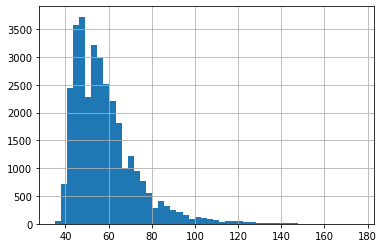

In [7]:
train.text.str.len().hist(bins=50)
plt.show()

In [8]:
max_length = 128
tokenizer = Custom_Tokenizer(max_length=max_length, max_vocab_size=-1)
tokenizer.fit(train.text)

100%|██████████████████████████████████| 32454/32454 [00:00<00:00, 85270.15it/s]


In [9]:
target_size = len(tokenizer.txt2idx)
target_size

58

In [10]:
tokens = tokenizer.txt2token(train.text)

32454it [00:00, 67292.76it/s]


In [11]:
np.array(tokens)

array([[ 2,  5, 27, ...,  0,  0,  0],
       [ 2,  5,  6, ...,  0,  0,  0],
       [ 2,  5, 15, ...,  0,  0,  0],
       ...,
       [ 2, 28,  9, ...,  0,  0,  0],
       [ 2,  8,  6, ...,  0,  0,  0],
       [ 2, 16,  9, ...,  0,  0,  0]])

In [12]:
i = 123
print(f'원본: {train.text[i]}')
print(f'복원: {tokenizer.convert(tokens[i])}')

원본: ㅅㅗㄴㅏㅁㅜ ㅋㅣㄱㅏ ㅁㅏㄶㅇㅣ ㅋㅓㅆㄷㅏ. ㅈㅓ ㅇㅏㅍㅈㅣㅂ ㄱㅓㅅㅣㄹㅇㅣ ㅇㅏㄴ ㅂㅗㅇㅣㄴㅔ?
복원: ㅅㅗㄴㅏㅁㅜ ㅋㅣㄱㅏ ㅁㅏㄶㅇㅣ ㅋㅓㅆㄷㅏ. ㅈㅓ ㅇㅏㅍㅈㅣㅂ ㄱㅓㅅㅣㄹㅇㅣ ㅇㅏㄴ ㅂㅗㅇㅣㄴㅔ?


In [13]:
class CustomDataset(Dataset):
    def __init__(self, path_list, target_list, save_path, sound_max_length=160000, mode='train'):
        self.hop_length = 512
        self.n_fft = 512
        self.sr = 16000
        self.hop_length_duration = float(self.hop_length) / self.sr
        self.n_fft_duration = float(self.n_fft) / self.sr
        self.sound_max_length = sound_max_length
        self.save_path = save_path
        
        self.mode = mode
        self.path_list = path_list
        
        if self.mode == 'train':
            self.target_list = target_list
            
        if not os.path.exists(save_path):
            os.mkdir(save_path)
            
    def __len__(self):
        return len(self.path_list)
    
    def __getitem__(self, i):
        try:
            magnitude = np.load(f'{self.save_path}/magnitude_{i}.npy')
        except:
            data, rate = librosa.load(self.path_list[i])
            sound = np.zeros(self.sound_max_length)
            if len(data) <= self.sound_max_length:
                sound[:data.shape[0]] = data
            else:
                sound = data[:self.sound_max_length]
            stft = librosa.stft(sound, n_fft=self.n_fft, hop_length=self.hop_length)
            magnitude = np.abs(stft).astype(np.float32)
            np.save(f'{self.save_path}/magnitude_{i}.npy', magnitude)
        magnitude_ = np.zeros([magnitude.shape[0],magnitude.shape[1],3])
        magnitude_[:,:,0] = magnitude
        magnitude_[:,:,1] = magnitude
        magnitude_[:,:,2] = magnitude
        
        magnitude = np.transpose(magnitude_, (2,0,1))
        
        if self.mode == 'train':
            target = self.target_list[i]
            return {
                'magnitude' : torch.tensor(magnitude, dtype=torch.float32),
                'target' : torch.tensor(target, dtype=torch.long)
            }
        else:
            return {
                'magnitude' : torch.tensor(magnitude, dtype=torch.float32)
            }

In [14]:
path_list = (train.file_name +'.wav').to_numpy()
path_list.shape, np.array(tokens).shape

((32454,), (32454, 130))

In [15]:
batch_size = 32
num_layers = 6
d_model = 512
dff = 2048
num_heads = 8
dropout_rate = 0.1
epochs = 50
learning_rate = 5e-5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'torch.device: {device}')

path_list, tokens = shuffle(path_list, tokens, random_state=42)

train_path_list = list(map(lambda x: os.path.join('train_data', x), path_list[:-5000]))
val_path_list = list(map(lambda x: os.path.join('train_data', x), path_list[-5000:]))

train_tokens = tokens[:-5000]
val_tokens = tokens[-5000:]

test_path_list = 'test_data/' + submission['file_name'] + '.wav'

train_dataset = CustomDataset(train_path_list, train_tokens, 'train_encoder_input_data')
val_dataset = CustomDataset(val_path_list, val_tokens, 'val_encoder_input_data')
test_dataset = CustomDataset(test_path_list, None, 'test_encoder_input_data', 160000, 'test')

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=0, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=0, shuffle=False)

train_dataset[0]['magnitude'].size(), test_dataset[0]['magnitude'].size()

torch.device: cuda:0


(torch.Size([3, 257, 313]), torch.Size([3, 257, 313]))

In [16]:
sample_batch = next(iter(train_dataloader))
sample_batch['magnitude'].size(), sample_batch['target'].size()

(torch.Size([32, 3, 257, 313]), torch.Size([32, 130]))

In [17]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [18]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return torch.tensor(pos_encoding, dtype=torch.float32)

In [19]:
def create_padding_mask(seq):
    seq = torch.tensor(torch.eq(seq, 0), dtype=torch.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    seq = seq.unsqueeze(1).unsqueeze(2)
    return seq  # (batch_size, 1, 1, seq_len)

In [20]:
def create_look_ahead_mask(size):
    mask = torch.ones(size, size).triu(diagonal=1)
    return mask  # (seq_len, seq_len)

In [21]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = torch.matmul(q, torch.transpose(k, -2, -1))  # (..., seq_len_q, seq_len_k)
    
    # scale matmul_qk
    dk = k.size()[-1]
    scaled_attention_logits = matmul_qk / math.sqrt(dk)
    
    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = torch.nn.functional.softmax(scaled_attention_logits, dim=-1)  # (..., seq_len_q, seq_len_k)

    output = torch.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [22]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
    print('Attention weights are:')
    print(temp_attn)
    print('Output is:')
    print(temp_out)

In [23]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)

        self.wo = nn.Linear(d_model, d_model)
        
    def forward(self, v, k, q, mask):
        batch_size = q.size()[0]
        
        q = self.wq(q).view(batch_size, -1, self.num_heads, self.depth).transpose(1, 2)
        k = self.wk(k).view(batch_size, -1, self.num_heads, self.depth).transpose(1, 2)
        v = self.wv(v).view(batch_size, -1, self.num_heads, self.depth).transpose(1, 2)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        scaled_attention = scaled_attention.transpose(1,2).contiguous().view(batch_size, -1, self.num_heads * self.depth)
                
        output = self.wo(scaled_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [24]:
class FFN(nn.Module):
    def __init__(self, d_model, dff):
        super(FFN, self).__init__()
        self.layer1 = nn.Linear(d_model, dff)
        self.activation = nn.ReLU()
        self.fc = nn.Linear(dff, d_model)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.fc(x)

        return x

In [25]:
class CNN_Encoder(nn.Module):
    def __init__(self, embedding_dim, rate):
        super(CNN_Encoder, self).__init__()
        model = models.resnet50(pretrained=True)
        modules = list(model.children())[:-2]
        self.feature_extract_model = nn.Sequential(*modules)
        self.dropout = nn.Dropout(rate)
        self.fc = nn.Linear(2048, embedding_dim)
        
    def forward(self, x, enc_output=None):
        if enc_output == None:
            x = self.feature_extract_model(x)
            x = x.permute(0,2,3,1)
            x = x.view(x.size()[0], -1, x.size()[3])
            x = self.dropout(x)
            x = nn.ReLU()(self.fc(x))
        else:
            x = enc_output
        return x

In [26]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff, maximum_position_encoding, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = FFN(d_model, dff)
        
        self.dropout1 = nn.Dropout(rate)
        self.dropout2 = nn.Dropout(rate)
        self.dropout3 = nn.Dropout(rate)
        
        self.layernorms1 = nn.ModuleList([copy.deepcopy(nn.LayerNorm([i+1, d_model])) for i in range(maximum_position_encoding)])
        self.layernorms2 = nn.ModuleList([copy.deepcopy(nn.LayerNorm([i+1, d_model])) for i in range(maximum_position_encoding)])
        self.layernorms3 = nn.ModuleList([copy.deepcopy(nn.LayerNorm([i+1, d_model])) for i in range(maximum_position_encoding)])

    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorms1[x.size(1)-1](attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2)
        out2 = self.layernorms2[x.size(1)-1](attn2 + out1)  # (batch_size, target_seq_len, d_model)
        
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorms3[x.size(1)-1](ffn_output + out2)  # (batch_size, target_seq_len, d_model)
        
        return out3, attn_weights_block1, attn_weights_block2

In [27]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [28]:
class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff, target_size, maximum_position_encoding, device, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = nn.Embedding(target_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model).to(device)
        
        self.dec_layers = clones(DecoderLayer(d_model, num_heads, dff, maximum_position_encoding, rate), num_layers)
        self.dropout = nn.Dropout(rate)
        
    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        seq_len = x.size()[1]
        attention_weights = {}
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
            
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [29]:
class Transformer(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff,
               target_size, pe_target, device, rate=0.1):
        super().__init__()
        self.device = device
        self.encoder = CNN_Encoder(d_model, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_size, pe_target, device, rate)

        self.final_layer = nn.Linear(d_model, target_size)

    def forward(self, inputs):
        inp, tar, enc_output = inputs

        look_ahead_mask, dec_padding_mask = self.create_masks(tar)

        enc_output = self.encoder(inp, enc_output)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_size)

        return final_output, attention_weights, enc_output

    def create_masks(self, tar):
        # Used in the 2nd attention block in the decoder.
        # This padding mask is used to mask the encoder outputs.
        dec_padding_mask = None

        # Used in the 1st attention block in the decoder.
        # It is used to pad and mask future tokens in the input received by
        # the decoder.
        look_ahead_mask = create_look_ahead_mask(tar.size(1))
        dec_target_padding_mask = create_padding_mask(tar)
        look_ahead_mask = torch.maximum(dec_target_padding_mask.to(self.device), look_ahead_mask.to(self.device))

        return look_ahead_mask, dec_padding_mask

In [30]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    target_size=target_size,
    pe_target=max_length+1,
    device=device,
    rate=dropout_rate
)

transformer = transformer.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=learning_rate)

iters = len(train_dataloader)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=learning_rate*1e-2)

In [31]:
def loss_function(real, pred):
    mask = torch.logical_not(torch.eq(real, 0))
    loss_ = criterion(pred.permute(0,2,1), real)
    mask = torch.tensor(mask, dtype=loss_.dtype)
    loss_ = mask * loss_

    return torch.sum(loss_)/torch.sum(mask)

def accuracy_function(real, pred):
    accuracies = torch.eq(real, torch.argmax(pred, dim=2))
    mask = torch.logical_not(torch.eq(real, 0))
    accuracies = torch.logical_and(mask, accuracies)
    accuracies = torch.tensor(accuracies, dtype=torch.float32)
    mask = torch.tensor(mask, dtype=torch.float32)
    
    return torch.sum(accuracies)/torch.sum(mask)

In [32]:
def train_step(batch_item, epoch, batch, training):
    src = batch_item['magnitude'].to(device)
    tar = batch_item['target'].to(device)
    
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    if training is True:
        transformer.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output, _, _ = transformer([src, tar_inp, None])
            loss = loss_function(tar_real, output)
        acc = accuracy_function(tar_real, output)
        loss.backward()
        optimizer.step()
#         scheduler.step(epoch + batch / iters)
        lr = optimizer.param_groups[0]["lr"]
        return loss, acc, round(lr, 10)
    else:
        transformer.eval()
        with torch.no_grad():
            output, _, _ = transformer([src, tar_inp, None])
            loss = loss_function(tar_real, output)
        acc = accuracy_function(tar_real, output)
        return loss, acc

In [33]:
loss_plot, val_loss_plot = [], []
acc_plot, val_acc_plot = [], []

for epoch in range(epochs):
    gc.collect()
    total_loss, total_val_loss = 0, 0
    total_acc, total_val_acc = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc, lr = train_step(batch_item, epoch, batch, training)
        total_loss += batch_loss
        total_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'LR' : lr,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Total Loss' : '{:06f}'.format(total_loss/(batch+1)),
            'Total ACC' : '{:06f}'.format(total_acc/(batch+1))
        })
    loss_plot.append(total_loss.detach().cpu().numpy() / (batch+1))
    acc_plot.append(total_acc.detach().cpu().numpy() / (batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, epoch, batch, training)
        total_val_loss += batch_loss
        total_val_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'Total Val ACC' : '{:06f}'.format(total_val_acc/(batch+1))
        })
    val_loss_plot.append(total_val_loss.detach().cpu().numpy() / (batch+1))
    val_acc_plot.append(total_val_acc.detach().cpu().numpy() / (batch+1))

858it [02:35,  5.50it/s, Epoch=1, LR=5e-5, Loss=0.776046, Total Loss=0.979499, Total ACC=0.348049]
157it [00:19,  8.03it/s, Epoch=1, Val Loss=0.863113, Total Val Loss=0.796872, Total Val ACC=0.456433]
858it [02:35,  5.54it/s, Epoch=2, LR=5e-5, Loss=0.673326, Total Loss=0.729961, Total ACC=0.503226]
157it [00:19,  7.92it/s, Epoch=2, Val Loss=0.698791, Total Val Loss=0.644297, Total Val ACC=0.562701]
858it [02:35,  5.51it/s, Epoch=3, LR=5e-5, Loss=0.534820, Total Loss=0.617648, Total ACC=0.579863]
157it [00:19,  7.93it/s, Epoch=3, Val Loss=0.608904, Total Val Loss=0.553980, Total Val ACC=0.623507]
858it [02:35,  5.51it/s, Epoch=4, LR=5e-5, Loss=0.481917, Total Loss=0.545021, Total ACC=0.628552]
157it [00:19,  7.90it/s, Epoch=4, Val Loss=0.535559, Total Val Loss=0.492297, Total Val ACC=0.663505]
858it [02:34,  5.55it/s, Epoch=5, LR=5e-5, Loss=0.500098, Total Loss=0.485568, Total ACC=0.668841]
157it [00:19,  8.03it/s, Epoch=5, Val Loss=0.493088, Total Val Loss=0.454535, Total Val ACC=0.688

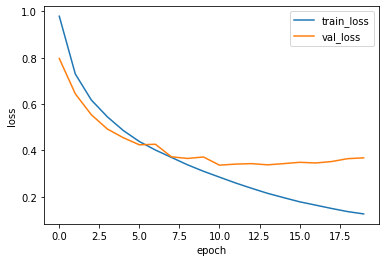

In [34]:
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

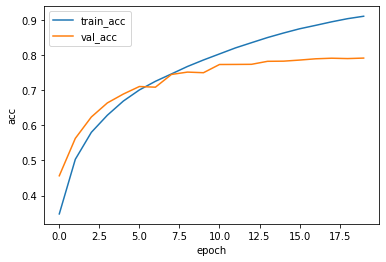

In [35]:
plt.plot(acc_plot, label='train_acc')
plt.plot(val_acc_plot, label='val_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.show()

In [36]:
def evaluate(imgs):
    transformer.to(device)
    # as the target is english, the first word to the transformer should be the
    # english start token.
    decoder_input = torch.tensor([tokenizer.txt2idx['<sos>']] * imgs.size(0), dtype=torch.long).to(device)
    output = decoder_input.unsqueeze(1).to(device)
    enc_output = None
    for i in range(max_length+1):
        # predictions.shape == (batch_size, seq_len, vocab_size)
        with torch.no_grad():
            predictions, attention_weights, enc_output = transformer([imgs, output, enc_output])
        
        # select the last token from the seq_len dimension
        predictions_ = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
        
        predicted_id = torch.tensor(torch.argmax(predictions_, axis=-1), dtype=torch.int32)
        
        output = torch.cat([output, predicted_id], dim=-1)
    output = output.cpu().numpy()
    
    summary_list = []
    token_list = []
    for token in output:
        summary = tokenizer.convert(token)
        summary_list.append(summary)
        token_list.append(token)
    
    return summary_list, token_list

In [37]:
tqdm_dataset = tqdm(enumerate(val_dataloader))
preds = []
tokens = []
for batch, batch_item in tqdm_dataset:
    output = evaluate(batch_item['magnitude'].to(device))
    preds.extend(output[0])
    tokens.extend(output[1])

157it [05:49,  2.23s/it]


In [38]:
sub = pd.DataFrame(columns=['original', 'predict'])

for i, (a_t, p) in enumerate(zip(val_tokens, preds)):
    sub.loc[i, 'original'] = tokenizer.convert(a_t)
    sub.loc[i, 'predict'] = p
    print('정답 :', sub.loc[i, 'original'])
    print('예측 :', p)
#     print('토큰 :', tokens[i])
    print('=================================================================================')
    if i == 10:
        break

정답 : ㅇㅏ/ ㅋㅗㄹㅗㄴㅏㅇㅔ ㄱㅘㄴㄹㅕㄴㅎㅐㅅㅓ ㅇㅏㄴ ㅈㅗㅎㅇㅏㅆㄷㅓㄴ ㄱㅣㅇㅓㄱㅇㅣ ㅇㅣㅆㅇㅓ.
예측 : ㅇㅏ/ ㄱㅗㅎㅡㅇㅎㅏㄱㅇㅡㄹ ㄱㅡㄴㅑㅇ ㄱㅡㄹㅓㄴㅈㅣ ㄱㅡㄹㅓㄴㅈㅣ ㄱㅡㅇㅑㄱㅇㅡㄹ ㄱㅓㅅㅇㅣㅆㄴㅡㄴㄷㅔ ㅇㅣㅆㄴㅡㄴㅡㄴ ㄱㅓㅅㅇㅡㄹㅏㄱㅇㅣㄴ ㄱㅡㄹㅇㅓㄴㅈㅔ ㅇㅣㅆㄴㅡㄴㅡㄴ ㄱㅓㅅㅓㅅㅇㅡㄹㅏㄱㅇㅣㄴ ㄱㅡㄹㅇㅣㅇㅓㄱㅏㄴ ㄷㅗㄴㅇㅡ
정답 : ㄱㅡㄹㅓㄴㄷㅔ ㅈㅓㅎㅢ ㄷㅗㅇㄴㅔ ㅅㅣㅈㅏㅇㅇㅔ ㅇㅣㅆㄴㅡㄴ ㅈㅜㄱㅈㅣㅂㅇㅢ ㅅㅏㅈㅏㅇㄴㅣㅁㅇㅡㄴ ㅊㅏㅁ ㅊㅣㄴㅈㅓㄹㅎㅏㅅㅣㅂㄴㅣㄷㅏ.
예측 : ㄱㅡㄹㅓㄴㄷㅔ ㅈㅓㅇㄱㅣㄴㅡㄴ ㅅㅣㄱㅏㄴ ㄱㅣㅎㅚㅇㅔㄴㅡㄴ ㅇㅡㄹㅈㅣㄱㅈㅓㄱㅇㅣㄴㅇㅡㄴ ㅅㅣㄱㄷㅐㄹㅗ ㅅㅏㅈㅓㄴㅇㅣㄴㅡㄴ ㄱㅓㄴㅈㅓㅇㅎㅏㄴ ㅈㅓㄴㅁㅜㄴㅇㅣ ㅈㅏㅁㅇㅡㄴ ㅊㅣㄴㄱㅜㄴㅎㅏㄴㅡㄴ ㅈㅣㄴㅊㅓㅇㅣㄴ ㅊㅓㅇㅡㅁㅇㅣㄴ ㅊㅏㅁㅅ
정답 : ㄴㅓ ㅇㅚㅁㅗ ㅈㅣㅅㅏㅇㅈㅜㅇㅢ ㅂㅘㅆㅇㅓ? ㅇㅓㄸㅓㄴ ㄱㅓ ㄱㅏㅌㅇㅏ?
예측 : ㅈㅓ/ ㄱㅡㄴㅑㅇ ㄱㅡㄴㅑㅇ ㄱㅡㄹㅓㅎㄱㅔ ㅇㅣㅆㄴㅡㄴ ㄱㅓㅅㅇㅡㄴ ㄱㅓㄴㄱㅏㅇㅎㅐ? ㅇㅣㅆㄴㅡㄴ ㄱㅓㅅㅇㅡㄹ ㅇㅣㅆㄴㅡㄴㄷㅔ ㅇㅓㅄㅇㅓ? ㄱㅡㄹㅓㄴㅣㄴㄱㅏ ㄱㅓㅅㅇㅣㅆㄴㅡㄴ ㄱㅓㅅㅐㅇㅛ? ㅇㅣㅆㄴㅡㄴㅡㄴ ㅇㅓㅇㅑㄱㅣㄱㅣㄱㅣㅇㅡㄹ
정답 : ㄱㅡ/ ㅇㅛㅈㅡㅁ ㅊㅚㅅㅣㄴㄱㅗㄱ ㅈㅜㅇㅇㅔ ㅈㅗㅎㅇㅡㄴ ㄴㅗㄹㅐ ㅈㅗㅁ ㅇㅏㄹㄹㅕㅈㅝ.
예측 : ㄱㅡ/ ㄱㅡㄴㅑㅇ ㅊㅣㄴㄱㅜㄱㅏ ㅈㅗㅎㅇㅡㄴ ㄱㅓㄴ ㅇㅣㅆㄴㅡㄴ ㄱㅓㅅㅇㅡㄹ ㄱㅓㄴㅈㅔㅇㅣㄴㄱㅏ ㄱㅡㄹㅓㄴㅈㅣ ㅇㅏㄴㄱㅗㄴㅡㄴ ㄱㅓㄹㅇㅡㄹ ㅇㅣㅆㅇㅓㅇㅛ. ㄱㅏㅌㅇㅡㄴㅣㄴㅡㄴ ㄱㅓㅅㅐㅇㄱㅏㄱㅇㅡㄹ ㅁㅏㄴㄷㅡㄹ ㄱㅓ ㅇㅣㅆㄴㅡㄴㅡㄴ
정답 : ㅇㅏㄴㅣ/ ㅇㅗㄴㅡㄹㅇㅡㄴ ㄴㅏㄹㅆㅣㄱㅏ ㅁㅏㄶㅇㅣ ㄷㅓㅇㅝㅅㅓ ㅎㅣㅁㄷㅡㄴㅔㅇㅛ.
예측 : ㅇㅏㄴㅣ/ ㅇㅗㄴㅡㄹ ㄱㅡㄴㅑㅇ ㄱㅡㄹㅓㄴㅈㅣ ㅇㅏㄴㄱㅗㄱㅇㅣㄴㅇㅡㄹ ㅎㅏㄴㅣㄲㅏ ㅇㅣㅆㄴㅡㄴ ㄱㅓㅅㅇㅡㄹ ㅇㅣㄹㅇㅓㄴㅏㄴ ㄱㅗㅎㅑㅇㅇㅔ ㄷㅡㄹㅇㅓㅅㅓㅇㅜㄴㅎㅏㄱㅔ ㅎㅏㄴㄷㅗㅎㅏㄱㅗ ㅅㅣㅍㅇㅓㅇㅣ ㅈㅗㅎㅏㄱㅗㄴ ㅅㅓㅇㅣㅆㅇㅓㅇㅓㅇ
정답 : ㅈㅓ/ ㅈㅣㅈㅣㄴㅇㅣ ㄴㅏㅅㅓ ㅇㅜㄹㅣ ㅈㅣㅂ ㅅㅑㅇㄷㅡㄹㄹ

In [39]:
tqdm_dataset = tqdm(enumerate(test_dataloader))
preds = []
tokens = []
for batch, batch_item in tqdm_dataset:
    output = evaluate(batch_item['magnitude'].to(device))
    preds.extend(output[0])
    tokens.extend(output[1])

38it [01:24,  2.22s/it]


In [40]:
submission['text'] = preds
submission.head()

from datetime import datetime
timestamp = datetime.now().isoformat().replace(':', '_').split('.')[0]
submission.to_csv(f'submission_{timestamp}.csv', index=False)

TypeError: an integer is required (got type str)